##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# How to solve a problem on Kaggle with TF-Hub


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub_on_kaggle"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/nnlm-en-dim128/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

TF-Hub is a platform to share machine learning expertise packaged in reusable resources, notably pre-trained **modules**. In this tutorial, we will use a TF-Hub text embedding module to train a simple sentiment classifier with a reasonable baseline accuracy. We will then submit the predictions to Kaggle.

For more detailed tutorial on text classification with TF-Hub and further steps for improving the accuracy, take a look at [Text classification with TF-Hub](https://colab.research.google.com/github/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb).

## Setup

In [2]:
!pip install -q kaggle

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

from sklearn import model_selection

Since this tutorial will be using a dataset from Kaggle, it requires [creating an API Token](https://github.com/Kaggle/kaggle-api) for your Kaggle account, and uploading it to the Colab environment.

In [4]:
import os
import pathlib

# Upload the API token.
def get_kaggle():
  try:
    import kaggle
    return kaggle
  except OSError:
    pass

  token_file = pathlib.Path("~/.kaggle/kaggle.json").expanduser()
  token_file.parent.mkdir(exist_ok=True, parents=True)

  try:
    from google.colab import files
  except ImportError:
    raise ValueError("Could not find kaggle token.")

  uploaded = files.upload()
  token_content = uploaded.get('kaggle.json', None)
  if token_content:
    token_file.write_bytes(token_content)
    token_file.chmod(0o600)
  else:
    raise ValueError('Need a file named "kaggle.json"')
  
  import kaggle
  return kaggle


kaggle = get_kaggle()

# Getting started

## Data
We will try to solve the [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) task from Kaggle. The dataset consists of syntactic subphrases of the Rotten Tomatoes movie reviews. The task is to label the phrases as **negative** or **positive** on the scale from 1 to 5.

You must [accept the competition rules](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) before you can use the API to download the data.


In [5]:
SENTIMENT_LABELS = [
    "negative", "somewhat negative", "neutral", "somewhat positive", "positive"
]

# Add a column with readable values representing the sentiment.
def add_readable_labels_column(df, sentiment_value_column):
  df["SentimentLabel"] = df[sentiment_value_column].replace(
      range(5), SENTIMENT_LABELS)
    
# Download data from Kaggle and create a DataFrame.
def load_data_from_zip(path):
  with zipfile.ZipFile(path, "r") as zip_ref:
    name = zip_ref.namelist()[0]
    with zip_ref.open(name) as zf:
      return pd.read_csv(zf, sep="\t", index_col=0)


# The data does not come with a validation set so we'll create one from the
# training set.
def get_data(competition, train_file, test_file, validation_set_ratio=0.1):
  data_path = pathlib.Path("data")
  kaggle.api.competition_download_files(competition, data_path)
  competition_path = (data_path/competition)
  competition_path.mkdir(exist_ok=True, parents=True)
  competition_zip_path = competition_path.with_suffix(".zip")

  with zipfile.ZipFile(competition_zip_path, "r") as zip_ref:
    zip_ref.extractall(competition_path)
  
  train_df = load_data_from_zip(competition_path/train_file)
  test_df = load_data_from_zip(competition_path/test_file)

  # Add a human readable label.
  add_readable_labels_column(train_df, "Sentiment")

  # We split by sentence ids, because we don't want to have phrases belonging
  # to the same sentence in both training and validation set.
  train_indices, validation_indices = model_selection.train_test_split(
      np.unique(train_df["SentenceId"]),
      test_size=validation_set_ratio,
      random_state=0)

  validation_df = train_df[train_df["SentenceId"].isin(validation_indices)]
  train_df = train_df[train_df["SentenceId"].isin(train_indices)]
  print("Split the training data into %d training and %d validation examples." %
        (len(train_df), len(validation_df)))

  return train_df, validation_df, test_df


train_df, validation_df, test_df = get_data(
    "sentiment-analysis-on-movie-reviews",
    "train.tsv.zip", "test.tsv.zip")

Split the training data into 140315 training and 15745 validation examples.


Note: In this competition the task is not to rate entire reviews, but individual phrases from within the reviews. This is a much harder task.

In [6]:
train_df.head(20)

SentenceId                                             Phrase   
PhraseId                                                                  
1                  1  A series of escapades demonstrating the adage ...  \
2                  1  A series of escapades demonstrating the adage ...   
3                  1                                           A series   
4                  1                                                  A   
5                  1                                             series   
6                  1  of escapades demonstrating the adage that what...   
7                  1                                                 of   
8                  1  escapades demonstrating the adage that what is...   
9                  1                                          escapades   
10                 1  demonstrating the adage that what is good for ...   
11                 1                            demonstrating the adage   
12                 1                                      demonstrating   
13                 1                                          the adage   
14                 1                                                the   
15                 1                                              adage   
16                 1                    that what is good for the goose   
17                 1                                               that   
18                 1                         what is good for the goose   
19                 1                                               what   
20                 1                              is good for the goose   

          Sentiment     SentimentLabel  
PhraseId                                
1                 1  somewhat negative  
2                 2            neutral  
3                 2            neutral  
4                 2            neutral  
5                 2            neutral  
6                 2            neutral  
7                 2            neutral  
8                 2            neutral  
9                 2            neutral  
10                2            neutral  
11                2            neutral  
12                2            neutral  
13                2            neutral  
14                2            neutral  
15                2            neutral  
16                2            neutral  
17                2            neutral  
18                2            neutral  
19                2            neutral  
20                2            neutral

## Training an Model

*Note: We could model this task also as a regression, see [Text classification with TF-Hub](https://colab.research.google.com/github/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb).*

In [7]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url).signatures['default']
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(500),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    phrases = inputs['Phrase'][:,0]
    embedding = 5*self.embed(phrases)['default']
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

In [8]:
model = MyModel("https://tfhub.dev/google/nnlm-en-dim128/1")
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [9]:
history = model.fit(x=dict(train_df), y=train_df['Sentiment'],
          validation_data=(dict(validation_df), validation_df['Sentiment']),
          epochs = 25)

Epoch 1/25


   1/4385 [..............................] - ETA: 2:14:57 - loss: 1.8340 - accuracy: 0.1250

  18/4385 [..............................] - ETA: 12s - loss: 1.5112 - accuracy: 0.4149    

  37/4385 [..............................] - ETA: 12s - loss: 1.4282 - accuracy: 0.4451

  56/4385 [..............................] - ETA: 11s - loss: 1.3689 - accuracy: 0.4637

  76/4385 [..............................] - ETA: 11s - loss: 1.3012 - accuracy: 0.4873

  95/4385 [..............................] - ETA: 11s - loss: 1.2828 - accuracy: 0.4944

 113/4385 [..............................] - ETA: 11s - loss: 1.2640 - accuracy: 0.5014

 132/4385 [..............................] - ETA: 11s - loss: 1.2430 - accuracy: 0.5140

 150/4385 [>.............................] - ETA: 11s - loss: 1.2262 - accuracy: 0.5181

 169/4385 [>.............................] - ETA: 11s - loss: 1.2114 - accuracy: 0.5229

 188/4385 [>.............................] - ETA: 11s - loss: 1.1982 - accuracy: 0.5271

 207/4385 [>.............................] - ETA: 11s - loss: 1.1870 - accuracy: 0.5296

 226/4385 [>.............................] - ETA: 11s - loss: 1.1814 - accuracy: 0.5310

 245/4385 [>.............................] - ETA: 11s - loss: 1.1772 - accuracy: 0.5325

 264/4385 [>.............................] - ETA: 11s - loss: 1.1746 - accuracy: 0.5317

 283/4385 [>.............................] - ETA: 11s - loss: 1.1694 - accuracy: 0.5331

 302/4385 [=>............................] - ETA: 11s - loss: 1.1603 - accuracy: 0.5361

 321/4385 [=>............................] - ETA: 11s - loss: 1.1549 - accuracy: 0.5383

 341/4385 [=>............................] - ETA: 11s - loss: 1.1484 - accuracy: 0.5402

 361/4385 [=>............................] - ETA: 10s - loss: 1.1430 - accuracy: 0.5428

 381/4385 [=>............................] - ETA: 10s - loss: 1.1395 - accuracy: 0.5440

 401/4385 [=>............................] - ETA: 10s - loss: 1.1332 - accuracy: 0.5453

 421/4385 [=>............................] - ETA: 10s - loss: 1.1282 - accuracy: 0.5477

 440/4385 [==>...........................] - ETA: 10s - loss: 1.1255 - accuracy: 0.5484

 459/4385 [==>...........................] - ETA: 10s - loss: 1.1251 - accuracy: 0.5491

 479/4385 [==>...........................] - ETA: 10s - loss: 1.1215 - accuracy: 0.5496

 499/4385 [==>...........................] - ETA: 10s - loss: 1.1200 - accuracy: 0.5506

 517/4385 [==>...........................] - ETA: 10s - loss: 1.1170 - accuracy: 0.5517

 535/4385 [==>...........................] - ETA: 10s - loss: 1.1154 - accuracy: 0.5520

 553/4385 [==>...........................] - ETA: 10s - loss: 1.1125 - accuracy: 0.5538

 571/4385 [==>...........................] - ETA: 10s - loss: 1.1096 - accuracy: 0.5547

 589/4385 [===>..........................] - ETA: 10s - loss: 1.1064 - accuracy: 0.5563

 606/4385 [===>..........................] - ETA: 10s - loss: 1.1047 - accuracy: 0.5566

 624/4385 [===>..........................] - ETA: 10s - loss: 1.1019 - accuracy: 0.5576

 642/4385 [===>..........................] - ETA: 10s - loss: 1.1005 - accuracy: 0.5581

 660/4385 [===>..........................] - ETA: 10s - loss: 1.1005 - accuracy: 0.5575

 678/4385 [===>..........................] - ETA: 10s - loss: 1.0995 - accuracy: 0.5582

 696/4385 [===>..........................] - ETA: 10s - loss: 1.0984 - accuracy: 0.5581

 714/4385 [===>..........................] - ETA: 10s - loss: 1.0962 - accuracy: 0.5589

 732/4385 [====>.........................] - ETA: 10s - loss: 1.0945 - accuracy: 0.5595

 750/4385 [====>.........................] - ETA: 9s - loss: 1.0950 - accuracy: 0.5596 

 768/4385 [====>.........................] - ETA: 9s - loss: 1.0935 - accuracy: 0.5606

 786/4385 [====>.........................] - ETA: 9s - loss: 1.0905 - accuracy: 0.5619

 804/4385 [====>.........................] - ETA: 9s - loss: 1.0886 - accuracy: 0.5628

 822/4385 [====>.........................] - ETA: 9s - loss: 1.0863 - accuracy: 0.5638

 840/4385 [====>.........................] - ETA: 9s - loss: 1.0846 - accuracy: 0.5647

 858/4385 [====>.........................] - ETA: 9s - loss: 1.0841 - accuracy: 0.5649

 876/4385 [====>.........................] - ETA: 9s - loss: 1.0834 - accuracy: 0.5654

 894/4385 [=====>........................] - ETA: 9s - loss: 1.0820 - accuracy: 0.5655

 912/4385 [=====>........................] - ETA: 9s - loss: 1.0797 - accuracy: 0.5664

 930/4385 [=====>........................] - ETA: 9s - loss: 1.0775 - accuracy: 0.5675

 948/4385 [=====>........................] - ETA: 9s - loss: 1.0770 - accuracy: 0.5676

 965/4385 [=====>........................] - ETA: 9s - loss: 1.0769 - accuracy: 0.5678

 982/4385 [=====>........................] - ETA: 9s - loss: 1.0758 - accuracy: 0.5682

 998/4385 [=====>........................] - ETA: 9s - loss: 1.0749 - accuracy: 0.5682

1015/4385 [=====>........................] - ETA: 9s - loss: 1.0745 - accuracy: 0.5685

1033/4385 [======>.......................] - ETA: 9s - loss: 1.0732 - accuracy: 0.5689

1050/4385 [======>.......................] - ETA: 9s - loss: 1.0725 - accuracy: 0.5690

1067/4385 [======>.......................] - ETA: 9s - loss: 1.0732 - accuracy: 0.5689

1084/4385 [======>.......................] - ETA: 9s - loss: 1.0724 - accuracy: 0.5686

1102/4385 [======>.......................] - ETA: 9s - loss: 1.0708 - accuracy: 0.5691

1120/4385 [======>.......................] - ETA: 9s - loss: 1.0696 - accuracy: 0.5698

1138/4385 [======>.......................] - ETA: 9s - loss: 1.0683 - accuracy: 0.5701

1156/4385 [======>.......................] - ETA: 9s - loss: 1.0687 - accuracy: 0.5703

1173/4385 [=======>......................] - ETA: 9s - loss: 1.0672 - accuracy: 0.5710

1191/4385 [=======>......................] - ETA: 8s - loss: 1.0669 - accuracy: 0.5711

1209/4385 [=======>......................] - ETA: 8s - loss: 1.0664 - accuracy: 0.5713

1227/4385 [=======>......................] - ETA: 8s - loss: 1.0650 - accuracy: 0.5719

1245/4385 [=======>......................] - ETA: 8s - loss: 1.0645 - accuracy: 0.5719

1263/4385 [=======>......................] - ETA: 8s - loss: 1.0637 - accuracy: 0.5721

1281/4385 [=======>......................] - ETA: 8s - loss: 1.0633 - accuracy: 0.5721

1299/4385 [=======>......................] - ETA: 8s - loss: 1.0622 - accuracy: 0.5728

1317/4385 [========>.....................] - ETA: 8s - loss: 1.0612 - accuracy: 0.5729

1335/4385 [========>.....................] - ETA: 8s - loss: 1.0612 - accuracy: 0.5730

1353/4385 [========>.....................] - ETA: 8s - loss: 1.0606 - accuracy: 0.5731

1371/4385 [========>.....................] - ETA: 8s - loss: 1.0602 - accuracy: 0.5736

1388/4385 [========>.....................] - ETA: 8s - loss: 1.0596 - accuracy: 0.5738

1405/4385 [========>.....................] - ETA: 8s - loss: 1.0590 - accuracy: 0.5738

1423/4385 [========>.....................] - ETA: 8s - loss: 1.0583 - accuracy: 0.5746

1441/4385 [========>.....................] - ETA: 8s - loss: 1.0568 - accuracy: 0.5753

1459/4385 [========>.....................] - ETA: 8s - loss: 1.0565 - accuracy: 0.5757

1477/4385 [=========>....................] - ETA: 8s - loss: 1.0570 - accuracy: 0.5755

1495/4385 [=========>....................] - ETA: 8s - loss: 1.0562 - accuracy: 0.5757

1513/4385 [=========>....................] - ETA: 8s - loss: 1.0556 - accuracy: 0.5760

1531/4385 [=========>....................] - ETA: 8s - loss: 1.0556 - accuracy: 0.5761

1549/4385 [=========>....................] - ETA: 8s - loss: 1.0547 - accuracy: 0.5764

1567/4385 [=========>....................] - ETA: 7s - loss: 1.0545 - accuracy: 0.5766

1585/4385 [=========>....................] - ETA: 7s - loss: 1.0548 - accuracy: 0.5764

1603/4385 [=========>....................] - ETA: 7s - loss: 1.0544 - accuracy: 0.5765

1621/4385 [==========>...................] - ETA: 7s - loss: 1.0544 - accuracy: 0.5761

1639/4385 [==========>...................] - ETA: 7s - loss: 1.0541 - accuracy: 0.5762

1657/4385 [==========>...................] - ETA: 7s - loss: 1.0528 - accuracy: 0.5767

1675/4385 [==========>...................] - ETA: 7s - loss: 1.0520 - accuracy: 0.5769

1693/4385 [==========>...................] - ETA: 7s - loss: 1.0520 - accuracy: 0.5766

1711/4385 [==========>...................] - ETA: 7s - loss: 1.0513 - accuracy: 0.5767

1729/4385 [==========>...................] - ETA: 7s - loss: 1.0508 - accuracy: 0.5771

1746/4385 [==========>...................] - ETA: 7s - loss: 1.0501 - accuracy: 0.5773

1763/4385 [===========>..................] - ETA: 7s - loss: 1.0494 - accuracy: 0.5776

1781/4385 [===========>..................] - ETA: 7s - loss: 1.0491 - accuracy: 0.5777

1799/4385 [===========>..................] - ETA: 7s - loss: 1.0487 - accuracy: 0.5777

1817/4385 [===========>..................] - ETA: 7s - loss: 1.0484 - accuracy: 0.5779

1835/4385 [===========>..................] - ETA: 7s - loss: 1.0484 - accuracy: 0.5780

1853/4385 [===========>..................] - ETA: 7s - loss: 1.0483 - accuracy: 0.5781

1871/4385 [===========>..................] - ETA: 7s - loss: 1.0481 - accuracy: 0.5783

1889/4385 [===========>..................] - ETA: 7s - loss: 1.0471 - accuracy: 0.5787

1907/4385 [============>.................] - ETA: 7s - loss: 1.0469 - accuracy: 0.5790

1925/4385 [============>.................] - ETA: 6s - loss: 1.0472 - accuracy: 0.5789

1943/4385 [============>.................] - ETA: 6s - loss: 1.0466 - accuracy: 0.5789

1961/4385 [============>.................] - ETA: 6s - loss: 1.0464 - accuracy: 0.5789

1979/4385 [============>.................] - ETA: 6s - loss: 1.0461 - accuracy: 0.5791

1997/4385 [============>.................] - ETA: 6s - loss: 1.0456 - accuracy: 0.5793

2015/4385 [============>.................] - ETA: 6s - loss: 1.0456 - accuracy: 0.5795

2033/4385 [============>.................] - ETA: 6s - loss: 1.0459 - accuracy: 0.5792

2051/4385 [=============>................] - ETA: 6s - loss: 1.0454 - accuracy: 0.5796

2069/4385 [=============>................] - ETA: 6s - loss: 1.0453 - accuracy: 0.5798

2087/4385 [=============>................] - ETA: 6s - loss: 1.0451 - accuracy: 0.5798

2105/4385 [=============>................] - ETA: 6s - loss: 1.0454 - accuracy: 0.5795

2123/4385 [=============>................] - ETA: 6s - loss: 1.0453 - accuracy: 0.5797

2141/4385 [=============>................] - ETA: 6s - loss: 1.0447 - accuracy: 0.5800

2159/4385 [=============>................] - ETA: 6s - loss: 1.0442 - accuracy: 0.5801

2177/4385 [=============>................] - ETA: 6s - loss: 1.0437 - accuracy: 0.5804

2195/4385 [==============>...............] - ETA: 6s - loss: 1.0435 - accuracy: 0.5803

2213/4385 [==============>...............] - ETA: 6s - loss: 1.0434 - accuracy: 0.5803

2231/4385 [==============>...............] - ETA: 6s - loss: 1.0428 - accuracy: 0.5805

2249/4385 [==============>...............] - ETA: 6s - loss: 1.0422 - accuracy: 0.5807

2267/4385 [==============>...............] - ETA: 6s - loss: 1.0422 - accuracy: 0.5808

2285/4385 [==============>...............] - ETA: 5s - loss: 1.0418 - accuracy: 0.5809

2303/4385 [==============>...............] - ETA: 5s - loss: 1.0417 - accuracy: 0.5811

2321/4385 [==============>...............] - ETA: 5s - loss: 1.0416 - accuracy: 0.5813

2339/4385 [===============>..............] - ETA: 5s - loss: 1.0413 - accuracy: 0.5814

2357/4385 [===============>..............] - ETA: 5s - loss: 1.0406 - accuracy: 0.5816

2375/4385 [===============>..............] - ETA: 5s - loss: 1.0403 - accuracy: 0.5816

2393/4385 [===============>..............] - ETA: 5s - loss: 1.0398 - accuracy: 0.5818

2411/4385 [===============>..............] - ETA: 5s - loss: 1.0395 - accuracy: 0.5818

2429/4385 [===============>..............] - ETA: 5s - loss: 1.0391 - accuracy: 0.5819

2446/4385 [===============>..............] - ETA: 5s - loss: 1.0387 - accuracy: 0.5821

2464/4385 [===============>..............] - ETA: 5s - loss: 1.0389 - accuracy: 0.5819

2482/4385 [===============>..............] - ETA: 5s - loss: 1.0387 - accuracy: 0.5821

2500/4385 [================>.............] - ETA: 5s - loss: 1.0388 - accuracy: 0.5821

2518/4385 [================>.............] - ETA: 5s - loss: 1.0384 - accuracy: 0.5822

2536/4385 [================>.............] - ETA: 5s - loss: 1.0382 - accuracy: 0.5823

2554/4385 [================>.............] - ETA: 5s - loss: 1.0380 - accuracy: 0.5823

2572/4385 [================>.............] - ETA: 5s - loss: 1.0382 - accuracy: 0.5823

2590/4385 [================>.............] - ETA: 5s - loss: 1.0378 - accuracy: 0.5826

2608/4385 [================>.............] - ETA: 5s - loss: 1.0374 - accuracy: 0.5827

2626/4385 [================>.............] - ETA: 5s - loss: 1.0371 - accuracy: 0.5829

2644/4385 [=================>............] - ETA: 4s - loss: 1.0367 - accuracy: 0.5830

2662/4385 [=================>............] - ETA: 4s - loss: 1.0363 - accuracy: 0.5830

2680/4385 [=================>............] - ETA: 4s - loss: 1.0363 - accuracy: 0.5830

2698/4385 [=================>............] - ETA: 4s - loss: 1.0355 - accuracy: 0.5832

2716/4385 [=================>............] - ETA: 4s - loss: 1.0350 - accuracy: 0.5835

2734/4385 [=================>............] - ETA: 4s - loss: 1.0349 - accuracy: 0.5835

2752/4385 [=================>............] - ETA: 4s - loss: 1.0349 - accuracy: 0.5833

2770/4385 [=================>............] - ETA: 4s - loss: 1.0349 - accuracy: 0.5834

2787/4385 [==================>...........] - ETA: 4s - loss: 1.0348 - accuracy: 0.5836

2805/4385 [==================>...........] - ETA: 4s - loss: 1.0348 - accuracy: 0.5835

2822/4385 [==================>...........] - ETA: 4s - loss: 1.0347 - accuracy: 0.5835

2839/4385 [==================>...........] - ETA: 4s - loss: 1.0348 - accuracy: 0.5834

2857/4385 [==================>...........] - ETA: 4s - loss: 1.0348 - accuracy: 0.5835

2875/4385 [==================>...........] - ETA: 4s - loss: 1.0345 - accuracy: 0.5836

2893/4385 [==================>...........] - ETA: 4s - loss: 1.0344 - accuracy: 0.5837

2911/4385 [==================>...........] - ETA: 4s - loss: 1.0343 - accuracy: 0.5836

2929/4385 [===================>..........] - ETA: 4s - loss: 1.0345 - accuracy: 0.5836

2947/4385 [===================>..........] - ETA: 4s - loss: 1.0345 - accuracy: 0.5836

2964/4385 [===================>..........] - ETA: 4s - loss: 1.0342 - accuracy: 0.5839

2982/4385 [===================>..........] - ETA: 4s - loss: 1.0338 - accuracy: 0.5841

3000/4385 [===================>..........] - ETA: 3s - loss: 1.0340 - accuracy: 0.5842

3018/4385 [===================>..........] - ETA: 3s - loss: 1.0338 - accuracy: 0.5843

3036/4385 [===================>..........] - ETA: 3s - loss: 1.0336 - accuracy: 0.5842

3054/4385 [===================>..........] - ETA: 3s - loss: 1.0334 - accuracy: 0.5843

3072/4385 [====================>.........] - ETA: 3s - loss: 1.0335 - accuracy: 0.5843

3090/4385 [====================>.........] - ETA: 3s - loss: 1.0337 - accuracy: 0.5841

3108/4385 [====================>.........] - ETA: 3s - loss: 1.0335 - accuracy: 0.5842

3126/4385 [====================>.........] - ETA: 3s - loss: 1.0335 - accuracy: 0.5841

3144/4385 [====================>.........] - ETA: 3s - loss: 1.0333 - accuracy: 0.5843

3162/4385 [====================>.........] - ETA: 3s - loss: 1.0334 - accuracy: 0.5843

3180/4385 [====================>.........] - ETA: 3s - loss: 1.0333 - accuracy: 0.5843

3197/4385 [====================>.........] - ETA: 3s - loss: 1.0331 - accuracy: 0.5844

3214/4385 [====================>.........] - ETA: 3s - loss: 1.0329 - accuracy: 0.5843

3232/4385 [=====================>........] - ETA: 3s - loss: 1.0327 - accuracy: 0.5844

3250/4385 [=====================>........] - ETA: 3s - loss: 1.0328 - accuracy: 0.5843

3268/4385 [=====================>........] - ETA: 3s - loss: 1.0325 - accuracy: 0.5844

3286/4385 [=====================>........] - ETA: 3s - loss: 1.0326 - accuracy: 0.5843

3304/4385 [=====================>........] - ETA: 3s - loss: 1.0326 - accuracy: 0.5844

3322/4385 [=====================>........] - ETA: 3s - loss: 1.0323 - accuracy: 0.5846

3340/4385 [=====================>........] - ETA: 2s - loss: 1.0322 - accuracy: 0.5845

3358/4385 [=====================>........] - ETA: 2s - loss: 1.0319 - accuracy: 0.5845

3376/4385 [======================>.......] - ETA: 2s - loss: 1.0318 - accuracy: 0.5846

3394/4385 [======================>.......] - ETA: 2s - loss: 1.0318 - accuracy: 0.5846

3412/4385 [======================>.......] - ETA: 2s - loss: 1.0319 - accuracy: 0.5845

3430/4385 [======================>.......] - ETA: 2s - loss: 1.0320 - accuracy: 0.5844

3448/4385 [======================>.......] - ETA: 2s - loss: 1.0318 - accuracy: 0.5844

3466/4385 [======================>.......] - ETA: 2s - loss: 1.0315 - accuracy: 0.5845

3484/4385 [======================>.......] - ETA: 2s - loss: 1.0313 - accuracy: 0.5846

3502/4385 [======================>.......] - ETA: 2s - loss: 1.0312 - accuracy: 0.5847

3520/4385 [=======================>......] - ETA: 2s - loss: 1.0312 - accuracy: 0.5847

3538/4385 [=======================>......] - ETA: 2s - loss: 1.0312 - accuracy: 0.5847

3556/4385 [=======================>......] - ETA: 2s - loss: 1.0312 - accuracy: 0.5845

3574/4385 [=======================>......] - ETA: 2s - loss: 1.0310 - accuracy: 0.5847

3592/4385 [=======================>......] - ETA: 2s - loss: 1.0310 - accuracy: 0.5847

3610/4385 [=======================>......] - ETA: 2s - loss: 1.0310 - accuracy: 0.5849

3628/4385 [=======================>......] - ETA: 2s - loss: 1.0306 - accuracy: 0.5849

3646/4385 [=======================>......] - ETA: 2s - loss: 1.0301 - accuracy: 0.5851

3664/4385 [========================>.....] - ETA: 2s - loss: 1.0298 - accuracy: 0.5852

3682/4385 [========================>.....] - ETA: 2s - loss: 1.0297 - accuracy: 0.5852

3700/4385 [========================>.....] - ETA: 1s - loss: 1.0296 - accuracy: 0.5852

3718/4385 [========================>.....] - ETA: 1s - loss: 1.0297 - accuracy: 0.5853

3736/4385 [========================>.....] - ETA: 1s - loss: 1.0295 - accuracy: 0.5854

3754/4385 [========================>.....] - ETA: 1s - loss: 1.0295 - accuracy: 0.5854

3772/4385 [========================>.....] - ETA: 1s - loss: 1.0291 - accuracy: 0.5856

3790/4385 [========================>.....] - ETA: 1s - loss: 1.0289 - accuracy: 0.5856

3808/4385 [=========================>....] - ETA: 1s - loss: 1.0288 - accuracy: 0.5856

3826/4385 [=========================>....] - ETA: 1s - loss: 1.0288 - accuracy: 0.5855

3844/4385 [=========================>....] - ETA: 1s - loss: 1.0288 - accuracy: 0.5854

3862/4385 [=========================>....] - ETA: 1s - loss: 1.0289 - accuracy: 0.5854

3879/4385 [=========================>....] - ETA: 1s - loss: 1.0288 - accuracy: 0.5854

3897/4385 [=========================>....] - ETA: 1s - loss: 1.0287 - accuracy: 0.5855

3915/4385 [=========================>....] - ETA: 1s - loss: 1.0285 - accuracy: 0.5855

3932/4385 [=========================>....] - ETA: 1s - loss: 1.0284 - accuracy: 0.5856

3949/4385 [==========================>...] - ETA: 1s - loss: 1.0284 - accuracy: 0.5856

3966/4385 [==========================>...] - ETA: 1s - loss: 1.0286 - accuracy: 0.5855

3983/4385 [==========================>...] - ETA: 1s - loss: 1.0289 - accuracy: 0.5854

4000/4385 [==========================>...] - ETA: 1s - loss: 1.0285 - accuracy: 0.5858

4018/4385 [==========================>...] - ETA: 1s - loss: 1.0282 - accuracy: 0.5859

4036/4385 [==========================>...] - ETA: 0s - loss: 1.0278 - accuracy: 0.5860

4054/4385 [==========================>...] - ETA: 0s - loss: 1.0279 - accuracy: 0.5860

4071/4385 [==========================>...] - ETA: 0s - loss: 1.0281 - accuracy: 0.5858

4089/4385 [==========================>...] - ETA: 0s - loss: 1.0278 - accuracy: 0.5859

4106/4385 [===========================>..] - ETA: 0s - loss: 1.0276 - accuracy: 0.5860

4124/4385 [===========================>..] - ETA: 0s - loss: 1.0275 - accuracy: 0.5861

4142/4385 [===========================>..] - ETA: 0s - loss: 1.0275 - accuracy: 0.5861

4159/4385 [===========================>..] - ETA: 0s - loss: 1.0272 - accuracy: 0.5862

4176/4385 [===========================>..] - ETA: 0s - loss: 1.0270 - accuracy: 0.5863

4193/4385 [===========================>..] - ETA: 0s - loss: 1.0267 - accuracy: 0.5863

4211/4385 [===========================>..] - ETA: 0s - loss: 1.0266 - accuracy: 0.5865

4229/4385 [===========================>..] - ETA: 0s - loss: 1.0265 - accuracy: 0.5865

4247/4385 [============================>.] - ETA: 0s - loss: 1.0262 - accuracy: 0.5867

4265/4385 [============================>.] - ETA: 0s - loss: 1.0260 - accuracy: 0.5867

4283/4385 [============================>.] - ETA: 0s - loss: 1.0262 - accuracy: 0.5867

4301/4385 [============================>.] - ETA: 0s - loss: 1.0261 - accuracy: 0.5867

4319/4385 [============================>.] - ETA: 0s - loss: 1.0258 - accuracy: 0.5868

4337/4385 [============================>.] - ETA: 0s - loss: 1.0256 - accuracy: 0.5869

4355/4385 [============================>.] - ETA: 0s - loss: 1.0257 - accuracy: 0.5869

4373/4385 [============================>.] - ETA: 0s - loss: 1.0255 - accuracy: 0.5870

4385/4385 [==============================] - 15s 3ms/step - loss: 1.0254 - accuracy: 0.5870 - val_loss: 0.9958 - val_accuracy: 0.5955


Epoch 2/25


   1/4385 [..............................] - ETA: 16s - loss: 1.3812 - accuracy: 0.5312

  21/4385 [..............................] - ETA: 11s - loss: 1.0410 - accuracy: 0.5699

  40/4385 [..............................] - ETA: 11s - loss: 1.0122 - accuracy: 0.5836

  60/4385 [..............................] - ETA: 11s - loss: 1.0101 - accuracy: 0.5901

  80/4385 [..............................] - ETA: 11s - loss: 1.0035 - accuracy: 0.5945

 100/4385 [..............................] - ETA: 11s - loss: 1.0071 - accuracy: 0.5922

 119/4385 [..............................] - ETA: 11s - loss: 1.0096 - accuracy: 0.5898

 138/4385 [..............................] - ETA: 11s - loss: 1.0120 - accuracy: 0.5894

 157/4385 [>.............................] - ETA: 11s - loss: 1.0108 - accuracy: 0.5898

 177/4385 [>.............................] - ETA: 11s - loss: 1.0076 - accuracy: 0.5893

 196/4385 [>.............................] - ETA: 10s - loss: 1.0018 - accuracy: 0.5925

 216/4385 [>.............................] - ETA: 10s - loss: 0.9985 - accuracy: 0.5951

 235/4385 [>.............................] - ETA: 10s - loss: 0.9992 - accuracy: 0.5940

 254/4385 [>.............................] - ETA: 10s - loss: 1.0055 - accuracy: 0.5913

 273/4385 [>.............................] - ETA: 10s - loss: 1.0016 - accuracy: 0.5933

 292/4385 [>.............................] - ETA: 10s - loss: 1.0024 - accuracy: 0.5927

 312/4385 [=>............................] - ETA: 10s - loss: 1.0043 - accuracy: 0.5912

 332/4385 [=>............................] - ETA: 10s - loss: 1.0056 - accuracy: 0.5915

 352/4385 [=>............................] - ETA: 10s - loss: 1.0062 - accuracy: 0.5915

 371/4385 [=>............................] - ETA: 10s - loss: 1.0072 - accuracy: 0.5908

 389/4385 [=>............................] - ETA: 10s - loss: 1.0084 - accuracy: 0.5899

 407/4385 [=>............................] - ETA: 10s - loss: 1.0070 - accuracy: 0.5911

 425/4385 [=>............................] - ETA: 10s - loss: 1.0061 - accuracy: 0.5908

 443/4385 [==>...........................] - ETA: 10s - loss: 1.0050 - accuracy: 0.5917

 461/4385 [==>...........................] - ETA: 10s - loss: 1.0028 - accuracy: 0.5933

 479/4385 [==>...........................] - ETA: 10s - loss: 1.0019 - accuracy: 0.5938

 497/4385 [==>...........................] - ETA: 10s - loss: 1.0028 - accuracy: 0.5940

 515/4385 [==>...........................] - ETA: 10s - loss: 1.0019 - accuracy: 0.5947

 532/4385 [==>...........................] - ETA: 10s - loss: 1.0020 - accuracy: 0.5945

 549/4385 [==>...........................] - ETA: 10s - loss: 1.0019 - accuracy: 0.5944

 567/4385 [==>...........................] - ETA: 10s - loss: 1.0016 - accuracy: 0.5939

 584/4385 [==>...........................] - ETA: 10s - loss: 1.0021 - accuracy: 0.5935

 601/4385 [===>..........................] - ETA: 10s - loss: 1.0024 - accuracy: 0.5928

 619/4385 [===>..........................] - ETA: 10s - loss: 1.0019 - accuracy: 0.5929

 637/4385 [===>..........................] - ETA: 10s - loss: 1.0029 - accuracy: 0.5924

 655/4385 [===>..........................] - ETA: 10s - loss: 1.0019 - accuracy: 0.5928

 673/4385 [===>..........................] - ETA: 10s - loss: 1.0021 - accuracy: 0.5924

 690/4385 [===>..........................] - ETA: 10s - loss: 1.0013 - accuracy: 0.5930

 707/4385 [===>..........................] - ETA: 10s - loss: 0.9993 - accuracy: 0.5938

 725/4385 [===>..........................] - ETA: 10s - loss: 0.9990 - accuracy: 0.5934

 743/4385 [====>.........................] - ETA: 10s - loss: 0.9975 - accuracy: 0.5940

 761/4385 [====>.........................] - ETA: 10s - loss: 0.9980 - accuracy: 0.5940

 779/4385 [====>.........................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5949 

 797/4385 [====>.........................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5950

 815/4385 [====>.........................] - ETA: 9s - loss: 0.9962 - accuracy: 0.5946

 833/4385 [====>.........................] - ETA: 9s - loss: 0.9959 - accuracy: 0.5948

 851/4385 [====>.........................] - ETA: 9s - loss: 0.9961 - accuracy: 0.5946

 869/4385 [====>.........................] - ETA: 9s - loss: 0.9958 - accuracy: 0.5950

 887/4385 [=====>........................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5946

 905/4385 [=====>........................] - ETA: 9s - loss: 0.9964 - accuracy: 0.5949

 923/4385 [=====>........................] - ETA: 9s - loss: 0.9966 - accuracy: 0.5948

 941/4385 [=====>........................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5947

 959/4385 [=====>........................] - ETA: 9s - loss: 0.9967 - accuracy: 0.5945

 977/4385 [=====>........................] - ETA: 9s - loss: 0.9966 - accuracy: 0.5945

 995/4385 [=====>........................] - ETA: 9s - loss: 0.9969 - accuracy: 0.5944

1013/4385 [=====>........................] - ETA: 9s - loss: 0.9960 - accuracy: 0.5944

1031/4385 [======>.......................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5943

1049/4385 [======>.......................] - ETA: 9s - loss: 0.9961 - accuracy: 0.5946

1067/4385 [======>.......................] - ETA: 9s - loss: 0.9966 - accuracy: 0.5939

1085/4385 [======>.......................] - ETA: 9s - loss: 0.9964 - accuracy: 0.5940

1103/4385 [======>.......................] - ETA: 9s - loss: 0.9974 - accuracy: 0.5935

1121/4385 [======>.......................] - ETA: 9s - loss: 0.9969 - accuracy: 0.5933

1139/4385 [======>.......................] - ETA: 9s - loss: 0.9963 - accuracy: 0.5938

1157/4385 [======>.......................] - ETA: 9s - loss: 0.9978 - accuracy: 0.5933

1175/4385 [=======>......................] - ETA: 8s - loss: 0.9977 - accuracy: 0.5935

1193/4385 [=======>......................] - ETA: 8s - loss: 0.9985 - accuracy: 0.5932

1211/4385 [=======>......................] - ETA: 8s - loss: 0.9974 - accuracy: 0.5939

1229/4385 [=======>......................] - ETA: 8s - loss: 0.9964 - accuracy: 0.5944

1247/4385 [=======>......................] - ETA: 8s - loss: 0.9961 - accuracy: 0.5942

1265/4385 [=======>......................] - ETA: 8s - loss: 0.9966 - accuracy: 0.5941

1283/4385 [=======>......................] - ETA: 8s - loss: 0.9967 - accuracy: 0.5939

1301/4385 [=======>......................] - ETA: 8s - loss: 0.9974 - accuracy: 0.5938

1319/4385 [========>.....................] - ETA: 8s - loss: 0.9981 - accuracy: 0.5936

1337/4385 [========>.....................] - ETA: 8s - loss: 0.9981 - accuracy: 0.5939

1355/4385 [========>.....................] - ETA: 8s - loss: 0.9987 - accuracy: 0.5936

1373/4385 [========>.....................] - ETA: 8s - loss: 0.9983 - accuracy: 0.5940

1391/4385 [========>.....................] - ETA: 8s - loss: 0.9987 - accuracy: 0.5940

1409/4385 [========>.....................] - ETA: 8s - loss: 0.9980 - accuracy: 0.5943

1427/4385 [========>.....................] - ETA: 8s - loss: 0.9984 - accuracy: 0.5943

1445/4385 [========>.....................] - ETA: 8s - loss: 0.9984 - accuracy: 0.5945

1463/4385 [=========>....................] - ETA: 8s - loss: 0.9978 - accuracy: 0.5947

1481/4385 [=========>....................] - ETA: 8s - loss: 0.9978 - accuracy: 0.5947

1500/4385 [=========>....................] - ETA: 8s - loss: 0.9977 - accuracy: 0.5949

1518/4385 [=========>....................] - ETA: 8s - loss: 0.9972 - accuracy: 0.5949

1536/4385 [=========>....................] - ETA: 7s - loss: 0.9980 - accuracy: 0.5947

1554/4385 [=========>....................] - ETA: 7s - loss: 0.9985 - accuracy: 0.5942

1572/4385 [=========>....................] - ETA: 7s - loss: 0.9985 - accuracy: 0.5942

1590/4385 [=========>....................] - ETA: 7s - loss: 0.9987 - accuracy: 0.5941

1608/4385 [==========>...................] - ETA: 7s - loss: 0.9978 - accuracy: 0.5944

1626/4385 [==========>...................] - ETA: 7s - loss: 0.9982 - accuracy: 0.5939

1644/4385 [==========>...................] - ETA: 7s - loss: 0.9976 - accuracy: 0.5942

1662/4385 [==========>...................] - ETA: 7s - loss: 0.9977 - accuracy: 0.5944

1680/4385 [==========>...................] - ETA: 7s - loss: 0.9978 - accuracy: 0.5945

1698/4385 [==========>...................] - ETA: 7s - loss: 0.9977 - accuracy: 0.5945

1716/4385 [==========>...................] - ETA: 7s - loss: 0.9982 - accuracy: 0.5946

1734/4385 [==========>...................] - ETA: 7s - loss: 0.9980 - accuracy: 0.5948

1752/4385 [==========>...................] - ETA: 7s - loss: 0.9981 - accuracy: 0.5948

1770/4385 [===========>..................] - ETA: 7s - loss: 0.9978 - accuracy: 0.5951

1788/4385 [===========>..................] - ETA: 7s - loss: 0.9974 - accuracy: 0.5953

1806/4385 [===========>..................] - ETA: 7s - loss: 0.9975 - accuracy: 0.5951

1824/4385 [===========>..................] - ETA: 7s - loss: 0.9978 - accuracy: 0.5952

1842/4385 [===========>..................] - ETA: 7s - loss: 0.9976 - accuracy: 0.5953

1860/4385 [===========>..................] - ETA: 7s - loss: 0.9977 - accuracy: 0.5952

1878/4385 [===========>..................] - ETA: 7s - loss: 0.9972 - accuracy: 0.5956

1896/4385 [===========>..................] - ETA: 6s - loss: 0.9973 - accuracy: 0.5955

1914/4385 [============>.................] - ETA: 6s - loss: 0.9973 - accuracy: 0.5952

1932/4385 [============>.................] - ETA: 6s - loss: 0.9973 - accuracy: 0.5954

1950/4385 [============>.................] - ETA: 6s - loss: 0.9971 - accuracy: 0.5954

1968/4385 [============>.................] - ETA: 6s - loss: 0.9975 - accuracy: 0.5954

1986/4385 [============>.................] - ETA: 6s - loss: 0.9976 - accuracy: 0.5954

2004/4385 [============>.................] - ETA: 6s - loss: 0.9974 - accuracy: 0.5954

2022/4385 [============>.................] - ETA: 6s - loss: 0.9975 - accuracy: 0.5954

2040/4385 [============>.................] - ETA: 6s - loss: 0.9976 - accuracy: 0.5954

2058/4385 [=============>................] - ETA: 6s - loss: 0.9976 - accuracy: 0.5956

2076/4385 [=============>................] - ETA: 6s - loss: 0.9980 - accuracy: 0.5954

2094/4385 [=============>................] - ETA: 6s - loss: 0.9980 - accuracy: 0.5956

2112/4385 [=============>................] - ETA: 6s - loss: 0.9987 - accuracy: 0.5953

2130/4385 [=============>................] - ETA: 6s - loss: 0.9982 - accuracy: 0.5954

2148/4385 [=============>................] - ETA: 6s - loss: 0.9984 - accuracy: 0.5954

2166/4385 [=============>................] - ETA: 6s - loss: 0.9986 - accuracy: 0.5951

2184/4385 [=============>................] - ETA: 6s - loss: 0.9985 - accuracy: 0.5952

2202/4385 [==============>...............] - ETA: 6s - loss: 0.9988 - accuracy: 0.5950

2220/4385 [==============>...............] - ETA: 6s - loss: 0.9987 - accuracy: 0.5950

2238/4385 [==============>...............] - ETA: 6s - loss: 0.9989 - accuracy: 0.5947

2255/4385 [==============>...............] - ETA: 6s - loss: 0.9987 - accuracy: 0.5947

2273/4385 [==============>...............] - ETA: 5s - loss: 0.9982 - accuracy: 0.5950

2291/4385 [==============>...............] - ETA: 5s - loss: 0.9980 - accuracy: 0.5951

2309/4385 [==============>...............] - ETA: 5s - loss: 0.9980 - accuracy: 0.5951

2326/4385 [==============>...............] - ETA: 5s - loss: 0.9981 - accuracy: 0.5951

2344/4385 [===============>..............] - ETA: 5s - loss: 0.9980 - accuracy: 0.5952

2362/4385 [===============>..............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5953

2379/4385 [===============>..............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5955

2397/4385 [===============>..............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5954

2414/4385 [===============>..............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5955

2432/4385 [===============>..............] - ETA: 5s - loss: 0.9980 - accuracy: 0.5953

2450/4385 [===============>..............] - ETA: 5s - loss: 0.9977 - accuracy: 0.5954

2468/4385 [===============>..............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5952

2486/4385 [================>.............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5952

2504/4385 [================>.............] - ETA: 5s - loss: 0.9982 - accuracy: 0.5952

2522/4385 [================>.............] - ETA: 5s - loss: 0.9982 - accuracy: 0.5953

2540/4385 [================>.............] - ETA: 5s - loss: 0.9982 - accuracy: 0.5952

2558/4385 [================>.............] - ETA: 5s - loss: 0.9980 - accuracy: 0.5951

2576/4385 [================>.............] - ETA: 5s - loss: 0.9979 - accuracy: 0.5951

2594/4385 [================>.............] - ETA: 5s - loss: 0.9975 - accuracy: 0.5953

2612/4385 [================>.............] - ETA: 5s - loss: 0.9979 - accuracy: 0.5951

2630/4385 [================>.............] - ETA: 4s - loss: 0.9981 - accuracy: 0.5950

2648/4385 [=================>............] - ETA: 4s - loss: 0.9981 - accuracy: 0.5951

2666/4385 [=================>............] - ETA: 4s - loss: 0.9978 - accuracy: 0.5951

2684/4385 [=================>............] - ETA: 4s - loss: 0.9978 - accuracy: 0.5951

2702/4385 [=================>............] - ETA: 4s - loss: 0.9980 - accuracy: 0.5950

2720/4385 [=================>............] - ETA: 4s - loss: 0.9979 - accuracy: 0.5950

2738/4385 [=================>............] - ETA: 4s - loss: 0.9982 - accuracy: 0.5951

2756/4385 [=================>............] - ETA: 4s - loss: 0.9983 - accuracy: 0.5950

2774/4385 [=================>............] - ETA: 4s - loss: 0.9983 - accuracy: 0.5950

2792/4385 [==================>...........] - ETA: 4s - loss: 0.9983 - accuracy: 0.5949

2810/4385 [==================>...........] - ETA: 4s - loss: 0.9984 - accuracy: 0.5948

2828/4385 [==================>...........] - ETA: 4s - loss: 0.9980 - accuracy: 0.5951

2846/4385 [==================>...........] - ETA: 4s - loss: 0.9982 - accuracy: 0.5950

2864/4385 [==================>...........] - ETA: 4s - loss: 0.9984 - accuracy: 0.5949

2882/4385 [==================>...........] - ETA: 4s - loss: 0.9985 - accuracy: 0.5948

2900/4385 [==================>...........] - ETA: 4s - loss: 0.9982 - accuracy: 0.5948

2918/4385 [==================>...........] - ETA: 4s - loss: 0.9984 - accuracy: 0.5948

2936/4385 [===================>..........] - ETA: 4s - loss: 0.9989 - accuracy: 0.5946

2954/4385 [===================>..........] - ETA: 4s - loss: 0.9992 - accuracy: 0.5945

2971/4385 [===================>..........] - ETA: 4s - loss: 0.9990 - accuracy: 0.5946

2988/4385 [===================>..........] - ETA: 3s - loss: 0.9986 - accuracy: 0.5948

3005/4385 [===================>..........] - ETA: 3s - loss: 0.9987 - accuracy: 0.5947

3022/4385 [===================>..........] - ETA: 3s - loss: 0.9984 - accuracy: 0.5949

3039/4385 [===================>..........] - ETA: 3s - loss: 0.9979 - accuracy: 0.5952

3056/4385 [===================>..........] - ETA: 3s - loss: 0.9977 - accuracy: 0.5954

3073/4385 [====================>.........] - ETA: 3s - loss: 0.9974 - accuracy: 0.5956

3090/4385 [====================>.........] - ETA: 3s - loss: 0.9974 - accuracy: 0.5957

3107/4385 [====================>.........] - ETA: 3s - loss: 0.9974 - accuracy: 0.5956

3124/4385 [====================>.........] - ETA: 3s - loss: 0.9974 - accuracy: 0.5957

3141/4385 [====================>.........] - ETA: 3s - loss: 0.9976 - accuracy: 0.5956

3159/4385 [====================>.........] - ETA: 3s - loss: 0.9972 - accuracy: 0.5957

3177/4385 [====================>.........] - ETA: 3s - loss: 0.9972 - accuracy: 0.5959

3195/4385 [====================>.........] - ETA: 3s - loss: 0.9973 - accuracy: 0.5958

3213/4385 [====================>.........] - ETA: 3s - loss: 0.9975 - accuracy: 0.5957

3231/4385 [=====================>........] - ETA: 3s - loss: 0.9975 - accuracy: 0.5957

3249/4385 [=====================>........] - ETA: 3s - loss: 0.9976 - accuracy: 0.5956

3267/4385 [=====================>........] - ETA: 3s - loss: 0.9980 - accuracy: 0.5956

3285/4385 [=====================>........] - ETA: 3s - loss: 0.9982 - accuracy: 0.5955

3303/4385 [=====================>........] - ETA: 3s - loss: 0.9982 - accuracy: 0.5956

3321/4385 [=====================>........] - ETA: 3s - loss: 0.9984 - accuracy: 0.5955

3339/4385 [=====================>........] - ETA: 2s - loss: 0.9986 - accuracy: 0.5953

3357/4385 [=====================>........] - ETA: 2s - loss: 0.9987 - accuracy: 0.5954

3375/4385 [======================>.......] - ETA: 2s - loss: 0.9989 - accuracy: 0.5953

3393/4385 [======================>.......] - ETA: 2s - loss: 0.9992 - accuracy: 0.5951

3412/4385 [======================>.......] - ETA: 2s - loss: 0.9991 - accuracy: 0.5951

3431/4385 [======================>.......] - ETA: 2s - loss: 0.9996 - accuracy: 0.5948

3449/4385 [======================>.......] - ETA: 2s - loss: 0.9998 - accuracy: 0.5946

3467/4385 [======================>.......] - ETA: 2s - loss: 0.9998 - accuracy: 0.5946

3485/4385 [======================>.......] - ETA: 2s - loss: 0.9997 - accuracy: 0.5947

3503/4385 [======================>.......] - ETA: 2s - loss: 0.9998 - accuracy: 0.5946

3521/4385 [=======================>......] - ETA: 2s - loss: 0.9998 - accuracy: 0.5946

3539/4385 [=======================>......] - ETA: 2s - loss: 0.9998 - accuracy: 0.5945

3557/4385 [=======================>......] - ETA: 2s - loss: 1.0002 - accuracy: 0.5943

3575/4385 [=======================>......] - ETA: 2s - loss: 1.0002 - accuracy: 0.5943

3593/4385 [=======================>......] - ETA: 2s - loss: 1.0002 - accuracy: 0.5943

3611/4385 [=======================>......] - ETA: 2s - loss: 1.0003 - accuracy: 0.5943

3629/4385 [=======================>......] - ETA: 2s - loss: 1.0006 - accuracy: 0.5942

3647/4385 [=======================>......] - ETA: 2s - loss: 1.0007 - accuracy: 0.5942

3665/4385 [========================>.....] - ETA: 2s - loss: 1.0007 - accuracy: 0.5942

3683/4385 [========================>.....] - ETA: 1s - loss: 1.0005 - accuracy: 0.5944

3701/4385 [========================>.....] - ETA: 1s - loss: 1.0005 - accuracy: 0.5945

3719/4385 [========================>.....] - ETA: 1s - loss: 1.0002 - accuracy: 0.5945

3737/4385 [========================>.....] - ETA: 1s - loss: 1.0005 - accuracy: 0.5944

3755/4385 [========================>.....] - ETA: 1s - loss: 1.0002 - accuracy: 0.5946

3773/4385 [========================>.....] - ETA: 1s - loss: 1.0003 - accuracy: 0.5946

3791/4385 [========================>.....] - ETA: 1s - loss: 1.0002 - accuracy: 0.5946

3809/4385 [=========================>....] - ETA: 1s - loss: 1.0002 - accuracy: 0.5945

3827/4385 [=========================>....] - ETA: 1s - loss: 1.0000 - accuracy: 0.5945

3845/4385 [=========================>....] - ETA: 1s - loss: 1.0003 - accuracy: 0.5946

3863/4385 [=========================>....] - ETA: 1s - loss: 1.0003 - accuracy: 0.5946

3881/4385 [=========================>....] - ETA: 1s - loss: 1.0002 - accuracy: 0.5947

3899/4385 [=========================>....] - ETA: 1s - loss: 1.0003 - accuracy: 0.5947

3917/4385 [=========================>....] - ETA: 1s - loss: 1.0001 - accuracy: 0.5948

3936/4385 [=========================>....] - ETA: 1s - loss: 1.0004 - accuracy: 0.5946

3954/4385 [==========================>...] - ETA: 1s - loss: 1.0007 - accuracy: 0.5944

3972/4385 [==========================>...] - ETA: 1s - loss: 1.0006 - accuracy: 0.5944

3990/4385 [==========================>...] - ETA: 1s - loss: 1.0007 - accuracy: 0.5943

4008/4385 [==========================>...] - ETA: 1s - loss: 1.0009 - accuracy: 0.5942

4026/4385 [==========================>...] - ETA: 1s - loss: 1.0006 - accuracy: 0.5943

4044/4385 [==========================>...] - ETA: 0s - loss: 1.0006 - accuracy: 0.5944

4062/4385 [==========================>...] - ETA: 0s - loss: 1.0002 - accuracy: 0.5945

4080/4385 [==========================>...] - ETA: 0s - loss: 1.0004 - accuracy: 0.5943

4098/4385 [===========================>..] - ETA: 0s - loss: 1.0005 - accuracy: 0.5943

4116/4385 [===========================>..] - ETA: 0s - loss: 1.0005 - accuracy: 0.5943

4134/4385 [===========================>..] - ETA: 0s - loss: 1.0003 - accuracy: 0.5943

4152/4385 [===========================>..] - ETA: 0s - loss: 1.0004 - accuracy: 0.5944

4170/4385 [===========================>..] - ETA: 0s - loss: 1.0004 - accuracy: 0.5944

4188/4385 [===========================>..] - ETA: 0s - loss: 1.0004 - accuracy: 0.5945

4206/4385 [===========================>..] - ETA: 0s - loss: 1.0001 - accuracy: 0.5947

4224/4385 [===========================>..] - ETA: 0s - loss: 0.9999 - accuracy: 0.5948

4242/4385 [============================>.] - ETA: 0s - loss: 0.9998 - accuracy: 0.5948

4260/4385 [============================>.] - ETA: 0s - loss: 0.9998 - accuracy: 0.5949

4278/4385 [============================>.] - ETA: 0s - loss: 0.9995 - accuracy: 0.5950

4296/4385 [============================>.] - ETA: 0s - loss: 0.9995 - accuracy: 0.5951

4314/4385 [============================>.] - ETA: 0s - loss: 0.9993 - accuracy: 0.5952

4331/4385 [============================>.] - ETA: 0s - loss: 0.9991 - accuracy: 0.5953

4348/4385 [============================>.] - ETA: 0s - loss: 0.9992 - accuracy: 0.5952

4366/4385 [============================>.] - ETA: 0s - loss: 0.9994 - accuracy: 0.5951

4384/4385 [============================>.] - ETA: 0s - loss: 0.9994 - accuracy: 0.5951

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9994 - accuracy: 0.5951 - val_loss: 0.9972 - val_accuracy: 0.5916


Epoch 3/25


   1/4385 [..............................] - ETA: 16s - loss: 1.3956 - accuracy: 0.4062

  20/4385 [..............................] - ETA: 12s - loss: 1.0511 - accuracy: 0.5609

  39/4385 [..............................] - ETA: 11s - loss: 0.9683 - accuracy: 0.6106

  58/4385 [..............................] - ETA: 11s - loss: 0.9729 - accuracy: 0.6148

  77/4385 [..............................] - ETA: 11s - loss: 0.9776 - accuracy: 0.6059

  96/4385 [..............................] - ETA: 11s - loss: 0.9777 - accuracy: 0.6045

 115/4385 [..............................] - ETA: 11s - loss: 0.9834 - accuracy: 0.6038

 134/4385 [..............................] - ETA: 11s - loss: 0.9798 - accuracy: 0.6049

 153/4385 [>.............................] - ETA: 11s - loss: 0.9813 - accuracy: 0.6056

 172/4385 [>.............................] - ETA: 11s - loss: 0.9764 - accuracy: 0.6083

 191/4385 [>.............................] - ETA: 11s - loss: 0.9765 - accuracy: 0.6067

 210/4385 [>.............................] - ETA: 11s - loss: 0.9828 - accuracy: 0.6036

 229/4385 [>.............................] - ETA: 11s - loss: 0.9813 - accuracy: 0.6051

 248/4385 [>.............................] - ETA: 11s - loss: 0.9777 - accuracy: 0.6061

 267/4385 [>.............................] - ETA: 11s - loss: 0.9797 - accuracy: 0.6037

 286/4385 [>.............................] - ETA: 11s - loss: 0.9806 - accuracy: 0.6035

 306/4385 [=>............................] - ETA: 11s - loss: 0.9833 - accuracy: 0.6000

 325/4385 [=>............................] - ETA: 10s - loss: 0.9824 - accuracy: 0.6008

 344/4385 [=>............................] - ETA: 10s - loss: 0.9848 - accuracy: 0.6008

 362/4385 [=>............................] - ETA: 10s - loss: 0.9843 - accuracy: 0.6015

 380/4385 [=>............................] - ETA: 10s - loss: 0.9839 - accuracy: 0.6012

 399/4385 [=>............................] - ETA: 10s - loss: 0.9859 - accuracy: 0.6010

 418/4385 [=>............................] - ETA: 10s - loss: 0.9867 - accuracy: 0.6003

 437/4385 [=>............................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5990

 455/4385 [==>...........................] - ETA: 10s - loss: 0.9902 - accuracy: 0.5988

 473/4385 [==>...........................] - ETA: 10s - loss: 0.9918 - accuracy: 0.5971

 491/4385 [==>...........................] - ETA: 10s - loss: 0.9927 - accuracy: 0.5975

 509/4385 [==>...........................] - ETA: 10s - loss: 0.9936 - accuracy: 0.5975

 527/4385 [==>...........................] - ETA: 10s - loss: 0.9943 - accuracy: 0.5973

 545/4385 [==>...........................] - ETA: 10s - loss: 0.9956 - accuracy: 0.5970

 563/4385 [==>...........................] - ETA: 10s - loss: 0.9959 - accuracy: 0.5971

 581/4385 [==>...........................] - ETA: 10s - loss: 0.9968 - accuracy: 0.5965

 599/4385 [===>..........................] - ETA: 10s - loss: 0.9965 - accuracy: 0.5966

 617/4385 [===>..........................] - ETA: 10s - loss: 0.9971 - accuracy: 0.5961

 635/4385 [===>..........................] - ETA: 10s - loss: 0.9960 - accuracy: 0.5968

 653/4385 [===>..........................] - ETA: 10s - loss: 0.9962 - accuracy: 0.5964

 671/4385 [===>..........................] - ETA: 10s - loss: 0.9953 - accuracy: 0.5970

 688/4385 [===>..........................] - ETA: 10s - loss: 0.9944 - accuracy: 0.5972

 706/4385 [===>..........................] - ETA: 10s - loss: 0.9949 - accuracy: 0.5977

 724/4385 [===>..........................] - ETA: 10s - loss: 0.9971 - accuracy: 0.5970

 742/4385 [====>.........................] - ETA: 10s - loss: 0.9968 - accuracy: 0.5970

 760/4385 [====>.........................] - ETA: 10s - loss: 0.9964 - accuracy: 0.5972

 778/4385 [====>.........................] - ETA: 10s - loss: 0.9975 - accuracy: 0.5967

 796/4385 [====>.........................] - ETA: 10s - loss: 0.9990 - accuracy: 0.5956

 814/4385 [====>.........................] - ETA: 9s - loss: 0.9981 - accuracy: 0.5957 

 832/4385 [====>.........................] - ETA: 9s - loss: 0.9977 - accuracy: 0.5957

 850/4385 [====>.........................] - ETA: 9s - loss: 0.9983 - accuracy: 0.5959

 868/4385 [====>.........................] - ETA: 9s - loss: 0.9983 - accuracy: 0.5962

 886/4385 [=====>........................] - ETA: 9s - loss: 0.9996 - accuracy: 0.5953

 904/4385 [=====>........................] - ETA: 9s - loss: 0.9996 - accuracy: 0.5952

 922/4385 [=====>........................] - ETA: 9s - loss: 0.9994 - accuracy: 0.5955

 940/4385 [=====>........................] - ETA: 9s - loss: 0.9996 - accuracy: 0.5955

 958/4385 [=====>........................] - ETA: 9s - loss: 1.0006 - accuracy: 0.5951

 975/4385 [=====>........................] - ETA: 9s - loss: 1.0005 - accuracy: 0.5950

 992/4385 [=====>........................] - ETA: 9s - loss: 1.0009 - accuracy: 0.5951

1010/4385 [=====>........................] - ETA: 9s - loss: 1.0009 - accuracy: 0.5947

1028/4385 [======>.......................] - ETA: 9s - loss: 1.0010 - accuracy: 0.5946

1046/4385 [======>.......................] - ETA: 9s - loss: 1.0010 - accuracy: 0.5943

1064/4385 [======>.......................] - ETA: 9s - loss: 0.9997 - accuracy: 0.5953

1082/4385 [======>.......................] - ETA: 9s - loss: 0.9996 - accuracy: 0.5952

1099/4385 [======>.......................] - ETA: 9s - loss: 0.9997 - accuracy: 0.5951

1116/4385 [======>.......................] - ETA: 9s - loss: 0.9994 - accuracy: 0.5951

1133/4385 [======>.......................] - ETA: 9s - loss: 0.9997 - accuracy: 0.5947

1151/4385 [======>.......................] - ETA: 9s - loss: 0.9988 - accuracy: 0.5953

1169/4385 [======>.......................] - ETA: 9s - loss: 0.9985 - accuracy: 0.5958

1187/4385 [=======>......................] - ETA: 9s - loss: 0.9990 - accuracy: 0.5955

1205/4385 [=======>......................] - ETA: 8s - loss: 0.9987 - accuracy: 0.5957

1222/4385 [=======>......................] - ETA: 8s - loss: 0.9981 - accuracy: 0.5960

1239/4385 [=======>......................] - ETA: 8s - loss: 0.9978 - accuracy: 0.5962

1257/4385 [=======>......................] - ETA: 8s - loss: 0.9974 - accuracy: 0.5962

1275/4385 [=======>......................] - ETA: 8s - loss: 0.9972 - accuracy: 0.5962

1293/4385 [=======>......................] - ETA: 8s - loss: 0.9978 - accuracy: 0.5959

1311/4385 [=======>......................] - ETA: 8s - loss: 0.9973 - accuracy: 0.5961

1329/4385 [========>.....................] - ETA: 8s - loss: 0.9981 - accuracy: 0.5955

1347/4385 [========>.....................] - ETA: 8s - loss: 0.9984 - accuracy: 0.5955

1365/4385 [========>.....................] - ETA: 8s - loss: 0.9982 - accuracy: 0.5955

1382/4385 [========>.....................] - ETA: 8s - loss: 0.9980 - accuracy: 0.5957

1400/4385 [========>.....................] - ETA: 8s - loss: 0.9973 - accuracy: 0.5960

1418/4385 [========>.....................] - ETA: 8s - loss: 0.9974 - accuracy: 0.5960

1436/4385 [========>.....................] - ETA: 8s - loss: 0.9976 - accuracy: 0.5960

1454/4385 [========>.....................] - ETA: 8s - loss: 0.9990 - accuracy: 0.5956

1472/4385 [=========>....................] - ETA: 8s - loss: 0.9991 - accuracy: 0.5956

1490/4385 [=========>....................] - ETA: 8s - loss: 0.9991 - accuracy: 0.5955

1508/4385 [=========>....................] - ETA: 8s - loss: 0.9990 - accuracy: 0.5953

1526/4385 [=========>....................] - ETA: 8s - loss: 0.9980 - accuracy: 0.5956

1544/4385 [=========>....................] - ETA: 8s - loss: 0.9987 - accuracy: 0.5952

1562/4385 [=========>....................] - ETA: 8s - loss: 0.9993 - accuracy: 0.5948

1580/4385 [=========>....................] - ETA: 7s - loss: 0.9988 - accuracy: 0.5949

1598/4385 [=========>....................] - ETA: 7s - loss: 0.9992 - accuracy: 0.5947

1616/4385 [==========>...................] - ETA: 7s - loss: 0.9996 - accuracy: 0.5943

1634/4385 [==========>...................] - ETA: 7s - loss: 0.9988 - accuracy: 0.5945

1652/4385 [==========>...................] - ETA: 7s - loss: 0.9990 - accuracy: 0.5944

1670/4385 [==========>...................] - ETA: 7s - loss: 0.9990 - accuracy: 0.5946

1688/4385 [==========>...................] - ETA: 7s - loss: 0.9992 - accuracy: 0.5946

1706/4385 [==========>...................] - ETA: 7s - loss: 0.9992 - accuracy: 0.5947

1724/4385 [==========>...................] - ETA: 7s - loss: 0.9990 - accuracy: 0.5949

1742/4385 [==========>...................] - ETA: 7s - loss: 0.9990 - accuracy: 0.5950

1760/4385 [===========>..................] - ETA: 7s - loss: 0.9987 - accuracy: 0.5950

1778/4385 [===========>..................] - ETA: 7s - loss: 0.9989 - accuracy: 0.5948

1796/4385 [===========>..................] - ETA: 7s - loss: 0.9986 - accuracy: 0.5947

1814/4385 [===========>..................] - ETA: 7s - loss: 0.9988 - accuracy: 0.5945

1832/4385 [===========>..................] - ETA: 7s - loss: 0.9988 - accuracy: 0.5942

1850/4385 [===========>..................] - ETA: 7s - loss: 0.9986 - accuracy: 0.5942

1868/4385 [===========>..................] - ETA: 7s - loss: 0.9987 - accuracy: 0.5942

1886/4385 [===========>..................] - ETA: 7s - loss: 0.9986 - accuracy: 0.5942

1904/4385 [============>.................] - ETA: 7s - loss: 0.9983 - accuracy: 0.5943

1922/4385 [============>.................] - ETA: 7s - loss: 0.9981 - accuracy: 0.5941

1940/4385 [============>.................] - ETA: 6s - loss: 0.9979 - accuracy: 0.5941

1958/4385 [============>.................] - ETA: 6s - loss: 0.9980 - accuracy: 0.5941

1976/4385 [============>.................] - ETA: 6s - loss: 0.9979 - accuracy: 0.5941

1994/4385 [============>.................] - ETA: 6s - loss: 0.9972 - accuracy: 0.5943

2012/4385 [============>.................] - ETA: 6s - loss: 0.9974 - accuracy: 0.5945

2030/4385 [============>.................] - ETA: 6s - loss: 0.9974 - accuracy: 0.5945

2048/4385 [=============>................] - ETA: 6s - loss: 0.9976 - accuracy: 0.5944

2066/4385 [=============>................] - ETA: 6s - loss: 0.9974 - accuracy: 0.5946

2084/4385 [=============>................] - ETA: 6s - loss: 0.9973 - accuracy: 0.5946

2101/4385 [=============>................] - ETA: 6s - loss: 0.9968 - accuracy: 0.5948

2118/4385 [=============>................] - ETA: 6s - loss: 0.9970 - accuracy: 0.5947

2136/4385 [=============>................] - ETA: 6s - loss: 0.9962 - accuracy: 0.5948

2153/4385 [=============>................] - ETA: 6s - loss: 0.9961 - accuracy: 0.5947

2171/4385 [=============>................] - ETA: 6s - loss: 0.9957 - accuracy: 0.5949

2189/4385 [=============>................] - ETA: 6s - loss: 0.9960 - accuracy: 0.5948

2207/4385 [==============>...............] - ETA: 6s - loss: 0.9959 - accuracy: 0.5949

2225/4385 [==============>...............] - ETA: 6s - loss: 0.9959 - accuracy: 0.5950

2242/4385 [==============>...............] - ETA: 6s - loss: 0.9961 - accuracy: 0.5949

2260/4385 [==============>...............] - ETA: 6s - loss: 0.9966 - accuracy: 0.5947

2277/4385 [==============>...............] - ETA: 6s - loss: 0.9963 - accuracy: 0.5949

2295/4385 [==============>...............] - ETA: 5s - loss: 0.9958 - accuracy: 0.5951

2313/4385 [==============>...............] - ETA: 5s - loss: 0.9955 - accuracy: 0.5951

2331/4385 [==============>...............] - ETA: 5s - loss: 0.9950 - accuracy: 0.5952

2349/4385 [===============>..............] - ETA: 5s - loss: 0.9952 - accuracy: 0.5953

2367/4385 [===============>..............] - ETA: 5s - loss: 0.9955 - accuracy: 0.5954

2385/4385 [===============>..............] - ETA: 5s - loss: 0.9959 - accuracy: 0.5951

2403/4385 [===============>..............] - ETA: 5s - loss: 0.9957 - accuracy: 0.5953

2421/4385 [===============>..............] - ETA: 5s - loss: 0.9956 - accuracy: 0.5952

2439/4385 [===============>..............] - ETA: 5s - loss: 0.9952 - accuracy: 0.5952

2457/4385 [===============>..............] - ETA: 5s - loss: 0.9951 - accuracy: 0.5953

2475/4385 [===============>..............] - ETA: 5s - loss: 0.9956 - accuracy: 0.5950

2493/4385 [================>.............] - ETA: 5s - loss: 0.9952 - accuracy: 0.5953

2511/4385 [================>.............] - ETA: 5s - loss: 0.9954 - accuracy: 0.5952

2529/4385 [================>.............] - ETA: 5s - loss: 0.9953 - accuracy: 0.5952

2547/4385 [================>.............] - ETA: 5s - loss: 0.9952 - accuracy: 0.5953

2565/4385 [================>.............] - ETA: 5s - loss: 0.9948 - accuracy: 0.5954

2583/4385 [================>.............] - ETA: 5s - loss: 0.9954 - accuracy: 0.5953

2601/4385 [================>.............] - ETA: 5s - loss: 0.9953 - accuracy: 0.5952

2619/4385 [================>.............] - ETA: 5s - loss: 0.9954 - accuracy: 0.5952

2637/4385 [=================>............] - ETA: 4s - loss: 0.9952 - accuracy: 0.5952

2655/4385 [=================>............] - ETA: 4s - loss: 0.9953 - accuracy: 0.5953

2673/4385 [=================>............] - ETA: 4s - loss: 0.9952 - accuracy: 0.5953

2691/4385 [=================>............] - ETA: 4s - loss: 0.9951 - accuracy: 0.5955

2709/4385 [=================>............] - ETA: 4s - loss: 0.9951 - accuracy: 0.5952

2727/4385 [=================>............] - ETA: 4s - loss: 0.9952 - accuracy: 0.5952

2745/4385 [=================>............] - ETA: 4s - loss: 0.9954 - accuracy: 0.5953

2763/4385 [=================>............] - ETA: 4s - loss: 0.9949 - accuracy: 0.5954

2781/4385 [==================>...........] - ETA: 4s - loss: 0.9951 - accuracy: 0.5952

2799/4385 [==================>...........] - ETA: 4s - loss: 0.9952 - accuracy: 0.5951

2817/4385 [==================>...........] - ETA: 4s - loss: 0.9953 - accuracy: 0.5949

2835/4385 [==================>...........] - ETA: 4s - loss: 0.9951 - accuracy: 0.5951

2853/4385 [==================>...........] - ETA: 4s - loss: 0.9947 - accuracy: 0.5955

2871/4385 [==================>...........] - ETA: 4s - loss: 0.9952 - accuracy: 0.5953

2889/4385 [==================>...........] - ETA: 4s - loss: 0.9952 - accuracy: 0.5953

2907/4385 [==================>...........] - ETA: 4s - loss: 0.9950 - accuracy: 0.5954

2925/4385 [===================>..........] - ETA: 4s - loss: 0.9946 - accuracy: 0.5955

2943/4385 [===================>..........] - ETA: 4s - loss: 0.9947 - accuracy: 0.5954

2960/4385 [===================>..........] - ETA: 4s - loss: 0.9946 - accuracy: 0.5955

2977/4385 [===================>..........] - ETA: 4s - loss: 0.9944 - accuracy: 0.5957

2995/4385 [===================>..........] - ETA: 3s - loss: 0.9944 - accuracy: 0.5958

3013/4385 [===================>..........] - ETA: 3s - loss: 0.9945 - accuracy: 0.5957

3031/4385 [===================>..........] - ETA: 3s - loss: 0.9947 - accuracy: 0.5956

3049/4385 [===================>..........] - ETA: 3s - loss: 0.9945 - accuracy: 0.5956

3067/4385 [===================>..........] - ETA: 3s - loss: 0.9940 - accuracy: 0.5959

3085/4385 [====================>.........] - ETA: 3s - loss: 0.9941 - accuracy: 0.5958

3103/4385 [====================>.........] - ETA: 3s - loss: 0.9938 - accuracy: 0.5960

3121/4385 [====================>.........] - ETA: 3s - loss: 0.9936 - accuracy: 0.5962

3139/4385 [====================>.........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5962

3157/4385 [====================>.........] - ETA: 3s - loss: 0.9933 - accuracy: 0.5962

3175/4385 [====================>.........] - ETA: 3s - loss: 0.9936 - accuracy: 0.5960

3193/4385 [====================>.........] - ETA: 3s - loss: 0.9935 - accuracy: 0.5960

3211/4385 [====================>.........] - ETA: 3s - loss: 0.9931 - accuracy: 0.5961

3229/4385 [=====================>........] - ETA: 3s - loss: 0.9933 - accuracy: 0.5962

3247/4385 [=====================>........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5962

3265/4385 [=====================>........] - ETA: 3s - loss: 0.9938 - accuracy: 0.5960

3283/4385 [=====================>........] - ETA: 3s - loss: 0.9939 - accuracy: 0.5959

3301/4385 [=====================>........] - ETA: 3s - loss: 0.9941 - accuracy: 0.5960

3319/4385 [=====================>........] - ETA: 3s - loss: 0.9941 - accuracy: 0.5960

3337/4385 [=====================>........] - ETA: 2s - loss: 0.9940 - accuracy: 0.5962

3355/4385 [=====================>........] - ETA: 2s - loss: 0.9940 - accuracy: 0.5963

3373/4385 [======================>.......] - ETA: 2s - loss: 0.9942 - accuracy: 0.5964

3391/4385 [======================>.......] - ETA: 2s - loss: 0.9945 - accuracy: 0.5962

3409/4385 [======================>.......] - ETA: 2s - loss: 0.9946 - accuracy: 0.5962

3427/4385 [======================>.......] - ETA: 2s - loss: 0.9947 - accuracy: 0.5962

3445/4385 [======================>.......] - ETA: 2s - loss: 0.9949 - accuracy: 0.5960

3463/4385 [======================>.......] - ETA: 2s - loss: 0.9948 - accuracy: 0.5961

3481/4385 [======================>.......] - ETA: 2s - loss: 0.9945 - accuracy: 0.5962

3499/4385 [======================>.......] - ETA: 2s - loss: 0.9945 - accuracy: 0.5962

3517/4385 [=======================>......] - ETA: 2s - loss: 0.9947 - accuracy: 0.5961

3535/4385 [=======================>......] - ETA: 2s - loss: 0.9944 - accuracy: 0.5961

3553/4385 [=======================>......] - ETA: 2s - loss: 0.9943 - accuracy: 0.5961

3571/4385 [=======================>......] - ETA: 2s - loss: 0.9945 - accuracy: 0.5960

3589/4385 [=======================>......] - ETA: 2s - loss: 0.9947 - accuracy: 0.5960

3607/4385 [=======================>......] - ETA: 2s - loss: 0.9946 - accuracy: 0.5961

3625/4385 [=======================>......] - ETA: 2s - loss: 0.9942 - accuracy: 0.5963

3643/4385 [=======================>......] - ETA: 2s - loss: 0.9944 - accuracy: 0.5962

3661/4385 [========================>.....] - ETA: 2s - loss: 0.9942 - accuracy: 0.5961

3679/4385 [========================>.....] - ETA: 2s - loss: 0.9943 - accuracy: 0.5961

3697/4385 [========================>.....] - ETA: 1s - loss: 0.9945 - accuracy: 0.5962

3715/4385 [========================>.....] - ETA: 1s - loss: 0.9945 - accuracy: 0.5961

3733/4385 [========================>.....] - ETA: 1s - loss: 0.9944 - accuracy: 0.5962

3751/4385 [========================>.....] - ETA: 1s - loss: 0.9943 - accuracy: 0.5963

3769/4385 [========================>.....] - ETA: 1s - loss: 0.9946 - accuracy: 0.5963

3787/4385 [========================>.....] - ETA: 1s - loss: 0.9946 - accuracy: 0.5962

3805/4385 [=========================>....] - ETA: 1s - loss: 0.9949 - accuracy: 0.5961

3823/4385 [=========================>....] - ETA: 1s - loss: 0.9951 - accuracy: 0.5961

3841/4385 [=========================>....] - ETA: 1s - loss: 0.9951 - accuracy: 0.5961

3859/4385 [=========================>....] - ETA: 1s - loss: 0.9950 - accuracy: 0.5961

3877/4385 [=========================>....] - ETA: 1s - loss: 0.9952 - accuracy: 0.5959

3895/4385 [=========================>....] - ETA: 1s - loss: 0.9952 - accuracy: 0.5959

3913/4385 [=========================>....] - ETA: 1s - loss: 0.9953 - accuracy: 0.5958

3931/4385 [=========================>....] - ETA: 1s - loss: 0.9953 - accuracy: 0.5959

3949/4385 [==========================>...] - ETA: 1s - loss: 0.9952 - accuracy: 0.5960

3967/4385 [==========================>...] - ETA: 1s - loss: 0.9953 - accuracy: 0.5959

3985/4385 [==========================>...] - ETA: 1s - loss: 0.9955 - accuracy: 0.5957

4003/4385 [==========================>...] - ETA: 1s - loss: 0.9955 - accuracy: 0.5958

4021/4385 [==========================>...] - ETA: 1s - loss: 0.9954 - accuracy: 0.5959

4039/4385 [==========================>...] - ETA: 0s - loss: 0.9952 - accuracy: 0.5960

4057/4385 [==========================>...] - ETA: 0s - loss: 0.9952 - accuracy: 0.5960

4075/4385 [==========================>...] - ETA: 0s - loss: 0.9950 - accuracy: 0.5961

4093/4385 [===========================>..] - ETA: 0s - loss: 0.9949 - accuracy: 0.5960

4111/4385 [===========================>..] - ETA: 0s - loss: 0.9951 - accuracy: 0.5960

4129/4385 [===========================>..] - ETA: 0s - loss: 0.9952 - accuracy: 0.5959

4147/4385 [===========================>..] - ETA: 0s - loss: 0.9952 - accuracy: 0.5960

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9951 - accuracy: 0.5960

4183/4385 [===========================>..] - ETA: 0s - loss: 0.9951 - accuracy: 0.5959

4201/4385 [===========================>..] - ETA: 0s - loss: 0.9951 - accuracy: 0.5959

4218/4385 [===========================>..] - ETA: 0s - loss: 0.9950 - accuracy: 0.5958

4235/4385 [===========================>..] - ETA: 0s - loss: 0.9951 - accuracy: 0.5958

4253/4385 [============================>.] - ETA: 0s - loss: 0.9951 - accuracy: 0.5958

4271/4385 [============================>.] - ETA: 0s - loss: 0.9950 - accuracy: 0.5958

4289/4385 [============================>.] - ETA: 0s - loss: 0.9950 - accuracy: 0.5960

4307/4385 [============================>.] - ETA: 0s - loss: 0.9951 - accuracy: 0.5959

4325/4385 [============================>.] - ETA: 0s - loss: 0.9953 - accuracy: 0.5958

4342/4385 [============================>.] - ETA: 0s - loss: 0.9954 - accuracy: 0.5958

4360/4385 [============================>.] - ETA: 0s - loss: 0.9954 - accuracy: 0.5958

4378/4385 [============================>.] - ETA: 0s - loss: 0.9955 - accuracy: 0.5957

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9956 - accuracy: 0.5957 - val_loss: 0.9844 - val_accuracy: 0.5913


Epoch 4/25


   1/4385 [..............................] - ETA: 16s - loss: 0.9330 - accuracy: 0.6562

  20/4385 [..............................] - ETA: 11s - loss: 0.9689 - accuracy: 0.6187

  40/4385 [..............................] - ETA: 11s - loss: 1.0004 - accuracy: 0.5992

  60/4385 [..............................] - ETA: 11s - loss: 1.0009 - accuracy: 0.5974

  80/4385 [..............................] - ETA: 11s - loss: 1.0129 - accuracy: 0.5879

 100/4385 [..............................] - ETA: 11s - loss: 1.0062 - accuracy: 0.5925

 119/4385 [..............................] - ETA: 11s - loss: 1.0032 - accuracy: 0.5909

 139/4385 [..............................] - ETA: 11s - loss: 0.9965 - accuracy: 0.5931

 159/4385 [>.............................] - ETA: 11s - loss: 0.9918 - accuracy: 0.5965

 179/4385 [>.............................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5997

 198/4385 [>.............................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5980

 217/4385 [>.............................] - ETA: 10s - loss: 0.9864 - accuracy: 0.6010

 236/4385 [>.............................] - ETA: 10s - loss: 0.9905 - accuracy: 0.5984

 255/4385 [>.............................] - ETA: 10s - loss: 0.9913 - accuracy: 0.5978

 274/4385 [>.............................] - ETA: 10s - loss: 0.9916 - accuracy: 0.5980

 293/4385 [=>............................] - ETA: 10s - loss: 0.9921 - accuracy: 0.5969

 312/4385 [=>............................] - ETA: 10s - loss: 0.9915 - accuracy: 0.5988

 331/4385 [=>............................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5977

 350/4385 [=>............................] - ETA: 10s - loss: 0.9942 - accuracy: 0.5979

 370/4385 [=>............................] - ETA: 10s - loss: 0.9971 - accuracy: 0.5969

 389/4385 [=>............................] - ETA: 10s - loss: 0.9975 - accuracy: 0.5964

 406/4385 [=>............................] - ETA: 10s - loss: 0.9970 - accuracy: 0.5966

 423/4385 [=>............................] - ETA: 10s - loss: 0.9956 - accuracy: 0.5975

 441/4385 [==>...........................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5986

 459/4385 [==>...........................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5991

 476/4385 [==>...........................] - ETA: 10s - loss: 0.9938 - accuracy: 0.5987

 493/4385 [==>...........................] - ETA: 10s - loss: 0.9939 - accuracy: 0.5988

 510/4385 [==>...........................] - ETA: 10s - loss: 0.9934 - accuracy: 0.5990

 527/4385 [==>...........................] - ETA: 10s - loss: 0.9946 - accuracy: 0.5987

 544/4385 [==>...........................] - ETA: 10s - loss: 0.9949 - accuracy: 0.5989

 561/4385 [==>...........................] - ETA: 10s - loss: 0.9950 - accuracy: 0.5987

 579/4385 [==>...........................] - ETA: 10s - loss: 0.9947 - accuracy: 0.5986

 597/4385 [===>..........................] - ETA: 10s - loss: 0.9945 - accuracy: 0.5995

 615/4385 [===>..........................] - ETA: 10s - loss: 0.9947 - accuracy: 0.5994

 633/4385 [===>..........................] - ETA: 10s - loss: 0.9951 - accuracy: 0.5991

 651/4385 [===>..........................] - ETA: 10s - loss: 0.9960 - accuracy: 0.5991

 669/4385 [===>..........................] - ETA: 10s - loss: 0.9968 - accuracy: 0.5988

 687/4385 [===>..........................] - ETA: 10s - loss: 0.9962 - accuracy: 0.5985

 705/4385 [===>..........................] - ETA: 10s - loss: 0.9957 - accuracy: 0.5990

 723/4385 [===>..........................] - ETA: 10s - loss: 0.9957 - accuracy: 0.5995

 740/4385 [====>.........................] - ETA: 10s - loss: 0.9960 - accuracy: 0.5995

 757/4385 [====>.........................] - ETA: 10s - loss: 0.9961 - accuracy: 0.5996

 774/4385 [====>.........................] - ETA: 10s - loss: 0.9954 - accuracy: 0.5999

 792/4385 [====>.........................] - ETA: 10s - loss: 0.9948 - accuracy: 0.6002

 810/4385 [====>.........................] - ETA: 9s - loss: 0.9950 - accuracy: 0.6000 

 828/4385 [====>.........................] - ETA: 9s - loss: 0.9946 - accuracy: 0.6004

 846/4385 [====>.........................] - ETA: 9s - loss: 0.9963 - accuracy: 0.6002

 864/4385 [====>.........................] - ETA: 9s - loss: 0.9967 - accuracy: 0.5996

 882/4385 [=====>........................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5994

 900/4385 [=====>........................] - ETA: 9s - loss: 0.9963 - accuracy: 0.5996

 918/4385 [=====>........................] - ETA: 9s - loss: 0.9955 - accuracy: 0.5997

 936/4385 [=====>........................] - ETA: 9s - loss: 0.9959 - accuracy: 0.5998

 953/4385 [=====>........................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5995

 971/4385 [=====>........................] - ETA: 9s - loss: 0.9959 - accuracy: 0.6003

 988/4385 [=====>........................] - ETA: 9s - loss: 0.9958 - accuracy: 0.6003

1006/4385 [=====>........................] - ETA: 9s - loss: 0.9956 - accuracy: 0.6006

1024/4385 [======>.......................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5994

1042/4385 [======>.......................] - ETA: 9s - loss: 0.9961 - accuracy: 0.5997

1060/4385 [======>.......................] - ETA: 9s - loss: 0.9958 - accuracy: 0.5998

1078/4385 [======>.......................] - ETA: 9s - loss: 0.9958 - accuracy: 0.5995

1096/4385 [======>.......................] - ETA: 9s - loss: 0.9952 - accuracy: 0.5998

1114/4385 [======>.......................] - ETA: 9s - loss: 0.9955 - accuracy: 0.5998

1132/4385 [======>.......................] - ETA: 9s - loss: 0.9954 - accuracy: 0.5997

1150/4385 [======>.......................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5991

1168/4385 [======>.......................] - ETA: 9s - loss: 0.9972 - accuracy: 0.5987

1186/4385 [=======>......................] - ETA: 9s - loss: 0.9967 - accuracy: 0.5986

1204/4385 [=======>......................] - ETA: 8s - loss: 0.9970 - accuracy: 0.5982

1222/4385 [=======>......................] - ETA: 8s - loss: 0.9967 - accuracy: 0.5986

1240/4385 [=======>......................] - ETA: 8s - loss: 0.9959 - accuracy: 0.5989

1258/4385 [=======>......................] - ETA: 8s - loss: 0.9952 - accuracy: 0.5992

1276/4385 [=======>......................] - ETA: 8s - loss: 0.9960 - accuracy: 0.5985

1294/4385 [=======>......................] - ETA: 8s - loss: 0.9967 - accuracy: 0.5979

1312/4385 [=======>......................] - ETA: 8s - loss: 0.9972 - accuracy: 0.5975

1329/4385 [========>.....................] - ETA: 8s - loss: 0.9965 - accuracy: 0.5977

1346/4385 [========>.....................] - ETA: 8s - loss: 0.9963 - accuracy: 0.5978

1363/4385 [========>.....................] - ETA: 8s - loss: 0.9961 - accuracy: 0.5977

1381/4385 [========>.....................] - ETA: 8s - loss: 0.9958 - accuracy: 0.5978

1398/4385 [========>.....................] - ETA: 8s - loss: 0.9958 - accuracy: 0.5981

1416/4385 [========>.....................] - ETA: 8s - loss: 0.9955 - accuracy: 0.5982

1433/4385 [========>.....................] - ETA: 8s - loss: 0.9958 - accuracy: 0.5981

1450/4385 [========>.....................] - ETA: 8s - loss: 0.9965 - accuracy: 0.5978

1467/4385 [=========>....................] - ETA: 8s - loss: 0.9959 - accuracy: 0.5981

1485/4385 [=========>....................] - ETA: 8s - loss: 0.9961 - accuracy: 0.5979

1503/4385 [=========>....................] - ETA: 8s - loss: 0.9958 - accuracy: 0.5980

1521/4385 [=========>....................] - ETA: 8s - loss: 0.9950 - accuracy: 0.5984

1539/4385 [=========>....................] - ETA: 8s - loss: 0.9947 - accuracy: 0.5981

1557/4385 [=========>....................] - ETA: 8s - loss: 0.9949 - accuracy: 0.5981

1574/4385 [=========>....................] - ETA: 7s - loss: 0.9951 - accuracy: 0.5982

1592/4385 [=========>....................] - ETA: 7s - loss: 0.9951 - accuracy: 0.5982

1610/4385 [==========>...................] - ETA: 7s - loss: 0.9952 - accuracy: 0.5979

1628/4385 [==========>...................] - ETA: 7s - loss: 0.9945 - accuracy: 0.5982

1646/4385 [==========>...................] - ETA: 7s - loss: 0.9945 - accuracy: 0.5979

1664/4385 [==========>...................] - ETA: 7s - loss: 0.9942 - accuracy: 0.5981

1682/4385 [==========>...................] - ETA: 7s - loss: 0.9938 - accuracy: 0.5984

1700/4385 [==========>...................] - ETA: 7s - loss: 0.9942 - accuracy: 0.5984

1718/4385 [==========>...................] - ETA: 7s - loss: 0.9944 - accuracy: 0.5983

1736/4385 [==========>...................] - ETA: 7s - loss: 0.9948 - accuracy: 0.5982

1754/4385 [===========>..................] - ETA: 7s - loss: 0.9942 - accuracy: 0.5983

1772/4385 [===========>..................] - ETA: 7s - loss: 0.9947 - accuracy: 0.5983

1790/4385 [===========>..................] - ETA: 7s - loss: 0.9943 - accuracy: 0.5982

1807/4385 [===========>..................] - ETA: 7s - loss: 0.9937 - accuracy: 0.5984

1824/4385 [===========>..................] - ETA: 7s - loss: 0.9936 - accuracy: 0.5985

1842/4385 [===========>..................] - ETA: 7s - loss: 0.9939 - accuracy: 0.5984

1860/4385 [===========>..................] - ETA: 7s - loss: 0.9939 - accuracy: 0.5987

1878/4385 [===========>..................] - ETA: 7s - loss: 0.9938 - accuracy: 0.5989

1896/4385 [===========>..................] - ETA: 7s - loss: 0.9937 - accuracy: 0.5989

1914/4385 [============>.................] - ETA: 7s - loss: 0.9932 - accuracy: 0.5990

1932/4385 [============>.................] - ETA: 6s - loss: 0.9931 - accuracy: 0.5991

1950/4385 [============>.................] - ETA: 6s - loss: 0.9932 - accuracy: 0.5989

1968/4385 [============>.................] - ETA: 6s - loss: 0.9935 - accuracy: 0.5988

1986/4385 [============>.................] - ETA: 6s - loss: 0.9935 - accuracy: 0.5987

2004/4385 [============>.................] - ETA: 6s - loss: 0.9931 - accuracy: 0.5988

2022/4385 [============>.................] - ETA: 6s - loss: 0.9934 - accuracy: 0.5988

2040/4385 [============>.................] - ETA: 6s - loss: 0.9930 - accuracy: 0.5990

2058/4385 [=============>................] - ETA: 6s - loss: 0.9928 - accuracy: 0.5991

2076/4385 [=============>................] - ETA: 6s - loss: 0.9929 - accuracy: 0.5990

2094/4385 [=============>................] - ETA: 6s - loss: 0.9926 - accuracy: 0.5991

2112/4385 [=============>................] - ETA: 6s - loss: 0.9921 - accuracy: 0.5994

2130/4385 [=============>................] - ETA: 6s - loss: 0.9920 - accuracy: 0.5994

2148/4385 [=============>................] - ETA: 6s - loss: 0.9921 - accuracy: 0.5992

2166/4385 [=============>................] - ETA: 6s - loss: 0.9923 - accuracy: 0.5991

2184/4385 [=============>................] - ETA: 6s - loss: 0.9926 - accuracy: 0.5989

2202/4385 [==============>...............] - ETA: 6s - loss: 0.9928 - accuracy: 0.5987

2220/4385 [==============>...............] - ETA: 6s - loss: 0.9929 - accuracy: 0.5987

2238/4385 [==============>...............] - ETA: 6s - loss: 0.9927 - accuracy: 0.5986

2256/4385 [==============>...............] - ETA: 6s - loss: 0.9926 - accuracy: 0.5985

2274/4385 [==============>...............] - ETA: 6s - loss: 0.9929 - accuracy: 0.5984

2292/4385 [==============>...............] - ETA: 5s - loss: 0.9932 - accuracy: 0.5982

2310/4385 [==============>...............] - ETA: 5s - loss: 0.9934 - accuracy: 0.5983

2328/4385 [==============>...............] - ETA: 5s - loss: 0.9934 - accuracy: 0.5982

2346/4385 [===============>..............] - ETA: 5s - loss: 0.9934 - accuracy: 0.5981

2364/4385 [===============>..............] - ETA: 5s - loss: 0.9929 - accuracy: 0.5982

2382/4385 [===============>..............] - ETA: 5s - loss: 0.9931 - accuracy: 0.5982

2400/4385 [===============>..............] - ETA: 5s - loss: 0.9932 - accuracy: 0.5981

2418/4385 [===============>..............] - ETA: 5s - loss: 0.9933 - accuracy: 0.5981

2436/4385 [===============>..............] - ETA: 5s - loss: 0.9935 - accuracy: 0.5981

2454/4385 [===============>..............] - ETA: 5s - loss: 0.9933 - accuracy: 0.5981

2472/4385 [===============>..............] - ETA: 5s - loss: 0.9931 - accuracy: 0.5981

2490/4385 [================>.............] - ETA: 5s - loss: 0.9932 - accuracy: 0.5983

2508/4385 [================>.............] - ETA: 5s - loss: 0.9935 - accuracy: 0.5983

2526/4385 [================>.............] - ETA: 5s - loss: 0.9936 - accuracy: 0.5982

2544/4385 [================>.............] - ETA: 5s - loss: 0.9938 - accuracy: 0.5982

2562/4385 [================>.............] - ETA: 5s - loss: 0.9937 - accuracy: 0.5982

2580/4385 [================>.............] - ETA: 5s - loss: 0.9936 - accuracy: 0.5982

2598/4385 [================>.............] - ETA: 5s - loss: 0.9935 - accuracy: 0.5983

2616/4385 [================>.............] - ETA: 5s - loss: 0.9930 - accuracy: 0.5986

2634/4385 [=================>............] - ETA: 4s - loss: 0.9932 - accuracy: 0.5984

2652/4385 [=================>............] - ETA: 4s - loss: 0.9931 - accuracy: 0.5985

2670/4385 [=================>............] - ETA: 4s - loss: 0.9924 - accuracy: 0.5988

2687/4385 [=================>............] - ETA: 4s - loss: 0.9926 - accuracy: 0.5988

2705/4385 [=================>............] - ETA: 4s - loss: 0.9923 - accuracy: 0.5990

2723/4385 [=================>............] - ETA: 4s - loss: 0.9922 - accuracy: 0.5991

2740/4385 [=================>............] - ETA: 4s - loss: 0.9924 - accuracy: 0.5989

2758/4385 [=================>............] - ETA: 4s - loss: 0.9927 - accuracy: 0.5989

2776/4385 [=================>............] - ETA: 4s - loss: 0.9926 - accuracy: 0.5989

2794/4385 [==================>...........] - ETA: 4s - loss: 0.9925 - accuracy: 0.5989

2812/4385 [==================>...........] - ETA: 4s - loss: 0.9925 - accuracy: 0.5990

2829/4385 [==================>...........] - ETA: 4s - loss: 0.9927 - accuracy: 0.5990

2846/4385 [==================>...........] - ETA: 4s - loss: 0.9930 - accuracy: 0.5989

2863/4385 [==================>...........] - ETA: 4s - loss: 0.9925 - accuracy: 0.5991

2881/4385 [==================>...........] - ETA: 4s - loss: 0.9926 - accuracy: 0.5991

2899/4385 [==================>...........] - ETA: 4s - loss: 0.9930 - accuracy: 0.5990

2917/4385 [==================>...........] - ETA: 4s - loss: 0.9930 - accuracy: 0.5989

2935/4385 [===================>..........] - ETA: 4s - loss: 0.9933 - accuracy: 0.5988

2953/4385 [===================>..........] - ETA: 4s - loss: 0.9931 - accuracy: 0.5989

2971/4385 [===================>..........] - ETA: 4s - loss: 0.9930 - accuracy: 0.5989

2989/4385 [===================>..........] - ETA: 3s - loss: 0.9931 - accuracy: 0.5988

3007/4385 [===================>..........] - ETA: 3s - loss: 0.9928 - accuracy: 0.5990

3025/4385 [===================>..........] - ETA: 3s - loss: 0.9929 - accuracy: 0.5989

3043/4385 [===================>..........] - ETA: 3s - loss: 0.9928 - accuracy: 0.5989

3061/4385 [===================>..........] - ETA: 3s - loss: 0.9930 - accuracy: 0.5988

3079/4385 [====================>.........] - ETA: 3s - loss: 0.9933 - accuracy: 0.5987

3097/4385 [====================>.........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5988

3115/4385 [====================>.........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5988

3133/4385 [====================>.........] - ETA: 3s - loss: 0.9935 - accuracy: 0.5988

3151/4385 [====================>.........] - ETA: 3s - loss: 0.9935 - accuracy: 0.5988

3169/4385 [====================>.........] - ETA: 3s - loss: 0.9936 - accuracy: 0.5985

3187/4385 [====================>.........] - ETA: 3s - loss: 0.9933 - accuracy: 0.5987

3205/4385 [====================>.........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5987

3223/4385 [=====================>........] - ETA: 3s - loss: 0.9933 - accuracy: 0.5988

3241/4385 [=====================>........] - ETA: 3s - loss: 0.9935 - accuracy: 0.5988

3259/4385 [=====================>........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5989

3277/4385 [=====================>........] - ETA: 3s - loss: 0.9935 - accuracy: 0.5989

3295/4385 [=====================>........] - ETA: 3s - loss: 0.9936 - accuracy: 0.5988

3313/4385 [=====================>........] - ETA: 3s - loss: 0.9937 - accuracy: 0.5987

3331/4385 [=====================>........] - ETA: 3s - loss: 0.9938 - accuracy: 0.5987

3349/4385 [=====================>........] - ETA: 2s - loss: 0.9938 - accuracy: 0.5987

3367/4385 [======================>.......] - ETA: 2s - loss: 0.9940 - accuracy: 0.5987

3385/4385 [======================>.......] - ETA: 2s - loss: 0.9940 - accuracy: 0.5986

3403/4385 [======================>.......] - ETA: 2s - loss: 0.9940 - accuracy: 0.5987

3421/4385 [======================>.......] - ETA: 2s - loss: 0.9941 - accuracy: 0.5988

3439/4385 [======================>.......] - ETA: 2s - loss: 0.9942 - accuracy: 0.5987

3457/4385 [======================>.......] - ETA: 2s - loss: 0.9944 - accuracy: 0.5986

3475/4385 [======================>.......] - ETA: 2s - loss: 0.9947 - accuracy: 0.5985

3493/4385 [======================>.......] - ETA: 2s - loss: 0.9948 - accuracy: 0.5985

3511/4385 [=======================>......] - ETA: 2s - loss: 0.9947 - accuracy: 0.5986

3529/4385 [=======================>......] - ETA: 2s - loss: 0.9945 - accuracy: 0.5987

3547/4385 [=======================>......] - ETA: 2s - loss: 0.9944 - accuracy: 0.5988

3564/4385 [=======================>......] - ETA: 2s - loss: 0.9944 - accuracy: 0.5987

3582/4385 [=======================>......] - ETA: 2s - loss: 0.9943 - accuracy: 0.5987

3600/4385 [=======================>......] - ETA: 2s - loss: 0.9941 - accuracy: 0.5987

3618/4385 [=======================>......] - ETA: 2s - loss: 0.9939 - accuracy: 0.5988

3636/4385 [=======================>......] - ETA: 2s - loss: 0.9938 - accuracy: 0.5988

3654/4385 [=======================>......] - ETA: 2s - loss: 0.9937 - accuracy: 0.5988

3672/4385 [========================>.....] - ETA: 2s - loss: 0.9936 - accuracy: 0.5987

3689/4385 [========================>.....] - ETA: 1s - loss: 0.9933 - accuracy: 0.5988

3706/4385 [========================>.....] - ETA: 1s - loss: 0.9932 - accuracy: 0.5989

3724/4385 [========================>.....] - ETA: 1s - loss: 0.9933 - accuracy: 0.5988

3742/4385 [========================>.....] - ETA: 1s - loss: 0.9933 - accuracy: 0.5988

3760/4385 [========================>.....] - ETA: 1s - loss: 0.9934 - accuracy: 0.5987

3778/4385 [========================>.....] - ETA: 1s - loss: 0.9934 - accuracy: 0.5988

3795/4385 [========================>.....] - ETA: 1s - loss: 0.9934 - accuracy: 0.5987

3814/4385 [=========================>....] - ETA: 1s - loss: 0.9933 - accuracy: 0.5987

3832/4385 [=========================>....] - ETA: 1s - loss: 0.9934 - accuracy: 0.5986

3850/4385 [=========================>....] - ETA: 1s - loss: 0.9933 - accuracy: 0.5986

3868/4385 [=========================>....] - ETA: 1s - loss: 0.9933 - accuracy: 0.5986

3886/4385 [=========================>....] - ETA: 1s - loss: 0.9932 - accuracy: 0.5987

3903/4385 [=========================>....] - ETA: 1s - loss: 0.9933 - accuracy: 0.5987

3920/4385 [=========================>....] - ETA: 1s - loss: 0.9934 - accuracy: 0.5986

3938/4385 [=========================>....] - ETA: 1s - loss: 0.9932 - accuracy: 0.5987

3956/4385 [==========================>...] - ETA: 1s - loss: 0.9933 - accuracy: 0.5987

3974/4385 [==========================>...] - ETA: 1s - loss: 0.9934 - accuracy: 0.5986

3992/4385 [==========================>...] - ETA: 1s - loss: 0.9937 - accuracy: 0.5986

4010/4385 [==========================>...] - ETA: 1s - loss: 0.9937 - accuracy: 0.5986

4027/4385 [==========================>...] - ETA: 1s - loss: 0.9936 - accuracy: 0.5986

4044/4385 [==========================>...] - ETA: 0s - loss: 0.9936 - accuracy: 0.5986

4061/4385 [==========================>...] - ETA: 0s - loss: 0.9938 - accuracy: 0.5984

4079/4385 [==========================>...] - ETA: 0s - loss: 0.9939 - accuracy: 0.5985

4097/4385 [===========================>..] - ETA: 0s - loss: 0.9937 - accuracy: 0.5986

4115/4385 [===========================>..] - ETA: 0s - loss: 0.9936 - accuracy: 0.5987

4133/4385 [===========================>..] - ETA: 0s - loss: 0.9936 - accuracy: 0.5987

4151/4385 [===========================>..] - ETA: 0s - loss: 0.9933 - accuracy: 0.5988

4169/4385 [===========================>..] - ETA: 0s - loss: 0.9935 - accuracy: 0.5987

4187/4385 [===========================>..] - ETA: 0s - loss: 0.9934 - accuracy: 0.5987

4205/4385 [===========================>..] - ETA: 0s - loss: 0.9932 - accuracy: 0.5988

4223/4385 [===========================>..] - ETA: 0s - loss: 0.9930 - accuracy: 0.5988

4241/4385 [============================>.] - ETA: 0s - loss: 0.9929 - accuracy: 0.5989

4258/4385 [============================>.] - ETA: 0s - loss: 0.9926 - accuracy: 0.5990

4276/4385 [============================>.] - ETA: 0s - loss: 0.9927 - accuracy: 0.5990

4294/4385 [============================>.] - ETA: 0s - loss: 0.9927 - accuracy: 0.5989

4312/4385 [============================>.] - ETA: 0s - loss: 0.9929 - accuracy: 0.5988

4330/4385 [============================>.] - ETA: 0s - loss: 0.9926 - accuracy: 0.5989

4348/4385 [============================>.] - ETA: 0s - loss: 0.9927 - accuracy: 0.5988

4366/4385 [============================>.] - ETA: 0s - loss: 0.9928 - accuracy: 0.5987

4384/4385 [============================>.] - ETA: 0s - loss: 0.9928 - accuracy: 0.5987

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9928 - accuracy: 0.5987 - val_loss: 0.9808 - val_accuracy: 0.5961


Epoch 5/25


   1/4385 [..............................] - ETA: 15s - loss: 1.0644 - accuracy: 0.4375

  20/4385 [..............................] - ETA: 12s - loss: 0.9955 - accuracy: 0.5875

  38/4385 [..............................] - ETA: 12s - loss: 0.9987 - accuracy: 0.5913

  57/4385 [..............................] - ETA: 11s - loss: 1.0058 - accuracy: 0.5894

  76/4385 [..............................] - ETA: 11s - loss: 1.0099 - accuracy: 0.5946

  96/4385 [..............................] - ETA: 11s - loss: 1.0088 - accuracy: 0.5905

 115/4385 [..............................] - ETA: 11s - loss: 0.9972 - accuracy: 0.5959

 135/4385 [..............................] - ETA: 11s - loss: 1.0038 - accuracy: 0.5949

 155/4385 [>.............................] - ETA: 11s - loss: 0.9965 - accuracy: 0.5972

 175/4385 [>.............................] - ETA: 11s - loss: 1.0036 - accuracy: 0.5945

 195/4385 [>.............................] - ETA: 11s - loss: 1.0010 - accuracy: 0.5976

 215/4385 [>.............................] - ETA: 11s - loss: 1.0001 - accuracy: 0.5977

 234/4385 [>.............................] - ETA: 11s - loss: 1.0047 - accuracy: 0.5932

 254/4385 [>.............................] - ETA: 10s - loss: 1.0071 - accuracy: 0.5910

 273/4385 [>.............................] - ETA: 10s - loss: 1.0058 - accuracy: 0.5921

 293/4385 [=>............................] - ETA: 10s - loss: 1.0035 - accuracy: 0.5940

 313/4385 [=>............................] - ETA: 10s - loss: 1.0023 - accuracy: 0.5940

 332/4385 [=>............................] - ETA: 10s - loss: 1.0032 - accuracy: 0.5940

 352/4385 [=>............................] - ETA: 10s - loss: 1.0034 - accuracy: 0.5946

 372/4385 [=>............................] - ETA: 10s - loss: 1.0002 - accuracy: 0.5955

 392/4385 [=>............................] - ETA: 10s - loss: 0.9982 - accuracy: 0.5966

 411/4385 [=>............................] - ETA: 10s - loss: 0.9956 - accuracy: 0.5978

 428/4385 [=>............................] - ETA: 10s - loss: 0.9970 - accuracy: 0.5966

 445/4385 [==>...........................] - ETA: 10s - loss: 0.9948 - accuracy: 0.5977

 462/4385 [==>...........................] - ETA: 10s - loss: 0.9947 - accuracy: 0.5969

 480/4385 [==>...........................] - ETA: 10s - loss: 0.9960 - accuracy: 0.5962

 498/4385 [==>...........................] - ETA: 10s - loss: 0.9939 - accuracy: 0.5966

 516/4385 [==>...........................] - ETA: 10s - loss: 0.9909 - accuracy: 0.5982

 534/4385 [==>...........................] - ETA: 10s - loss: 0.9923 - accuracy: 0.5978

 552/4385 [==>...........................] - ETA: 10s - loss: 0.9929 - accuracy: 0.5976

 569/4385 [==>...........................] - ETA: 10s - loss: 0.9914 - accuracy: 0.5985

 586/4385 [===>..........................] - ETA: 10s - loss: 0.9927 - accuracy: 0.5985

 603/4385 [===>..........................] - ETA: 10s - loss: 0.9923 - accuracy: 0.5988

 620/4385 [===>..........................] - ETA: 10s - loss: 0.9925 - accuracy: 0.5984

 638/4385 [===>..........................] - ETA: 10s - loss: 0.9925 - accuracy: 0.5990

 656/4385 [===>..........................] - ETA: 10s - loss: 0.9914 - accuracy: 0.5990

 674/4385 [===>..........................] - ETA: 10s - loss: 0.9939 - accuracy: 0.5978

 692/4385 [===>..........................] - ETA: 10s - loss: 0.9948 - accuracy: 0.5974

 710/4385 [===>..........................] - ETA: 10s - loss: 0.9949 - accuracy: 0.5971

 728/4385 [===>..........................] - ETA: 10s - loss: 0.9952 - accuracy: 0.5974

 746/4385 [====>.........................] - ETA: 10s - loss: 0.9954 - accuracy: 0.5974

 764/4385 [====>.........................] - ETA: 10s - loss: 0.9943 - accuracy: 0.5974

 782/4385 [====>.........................] - ETA: 9s - loss: 0.9959 - accuracy: 0.5969 

 800/4385 [====>.........................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5970

 818/4385 [====>.........................] - ETA: 9s - loss: 0.9969 - accuracy: 0.5972

 836/4385 [====>.........................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5973

 854/4385 [====>.........................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5972

 872/4385 [====>.........................] - ETA: 9s - loss: 0.9963 - accuracy: 0.5968

 890/4385 [=====>........................] - ETA: 9s - loss: 0.9972 - accuracy: 0.5963

 908/4385 [=====>........................] - ETA: 9s - loss: 0.9976 - accuracy: 0.5962

 926/4385 [=====>........................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5966

 944/4385 [=====>........................] - ETA: 9s - loss: 0.9970 - accuracy: 0.5962

 962/4385 [=====>........................] - ETA: 9s - loss: 0.9955 - accuracy: 0.5965

 980/4385 [=====>........................] - ETA: 9s - loss: 0.9955 - accuracy: 0.5969

 998/4385 [=====>........................] - ETA: 9s - loss: 0.9939 - accuracy: 0.5973

1016/4385 [=====>........................] - ETA: 9s - loss: 0.9936 - accuracy: 0.5973

1034/4385 [======>.......................] - ETA: 9s - loss: 0.9940 - accuracy: 0.5970

1052/4385 [======>.......................] - ETA: 9s - loss: 0.9941 - accuracy: 0.5971

1070/4385 [======>.......................] - ETA: 9s - loss: 0.9936 - accuracy: 0.5971

1088/4385 [======>.......................] - ETA: 9s - loss: 0.9934 - accuracy: 0.5975

1106/4385 [======>.......................] - ETA: 9s - loss: 0.9932 - accuracy: 0.5975

1124/4385 [======>.......................] - ETA: 9s - loss: 0.9942 - accuracy: 0.5971

1142/4385 [======>.......................] - ETA: 9s - loss: 0.9946 - accuracy: 0.5971

1159/4385 [======>.......................] - ETA: 9s - loss: 0.9937 - accuracy: 0.5975

1176/4385 [=======>......................] - ETA: 9s - loss: 0.9933 - accuracy: 0.5973

1193/4385 [=======>......................] - ETA: 8s - loss: 0.9940 - accuracy: 0.5971

1211/4385 [=======>......................] - ETA: 8s - loss: 0.9943 - accuracy: 0.5973

1229/4385 [=======>......................] - ETA: 8s - loss: 0.9935 - accuracy: 0.5975

1247/4385 [=======>......................] - ETA: 8s - loss: 0.9933 - accuracy: 0.5978

1265/4385 [=======>......................] - ETA: 8s - loss: 0.9938 - accuracy: 0.5975

1283/4385 [=======>......................] - ETA: 8s - loss: 0.9944 - accuracy: 0.5974

1301/4385 [=======>......................] - ETA: 8s - loss: 0.9943 - accuracy: 0.5976

1319/4385 [========>.....................] - ETA: 8s - loss: 0.9937 - accuracy: 0.5977

1337/4385 [========>.....................] - ETA: 8s - loss: 0.9934 - accuracy: 0.5978

1355/4385 [========>.....................] - ETA: 8s - loss: 0.9937 - accuracy: 0.5977

1373/4385 [========>.....................] - ETA: 8s - loss: 0.9942 - accuracy: 0.5973

1391/4385 [========>.....................] - ETA: 8s - loss: 0.9938 - accuracy: 0.5973

1409/4385 [========>.....................] - ETA: 8s - loss: 0.9931 - accuracy: 0.5973

1427/4385 [========>.....................] - ETA: 8s - loss: 0.9930 - accuracy: 0.5976

1445/4385 [========>.....................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5977

1463/4385 [=========>....................] - ETA: 8s - loss: 0.9930 - accuracy: 0.5976

1481/4385 [=========>....................] - ETA: 8s - loss: 0.9932 - accuracy: 0.5973

1499/4385 [=========>....................] - ETA: 8s - loss: 0.9934 - accuracy: 0.5974

1517/4385 [=========>....................] - ETA: 8s - loss: 0.9939 - accuracy: 0.5973

1535/4385 [=========>....................] - ETA: 8s - loss: 0.9942 - accuracy: 0.5972

1553/4385 [=========>....................] - ETA: 8s - loss: 0.9937 - accuracy: 0.5972

1571/4385 [=========>....................] - ETA: 7s - loss: 0.9933 - accuracy: 0.5974

1589/4385 [=========>....................] - ETA: 7s - loss: 0.9936 - accuracy: 0.5972

1607/4385 [=========>....................] - ETA: 7s - loss: 0.9936 - accuracy: 0.5973

1625/4385 [==========>...................] - ETA: 7s - loss: 0.9926 - accuracy: 0.5978

1643/4385 [==========>...................] - ETA: 7s - loss: 0.9924 - accuracy: 0.5978

1661/4385 [==========>...................] - ETA: 7s - loss: 0.9925 - accuracy: 0.5976

1679/4385 [==========>...................] - ETA: 7s - loss: 0.9925 - accuracy: 0.5973

1697/4385 [==========>...................] - ETA: 7s - loss: 0.9926 - accuracy: 0.5972

1715/4385 [==========>...................] - ETA: 7s - loss: 0.9924 - accuracy: 0.5973

1733/4385 [==========>...................] - ETA: 7s - loss: 0.9923 - accuracy: 0.5973

1751/4385 [==========>...................] - ETA: 7s - loss: 0.9924 - accuracy: 0.5971

1769/4385 [===========>..................] - ETA: 7s - loss: 0.9924 - accuracy: 0.5970

1786/4385 [===========>..................] - ETA: 7s - loss: 0.9920 - accuracy: 0.5971

1803/4385 [===========>..................] - ETA: 7s - loss: 0.9920 - accuracy: 0.5972

1820/4385 [===========>..................] - ETA: 7s - loss: 0.9915 - accuracy: 0.5975

1838/4385 [===========>..................] - ETA: 7s - loss: 0.9914 - accuracy: 0.5975

1856/4385 [===========>..................] - ETA: 7s - loss: 0.9911 - accuracy: 0.5981

1873/4385 [===========>..................] - ETA: 7s - loss: 0.9913 - accuracy: 0.5980

1889/4385 [===========>..................] - ETA: 7s - loss: 0.9916 - accuracy: 0.5979

1906/4385 [============>.................] - ETA: 7s - loss: 0.9916 - accuracy: 0.5979

1922/4385 [============>.................] - ETA: 7s - loss: 0.9913 - accuracy: 0.5980

1939/4385 [============>.................] - ETA: 6s - loss: 0.9908 - accuracy: 0.5982

1956/4385 [============>.................] - ETA: 6s - loss: 0.9911 - accuracy: 0.5980

1972/4385 [============>.................] - ETA: 6s - loss: 0.9910 - accuracy: 0.5980

1989/4385 [============>.................] - ETA: 6s - loss: 0.9911 - accuracy: 0.5979

2006/4385 [============>.................] - ETA: 6s - loss: 0.9910 - accuracy: 0.5977

2022/4385 [============>.................] - ETA: 6s - loss: 0.9911 - accuracy: 0.5975

2039/4385 [============>.................] - ETA: 6s - loss: 0.9910 - accuracy: 0.5974

2056/4385 [=============>................] - ETA: 6s - loss: 0.9910 - accuracy: 0.5974

2073/4385 [=============>................] - ETA: 6s - loss: 0.9904 - accuracy: 0.5979

2090/4385 [=============>................] - ETA: 6s - loss: 0.9907 - accuracy: 0.5978

2107/4385 [=============>................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5978

2124/4385 [=============>................] - ETA: 6s - loss: 0.9904 - accuracy: 0.5981

2140/4385 [=============>................] - ETA: 6s - loss: 0.9902 - accuracy: 0.5981

2157/4385 [=============>................] - ETA: 6s - loss: 0.9899 - accuracy: 0.5981

2173/4385 [=============>................] - ETA: 6s - loss: 0.9900 - accuracy: 0.5980

2190/4385 [=============>................] - ETA: 6s - loss: 0.9905 - accuracy: 0.5977

2206/4385 [==============>...............] - ETA: 6s - loss: 0.9911 - accuracy: 0.5973

2223/4385 [==============>...............] - ETA: 6s - loss: 0.9910 - accuracy: 0.5974

2240/4385 [==============>...............] - ETA: 6s - loss: 0.9913 - accuracy: 0.5973

2258/4385 [==============>...............] - ETA: 6s - loss: 0.9917 - accuracy: 0.5972

2276/4385 [==============>...............] - ETA: 6s - loss: 0.9918 - accuracy: 0.5971

2294/4385 [==============>...............] - ETA: 6s - loss: 0.9913 - accuracy: 0.5973

2311/4385 [==============>...............] - ETA: 5s - loss: 0.9914 - accuracy: 0.5973

2329/4385 [==============>...............] - ETA: 5s - loss: 0.9916 - accuracy: 0.5972

2346/4385 [===============>..............] - ETA: 5s - loss: 0.9915 - accuracy: 0.5971

2364/4385 [===============>..............] - ETA: 5s - loss: 0.9915 - accuracy: 0.5970

2381/4385 [===============>..............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5970

2398/4385 [===============>..............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5972

2415/4385 [===============>..............] - ETA: 5s - loss: 0.9916 - accuracy: 0.5972

2432/4385 [===============>..............] - ETA: 5s - loss: 0.9922 - accuracy: 0.5969

2449/4385 [===============>..............] - ETA: 5s - loss: 0.9921 - accuracy: 0.5969

2467/4385 [===============>..............] - ETA: 5s - loss: 0.9922 - accuracy: 0.5970

2485/4385 [================>.............] - ETA: 5s - loss: 0.9925 - accuracy: 0.5967

2503/4385 [================>.............] - ETA: 5s - loss: 0.9926 - accuracy: 0.5965

2521/4385 [================>.............] - ETA: 5s - loss: 0.9930 - accuracy: 0.5964

2538/4385 [================>.............] - ETA: 5s - loss: 0.9930 - accuracy: 0.5964

2556/4385 [================>.............] - ETA: 5s - loss: 0.9926 - accuracy: 0.5964

2574/4385 [================>.............] - ETA: 5s - loss: 0.9929 - accuracy: 0.5964

2592/4385 [================>.............] - ETA: 5s - loss: 0.9932 - accuracy: 0.5963

2610/4385 [================>.............] - ETA: 5s - loss: 0.9936 - accuracy: 0.5960

2628/4385 [================>.............] - ETA: 5s - loss: 0.9935 - accuracy: 0.5962

2646/4385 [=================>............] - ETA: 5s - loss: 0.9931 - accuracy: 0.5964

2664/4385 [=================>............] - ETA: 4s - loss: 0.9935 - accuracy: 0.5964

2682/4385 [=================>............] - ETA: 4s - loss: 0.9937 - accuracy: 0.5964

2700/4385 [=================>............] - ETA: 4s - loss: 0.9939 - accuracy: 0.5963

2717/4385 [=================>............] - ETA: 4s - loss: 0.9937 - accuracy: 0.5963

2734/4385 [=================>............] - ETA: 4s - loss: 0.9939 - accuracy: 0.5963

2751/4385 [=================>............] - ETA: 4s - loss: 0.9942 - accuracy: 0.5962

2768/4385 [=================>............] - ETA: 4s - loss: 0.9941 - accuracy: 0.5962

2786/4385 [==================>...........] - ETA: 4s - loss: 0.9941 - accuracy: 0.5962

2803/4385 [==================>...........] - ETA: 4s - loss: 0.9942 - accuracy: 0.5962

2820/4385 [==================>...........] - ETA: 4s - loss: 0.9944 - accuracy: 0.5961

2837/4385 [==================>...........] - ETA: 4s - loss: 0.9944 - accuracy: 0.5960

2855/4385 [==================>...........] - ETA: 4s - loss: 0.9942 - accuracy: 0.5961

2872/4385 [==================>...........] - ETA: 4s - loss: 0.9947 - accuracy: 0.5959

2890/4385 [==================>...........] - ETA: 4s - loss: 0.9945 - accuracy: 0.5960

2908/4385 [==================>...........] - ETA: 4s - loss: 0.9942 - accuracy: 0.5961

2925/4385 [===================>..........] - ETA: 4s - loss: 0.9938 - accuracy: 0.5962

2942/4385 [===================>..........] - ETA: 4s - loss: 0.9935 - accuracy: 0.5963

2960/4385 [===================>..........] - ETA: 4s - loss: 0.9930 - accuracy: 0.5967

2978/4385 [===================>..........] - ETA: 4s - loss: 0.9930 - accuracy: 0.5970

2996/4385 [===================>..........] - ETA: 4s - loss: 0.9932 - accuracy: 0.5969

3014/4385 [===================>..........] - ETA: 3s - loss: 0.9932 - accuracy: 0.5970

3032/4385 [===================>..........] - ETA: 3s - loss: 0.9931 - accuracy: 0.5970

3050/4385 [===================>..........] - ETA: 3s - loss: 0.9928 - accuracy: 0.5970

3068/4385 [===================>..........] - ETA: 3s - loss: 0.9925 - accuracy: 0.5971

3085/4385 [====================>.........] - ETA: 3s - loss: 0.9924 - accuracy: 0.5970

3103/4385 [====================>.........] - ETA: 3s - loss: 0.9922 - accuracy: 0.5972

3121/4385 [====================>.........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

3139/4385 [====================>.........] - ETA: 3s - loss: 0.9916 - accuracy: 0.5976

3157/4385 [====================>.........] - ETA: 3s - loss: 0.9916 - accuracy: 0.5975

3174/4385 [====================>.........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5974

3191/4385 [====================>.........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

3208/4385 [====================>.........] - ETA: 3s - loss: 0.9916 - accuracy: 0.5974

3226/4385 [=====================>........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5976

3244/4385 [=====================>........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5976

3262/4385 [=====================>........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5976

3280/4385 [=====================>........] - ETA: 3s - loss: 0.9912 - accuracy: 0.5977

3298/4385 [=====================>........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5976

3316/4385 [=====================>........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5975

3334/4385 [=====================>........] - ETA: 3s - loss: 0.9916 - accuracy: 0.5975

3351/4385 [=====================>........] - ETA: 2s - loss: 0.9914 - accuracy: 0.5976

3369/4385 [======================>.......] - ETA: 2s - loss: 0.9914 - accuracy: 0.5976

3387/4385 [======================>.......] - ETA: 2s - loss: 0.9916 - accuracy: 0.5974

3405/4385 [======================>.......] - ETA: 2s - loss: 0.9914 - accuracy: 0.5973

3423/4385 [======================>.......] - ETA: 2s - loss: 0.9916 - accuracy: 0.5972

3441/4385 [======================>.......] - ETA: 2s - loss: 0.9916 - accuracy: 0.5972

3459/4385 [======================>.......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5972

3477/4385 [======================>.......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5973

3495/4385 [======================>.......] - ETA: 2s - loss: 0.9918 - accuracy: 0.5972

3513/4385 [=======================>......] - ETA: 2s - loss: 0.9920 - accuracy: 0.5973

3531/4385 [=======================>......] - ETA: 2s - loss: 0.9918 - accuracy: 0.5974

3549/4385 [=======================>......] - ETA: 2s - loss: 0.9919 - accuracy: 0.5975

3567/4385 [=======================>......] - ETA: 2s - loss: 0.9918 - accuracy: 0.5976

3585/4385 [=======================>......] - ETA: 2s - loss: 0.9917 - accuracy: 0.5976

3603/4385 [=======================>......] - ETA: 2s - loss: 0.9919 - accuracy: 0.5975

3621/4385 [=======================>......] - ETA: 2s - loss: 0.9919 - accuracy: 0.5976

3639/4385 [=======================>......] - ETA: 2s - loss: 0.9917 - accuracy: 0.5977

3657/4385 [========================>.....] - ETA: 2s - loss: 0.9916 - accuracy: 0.5977

3675/4385 [========================>.....] - ETA: 2s - loss: 0.9916 - accuracy: 0.5977

3693/4385 [========================>.....] - ETA: 1s - loss: 0.9917 - accuracy: 0.5977

3711/4385 [========================>.....] - ETA: 1s - loss: 0.9917 - accuracy: 0.5977

3728/4385 [========================>.....] - ETA: 1s - loss: 0.9919 - accuracy: 0.5976

3746/4385 [========================>.....] - ETA: 1s - loss: 0.9918 - accuracy: 0.5977

3764/4385 [========================>.....] - ETA: 1s - loss: 0.9918 - accuracy: 0.5977

3781/4385 [========================>.....] - ETA: 1s - loss: 0.9917 - accuracy: 0.5978

3799/4385 [========================>.....] - ETA: 1s - loss: 0.9916 - accuracy: 0.5978

3817/4385 [=========================>....] - ETA: 1s - loss: 0.9916 - accuracy: 0.5979

3835/4385 [=========================>....] - ETA: 1s - loss: 0.9915 - accuracy: 0.5979

3852/4385 [=========================>....] - ETA: 1s - loss: 0.9913 - accuracy: 0.5981

3869/4385 [=========================>....] - ETA: 1s - loss: 0.9913 - accuracy: 0.5981

3886/4385 [=========================>....] - ETA: 1s - loss: 0.9913 - accuracy: 0.5982

3904/4385 [=========================>....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5983

3922/4385 [=========================>....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5985

3940/4385 [=========================>....] - ETA: 1s - loss: 0.9908 - accuracy: 0.5985

3958/4385 [==========================>...] - ETA: 1s - loss: 0.9907 - accuracy: 0.5985

3976/4385 [==========================>...] - ETA: 1s - loss: 0.9906 - accuracy: 0.5985

3994/4385 [==========================>...] - ETA: 1s - loss: 0.9906 - accuracy: 0.5985

4012/4385 [==========================>...] - ETA: 1s - loss: 0.9908 - accuracy: 0.5985

4030/4385 [==========================>...] - ETA: 1s - loss: 0.9907 - accuracy: 0.5986

4048/4385 [==========================>...] - ETA: 0s - loss: 0.9906 - accuracy: 0.5986

4066/4385 [==========================>...] - ETA: 0s - loss: 0.9909 - accuracy: 0.5985

4084/4385 [==========================>...] - ETA: 0s - loss: 0.9909 - accuracy: 0.5985

4102/4385 [===========================>..] - ETA: 0s - loss: 0.9910 - accuracy: 0.5984

4120/4385 [===========================>..] - ETA: 0s - loss: 0.9912 - accuracy: 0.5984

4137/4385 [===========================>..] - ETA: 0s - loss: 0.9910 - accuracy: 0.5985

4155/4385 [===========================>..] - ETA: 0s - loss: 0.9911 - accuracy: 0.5984

4173/4385 [===========================>..] - ETA: 0s - loss: 0.9912 - accuracy: 0.5983

4191/4385 [===========================>..] - ETA: 0s - loss: 0.9913 - accuracy: 0.5983

4209/4385 [===========================>..] - ETA: 0s - loss: 0.9913 - accuracy: 0.5982

4227/4385 [===========================>..] - ETA: 0s - loss: 0.9913 - accuracy: 0.5982

4245/4385 [============================>.] - ETA: 0s - loss: 0.9913 - accuracy: 0.5983

4263/4385 [============================>.] - ETA: 0s - loss: 0.9913 - accuracy: 0.5982

4281/4385 [============================>.] - ETA: 0s - loss: 0.9912 - accuracy: 0.5982

4299/4385 [============================>.] - ETA: 0s - loss: 0.9914 - accuracy: 0.5980

4317/4385 [============================>.] - ETA: 0s - loss: 0.9912 - accuracy: 0.5981

4335/4385 [============================>.] - ETA: 0s - loss: 0.9914 - accuracy: 0.5980

4354/4385 [============================>.] - ETA: 0s - loss: 0.9917 - accuracy: 0.5979

4372/4385 [============================>.] - ETA: 0s - loss: 0.9916 - accuracy: 0.5980

4385/4385 [==============================] - 14s 3ms/step - loss: 0.9917 - accuracy: 0.5981 - val_loss: 0.9841 - val_accuracy: 0.5951


Epoch 6/25


   1/4385 [..............................] - ETA: 16s - loss: 0.9697 - accuracy: 0.6250

  20/4385 [..............................] - ETA: 11s - loss: 0.9683 - accuracy: 0.6094

  40/4385 [..............................] - ETA: 11s - loss: 0.9493 - accuracy: 0.6102

  60/4385 [..............................] - ETA: 11s - loss: 0.9541 - accuracy: 0.6115

  80/4385 [..............................] - ETA: 11s - loss: 0.9583 - accuracy: 0.6145

 100/4385 [..............................] - ETA: 11s - loss: 0.9591 - accuracy: 0.6166

 119/4385 [..............................] - ETA: 11s - loss: 0.9606 - accuracy: 0.6174

 138/4385 [..............................] - ETA: 11s - loss: 0.9675 - accuracy: 0.6155

 158/4385 [>.............................] - ETA: 11s - loss: 0.9641 - accuracy: 0.6133

 178/4385 [>.............................] - ETA: 11s - loss: 0.9631 - accuracy: 0.6127

 198/4385 [>.............................] - ETA: 10s - loss: 0.9618 - accuracy: 0.6140

 217/4385 [>.............................] - ETA: 10s - loss: 0.9588 - accuracy: 0.6155

 236/4385 [>.............................] - ETA: 10s - loss: 0.9562 - accuracy: 0.6163

 255/4385 [>.............................] - ETA: 10s - loss: 0.9560 - accuracy: 0.6174

 275/4385 [>.............................] - ETA: 10s - loss: 0.9590 - accuracy: 0.6160

 294/4385 [=>............................] - ETA: 10s - loss: 0.9609 - accuracy: 0.6144

 314/4385 [=>............................] - ETA: 10s - loss: 0.9597 - accuracy: 0.6144

 334/4385 [=>............................] - ETA: 10s - loss: 0.9595 - accuracy: 0.6154

 354/4385 [=>............................] - ETA: 10s - loss: 0.9642 - accuracy: 0.6140

 374/4385 [=>............................] - ETA: 10s - loss: 0.9644 - accuracy: 0.6132

 394/4385 [=>............................] - ETA: 10s - loss: 0.9697 - accuracy: 0.6106

 414/4385 [=>............................] - ETA: 10s - loss: 0.9704 - accuracy: 0.6108

 434/4385 [=>............................] - ETA: 10s - loss: 0.9718 - accuracy: 0.6100

 455/4385 [==>...........................] - ETA: 10s - loss: 0.9703 - accuracy: 0.6110

 475/4385 [==>...........................] - ETA: 10s - loss: 0.9717 - accuracy: 0.6110

 495/4385 [==>...........................] - ETA: 10s - loss: 0.9713 - accuracy: 0.6110

 514/4385 [==>...........................] - ETA: 10s - loss: 0.9719 - accuracy: 0.6108

 534/4385 [==>...........................] - ETA: 10s - loss: 0.9721 - accuracy: 0.6098

 553/4385 [==>...........................] - ETA: 10s - loss: 0.9735 - accuracy: 0.6097

 573/4385 [==>...........................] - ETA: 9s - loss: 0.9730 - accuracy: 0.6101 

 593/4385 [===>..........................] - ETA: 9s - loss: 0.9729 - accuracy: 0.6104

 612/4385 [===>..........................] - ETA: 9s - loss: 0.9732 - accuracy: 0.6105

 631/4385 [===>..........................] - ETA: 9s - loss: 0.9719 - accuracy: 0.6109

 650/4385 [===>..........................] - ETA: 9s - loss: 0.9727 - accuracy: 0.6106

 669/4385 [===>..........................] - ETA: 9s - loss: 0.9730 - accuracy: 0.6103

 688/4385 [===>..........................] - ETA: 9s - loss: 0.9737 - accuracy: 0.6105

 707/4385 [===>..........................] - ETA: 9s - loss: 0.9753 - accuracy: 0.6101

 726/4385 [===>..........................] - ETA: 9s - loss: 0.9752 - accuracy: 0.6100

 745/4385 [====>.........................] - ETA: 9s - loss: 0.9744 - accuracy: 0.6105

 763/4385 [====>.........................] - ETA: 9s - loss: 0.9752 - accuracy: 0.6099

 781/4385 [====>.........................] - ETA: 9s - loss: 0.9774 - accuracy: 0.6090

 799/4385 [====>.........................] - ETA: 9s - loss: 0.9775 - accuracy: 0.6086

 817/4385 [====>.........................] - ETA: 9s - loss: 0.9775 - accuracy: 0.6086

 835/4385 [====>.........................] - ETA: 9s - loss: 0.9786 - accuracy: 0.6079

 853/4385 [====>.........................] - ETA: 9s - loss: 0.9789 - accuracy: 0.6073

 871/4385 [====>.........................] - ETA: 9s - loss: 0.9796 - accuracy: 0.6071

 889/4385 [=====>........................] - ETA: 9s - loss: 0.9791 - accuracy: 0.6074

 907/4385 [=====>........................] - ETA: 9s - loss: 0.9794 - accuracy: 0.6068

 925/4385 [=====>........................] - ETA: 9s - loss: 0.9790 - accuracy: 0.6068

 943/4385 [=====>........................] - ETA: 9s - loss: 0.9780 - accuracy: 0.6066

 961/4385 [=====>........................] - ETA: 9s - loss: 0.9787 - accuracy: 0.6061

 979/4385 [=====>........................] - ETA: 9s - loss: 0.9800 - accuracy: 0.6055

 997/4385 [=====>........................] - ETA: 9s - loss: 0.9800 - accuracy: 0.6054

1015/4385 [=====>........................] - ETA: 9s - loss: 0.9794 - accuracy: 0.6053

1033/4385 [======>.......................] - ETA: 9s - loss: 0.9813 - accuracy: 0.6044

1051/4385 [======>.......................] - ETA: 8s - loss: 0.9819 - accuracy: 0.6033

1068/4385 [======>.......................] - ETA: 8s - loss: 0.9806 - accuracy: 0.6037

1085/4385 [======>.......................] - ETA: 8s - loss: 0.9799 - accuracy: 0.6042

1103/4385 [======>.......................] - ETA: 8s - loss: 0.9807 - accuracy: 0.6038

1121/4385 [======>.......................] - ETA: 8s - loss: 0.9808 - accuracy: 0.6037

1139/4385 [======>.......................] - ETA: 8s - loss: 0.9811 - accuracy: 0.6032

1157/4385 [======>.......................] - ETA: 8s - loss: 0.9818 - accuracy: 0.6029

1175/4385 [=======>......................] - ETA: 8s - loss: 0.9823 - accuracy: 0.6030

1193/4385 [=======>......................] - ETA: 8s - loss: 0.9830 - accuracy: 0.6027

1211/4385 [=======>......................] - ETA: 8s - loss: 0.9826 - accuracy: 0.6027

1229/4385 [=======>......................] - ETA: 8s - loss: 0.9833 - accuracy: 0.6026

1246/4385 [=======>......................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6021

1263/4385 [=======>......................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6021

1280/4385 [=======>......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6020

1297/4385 [=======>......................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6019

1314/4385 [=======>......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6018

1332/4385 [========>.....................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6016

1350/4385 [========>.....................] - ETA: 8s - loss: 0.9846 - accuracy: 0.6018

1368/4385 [========>.....................] - ETA: 8s - loss: 0.9846 - accuracy: 0.6019

1386/4385 [========>.....................] - ETA: 8s - loss: 0.9846 - accuracy: 0.6016

1404/4385 [========>.....................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6019

1422/4385 [========>.....................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6015

1439/4385 [========>.....................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6017

1456/4385 [========>.....................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6018

1474/4385 [=========>....................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6017

1492/4385 [=========>....................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6018

1510/4385 [=========>....................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6017

1528/4385 [=========>....................] - ETA: 7s - loss: 0.9831 - accuracy: 0.6022

1546/4385 [=========>....................] - ETA: 7s - loss: 0.9831 - accuracy: 0.6023

1564/4385 [=========>....................] - ETA: 7s - loss: 0.9838 - accuracy: 0.6020

1582/4385 [=========>....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6017

1600/4385 [=========>....................] - ETA: 7s - loss: 0.9848 - accuracy: 0.6014

1618/4385 [==========>...................] - ETA: 7s - loss: 0.9850 - accuracy: 0.6011

1636/4385 [==========>...................] - ETA: 7s - loss: 0.9851 - accuracy: 0.6008

1653/4385 [==========>...................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6013

1670/4385 [==========>...................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6010

1688/4385 [==========>...................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6011

1706/4385 [==========>...................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6011

1725/4385 [==========>...................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6011

1743/4385 [==========>...................] - ETA: 7s - loss: 0.9851 - accuracy: 0.6008

1761/4385 [===========>..................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6010

1779/4385 [===========>..................] - ETA: 7s - loss: 0.9851 - accuracy: 0.6010

1798/4385 [===========>..................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6010

1816/4385 [===========>..................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6011

1834/4385 [===========>..................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6009

1852/4385 [===========>..................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6010

1870/4385 [===========>..................] - ETA: 6s - loss: 0.9846 - accuracy: 0.6011

1888/4385 [===========>..................] - ETA: 6s - loss: 0.9850 - accuracy: 0.6009

1906/4385 [============>.................] - ETA: 6s - loss: 0.9851 - accuracy: 0.6009

1924/4385 [============>.................] - ETA: 6s - loss: 0.9851 - accuracy: 0.6010

1942/4385 [============>.................] - ETA: 6s - loss: 0.9853 - accuracy: 0.6007

1960/4385 [============>.................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6005

1978/4385 [============>.................] - ETA: 6s - loss: 0.9855 - accuracy: 0.6006

1996/4385 [============>.................] - ETA: 6s - loss: 0.9859 - accuracy: 0.6005

2013/4385 [============>.................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6005

2031/4385 [============>.................] - ETA: 6s - loss: 0.9860 - accuracy: 0.6005

2049/4385 [=============>................] - ETA: 6s - loss: 0.9859 - accuracy: 0.6004

2067/4385 [=============>................] - ETA: 6s - loss: 0.9857 - accuracy: 0.6004

2085/4385 [=============>................] - ETA: 6s - loss: 0.9857 - accuracy: 0.6004

2103/4385 [=============>................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6006

2121/4385 [=============>................] - ETA: 6s - loss: 0.9858 - accuracy: 0.6002

2139/4385 [=============>................] - ETA: 6s - loss: 0.9852 - accuracy: 0.6005

2157/4385 [=============>................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6003

2175/4385 [=============>................] - ETA: 6s - loss: 0.9861 - accuracy: 0.6001

2193/4385 [==============>...............] - ETA: 6s - loss: 0.9861 - accuracy: 0.6000

2211/4385 [==============>...............] - ETA: 6s - loss: 0.9865 - accuracy: 0.5996

2229/4385 [==============>...............] - ETA: 6s - loss: 0.9868 - accuracy: 0.5993

2247/4385 [==============>...............] - ETA: 5s - loss: 0.9868 - accuracy: 0.5993

2265/4385 [==============>...............] - ETA: 5s - loss: 0.9870 - accuracy: 0.5993

2283/4385 [==============>...............] - ETA: 5s - loss: 0.9872 - accuracy: 0.5991

2301/4385 [==============>...............] - ETA: 5s - loss: 0.9873 - accuracy: 0.5991

2319/4385 [==============>...............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5990

2337/4385 [==============>...............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5988

2355/4385 [===============>..............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5985

2372/4385 [===============>..............] - ETA: 5s - loss: 0.9887 - accuracy: 0.5984

2389/4385 [===============>..............] - ETA: 5s - loss: 0.9890 - accuracy: 0.5981

2407/4385 [===============>..............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5979

2425/4385 [===============>..............] - ETA: 5s - loss: 0.9890 - accuracy: 0.5979

2443/4385 [===============>..............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5980

2461/4385 [===============>..............] - ETA: 5s - loss: 0.9889 - accuracy: 0.5980

2478/4385 [===============>..............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5979

2496/4385 [================>.............] - ETA: 5s - loss: 0.9896 - accuracy: 0.5979

2514/4385 [================>.............] - ETA: 5s - loss: 0.9897 - accuracy: 0.5980

2532/4385 [================>.............] - ETA: 5s - loss: 0.9895 - accuracy: 0.5980

2550/4385 [================>.............] - ETA: 5s - loss: 0.9897 - accuracy: 0.5978

2568/4385 [================>.............] - ETA: 5s - loss: 0.9895 - accuracy: 0.5981

2586/4385 [================>.............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5981

2604/4385 [================>.............] - ETA: 4s - loss: 0.9893 - accuracy: 0.5982

2622/4385 [================>.............] - ETA: 4s - loss: 0.9894 - accuracy: 0.5982

2640/4385 [=================>............] - ETA: 4s - loss: 0.9895 - accuracy: 0.5981

2658/4385 [=================>............] - ETA: 4s - loss: 0.9895 - accuracy: 0.5980

2676/4385 [=================>............] - ETA: 4s - loss: 0.9894 - accuracy: 0.5980

2694/4385 [=================>............] - ETA: 4s - loss: 0.9895 - accuracy: 0.5981

2711/4385 [=================>............] - ETA: 4s - loss: 0.9893 - accuracy: 0.5981

2729/4385 [=================>............] - ETA: 4s - loss: 0.9895 - accuracy: 0.5980

2747/4385 [=================>............] - ETA: 4s - loss: 0.9898 - accuracy: 0.5980

2765/4385 [=================>............] - ETA: 4s - loss: 0.9899 - accuracy: 0.5981

2783/4385 [==================>...........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5981

2801/4385 [==================>...........] - ETA: 4s - loss: 0.9902 - accuracy: 0.5980

2819/4385 [==================>...........] - ETA: 4s - loss: 0.9900 - accuracy: 0.5981

2836/4385 [==================>...........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5980

2854/4385 [==================>...........] - ETA: 4s - loss: 0.9898 - accuracy: 0.5982

2872/4385 [==================>...........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5983

2890/4385 [==================>...........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5981

2907/4385 [==================>...........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5980

2925/4385 [===================>..........] - ETA: 4s - loss: 0.9898 - accuracy: 0.5983

2942/4385 [===================>..........] - ETA: 4s - loss: 0.9898 - accuracy: 0.5982

2960/4385 [===================>..........] - ETA: 4s - loss: 0.9898 - accuracy: 0.5981

2977/4385 [===================>..........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5983

2995/4385 [===================>..........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5984

3012/4385 [===================>..........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5986

3030/4385 [===================>..........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5984

3048/4385 [===================>..........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5986

3065/4385 [===================>..........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5987

3083/4385 [====================>.........] - ETA: 3s - loss: 0.9893 - accuracy: 0.5985

3101/4385 [====================>.........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5987

3119/4385 [====================>.........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5987

3137/4385 [====================>.........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5988

3155/4385 [====================>.........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5989

3173/4385 [====================>.........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5990

3191/4385 [====================>.........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5990

3209/4385 [====================>.........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5990

3227/4385 [=====================>........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5987

3245/4385 [=====================>........] - ETA: 3s - loss: 0.9900 - accuracy: 0.5985

3263/4385 [=====================>........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5986

3280/4385 [=====================>........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5985

3298/4385 [=====================>........] - ETA: 3s - loss: 0.9900 - accuracy: 0.5986

3316/4385 [=====================>........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5984

3334/4385 [=====================>........] - ETA: 2s - loss: 0.9904 - accuracy: 0.5984

3352/4385 [=====================>........] - ETA: 2s - loss: 0.9903 - accuracy: 0.5983

3370/4385 [======================>.......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5983

3388/4385 [======================>.......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5982

3406/4385 [======================>.......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5983

3424/4385 [======================>.......] - ETA: 2s - loss: 0.9897 - accuracy: 0.5984

3442/4385 [======================>.......] - ETA: 2s - loss: 0.9897 - accuracy: 0.5984

3460/4385 [======================>.......] - ETA: 2s - loss: 0.9895 - accuracy: 0.5984

3478/4385 [======================>.......] - ETA: 2s - loss: 0.9894 - accuracy: 0.5985

3496/4385 [======================>.......] - ETA: 2s - loss: 0.9893 - accuracy: 0.5985

3514/4385 [=======================>......] - ETA: 2s - loss: 0.9893 - accuracy: 0.5986

3532/4385 [=======================>......] - ETA: 2s - loss: 0.9896 - accuracy: 0.5985

3550/4385 [=======================>......] - ETA: 2s - loss: 0.9894 - accuracy: 0.5986

3568/4385 [=======================>......] - ETA: 2s - loss: 0.9895 - accuracy: 0.5985

3586/4385 [=======================>......] - ETA: 2s - loss: 0.9895 - accuracy: 0.5987

3604/4385 [=======================>......] - ETA: 2s - loss: 0.9897 - accuracy: 0.5985

3621/4385 [=======================>......] - ETA: 2s - loss: 0.9896 - accuracy: 0.5986

3638/4385 [=======================>......] - ETA: 2s - loss: 0.9897 - accuracy: 0.5985

3656/4385 [========================>.....] - ETA: 2s - loss: 0.9900 - accuracy: 0.5984

3674/4385 [========================>.....] - ETA: 2s - loss: 0.9899 - accuracy: 0.5985

3692/4385 [========================>.....] - ETA: 1s - loss: 0.9901 - accuracy: 0.5986

3710/4385 [========================>.....] - ETA: 1s - loss: 0.9900 - accuracy: 0.5985

3728/4385 [========================>.....] - ETA: 1s - loss: 0.9903 - accuracy: 0.5983

3746/4385 [========================>.....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5984

3764/4385 [========================>.....] - ETA: 1s - loss: 0.9901 - accuracy: 0.5984

3781/4385 [========================>.....] - ETA: 1s - loss: 0.9900 - accuracy: 0.5985

3799/4385 [========================>.....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5985

3817/4385 [=========================>....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5986

3834/4385 [=========================>....] - ETA: 1s - loss: 0.9901 - accuracy: 0.5986

3852/4385 [=========================>....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5985

3870/4385 [=========================>....] - ETA: 1s - loss: 0.9904 - accuracy: 0.5984

3888/4385 [=========================>....] - ETA: 1s - loss: 0.9904 - accuracy: 0.5984

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9904 - accuracy: 0.5984

3923/4385 [=========================>....] - ETA: 1s - loss: 0.9901 - accuracy: 0.5985

3941/4385 [=========================>....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5984

3959/4385 [==========================>...] - ETA: 1s - loss: 0.9905 - accuracy: 0.5983

3977/4385 [==========================>...] - ETA: 1s - loss: 0.9905 - accuracy: 0.5983

3995/4385 [==========================>...] - ETA: 1s - loss: 0.9905 - accuracy: 0.5983

4013/4385 [==========================>...] - ETA: 1s - loss: 0.9905 - accuracy: 0.5982

4031/4385 [==========================>...] - ETA: 1s - loss: 0.9906 - accuracy: 0.5981

4048/4385 [==========================>...] - ETA: 0s - loss: 0.9905 - accuracy: 0.5981

4066/4385 [==========================>...] - ETA: 0s - loss: 0.9906 - accuracy: 0.5981

4084/4385 [==========================>...] - ETA: 0s - loss: 0.9905 - accuracy: 0.5980

4102/4385 [===========================>..] - ETA: 0s - loss: 0.9904 - accuracy: 0.5980

4119/4385 [===========================>..] - ETA: 0s - loss: 0.9903 - accuracy: 0.5980

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9904 - accuracy: 0.5980

4154/4385 [===========================>..] - ETA: 0s - loss: 0.9902 - accuracy: 0.5981

4172/4385 [===========================>..] - ETA: 0s - loss: 0.9901 - accuracy: 0.5981

4190/4385 [===========================>..] - ETA: 0s - loss: 0.9903 - accuracy: 0.5980

4208/4385 [===========================>..] - ETA: 0s - loss: 0.9904 - accuracy: 0.5980

4225/4385 [===========================>..] - ETA: 0s - loss: 0.9902 - accuracy: 0.5981

4243/4385 [============================>.] - ETA: 0s - loss: 0.9903 - accuracy: 0.5979

4261/4385 [============================>.] - ETA: 0s - loss: 0.9903 - accuracy: 0.5979

4279/4385 [============================>.] - ETA: 0s - loss: 0.9902 - accuracy: 0.5980

4297/4385 [============================>.] - ETA: 0s - loss: 0.9901 - accuracy: 0.5980

4315/4385 [============================>.] - ETA: 0s - loss: 0.9902 - accuracy: 0.5979

4333/4385 [============================>.] - ETA: 0s - loss: 0.9898 - accuracy: 0.5982

4351/4385 [============================>.] - ETA: 0s - loss: 0.9898 - accuracy: 0.5981

4369/4385 [============================>.] - ETA: 0s - loss: 0.9900 - accuracy: 0.5981

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9902 - accuracy: 0.5980 - val_loss: 0.9836 - val_accuracy: 0.5915


Epoch 7/25


   1/4385 [..............................] - ETA: 17s - loss: 1.0208 - accuracy: 0.5000

  20/4385 [..............................] - ETA: 12s - loss: 1.0160 - accuracy: 0.5984

  39/4385 [..............................] - ETA: 11s - loss: 0.9892 - accuracy: 0.6018

  58/4385 [..............................] - ETA: 11s - loss: 0.9772 - accuracy: 0.6067

  76/4385 [..............................] - ETA: 11s - loss: 0.9819 - accuracy: 0.6032

  95/4385 [..............................] - ETA: 11s - loss: 0.9795 - accuracy: 0.6026

 115/4385 [..............................] - ETA: 11s - loss: 0.9825 - accuracy: 0.5997

 135/4385 [..............................] - ETA: 11s - loss: 0.9850 - accuracy: 0.5998

 154/4385 [>.............................] - ETA: 11s - loss: 0.9805 - accuracy: 0.5996

 173/4385 [>.............................] - ETA: 11s - loss: 0.9789 - accuracy: 0.6010

 192/4385 [>.............................] - ETA: 11s - loss: 0.9771 - accuracy: 0.6012

 210/4385 [>.............................] - ETA: 11s - loss: 0.9764 - accuracy: 0.6028

 229/4385 [>.............................] - ETA: 11s - loss: 0.9787 - accuracy: 0.6018

 248/4385 [>.............................] - ETA: 11s - loss: 0.9790 - accuracy: 0.6011

 267/4385 [>.............................] - ETA: 11s - loss: 0.9833 - accuracy: 0.5996

 286/4385 [>.............................] - ETA: 10s - loss: 0.9839 - accuracy: 0.6011

 305/4385 [=>............................] - ETA: 10s - loss: 0.9835 - accuracy: 0.6008

 324/4385 [=>............................] - ETA: 10s - loss: 0.9846 - accuracy: 0.6001

 343/4385 [=>............................] - ETA: 10s - loss: 0.9845 - accuracy: 0.5990

 362/4385 [=>............................] - ETA: 10s - loss: 0.9873 - accuracy: 0.5978

 382/4385 [=>............................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5977

 401/4385 [=>............................] - ETA: 10s - loss: 0.9868 - accuracy: 0.5972

 420/4385 [=>............................] - ETA: 10s - loss: 0.9873 - accuracy: 0.5986

 439/4385 [==>...........................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5978

 458/4385 [==>...........................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5979

 477/4385 [==>...........................] - ETA: 10s - loss: 0.9908 - accuracy: 0.5973

 497/4385 [==>...........................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5974

 516/4385 [==>...........................] - ETA: 10s - loss: 0.9912 - accuracy: 0.5967

 535/4385 [==>...........................] - ETA: 10s - loss: 0.9927 - accuracy: 0.5956

 555/4385 [==>...........................] - ETA: 10s - loss: 0.9928 - accuracy: 0.5948

 575/4385 [==>...........................] - ETA: 10s - loss: 0.9913 - accuracy: 0.5958

 595/4385 [===>..........................] - ETA: 10s - loss: 0.9925 - accuracy: 0.5943

 615/4385 [===>..........................] - ETA: 10s - loss: 0.9920 - accuracy: 0.5947

 635/4385 [===>..........................] - ETA: 10s - loss: 0.9914 - accuracy: 0.5948

 655/4385 [===>..........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5952 

 674/4385 [===>..........................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5949

 694/4385 [===>..........................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5946

 714/4385 [===>..........................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5943

 734/4385 [====>.........................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5945

 753/4385 [====>.........................] - ETA: 9s - loss: 0.9906 - accuracy: 0.5944

 772/4385 [====>.........................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5947

 792/4385 [====>.........................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5947

 811/4385 [====>.........................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5949

 830/4385 [====>.........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5947

 849/4385 [====>.........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5950

 868/4385 [====>.........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5949

 886/4385 [=====>........................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5947

 905/4385 [=====>........................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5956

 924/4385 [=====>........................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5963

 943/4385 [=====>........................] - ETA: 9s - loss: 0.9881 - accuracy: 0.5956

 962/4385 [=====>........................] - ETA: 9s - loss: 0.9883 - accuracy: 0.5954

 981/4385 [=====>........................] - ETA: 9s - loss: 0.9876 - accuracy: 0.5962

1000/4385 [=====>........................] - ETA: 9s - loss: 0.9866 - accuracy: 0.5968

1019/4385 [=====>........................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5967

1038/4385 [======>.......................] - ETA: 8s - loss: 0.9877 - accuracy: 0.5964

1057/4385 [======>.......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.5971

1076/4385 [======>.......................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5962

1095/4385 [======>.......................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5960

1114/4385 [======>.......................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5961

1134/4385 [======>.......................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5963

1154/4385 [======>.......................] - ETA: 8s - loss: 0.9881 - accuracy: 0.5965

1173/4385 [=======>......................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5963

1192/4385 [=======>......................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5963

1211/4385 [=======>......................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5963

1230/4385 [=======>......................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5963

1249/4385 [=======>......................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5962

1269/4385 [=======>......................] - ETA: 8s - loss: 0.9886 - accuracy: 0.5964

1289/4385 [=======>......................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5962

1307/4385 [=======>......................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5962

1325/4385 [========>.....................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5961

1343/4385 [========>.....................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5963

1361/4385 [========>.....................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5967

1379/4385 [========>.....................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5968

1397/4385 [========>.....................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5966

1415/4385 [========>.....................] - ETA: 7s - loss: 0.9894 - accuracy: 0.5964

1433/4385 [========>.....................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5964

1451/4385 [========>.....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5963

1469/4385 [=========>....................] - ETA: 7s - loss: 0.9905 - accuracy: 0.5963

1487/4385 [=========>....................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5965

1505/4385 [=========>....................] - ETA: 7s - loss: 0.9904 - accuracy: 0.5964

1522/4385 [=========>....................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5965

1540/4385 [=========>....................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5967

1558/4385 [=========>....................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5969

1575/4385 [=========>....................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5970

1593/4385 [=========>....................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5970

1610/4385 [==========>...................] - ETA: 7s - loss: 0.9898 - accuracy: 0.5970

1626/4385 [==========>...................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5975

1643/4385 [==========>...................] - ETA: 7s - loss: 0.9893 - accuracy: 0.5975

1660/4385 [==========>...................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5975

1677/4385 [==========>...................] - ETA: 7s - loss: 0.9898 - accuracy: 0.5974

1694/4385 [==========>...................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5975

1712/4385 [==========>...................] - ETA: 7s - loss: 0.9898 - accuracy: 0.5976

1729/4385 [==========>...................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5975

1747/4385 [==========>...................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5972

1765/4385 [===========>..................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5975

1783/4385 [===========>..................] - ETA: 7s - loss: 0.9905 - accuracy: 0.5976

1801/4385 [===========>..................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5976

1819/4385 [===========>..................] - ETA: 7s - loss: 0.9905 - accuracy: 0.5975

1837/4385 [===========>..................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5977

1855/4385 [===========>..................] - ETA: 6s - loss: 0.9913 - accuracy: 0.5977

1873/4385 [===========>..................] - ETA: 6s - loss: 0.9914 - accuracy: 0.5975

1891/4385 [===========>..................] - ETA: 6s - loss: 0.9915 - accuracy: 0.5975

1909/4385 [============>.................] - ETA: 6s - loss: 0.9917 - accuracy: 0.5972

1927/4385 [============>.................] - ETA: 6s - loss: 0.9922 - accuracy: 0.5970

1945/4385 [============>.................] - ETA: 6s - loss: 0.9922 - accuracy: 0.5972

1963/4385 [============>.................] - ETA: 6s - loss: 0.9918 - accuracy: 0.5973

1981/4385 [============>.................] - ETA: 6s - loss: 0.9916 - accuracy: 0.5972

1998/4385 [============>.................] - ETA: 6s - loss: 0.9917 - accuracy: 0.5972

2016/4385 [============>.................] - ETA: 6s - loss: 0.9916 - accuracy: 0.5972

2034/4385 [============>.................] - ETA: 6s - loss: 0.9911 - accuracy: 0.5976

2052/4385 [=============>................] - ETA: 6s - loss: 0.9908 - accuracy: 0.5980

2070/4385 [=============>................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5983

2088/4385 [=============>................] - ETA: 6s - loss: 0.9905 - accuracy: 0.5982

2105/4385 [=============>................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5983

2123/4385 [=============>................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5983

2141/4385 [=============>................] - ETA: 6s - loss: 0.9908 - accuracy: 0.5983

2159/4385 [=============>................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5982

2176/4385 [=============>................] - ETA: 6s - loss: 0.9901 - accuracy: 0.5985

2194/4385 [==============>...............] - ETA: 6s - loss: 0.9904 - accuracy: 0.5986

2212/4385 [==============>...............] - ETA: 6s - loss: 0.9908 - accuracy: 0.5987

2230/4385 [==============>...............] - ETA: 5s - loss: 0.9912 - accuracy: 0.5982

2248/4385 [==============>...............] - ETA: 5s - loss: 0.9912 - accuracy: 0.5981

2266/4385 [==============>...............] - ETA: 5s - loss: 0.9911 - accuracy: 0.5980

2284/4385 [==============>...............] - ETA: 5s - loss: 0.9907 - accuracy: 0.5983

2302/4385 [==============>...............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5984

2320/4385 [==============>...............] - ETA: 5s - loss: 0.9905 - accuracy: 0.5984

2338/4385 [==============>...............] - ETA: 5s - loss: 0.9909 - accuracy: 0.5984

2356/4385 [===============>..............] - ETA: 5s - loss: 0.9909 - accuracy: 0.5984

2374/4385 [===============>..............] - ETA: 5s - loss: 0.9906 - accuracy: 0.5986

2391/4385 [===============>..............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5988

2409/4385 [===============>..............] - ETA: 5s - loss: 0.9907 - accuracy: 0.5986

2427/4385 [===============>..............] - ETA: 5s - loss: 0.9911 - accuracy: 0.5985

2445/4385 [===============>..............] - ETA: 5s - loss: 0.9909 - accuracy: 0.5985

2463/4385 [===============>..............] - ETA: 5s - loss: 0.9908 - accuracy: 0.5985

2480/4385 [===============>..............] - ETA: 5s - loss: 0.9907 - accuracy: 0.5983

2498/4385 [================>.............] - ETA: 5s - loss: 0.9912 - accuracy: 0.5982

2516/4385 [================>.............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5980

2534/4385 [================>.............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5980

2552/4385 [================>.............] - ETA: 5s - loss: 0.9921 - accuracy: 0.5977

2570/4385 [================>.............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5978

2588/4385 [================>.............] - ETA: 5s - loss: 0.9918 - accuracy: 0.5979

2606/4385 [================>.............] - ETA: 4s - loss: 0.9919 - accuracy: 0.5977

2624/4385 [================>.............] - ETA: 4s - loss: 0.9919 - accuracy: 0.5978

2642/4385 [=================>............] - ETA: 4s - loss: 0.9916 - accuracy: 0.5980

2660/4385 [=================>............] - ETA: 4s - loss: 0.9914 - accuracy: 0.5981

2678/4385 [=================>............] - ETA: 4s - loss: 0.9914 - accuracy: 0.5980

2696/4385 [=================>............] - ETA: 4s - loss: 0.9912 - accuracy: 0.5982

2714/4385 [=================>............] - ETA: 4s - loss: 0.9908 - accuracy: 0.5983

2732/4385 [=================>............] - ETA: 4s - loss: 0.9908 - accuracy: 0.5982

2750/4385 [=================>............] - ETA: 4s - loss: 0.9905 - accuracy: 0.5983

2768/4385 [=================>............] - ETA: 4s - loss: 0.9903 - accuracy: 0.5984

2786/4385 [==================>...........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5984

2804/4385 [==================>...........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5984

2822/4385 [==================>...........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5982

2840/4385 [==================>...........] - ETA: 4s - loss: 0.9905 - accuracy: 0.5981

2858/4385 [==================>...........] - ETA: 4s - loss: 0.9904 - accuracy: 0.5981

2876/4385 [==================>...........] - ETA: 4s - loss: 0.9902 - accuracy: 0.5982

2893/4385 [==================>...........] - ETA: 4s - loss: 0.9903 - accuracy: 0.5981

2910/4385 [==================>...........] - ETA: 4s - loss: 0.9902 - accuracy: 0.5982

2927/4385 [===================>..........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5982

2944/4385 [===================>..........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5983

2962/4385 [===================>..........] - ETA: 3s - loss: 0.9902 - accuracy: 0.5984

2980/4385 [===================>..........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5984

2998/4385 [===================>..........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5984

3016/4385 [===================>..........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5986

3034/4385 [===================>..........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5986

3052/4385 [===================>..........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5987

3070/4385 [====================>.........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5988

3088/4385 [====================>.........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5988

3106/4385 [====================>.........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5989

3124/4385 [====================>.........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5988

3142/4385 [====================>.........] - ETA: 3s - loss: 0.9893 - accuracy: 0.5988

3160/4385 [====================>.........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5988

3178/4385 [====================>.........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5987

3196/4385 [====================>.........] - ETA: 3s - loss: 0.9893 - accuracy: 0.5987

3214/4385 [====================>.........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5985

3232/4385 [=====================>........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5984

3249/4385 [=====================>........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5984

3266/4385 [=====================>........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5984

3283/4385 [=====================>........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5983

3299/4385 [=====================>........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5983

3316/4385 [=====================>........] - ETA: 3s - loss: 0.9896 - accuracy: 0.5984

3333/4385 [=====================>........] - ETA: 2s - loss: 0.9896 - accuracy: 0.5984

3350/4385 [=====================>........] - ETA: 2s - loss: 0.9897 - accuracy: 0.5983

3367/4385 [======================>.......] - ETA: 2s - loss: 0.9898 - accuracy: 0.5982

3384/4385 [======================>.......] - ETA: 2s - loss: 0.9897 - accuracy: 0.5982

3402/4385 [======================>.......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5979

3420/4385 [======================>.......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5978

3438/4385 [======================>.......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5978

3456/4385 [======================>.......] - ETA: 2s - loss: 0.9899 - accuracy: 0.5977

3474/4385 [======================>.......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5975

3492/4385 [======================>.......] - ETA: 2s - loss: 0.9903 - accuracy: 0.5974

3510/4385 [=======================>......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5975

3528/4385 [=======================>......] - ETA: 2s - loss: 0.9903 - accuracy: 0.5974

3546/4385 [=======================>......] - ETA: 2s - loss: 0.9903 - accuracy: 0.5974

3564/4385 [=======================>......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5974

3582/4385 [=======================>......] - ETA: 2s - loss: 0.9903 - accuracy: 0.5973

3600/4385 [=======================>......] - ETA: 2s - loss: 0.9903 - accuracy: 0.5973

3618/4385 [=======================>......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5975

3636/4385 [=======================>......] - ETA: 2s - loss: 0.9903 - accuracy: 0.5975

3654/4385 [=======================>......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5974

3672/4385 [========================>.....] - ETA: 2s - loss: 0.9899 - accuracy: 0.5975

3690/4385 [========================>.....] - ETA: 1s - loss: 0.9898 - accuracy: 0.5977

3708/4385 [========================>.....] - ETA: 1s - loss: 0.9898 - accuracy: 0.5978

3726/4385 [========================>.....] - ETA: 1s - loss: 0.9896 - accuracy: 0.5978

3744/4385 [========================>.....] - ETA: 1s - loss: 0.9899 - accuracy: 0.5976

3762/4385 [========================>.....] - ETA: 1s - loss: 0.9900 - accuracy: 0.5975

3780/4385 [========================>.....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5975

3797/4385 [========================>.....] - ETA: 1s - loss: 0.9903 - accuracy: 0.5974

3814/4385 [=========================>....] - ETA: 1s - loss: 0.9903 - accuracy: 0.5974

3831/4385 [=========================>....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5975

3848/4385 [=========================>....] - ETA: 1s - loss: 0.9903 - accuracy: 0.5975

3865/4385 [=========================>....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5977

3882/4385 [=========================>....] - ETA: 1s - loss: 0.9901 - accuracy: 0.5977

3899/4385 [=========================>....] - ETA: 1s - loss: 0.9901 - accuracy: 0.5977

3917/4385 [=========================>....] - ETA: 1s - loss: 0.9905 - accuracy: 0.5975

3935/4385 [=========================>....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5974

3953/4385 [==========================>...] - ETA: 1s - loss: 0.9904 - accuracy: 0.5977

3971/4385 [==========================>...] - ETA: 1s - loss: 0.9904 - accuracy: 0.5977

3988/4385 [==========================>...] - ETA: 1s - loss: 0.9904 - accuracy: 0.5978

4006/4385 [==========================>...] - ETA: 1s - loss: 0.9904 - accuracy: 0.5978

4024/4385 [==========================>...] - ETA: 1s - loss: 0.9905 - accuracy: 0.5977

4042/4385 [==========================>...] - ETA: 0s - loss: 0.9906 - accuracy: 0.5977

4060/4385 [==========================>...] - ETA: 0s - loss: 0.9905 - accuracy: 0.5976

4078/4385 [==========================>...] - ETA: 0s - loss: 0.9905 - accuracy: 0.5976

4096/4385 [===========================>..] - ETA: 0s - loss: 0.9905 - accuracy: 0.5976

4114/4385 [===========================>..] - ETA: 0s - loss: 0.9903 - accuracy: 0.5977

4132/4385 [===========================>..] - ETA: 0s - loss: 0.9901 - accuracy: 0.5978

4150/4385 [===========================>..] - ETA: 0s - loss: 0.9899 - accuracy: 0.5979

4168/4385 [===========================>..] - ETA: 0s - loss: 0.9900 - accuracy: 0.5979

4186/4385 [===========================>..] - ETA: 0s - loss: 0.9901 - accuracy: 0.5979

4204/4385 [===========================>..] - ETA: 0s - loss: 0.9900 - accuracy: 0.5980

4222/4385 [===========================>..] - ETA: 0s - loss: 0.9898 - accuracy: 0.5981

4240/4385 [============================>.] - ETA: 0s - loss: 0.9897 - accuracy: 0.5981

4258/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5983

4276/4385 [============================>.] - ETA: 0s - loss: 0.9896 - accuracy: 0.5981

4294/4385 [============================>.] - ETA: 0s - loss: 0.9896 - accuracy: 0.5982

4312/4385 [============================>.] - ETA: 0s - loss: 0.9897 - accuracy: 0.5982

4330/4385 [============================>.] - ETA: 0s - loss: 0.9895 - accuracy: 0.5982

4348/4385 [============================>.] - ETA: 0s - loss: 0.9895 - accuracy: 0.5982

4366/4385 [============================>.] - ETA: 0s - loss: 0.9896 - accuracy: 0.5982

4384/4385 [============================>.] - ETA: 0s - loss: 0.9897 - accuracy: 0.5982

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9897 - accuracy: 0.5982 - val_loss: 0.9881 - val_accuracy: 0.5956


Epoch 8/25


   1/4385 [..............................] - ETA: 16s - loss: 1.0055 - accuracy: 0.5625

  21/4385 [..............................] - ETA: 11s - loss: 0.9809 - accuracy: 0.6071

  40/4385 [..............................] - ETA: 11s - loss: 0.9555 - accuracy: 0.6195

  60/4385 [..............................] - ETA: 11s - loss: 0.9634 - accuracy: 0.6151

  80/4385 [..............................] - ETA: 11s - loss: 0.9681 - accuracy: 0.6156

 100/4385 [..............................] - ETA: 11s - loss: 0.9688 - accuracy: 0.6147

 120/4385 [..............................] - ETA: 10s - loss: 0.9659 - accuracy: 0.6154

 141/4385 [..............................] - ETA: 10s - loss: 0.9671 - accuracy: 0.6157

 162/4385 [>.............................] - ETA: 10s - loss: 0.9700 - accuracy: 0.6119

 182/4385 [>.............................] - ETA: 10s - loss: 0.9696 - accuracy: 0.6118

 202/4385 [>.............................] - ETA: 10s - loss: 0.9718 - accuracy: 0.6092

 222/4385 [>.............................] - ETA: 10s - loss: 0.9727 - accuracy: 0.6095

 243/4385 [>.............................] - ETA: 10s - loss: 0.9772 - accuracy: 0.6071

 264/4385 [>.............................] - ETA: 10s - loss: 0.9781 - accuracy: 0.6074

 284/4385 [>.............................] - ETA: 10s - loss: 0.9754 - accuracy: 0.6064

 304/4385 [=>............................] - ETA: 10s - loss: 0.9715 - accuracy: 0.6094

 324/4385 [=>............................] - ETA: 10s - loss: 0.9757 - accuracy: 0.6070

 345/4385 [=>............................] - ETA: 10s - loss: 0.9744 - accuracy: 0.6082

 365/4385 [=>............................] - ETA: 10s - loss: 0.9759 - accuracy: 0.6074

 385/4385 [=>............................] - ETA: 10s - loss: 0.9765 - accuracy: 0.6080

 405/4385 [=>............................] - ETA: 10s - loss: 0.9759 - accuracy: 0.6081

 425/4385 [=>............................] - ETA: 10s - loss: 0.9792 - accuracy: 0.6062

 445/4385 [==>...........................] - ETA: 10s - loss: 0.9805 - accuracy: 0.6051

 465/4385 [==>...........................] - ETA: 9s - loss: 0.9809 - accuracy: 0.6042 

 485/4385 [==>...........................] - ETA: 9s - loss: 0.9790 - accuracy: 0.6035

 505/4385 [==>...........................] - ETA: 9s - loss: 0.9772 - accuracy: 0.6041

 525/4385 [==>...........................] - ETA: 9s - loss: 0.9783 - accuracy: 0.6036

 545/4385 [==>...........................] - ETA: 9s - loss: 0.9768 - accuracy: 0.6042

 565/4385 [==>...........................] - ETA: 9s - loss: 0.9778 - accuracy: 0.6039

 585/4385 [===>..........................] - ETA: 9s - loss: 0.9791 - accuracy: 0.6039

 605/4385 [===>..........................] - ETA: 9s - loss: 0.9804 - accuracy: 0.6037

 625/4385 [===>..........................] - ETA: 9s - loss: 0.9799 - accuracy: 0.6030

 645/4385 [===>..........................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6022

 665/4385 [===>..........................] - ETA: 9s - loss: 0.9802 - accuracy: 0.6031

 685/4385 [===>..........................] - ETA: 9s - loss: 0.9799 - accuracy: 0.6033

 705/4385 [===>..........................] - ETA: 9s - loss: 0.9811 - accuracy: 0.6031

 725/4385 [===>..........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6025

 745/4385 [====>.........................] - ETA: 9s - loss: 0.9810 - accuracy: 0.6029

 765/4385 [====>.........................] - ETA: 9s - loss: 0.9827 - accuracy: 0.6022

 785/4385 [====>.........................] - ETA: 9s - loss: 0.9833 - accuracy: 0.6020

 805/4385 [====>.........................] - ETA: 9s - loss: 0.9833 - accuracy: 0.6016

 825/4385 [====>.........................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6013

 845/4385 [====>.........................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6015

 865/4385 [====>.........................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6016

 884/4385 [=====>........................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6016

 903/4385 [=====>........................] - ETA: 8s - loss: 0.9839 - accuracy: 0.6020

 923/4385 [=====>........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6019

 943/4385 [=====>........................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6018

 963/4385 [=====>........................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6011

 983/4385 [=====>........................] - ETA: 8s - loss: 0.9859 - accuracy: 0.6007

1003/4385 [=====>........................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6007

1023/4385 [=====>........................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6008

1043/4385 [======>.......................] - ETA: 8s - loss: 0.9859 - accuracy: 0.6005

1063/4385 [======>.......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6002

1083/4385 [======>.......................] - ETA: 8s - loss: 0.9865 - accuracy: 0.6007

1103/4385 [======>.......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6007

1124/4385 [======>.......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6011

1144/4385 [======>.......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6006

1164/4385 [======>.......................] - ETA: 8s - loss: 0.9861 - accuracy: 0.6002

1183/4385 [=======>......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6001

1203/4385 [=======>......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6000

1223/4385 [=======>......................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6005

1243/4385 [=======>......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6006

1263/4385 [=======>......................] - ETA: 7s - loss: 0.9874 - accuracy: 0.6002

1283/4385 [=======>......................] - ETA: 7s - loss: 0.9874 - accuracy: 0.6003

1303/4385 [=======>......................] - ETA: 7s - loss: 0.9881 - accuracy: 0.6003

1323/4385 [========>.....................] - ETA: 7s - loss: 0.9884 - accuracy: 0.6001

1343/4385 [========>.....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.5998

1363/4385 [========>.....................] - ETA: 7s - loss: 0.9887 - accuracy: 0.5992

1380/4385 [========>.....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.5993

1398/4385 [========>.....................] - ETA: 7s - loss: 0.9882 - accuracy: 0.5990

1416/4385 [========>.....................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5988

1434/4385 [========>.....................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5986

1452/4385 [========>.....................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5989

1470/4385 [=========>....................] - ETA: 7s - loss: 0.9887 - accuracy: 0.5989

1488/4385 [=========>....................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5988

1506/4385 [=========>....................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5988

1523/4385 [=========>....................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5990

1541/4385 [=========>....................] - ETA: 7s - loss: 0.9887 - accuracy: 0.5991

1559/4385 [=========>....................] - ETA: 7s - loss: 0.9879 - accuracy: 0.5996

1577/4385 [=========>....................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5991

1595/4385 [=========>....................] - ETA: 7s - loss: 0.9882 - accuracy: 0.5993

1613/4385 [==========>...................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5992

1631/4385 [==========>...................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5994

1649/4385 [==========>...................] - ETA: 7s - loss: 0.9877 - accuracy: 0.5997

1667/4385 [==========>...................] - ETA: 7s - loss: 0.9879 - accuracy: 0.5997

1685/4385 [==========>...................] - ETA: 7s - loss: 0.9878 - accuracy: 0.5998

1703/4385 [==========>...................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5998

1721/4385 [==========>...................] - ETA: 6s - loss: 0.9879 - accuracy: 0.5999

1739/4385 [==========>...................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5998

1757/4385 [===========>..................] - ETA: 6s - loss: 0.9872 - accuracy: 0.6000

1775/4385 [===========>..................] - ETA: 6s - loss: 0.9873 - accuracy: 0.5997

1793/4385 [===========>..................] - ETA: 6s - loss: 0.9874 - accuracy: 0.5996

1811/4385 [===========>..................] - ETA: 6s - loss: 0.9870 - accuracy: 0.5999

1829/4385 [===========>..................] - ETA: 6s - loss: 0.9870 - accuracy: 0.5999

1847/4385 [===========>..................] - ETA: 6s - loss: 0.9872 - accuracy: 0.5996

1865/4385 [===========>..................] - ETA: 6s - loss: 0.9873 - accuracy: 0.5995

1883/4385 [===========>..................] - ETA: 6s - loss: 0.9871 - accuracy: 0.5998

1900/4385 [===========>..................] - ETA: 6s - loss: 0.9869 - accuracy: 0.5998

1918/4385 [============>.................] - ETA: 6s - loss: 0.9867 - accuracy: 0.5999

1936/4385 [============>.................] - ETA: 6s - loss: 0.9865 - accuracy: 0.6000

1954/4385 [============>.................] - ETA: 6s - loss: 0.9862 - accuracy: 0.6002

1972/4385 [============>.................] - ETA: 6s - loss: 0.9858 - accuracy: 0.6005

1990/4385 [============>.................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6006

2008/4385 [============>.................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6008

2026/4385 [============>.................] - ETA: 6s - loss: 0.9853 - accuracy: 0.6009

2044/4385 [============>.................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6006

2062/4385 [=============>................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6006

2080/4385 [=============>................] - ETA: 6s - loss: 0.9855 - accuracy: 0.6006

2098/4385 [=============>................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6005

2116/4385 [=============>................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6007

2134/4385 [=============>................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6007

2152/4385 [=============>................] - ETA: 5s - loss: 0.9849 - accuracy: 0.6009

2170/4385 [=============>................] - ETA: 5s - loss: 0.9846 - accuracy: 0.6012

2188/4385 [=============>................] - ETA: 5s - loss: 0.9850 - accuracy: 0.6010

2206/4385 [==============>...............] - ETA: 5s - loss: 0.9853 - accuracy: 0.6008

2224/4385 [==============>...............] - ETA: 5s - loss: 0.9854 - accuracy: 0.6007

2242/4385 [==============>...............] - ETA: 5s - loss: 0.9855 - accuracy: 0.6008

2259/4385 [==============>...............] - ETA: 5s - loss: 0.9852 - accuracy: 0.6010

2276/4385 [==============>...............] - ETA: 5s - loss: 0.9849 - accuracy: 0.6011

2294/4385 [==============>...............] - ETA: 5s - loss: 0.9852 - accuracy: 0.6011

2312/4385 [==============>...............] - ETA: 5s - loss: 0.9852 - accuracy: 0.6011

2330/4385 [==============>...............] - ETA: 5s - loss: 0.9849 - accuracy: 0.6012

2348/4385 [===============>..............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6012

2366/4385 [===============>..............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6013

2384/4385 [===============>..............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6011

2402/4385 [===============>..............] - ETA: 5s - loss: 0.9837 - accuracy: 0.6014

2420/4385 [===============>..............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6013

2438/4385 [===============>..............] - ETA: 5s - loss: 0.9840 - accuracy: 0.6013

2456/4385 [===============>..............] - ETA: 5s - loss: 0.9844 - accuracy: 0.6012

2474/4385 [===============>..............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6013

2492/4385 [================>.............] - ETA: 5s - loss: 0.9846 - accuracy: 0.6013

2510/4385 [================>.............] - ETA: 5s - loss: 0.9847 - accuracy: 0.6013

2528/4385 [================>.............] - ETA: 5s - loss: 0.9846 - accuracy: 0.6012

2546/4385 [================>.............] - ETA: 4s - loss: 0.9849 - accuracy: 0.6012

2564/4385 [================>.............] - ETA: 4s - loss: 0.9845 - accuracy: 0.6015

2582/4385 [================>.............] - ETA: 4s - loss: 0.9841 - accuracy: 0.6016

2600/4385 [================>.............] - ETA: 4s - loss: 0.9843 - accuracy: 0.6015

2618/4385 [================>.............] - ETA: 4s - loss: 0.9843 - accuracy: 0.6017

2636/4385 [=================>............] - ETA: 4s - loss: 0.9846 - accuracy: 0.6016

2654/4385 [=================>............] - ETA: 4s - loss: 0.9847 - accuracy: 0.6016

2671/4385 [=================>............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6015

2688/4385 [=================>............] - ETA: 4s - loss: 0.9848 - accuracy: 0.6016

2705/4385 [=================>............] - ETA: 4s - loss: 0.9849 - accuracy: 0.6014

2723/4385 [=================>............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6014

2741/4385 [=================>............] - ETA: 4s - loss: 0.9848 - accuracy: 0.6015

2759/4385 [=================>............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6014

2777/4385 [=================>............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6014

2795/4385 [==================>...........] - ETA: 4s - loss: 0.9849 - accuracy: 0.6014

2813/4385 [==================>...........] - ETA: 4s - loss: 0.9849 - accuracy: 0.6014

2830/4385 [==================>...........] - ETA: 4s - loss: 0.9847 - accuracy: 0.6015

2848/4385 [==================>...........] - ETA: 4s - loss: 0.9854 - accuracy: 0.6011

2866/4385 [==================>...........] - ETA: 4s - loss: 0.9855 - accuracy: 0.6009

2884/4385 [==================>...........] - ETA: 4s - loss: 0.9856 - accuracy: 0.6009

2902/4385 [==================>...........] - ETA: 4s - loss: 0.9857 - accuracy: 0.6010

2920/4385 [==================>...........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6010

2938/4385 [===================>..........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6007

2956/4385 [===================>..........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6007

2974/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6007

2992/4385 [===================>..........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6006

3010/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6005

3028/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6005

3046/4385 [===================>..........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6006

3064/4385 [===================>..........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6007

3082/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6006

3100/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6007

3117/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6006

3135/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6007

3153/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6004

3171/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6003

3189/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6004

3207/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6001

3224/4385 [=====================>........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6002

3242/4385 [=====================>........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6003

3259/4385 [=====================>........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6002

3276/4385 [=====================>........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6003

3293/4385 [=====================>........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6003

3310/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.6004

3328/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.6003

3345/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.6004

3361/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.6004

3379/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6003

3397/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.6002

3415/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.6001

3433/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.6002

3451/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.6003

3469/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.6002

3487/4385 [======================>.......] - ETA: 2s - loss: 0.9875 - accuracy: 0.6001

3505/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.6003

3523/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.6000

3541/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5997

3559/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5997

3577/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5996

3595/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5996

3612/4385 [=======================>......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5994

3630/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5992

3648/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5993

3666/4385 [========================>.....] - ETA: 1s - loss: 0.9879 - accuracy: 0.5992

3683/4385 [========================>.....] - ETA: 1s - loss: 0.9879 - accuracy: 0.5992

3700/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5990

3718/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5992

3736/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5992

3754/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5992

3772/4385 [========================>.....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5990

3790/4385 [========================>.....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5990

3808/4385 [=========================>....] - ETA: 1s - loss: 0.9888 - accuracy: 0.5990

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9891 - accuracy: 0.5988

3844/4385 [=========================>....] - ETA: 1s - loss: 0.9893 - accuracy: 0.5987

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9892 - accuracy: 0.5988

3880/4385 [=========================>....] - ETA: 1s - loss: 0.9889 - accuracy: 0.5988

3897/4385 [=========================>....] - ETA: 1s - loss: 0.9891 - accuracy: 0.5988

3914/4385 [=========================>....] - ETA: 1s - loss: 0.9892 - accuracy: 0.5987

3932/4385 [=========================>....] - ETA: 1s - loss: 0.9891 - accuracy: 0.5989

3950/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5990

3968/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5991

3985/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5991

4003/4385 [==========================>...] - ETA: 1s - loss: 0.9890 - accuracy: 0.5992

4021/4385 [==========================>...] - ETA: 1s - loss: 0.9889 - accuracy: 0.5992

4039/4385 [==========================>...] - ETA: 0s - loss: 0.9890 - accuracy: 0.5992

4057/4385 [==========================>...] - ETA: 0s - loss: 0.9892 - accuracy: 0.5991

4075/4385 [==========================>...] - ETA: 0s - loss: 0.9892 - accuracy: 0.5990

4093/4385 [===========================>..] - ETA: 0s - loss: 0.9891 - accuracy: 0.5989

4111/4385 [===========================>..] - ETA: 0s - loss: 0.9889 - accuracy: 0.5990

4129/4385 [===========================>..] - ETA: 0s - loss: 0.9890 - accuracy: 0.5989

4147/4385 [===========================>..] - ETA: 0s - loss: 0.9891 - accuracy: 0.5989

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9890 - accuracy: 0.5991

4182/4385 [===========================>..] - ETA: 0s - loss: 0.9889 - accuracy: 0.5991

4199/4385 [===========================>..] - ETA: 0s - loss: 0.9890 - accuracy: 0.5990

4216/4385 [===========================>..] - ETA: 0s - loss: 0.9887 - accuracy: 0.5991

4233/4385 [===========================>..] - ETA: 0s - loss: 0.9886 - accuracy: 0.5993

4250/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5994

4267/4385 [============================>.] - ETA: 0s - loss: 0.9887 - accuracy: 0.5993

4285/4385 [============================>.] - ETA: 0s - loss: 0.9887 - accuracy: 0.5993

4303/4385 [============================>.] - ETA: 0s - loss: 0.9890 - accuracy: 0.5992

4321/4385 [============================>.] - ETA: 0s - loss: 0.9890 - accuracy: 0.5992

4338/4385 [============================>.] - ETA: 0s - loss: 0.9890 - accuracy: 0.5992

4356/4385 [============================>.] - ETA: 0s - loss: 0.9890 - accuracy: 0.5992

4374/4385 [============================>.] - ETA: 0s - loss: 0.9891 - accuracy: 0.5992

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9891 - accuracy: 0.5992 - val_loss: 0.9801 - val_accuracy: 0.5940


Epoch 9/25


   1/4385 [..............................] - ETA: 15s - loss: 0.9272 - accuracy: 0.5938

  20/4385 [..............................] - ETA: 11s - loss: 0.9677 - accuracy: 0.6156

  40/4385 [..............................] - ETA: 11s - loss: 0.9798 - accuracy: 0.6078

  60/4385 [..............................] - ETA: 11s - loss: 0.9822 - accuracy: 0.6094

  79/4385 [..............................] - ETA: 11s - loss: 1.0081 - accuracy: 0.5965

  98/4385 [..............................] - ETA: 11s - loss: 1.0106 - accuracy: 0.5909

 118/4385 [..............................] - ETA: 11s - loss: 1.0034 - accuracy: 0.5930

 137/4385 [..............................] - ETA: 11s - loss: 1.0016 - accuracy: 0.5960

 156/4385 [>.............................] - ETA: 11s - loss: 1.0038 - accuracy: 0.5954

 176/4385 [>.............................] - ETA: 11s - loss: 1.0061 - accuracy: 0.5941

 196/4385 [>.............................] - ETA: 11s - loss: 1.0058 - accuracy: 0.5936

 215/4385 [>.............................] - ETA: 10s - loss: 0.9995 - accuracy: 0.5952

 234/4385 [>.............................] - ETA: 10s - loss: 0.9957 - accuracy: 0.5972

 253/4385 [>.............................] - ETA: 10s - loss: 0.9937 - accuracy: 0.5994

 272/4385 [>.............................] - ETA: 10s - loss: 0.9933 - accuracy: 0.5985

 291/4385 [>.............................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5973

 309/4385 [=>............................] - ETA: 10s - loss: 0.9928 - accuracy: 0.5977

 327/4385 [=>............................] - ETA: 10s - loss: 0.9922 - accuracy: 0.5990

 345/4385 [=>............................] - ETA: 10s - loss: 0.9958 - accuracy: 0.5963

 364/4385 [=>............................] - ETA: 10s - loss: 0.9992 - accuracy: 0.5950

 383/4385 [=>............................] - ETA: 10s - loss: 0.9957 - accuracy: 0.5963

 402/4385 [=>............................] - ETA: 10s - loss: 0.9946 - accuracy: 0.5968

 420/4385 [=>............................] - ETA: 10s - loss: 0.9958 - accuracy: 0.5961

 439/4385 [==>...........................] - ETA: 10s - loss: 0.9949 - accuracy: 0.5970

 458/4385 [==>...........................] - ETA: 10s - loss: 0.9961 - accuracy: 0.5959

 477/4385 [==>...........................] - ETA: 10s - loss: 0.9958 - accuracy: 0.5947

 496/4385 [==>...........................] - ETA: 10s - loss: 0.9966 - accuracy: 0.5943

 515/4385 [==>...........................] - ETA: 10s - loss: 0.9946 - accuracy: 0.5943

 534/4385 [==>...........................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5952

 553/4385 [==>...........................] - ETA: 10s - loss: 0.9907 - accuracy: 0.5969

 572/4385 [==>...........................] - ETA: 10s - loss: 0.9902 - accuracy: 0.5972

 591/4385 [===>..........................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5975

 610/4385 [===>..........................] - ETA: 10s - loss: 0.9883 - accuracy: 0.5985

 629/4385 [===>..........................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5980

 648/4385 [===>..........................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5977

 667/4385 [===>..........................] - ETA: 10s - loss: 0.9863 - accuracy: 0.5992

 686/4385 [===>..........................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5990 

 705/4385 [===>..........................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5990

 724/4385 [===>..........................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5994

 743/4385 [====>.........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5983

 762/4385 [====>.........................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5979

 781/4385 [====>.........................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5973

 800/4385 [====>.........................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5974

 819/4385 [====>.........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5976

 838/4385 [====>.........................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5978

 857/4385 [====>.........................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5978

 876/4385 [====>.........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5975

 895/4385 [=====>........................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5977

 914/4385 [=====>........................] - ETA: 9s - loss: 0.9900 - accuracy: 0.5973

 933/4385 [=====>........................] - ETA: 9s - loss: 0.9887 - accuracy: 0.5982

 952/4385 [=====>........................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5980

 971/4385 [=====>........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5979

 990/4385 [=====>........................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5979

1009/4385 [=====>........................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5974

1028/4385 [======>.......................] - ETA: 9s - loss: 0.9886 - accuracy: 0.5977

1047/4385 [======>.......................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5974

1066/4385 [======>.......................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5976

1085/4385 [======>.......................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5978

1104/4385 [======>.......................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5978

1123/4385 [======>.......................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5978

1142/4385 [======>.......................] - ETA: 8s - loss: 0.9881 - accuracy: 0.5980

1161/4385 [======>.......................] - ETA: 8s - loss: 0.9875 - accuracy: 0.5980

1180/4385 [=======>......................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5984

1199/4385 [=======>......................] - ETA: 8s - loss: 0.9859 - accuracy: 0.5992

1218/4385 [=======>......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.5993

1236/4385 [=======>......................] - ETA: 8s - loss: 0.9862 - accuracy: 0.5992

1254/4385 [=======>......................] - ETA: 8s - loss: 0.9863 - accuracy: 0.5991

1272/4385 [=======>......................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5990

1291/4385 [=======>......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5989

1309/4385 [=======>......................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5992

1327/4385 [========>.....................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5989

1346/4385 [========>.....................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5990

1365/4385 [========>.....................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5990

1384/4385 [========>.....................] - ETA: 8s - loss: 0.9877 - accuracy: 0.5991

1403/4385 [========>.....................] - ETA: 8s - loss: 0.9876 - accuracy: 0.5992

1422/4385 [========>.....................] - ETA: 8s - loss: 0.9873 - accuracy: 0.5996

1442/4385 [========>.....................] - ETA: 7s - loss: 0.9883 - accuracy: 0.5991

1462/4385 [=========>....................] - ETA: 7s - loss: 0.9875 - accuracy: 0.5995

1481/4385 [=========>....................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5996

1499/4385 [=========>....................] - ETA: 7s - loss: 0.9882 - accuracy: 0.5995

1518/4385 [=========>....................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5996

1537/4385 [=========>....................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5996

1556/4385 [=========>....................] - ETA: 7s - loss: 0.9882 - accuracy: 0.5998

1576/4385 [=========>....................] - ETA: 7s - loss: 0.9878 - accuracy: 0.5999

1595/4385 [=========>....................] - ETA: 7s - loss: 0.9879 - accuracy: 0.6000

1614/4385 [==========>...................] - ETA: 7s - loss: 0.9879 - accuracy: 0.5999

1633/4385 [==========>...................] - ETA: 7s - loss: 0.9883 - accuracy: 0.5995

1653/4385 [==========>...................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5994

1673/4385 [==========>...................] - ETA: 7s - loss: 0.9887 - accuracy: 0.5994

1693/4385 [==========>...................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5994

1713/4385 [==========>...................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5994

1733/4385 [==========>...................] - ETA: 7s - loss: 0.9888 - accuracy: 0.5991

1753/4385 [==========>...................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5990

1773/4385 [===========>..................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5991

1792/4385 [===========>..................] - ETA: 6s - loss: 0.9873 - accuracy: 0.5999

1811/4385 [===========>..................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5999

1831/4385 [===========>..................] - ETA: 6s - loss: 0.9877 - accuracy: 0.5996

1851/4385 [===========>..................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5994

1870/4385 [===========>..................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5994

1890/4385 [===========>..................] - ETA: 6s - loss: 0.9875 - accuracy: 0.5994

1910/4385 [============>.................] - ETA: 6s - loss: 0.9875 - accuracy: 0.5997

1930/4385 [============>.................] - ETA: 6s - loss: 0.9874 - accuracy: 0.5998

1950/4385 [============>.................] - ETA: 6s - loss: 0.9874 - accuracy: 0.5998

1969/4385 [============>.................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5998

1988/4385 [============>.................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5996

2008/4385 [============>.................] - ETA: 6s - loss: 0.9879 - accuracy: 0.5995

2028/4385 [============>.................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5991

2048/4385 [=============>................] - ETA: 6s - loss: 0.9884 - accuracy: 0.5992

2068/4385 [=============>................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5990

2088/4385 [=============>................] - ETA: 6s - loss: 0.9884 - accuracy: 0.5990

2107/4385 [=============>................] - ETA: 6s - loss: 0.9887 - accuracy: 0.5989

2126/4385 [=============>................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5991

2145/4385 [=============>................] - ETA: 6s - loss: 0.9881 - accuracy: 0.5991

2164/4385 [=============>................] - ETA: 5s - loss: 0.9883 - accuracy: 0.5987

2184/4385 [=============>................] - ETA: 5s - loss: 0.9875 - accuracy: 0.5991

2204/4385 [==============>...............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5988

2224/4385 [==============>...............] - ETA: 5s - loss: 0.9873 - accuracy: 0.5990

2244/4385 [==============>...............] - ETA: 5s - loss: 0.9871 - accuracy: 0.5990

2264/4385 [==============>...............] - ETA: 5s - loss: 0.9881 - accuracy: 0.5987

2284/4385 [==============>...............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5986

2304/4385 [==============>...............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5986

2324/4385 [==============>...............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5984

2344/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5985

2364/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5986

2384/4385 [===============>..............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5985

2403/4385 [===============>..............] - ETA: 5s - loss: 0.9881 - accuracy: 0.5986

2422/4385 [===============>..............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5987

2441/4385 [===============>..............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5984

2460/4385 [===============>..............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5983

2480/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5985

2500/4385 [================>.............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5986

2520/4385 [================>.............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5988

2539/4385 [================>.............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5987

2559/4385 [================>.............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5988

2579/4385 [================>.............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5989

2598/4385 [================>.............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5990

2618/4385 [================>.............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5987

2638/4385 [=================>............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5987

2658/4385 [=================>............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5988

2678/4385 [=================>............] - ETA: 4s - loss: 0.9872 - accuracy: 0.5991

2698/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5992

2718/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5992

2738/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5993

2758/4385 [=================>............] - ETA: 4s - loss: 0.9864 - accuracy: 0.5995

2778/4385 [==================>...........] - ETA: 4s - loss: 0.9861 - accuracy: 0.5996

2797/4385 [==================>...........] - ETA: 4s - loss: 0.9864 - accuracy: 0.5997

2816/4385 [==================>...........] - ETA: 4s - loss: 0.9866 - accuracy: 0.5995

2835/4385 [==================>...........] - ETA: 4s - loss: 0.9866 - accuracy: 0.5996

2855/4385 [==================>...........] - ETA: 4s - loss: 0.9868 - accuracy: 0.5996

2874/4385 [==================>...........] - ETA: 4s - loss: 0.9870 - accuracy: 0.5995

2893/4385 [==================>...........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5995

2912/4385 [==================>...........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5994

2932/4385 [===================>..........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5994

2952/4385 [===================>..........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5994

2972/4385 [===================>..........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5995

2992/4385 [===================>..........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5996

3012/4385 [===================>..........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5997

3032/4385 [===================>..........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5997

3052/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.6000

3071/4385 [====================>.........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5999

3091/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5999

3111/4385 [====================>.........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5997

3131/4385 [====================>.........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5996

3151/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5996

3171/4385 [====================>.........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5997

3191/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5997

3211/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5996

3231/4385 [=====================>........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5995

3251/4385 [=====================>........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5996

3271/4385 [=====================>........] - ETA: 2s - loss: 0.9876 - accuracy: 0.5995

3291/4385 [=====================>........] - ETA: 2s - loss: 0.9878 - accuracy: 0.5994

3310/4385 [=====================>........] - ETA: 2s - loss: 0.9880 - accuracy: 0.5994

3329/4385 [=====================>........] - ETA: 2s - loss: 0.9884 - accuracy: 0.5992

3348/4385 [=====================>........] - ETA: 2s - loss: 0.9884 - accuracy: 0.5993

3367/4385 [======================>.......] - ETA: 2s - loss: 0.9884 - accuracy: 0.5994

3386/4385 [======================>.......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5995

3405/4385 [======================>.......] - ETA: 2s - loss: 0.9883 - accuracy: 0.5995

3424/4385 [======================>.......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5996

3443/4385 [======================>.......] - ETA: 2s - loss: 0.9883 - accuracy: 0.5995

3462/4385 [======================>.......] - ETA: 2s - loss: 0.9884 - accuracy: 0.5994

3481/4385 [======================>.......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5995

3500/4385 [======================>.......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5996

3518/4385 [=======================>......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5995

3536/4385 [=======================>......] - ETA: 2s - loss: 0.9889 - accuracy: 0.5992

3554/4385 [=======================>......] - ETA: 2s - loss: 0.9891 - accuracy: 0.5991

3572/4385 [=======================>......] - ETA: 2s - loss: 0.9890 - accuracy: 0.5992

3591/4385 [=======================>......] - ETA: 2s - loss: 0.9889 - accuracy: 0.5992

3610/4385 [=======================>......] - ETA: 2s - loss: 0.9890 - accuracy: 0.5992

3629/4385 [=======================>......] - ETA: 2s - loss: 0.9890 - accuracy: 0.5992

3648/4385 [=======================>......] - ETA: 1s - loss: 0.9890 - accuracy: 0.5992

3667/4385 [========================>.....] - ETA: 1s - loss: 0.9891 - accuracy: 0.5992

3686/4385 [========================>.....] - ETA: 1s - loss: 0.9892 - accuracy: 0.5991

3705/4385 [========================>.....] - ETA: 1s - loss: 0.9894 - accuracy: 0.5990

3724/4385 [========================>.....] - ETA: 1s - loss: 0.9889 - accuracy: 0.5992

3744/4385 [========================>.....] - ETA: 1s - loss: 0.9890 - accuracy: 0.5991

3764/4385 [========================>.....] - ETA: 1s - loss: 0.9887 - accuracy: 0.5992

3783/4385 [========================>.....] - ETA: 1s - loss: 0.9889 - accuracy: 0.5992

3801/4385 [=========================>....] - ETA: 1s - loss: 0.9891 - accuracy: 0.5991

3819/4385 [=========================>....] - ETA: 1s - loss: 0.9890 - accuracy: 0.5991

3837/4385 [=========================>....] - ETA: 1s - loss: 0.9889 - accuracy: 0.5991

3855/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5992

3873/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5993

3891/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5992

3909/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5991

3927/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.5991

3945/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.5991

3963/4385 [==========================>...] - ETA: 1s - loss: 0.9890 - accuracy: 0.5989

3981/4385 [==========================>...] - ETA: 1s - loss: 0.9891 - accuracy: 0.5989

3999/4385 [==========================>...] - ETA: 1s - loss: 0.9890 - accuracy: 0.5989

4017/4385 [==========================>...] - ETA: 0s - loss: 0.9890 - accuracy: 0.5989

4035/4385 [==========================>...] - ETA: 0s - loss: 0.9888 - accuracy: 0.5991

4053/4385 [==========================>...] - ETA: 0s - loss: 0.9886 - accuracy: 0.5992

4071/4385 [==========================>...] - ETA: 0s - loss: 0.9885 - accuracy: 0.5993

4089/4385 [==========================>...] - ETA: 0s - loss: 0.9886 - accuracy: 0.5992

4107/4385 [===========================>..] - ETA: 0s - loss: 0.9889 - accuracy: 0.5991

4125/4385 [===========================>..] - ETA: 0s - loss: 0.9887 - accuracy: 0.5992

4143/4385 [===========================>..] - ETA: 0s - loss: 0.9886 - accuracy: 0.5992

4161/4385 [===========================>..] - ETA: 0s - loss: 0.9886 - accuracy: 0.5993

4179/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5994

4197/4385 [===========================>..] - ETA: 0s - loss: 0.9885 - accuracy: 0.5994

4215/4385 [===========================>..] - ETA: 0s - loss: 0.9886 - accuracy: 0.5994

4233/4385 [===========================>..] - ETA: 0s - loss: 0.9886 - accuracy: 0.5993

4251/4385 [============================>.] - ETA: 0s - loss: 0.9886 - accuracy: 0.5993

4269/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5992

4286/4385 [============================>.] - ETA: 0s - loss: 0.9886 - accuracy: 0.5993

4303/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5994

4321/4385 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.5993

4338/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5993

4355/4385 [============================>.] - ETA: 0s - loss: 0.9883 - accuracy: 0.5993

4372/4385 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.5993

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9884 - accuracy: 0.5993 - val_loss: 0.9784 - val_accuracy: 0.5999


Epoch 10/25


   1/4385 [..............................] - ETA: 15s - loss: 1.0622 - accuracy: 0.6562

  20/4385 [..............................] - ETA: 11s - loss: 0.9895 - accuracy: 0.6313

  39/4385 [..............................] - ETA: 11s - loss: 0.9934 - accuracy: 0.6162

  59/4385 [..............................] - ETA: 11s - loss: 0.9919 - accuracy: 0.6128

  79/4385 [..............................] - ETA: 11s - loss: 0.9973 - accuracy: 0.6009

  99/4385 [..............................] - ETA: 11s - loss: 1.0100 - accuracy: 0.5922

 119/4385 [..............................] - ETA: 11s - loss: 1.0059 - accuracy: 0.5932

 139/4385 [..............................] - ETA: 11s - loss: 1.0044 - accuracy: 0.5960

 159/4385 [>.............................] - ETA: 11s - loss: 1.0088 - accuracy: 0.5916

 178/4385 [>.............................] - ETA: 11s - loss: 1.0053 - accuracy: 0.5911

 197/4385 [>.............................] - ETA: 10s - loss: 1.0019 - accuracy: 0.5942

 217/4385 [>.............................] - ETA: 10s - loss: 1.0018 - accuracy: 0.5929

 237/4385 [>.............................] - ETA: 10s - loss: 0.9975 - accuracy: 0.5961

 256/4385 [>.............................] - ETA: 10s - loss: 0.9953 - accuracy: 0.5970

 276/4385 [>.............................] - ETA: 10s - loss: 0.9920 - accuracy: 0.5969

 296/4385 [=>............................] - ETA: 10s - loss: 0.9908 - accuracy: 0.5969

 316/4385 [=>............................] - ETA: 10s - loss: 0.9902 - accuracy: 0.5970

 336/4385 [=>............................] - ETA: 10s - loss: 0.9888 - accuracy: 0.5970

 356/4385 [=>............................] - ETA: 10s - loss: 0.9878 - accuracy: 0.5971

 375/4385 [=>............................] - ETA: 10s - loss: 0.9872 - accuracy: 0.5985

 395/4385 [=>............................] - ETA: 10s - loss: 0.9862 - accuracy: 0.5993

 415/4385 [=>............................] - ETA: 10s - loss: 0.9868 - accuracy: 0.5977

 435/4385 [=>............................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5963

 455/4385 [==>...........................] - ETA: 10s - loss: 0.9918 - accuracy: 0.5954

 475/4385 [==>...........................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5949

 495/4385 [==>...........................] - ETA: 10s - loss: 0.9925 - accuracy: 0.5956

 515/4385 [==>...........................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5947

 534/4385 [==>...........................] - ETA: 10s - loss: 0.9920 - accuracy: 0.5949

 553/4385 [==>...........................] - ETA: 10s - loss: 0.9914 - accuracy: 0.5948

 573/4385 [==>...........................] - ETA: 9s - loss: 0.9922 - accuracy: 0.5948 

 592/4385 [===>..........................] - ETA: 9s - loss: 0.9922 - accuracy: 0.5948

 611/4385 [===>..........................] - ETA: 9s - loss: 0.9925 - accuracy: 0.5940

 630/4385 [===>..........................] - ETA: 9s - loss: 0.9925 - accuracy: 0.5938

 649/4385 [===>..........................] - ETA: 9s - loss: 0.9947 - accuracy: 0.5932

 668/4385 [===>..........................] - ETA: 9s - loss: 0.9952 - accuracy: 0.5930

 687/4385 [===>..........................] - ETA: 9s - loss: 0.9961 - accuracy: 0.5922

 707/4385 [===>..........................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5918

 727/4385 [===>..........................] - ETA: 9s - loss: 0.9959 - accuracy: 0.5920

 747/4385 [====>.........................] - ETA: 9s - loss: 0.9963 - accuracy: 0.5919

 766/4385 [====>.........................] - ETA: 9s - loss: 0.9981 - accuracy: 0.5915

 785/4385 [====>.........................] - ETA: 9s - loss: 0.9971 - accuracy: 0.5917

 804/4385 [====>.........................] - ETA: 9s - loss: 0.9959 - accuracy: 0.5924

 824/4385 [====>.........................] - ETA: 9s - loss: 0.9954 - accuracy: 0.5920

 844/4385 [====>.........................] - ETA: 9s - loss: 0.9964 - accuracy: 0.5916

 864/4385 [====>.........................] - ETA: 9s - loss: 0.9959 - accuracy: 0.5917

 884/4385 [=====>........................] - ETA: 9s - loss: 0.9949 - accuracy: 0.5920

 904/4385 [=====>........................] - ETA: 9s - loss: 0.9942 - accuracy: 0.5924

 924/4385 [=====>........................] - ETA: 9s - loss: 0.9954 - accuracy: 0.5922

 944/4385 [=====>........................] - ETA: 9s - loss: 0.9952 - accuracy: 0.5918

 963/4385 [=====>........................] - ETA: 8s - loss: 0.9953 - accuracy: 0.5914

 983/4385 [=====>........................] - ETA: 8s - loss: 0.9960 - accuracy: 0.5911

1003/4385 [=====>........................] - ETA: 8s - loss: 0.9962 - accuracy: 0.5913

1023/4385 [=====>........................] - ETA: 8s - loss: 0.9958 - accuracy: 0.5912

1043/4385 [======>.......................] - ETA: 8s - loss: 0.9958 - accuracy: 0.5918

1062/4385 [======>.......................] - ETA: 8s - loss: 0.9962 - accuracy: 0.5917

1081/4385 [======>.......................] - ETA: 8s - loss: 0.9961 - accuracy: 0.5919

1101/4385 [======>.......................] - ETA: 8s - loss: 0.9954 - accuracy: 0.5924

1121/4385 [======>.......................] - ETA: 8s - loss: 0.9952 - accuracy: 0.5924

1140/4385 [======>.......................] - ETA: 8s - loss: 0.9954 - accuracy: 0.5925

1160/4385 [======>.......................] - ETA: 8s - loss: 0.9952 - accuracy: 0.5926

1179/4385 [=======>......................] - ETA: 8s - loss: 0.9957 - accuracy: 0.5924

1199/4385 [=======>......................] - ETA: 8s - loss: 0.9950 - accuracy: 0.5925

1219/4385 [=======>......................] - ETA: 8s - loss: 0.9947 - accuracy: 0.5926

1240/4385 [=======>......................] - ETA: 8s - loss: 0.9952 - accuracy: 0.5926

1260/4385 [=======>......................] - ETA: 8s - loss: 0.9955 - accuracy: 0.5924

1280/4385 [=======>......................] - ETA: 8s - loss: 0.9957 - accuracy: 0.5924

1300/4385 [=======>......................] - ETA: 8s - loss: 0.9961 - accuracy: 0.5920

1320/4385 [========>.....................] - ETA: 8s - loss: 0.9958 - accuracy: 0.5924

1340/4385 [========>.....................] - ETA: 7s - loss: 0.9958 - accuracy: 0.5923

1360/4385 [========>.....................] - ETA: 7s - loss: 0.9956 - accuracy: 0.5923

1379/4385 [========>.....................] - ETA: 7s - loss: 0.9949 - accuracy: 0.5928

1398/4385 [========>.....................] - ETA: 7s - loss: 0.9948 - accuracy: 0.5932

1418/4385 [========>.....................] - ETA: 7s - loss: 0.9952 - accuracy: 0.5930

1438/4385 [========>.....................] - ETA: 7s - loss: 0.9955 - accuracy: 0.5932

1458/4385 [========>.....................] - ETA: 7s - loss: 0.9951 - accuracy: 0.5933

1479/4385 [=========>....................] - ETA: 7s - loss: 0.9950 - accuracy: 0.5933

1499/4385 [=========>....................] - ETA: 7s - loss: 0.9948 - accuracy: 0.5934

1519/4385 [=========>....................] - ETA: 7s - loss: 0.9948 - accuracy: 0.5931

1539/4385 [=========>....................] - ETA: 7s - loss: 0.9935 - accuracy: 0.5936

1558/4385 [=========>....................] - ETA: 7s - loss: 0.9933 - accuracy: 0.5939

1578/4385 [=========>....................] - ETA: 7s - loss: 0.9927 - accuracy: 0.5943

1598/4385 [=========>....................] - ETA: 7s - loss: 0.9921 - accuracy: 0.5947

1619/4385 [==========>...................] - ETA: 7s - loss: 0.9919 - accuracy: 0.5948

1639/4385 [==========>...................] - ETA: 7s - loss: 0.9914 - accuracy: 0.5952

1659/4385 [==========>...................] - ETA: 7s - loss: 0.9919 - accuracy: 0.5949

1679/4385 [==========>...................] - ETA: 7s - loss: 0.9918 - accuracy: 0.5947

1699/4385 [==========>...................] - ETA: 6s - loss: 0.9924 - accuracy: 0.5944

1719/4385 [==========>...................] - ETA: 6s - loss: 0.9925 - accuracy: 0.5945

1739/4385 [==========>...................] - ETA: 6s - loss: 0.9921 - accuracy: 0.5948

1759/4385 [===========>..................] - ETA: 6s - loss: 0.9920 - accuracy: 0.5948

1779/4385 [===========>..................] - ETA: 6s - loss: 0.9925 - accuracy: 0.5946

1799/4385 [===========>..................] - ETA: 6s - loss: 0.9923 - accuracy: 0.5947

1819/4385 [===========>..................] - ETA: 6s - loss: 0.9920 - accuracy: 0.5947

1839/4385 [===========>..................] - ETA: 6s - loss: 0.9929 - accuracy: 0.5943

1859/4385 [===========>..................] - ETA: 6s - loss: 0.9934 - accuracy: 0.5942

1879/4385 [===========>..................] - ETA: 6s - loss: 0.9929 - accuracy: 0.5944

1900/4385 [===========>..................] - ETA: 6s - loss: 0.9926 - accuracy: 0.5945

1920/4385 [============>.................] - ETA: 6s - loss: 0.9921 - accuracy: 0.5946

1940/4385 [============>.................] - ETA: 6s - loss: 0.9929 - accuracy: 0.5942

1959/4385 [============>.................] - ETA: 6s - loss: 0.9925 - accuracy: 0.5945

1979/4385 [============>.................] - ETA: 6s - loss: 0.9927 - accuracy: 0.5943

1999/4385 [============>.................] - ETA: 6s - loss: 0.9923 - accuracy: 0.5947

2019/4385 [============>.................] - ETA: 6s - loss: 0.9923 - accuracy: 0.5948

2039/4385 [============>.................] - ETA: 6s - loss: 0.9922 - accuracy: 0.5948

2060/4385 [=============>................] - ETA: 6s - loss: 0.9916 - accuracy: 0.5951

2081/4385 [=============>................] - ETA: 5s - loss: 0.9917 - accuracy: 0.5949

2102/4385 [=============>................] - ETA: 5s - loss: 0.9917 - accuracy: 0.5949

2122/4385 [=============>................] - ETA: 5s - loss: 0.9919 - accuracy: 0.5950

2142/4385 [=============>................] - ETA: 5s - loss: 0.9918 - accuracy: 0.5951

2162/4385 [=============>................] - ETA: 5s - loss: 0.9919 - accuracy: 0.5951

2182/4385 [=============>................] - ETA: 5s - loss: 0.9920 - accuracy: 0.5951

2202/4385 [==============>...............] - ETA: 5s - loss: 0.9922 - accuracy: 0.5951

2223/4385 [==============>...............] - ETA: 5s - loss: 0.9925 - accuracy: 0.5951

2242/4385 [==============>...............] - ETA: 5s - loss: 0.9928 - accuracy: 0.5949

2261/4385 [==============>...............] - ETA: 5s - loss: 0.9928 - accuracy: 0.5948

2281/4385 [==============>...............] - ETA: 5s - loss: 0.9928 - accuracy: 0.5949

2301/4385 [==============>...............] - ETA: 5s - loss: 0.9929 - accuracy: 0.5950

2321/4385 [==============>...............] - ETA: 5s - loss: 0.9921 - accuracy: 0.5954

2341/4385 [===============>..............] - ETA: 5s - loss: 0.9918 - accuracy: 0.5957

2360/4385 [===============>..............] - ETA: 5s - loss: 0.9914 - accuracy: 0.5960

2380/4385 [===============>..............] - ETA: 5s - loss: 0.9910 - accuracy: 0.5962

2400/4385 [===============>..............] - ETA: 5s - loss: 0.9911 - accuracy: 0.5963

2420/4385 [===============>..............] - ETA: 5s - loss: 0.9908 - accuracy: 0.5963

2440/4385 [===============>..............] - ETA: 5s - loss: 0.9912 - accuracy: 0.5961

2460/4385 [===============>..............] - ETA: 4s - loss: 0.9908 - accuracy: 0.5962

2480/4385 [===============>..............] - ETA: 4s - loss: 0.9906 - accuracy: 0.5963

2500/4385 [================>.............] - ETA: 4s - loss: 0.9907 - accuracy: 0.5962

2520/4385 [================>.............] - ETA: 4s - loss: 0.9909 - accuracy: 0.5961

2540/4385 [================>.............] - ETA: 4s - loss: 0.9910 - accuracy: 0.5960

2560/4385 [================>.............] - ETA: 4s - loss: 0.9909 - accuracy: 0.5961

2580/4385 [================>.............] - ETA: 4s - loss: 0.9911 - accuracy: 0.5960

2600/4385 [================>.............] - ETA: 4s - loss: 0.9911 - accuracy: 0.5959

2620/4385 [================>.............] - ETA: 4s - loss: 0.9909 - accuracy: 0.5961

2641/4385 [=================>............] - ETA: 4s - loss: 0.9907 - accuracy: 0.5963

2661/4385 [=================>............] - ETA: 4s - loss: 0.9908 - accuracy: 0.5961

2681/4385 [=================>............] - ETA: 4s - loss: 0.9912 - accuracy: 0.5958

2701/4385 [=================>............] - ETA: 4s - loss: 0.9916 - accuracy: 0.5956

2721/4385 [=================>............] - ETA: 4s - loss: 0.9918 - accuracy: 0.5956

2740/4385 [=================>............] - ETA: 4s - loss: 0.9917 - accuracy: 0.5958

2760/4385 [=================>............] - ETA: 4s - loss: 0.9920 - accuracy: 0.5958

2780/4385 [==================>...........] - ETA: 4s - loss: 0.9917 - accuracy: 0.5959

2800/4385 [==================>...........] - ETA: 4s - loss: 0.9918 - accuracy: 0.5959

2820/4385 [==================>...........] - ETA: 4s - loss: 0.9918 - accuracy: 0.5959

2840/4385 [==================>...........] - ETA: 3s - loss: 0.9917 - accuracy: 0.5961

2860/4385 [==================>...........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5960

2879/4385 [==================>...........] - ETA: 3s - loss: 0.9920 - accuracy: 0.5960

2898/4385 [==================>...........] - ETA: 3s - loss: 0.9920 - accuracy: 0.5959

2917/4385 [==================>...........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5958

2937/4385 [===================>..........] - ETA: 3s - loss: 0.9917 - accuracy: 0.5960

2956/4385 [===================>..........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5959

2975/4385 [===================>..........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5957

2993/4385 [===================>..........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5958

3011/4385 [===================>..........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5957

3029/4385 [===================>..........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5959

3047/4385 [===================>..........] - ETA: 3s - loss: 0.9917 - accuracy: 0.5959

3065/4385 [===================>..........] - ETA: 3s - loss: 0.9921 - accuracy: 0.5958

3083/4385 [====================>.........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5960

3101/4385 [====================>.........] - ETA: 3s - loss: 0.9916 - accuracy: 0.5959

3119/4385 [====================>.........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5960

3137/4385 [====================>.........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5958

3155/4385 [====================>.........] - ETA: 3s - loss: 0.9917 - accuracy: 0.5958

3173/4385 [====================>.........] - ETA: 3s - loss: 0.9916 - accuracy: 0.5959

3191/4385 [====================>.........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5959

3209/4385 [====================>.........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5960

3227/4385 [=====================>........] - ETA: 3s - loss: 0.9909 - accuracy: 0.5962

3245/4385 [=====================>........] - ETA: 2s - loss: 0.9907 - accuracy: 0.5963

3262/4385 [=====================>........] - ETA: 2s - loss: 0.9906 - accuracy: 0.5964

3279/4385 [=====================>........] - ETA: 2s - loss: 0.9909 - accuracy: 0.5962

3297/4385 [=====================>........] - ETA: 2s - loss: 0.9907 - accuracy: 0.5962

3314/4385 [=====================>........] - ETA: 2s - loss: 0.9909 - accuracy: 0.5961

3332/4385 [=====================>........] - ETA: 2s - loss: 0.9911 - accuracy: 0.5960

3350/4385 [=====================>........] - ETA: 2s - loss: 0.9915 - accuracy: 0.5957

3368/4385 [======================>.......] - ETA: 2s - loss: 0.9914 - accuracy: 0.5959

3386/4385 [======================>.......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5958

3404/4385 [======================>.......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5959

3422/4385 [======================>.......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5960

3440/4385 [======================>.......] - ETA: 2s - loss: 0.9918 - accuracy: 0.5958

3458/4385 [======================>.......] - ETA: 2s - loss: 0.9917 - accuracy: 0.5959

3476/4385 [======================>.......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5961

3494/4385 [======================>.......] - ETA: 2s - loss: 0.9914 - accuracy: 0.5963

3512/4385 [=======================>......] - ETA: 2s - loss: 0.9912 - accuracy: 0.5964

3530/4385 [=======================>......] - ETA: 2s - loss: 0.9911 - accuracy: 0.5965

3548/4385 [=======================>......] - ETA: 2s - loss: 0.9912 - accuracy: 0.5965

3566/4385 [=======================>......] - ETA: 2s - loss: 0.9914 - accuracy: 0.5965

3584/4385 [=======================>......] - ETA: 2s - loss: 0.9912 - accuracy: 0.5966

3602/4385 [=======================>......] - ETA: 2s - loss: 0.9912 - accuracy: 0.5967

3620/4385 [=======================>......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5967

3638/4385 [=======================>......] - ETA: 1s - loss: 0.9916 - accuracy: 0.5967

3656/4385 [========================>.....] - ETA: 1s - loss: 0.9913 - accuracy: 0.5968

3674/4385 [========================>.....] - ETA: 1s - loss: 0.9912 - accuracy: 0.5969

3692/4385 [========================>.....] - ETA: 1s - loss: 0.9911 - accuracy: 0.5970

3710/4385 [========================>.....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5971

3728/4385 [========================>.....] - ETA: 1s - loss: 0.9912 - accuracy: 0.5969

3745/4385 [========================>.....] - ETA: 1s - loss: 0.9913 - accuracy: 0.5968

3762/4385 [========================>.....] - ETA: 1s - loss: 0.9910 - accuracy: 0.5969

3780/4385 [========================>.....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5969

3798/4385 [========================>.....] - ETA: 1s - loss: 0.9908 - accuracy: 0.5970

3816/4385 [=========================>....] - ETA: 1s - loss: 0.9906 - accuracy: 0.5971

3834/4385 [=========================>....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5971

3852/4385 [=========================>....] - ETA: 1s - loss: 0.9906 - accuracy: 0.5972

3870/4385 [=========================>....] - ETA: 1s - loss: 0.9906 - accuracy: 0.5972

3888/4385 [=========================>....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5973

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9906 - accuracy: 0.5973

3924/4385 [=========================>....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5973

3943/4385 [=========================>....] - ETA: 1s - loss: 0.9906 - accuracy: 0.5975

3962/4385 [==========================>...] - ETA: 1s - loss: 0.9906 - accuracy: 0.5975

3980/4385 [==========================>...] - ETA: 1s - loss: 0.9908 - accuracy: 0.5974

3998/4385 [==========================>...] - ETA: 1s - loss: 0.9908 - accuracy: 0.5974

4016/4385 [==========================>...] - ETA: 0s - loss: 0.9911 - accuracy: 0.5973

4034/4385 [==========================>...] - ETA: 0s - loss: 0.9910 - accuracy: 0.5974

4052/4385 [==========================>...] - ETA: 0s - loss: 0.9909 - accuracy: 0.5974

4070/4385 [==========================>...] - ETA: 0s - loss: 0.9909 - accuracy: 0.5973

4088/4385 [==========================>...] - ETA: 0s - loss: 0.9907 - accuracy: 0.5973

4106/4385 [===========================>..] - ETA: 0s - loss: 0.9904 - accuracy: 0.5976

4124/4385 [===========================>..] - ETA: 0s - loss: 0.9904 - accuracy: 0.5976

4142/4385 [===========================>..] - ETA: 0s - loss: 0.9902 - accuracy: 0.5976

4160/4385 [===========================>..] - ETA: 0s - loss: 0.9902 - accuracy: 0.5976

4178/4385 [===========================>..] - ETA: 0s - loss: 0.9902 - accuracy: 0.5976

4196/4385 [===========================>..] - ETA: 0s - loss: 0.9900 - accuracy: 0.5977

4214/4385 [===========================>..] - ETA: 0s - loss: 0.9898 - accuracy: 0.5978

4232/4385 [===========================>..] - ETA: 0s - loss: 0.9897 - accuracy: 0.5977

4250/4385 [============================>.] - ETA: 0s - loss: 0.9896 - accuracy: 0.5978

4268/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5980

4286/4385 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5980

4304/4385 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5981

4322/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5981

4339/4385 [============================>.] - ETA: 0s - loss: 0.9890 - accuracy: 0.5982

4357/4385 [============================>.] - ETA: 0s - loss: 0.9887 - accuracy: 0.5983

4375/4385 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.5983

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9884 - accuracy: 0.5984 - val_loss: 0.9812 - val_accuracy: 0.5961


Epoch 11/25


   1/4385 [..............................] - ETA: 17s - loss: 0.7437 - accuracy: 0.7500

  20/4385 [..............................] - ETA: 11s - loss: 0.9923 - accuracy: 0.5813

  39/4385 [..............................] - ETA: 11s - loss: 0.9824 - accuracy: 0.5889

  58/4385 [..............................] - ETA: 11s - loss: 0.9882 - accuracy: 0.5943

  78/4385 [..............................] - ETA: 11s - loss: 0.9937 - accuracy: 0.5929

  98/4385 [..............................] - ETA: 11s - loss: 1.0006 - accuracy: 0.5934

 118/4385 [..............................] - ETA: 11s - loss: 1.0022 - accuracy: 0.5869

 138/4385 [..............................] - ETA: 11s - loss: 1.0031 - accuracy: 0.5892

 158/4385 [>.............................] - ETA: 11s - loss: 0.9986 - accuracy: 0.5896

 178/4385 [>.............................] - ETA: 10s - loss: 0.9980 - accuracy: 0.5913

 197/4385 [>.............................] - ETA: 10s - loss: 0.9915 - accuracy: 0.5922

 216/4385 [>.............................] - ETA: 10s - loss: 0.9909 - accuracy: 0.5920

 235/4385 [>.............................] - ETA: 10s - loss: 0.9950 - accuracy: 0.5907

 255/4385 [>.............................] - ETA: 10s - loss: 0.9971 - accuracy: 0.5895

 275/4385 [>.............................] - ETA: 10s - loss: 0.9945 - accuracy: 0.5911

 295/4385 [=>............................] - ETA: 10s - loss: 0.9936 - accuracy: 0.5910

 315/4385 [=>............................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5913

 335/4385 [=>............................] - ETA: 10s - loss: 0.9936 - accuracy: 0.5911

 355/4385 [=>............................] - ETA: 10s - loss: 0.9944 - accuracy: 0.5897

 375/4385 [=>............................] - ETA: 10s - loss: 0.9931 - accuracy: 0.5904

 395/4385 [=>............................] - ETA: 10s - loss: 0.9906 - accuracy: 0.5915

 414/4385 [=>............................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5914

 433/4385 [=>............................] - ETA: 10s - loss: 0.9892 - accuracy: 0.5917

 453/4385 [==>...........................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5923

 473/4385 [==>...........................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5927

 493/4385 [==>...........................] - ETA: 10s - loss: 0.9864 - accuracy: 0.5936

 512/4385 [==>...........................] - ETA: 10s - loss: 0.9855 - accuracy: 0.5950

 531/4385 [==>...........................] - ETA: 10s - loss: 0.9847 - accuracy: 0.5958

 550/4385 [==>...........................] - ETA: 10s - loss: 0.9869 - accuracy: 0.5955

 569/4385 [==>...........................] - ETA: 9s - loss: 0.9875 - accuracy: 0.5941 

 589/4385 [===>..........................] - ETA: 9s - loss: 0.9880 - accuracy: 0.5949

 609/4385 [===>..........................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5944

 628/4385 [===>..........................] - ETA: 9s - loss: 0.9873 - accuracy: 0.5951

 648/4385 [===>..........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5959

 668/4385 [===>..........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5966

 688/4385 [===>..........................] - ETA: 9s - loss: 0.9838 - accuracy: 0.5983

 708/4385 [===>..........................] - ETA: 9s - loss: 0.9847 - accuracy: 0.5981

 728/4385 [===>..........................] - ETA: 9s - loss: 0.9850 - accuracy: 0.5983

 748/4385 [====>.........................] - ETA: 9s - loss: 0.9842 - accuracy: 0.5989

 768/4385 [====>.........................] - ETA: 9s - loss: 0.9837 - accuracy: 0.5989

 788/4385 [====>.........................] - ETA: 9s - loss: 0.9828 - accuracy: 0.5995

 808/4385 [====>.........................] - ETA: 9s - loss: 0.9825 - accuracy: 0.5998

 827/4385 [====>.........................] - ETA: 9s - loss: 0.9824 - accuracy: 0.6006

 847/4385 [====>.........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6006

 867/4385 [====>.........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6007

 887/4385 [=====>........................] - ETA: 9s - loss: 0.9820 - accuracy: 0.6010

 907/4385 [=====>........................] - ETA: 9s - loss: 0.9828 - accuracy: 0.6005

 927/4385 [=====>........................] - ETA: 9s - loss: 0.9832 - accuracy: 0.6004

 947/4385 [=====>........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6000

 966/4385 [=====>........................] - ETA: 8s - loss: 0.9842 - accuracy: 0.5997

 986/4385 [=====>........................] - ETA: 8s - loss: 0.9833 - accuracy: 0.6000

1006/4385 [=====>........................] - ETA: 8s - loss: 0.9837 - accuracy: 0.5997

1026/4385 [======>.......................] - ETA: 8s - loss: 0.9839 - accuracy: 0.5997

1046/4385 [======>.......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.5993

1066/4385 [======>.......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.5989

1086/4385 [======>.......................] - ETA: 8s - loss: 0.9846 - accuracy: 0.5991

1106/4385 [======>.......................] - ETA: 8s - loss: 0.9849 - accuracy: 0.5989

1126/4385 [======>.......................] - ETA: 8s - loss: 0.9855 - accuracy: 0.5986

1146/4385 [======>.......................] - ETA: 8s - loss: 0.9862 - accuracy: 0.5988

1166/4385 [======>.......................] - ETA: 8s - loss: 0.9865 - accuracy: 0.5989

1186/4385 [=======>......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.5988

1206/4385 [=======>......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.5988

1226/4385 [=======>......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.5992

1246/4385 [=======>......................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5993

1266/4385 [=======>......................] - ETA: 8s - loss: 0.9870 - accuracy: 0.5992

1285/4385 [=======>......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5991

1304/4385 [=======>......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5990

1323/4385 [========>.....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5991

1343/4385 [========>.....................] - ETA: 7s - loss: 0.9878 - accuracy: 0.5989

1363/4385 [========>.....................] - ETA: 7s - loss: 0.9877 - accuracy: 0.5990

1383/4385 [========>.....................] - ETA: 7s - loss: 0.9878 - accuracy: 0.5991

1402/4385 [========>.....................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5989

1422/4385 [========>.....................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5985

1441/4385 [========>.....................] - ETA: 7s - loss: 0.9890 - accuracy: 0.5982

1460/4385 [========>.....................] - ETA: 7s - loss: 0.9892 - accuracy: 0.5982

1480/4385 [=========>....................] - ETA: 7s - loss: 0.9887 - accuracy: 0.5980

1500/4385 [=========>....................] - ETA: 7s - loss: 0.9892 - accuracy: 0.5982

1520/4385 [=========>....................] - ETA: 7s - loss: 0.9894 - accuracy: 0.5982

1540/4385 [=========>....................] - ETA: 7s - loss: 0.9898 - accuracy: 0.5981

1559/4385 [=========>....................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5982

1579/4385 [=========>....................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5980

1599/4385 [=========>....................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5980

1619/4385 [==========>...................] - ETA: 7s - loss: 0.9898 - accuracy: 0.5981

1639/4385 [==========>...................] - ETA: 7s - loss: 0.9897 - accuracy: 0.5984

1658/4385 [==========>...................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5984

1678/4385 [==========>...................] - ETA: 7s - loss: 0.9905 - accuracy: 0.5984

1698/4385 [==========>...................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5985

1718/4385 [==========>...................] - ETA: 6s - loss: 0.9910 - accuracy: 0.5983

1737/4385 [==========>...................] - ETA: 6s - loss: 0.9907 - accuracy: 0.5986

1756/4385 [===========>..................] - ETA: 6s - loss: 0.9902 - accuracy: 0.5987

1775/4385 [===========>..................] - ETA: 6s - loss: 0.9897 - accuracy: 0.5988

1795/4385 [===========>..................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5992

1814/4385 [===========>..................] - ETA: 6s - loss: 0.9887 - accuracy: 0.5993

1834/4385 [===========>..................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5993

1854/4385 [===========>..................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5992

1874/4385 [===========>..................] - ETA: 6s - loss: 0.9887 - accuracy: 0.5992

1894/4385 [===========>..................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5992

1913/4385 [============>.................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5993

1932/4385 [============>.................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5996

1951/4385 [============>.................] - ETA: 6s - loss: 0.9892 - accuracy: 0.5993

1970/4385 [============>.................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5994

1990/4385 [============>.................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5996

2010/4385 [============>.................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5992

2029/4385 [============>.................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5992

2048/4385 [=============>................] - ETA: 6s - loss: 0.9890 - accuracy: 0.5994

2068/4385 [=============>................] - ETA: 6s - loss: 0.9885 - accuracy: 0.5995

2087/4385 [=============>................] - ETA: 5s - loss: 0.9890 - accuracy: 0.5991

2107/4385 [=============>................] - ETA: 5s - loss: 0.9890 - accuracy: 0.5992

2127/4385 [=============>................] - ETA: 5s - loss: 0.9890 - accuracy: 0.5989

2146/4385 [=============>................] - ETA: 5s - loss: 0.9893 - accuracy: 0.5987

2166/4385 [=============>................] - ETA: 5s - loss: 0.9899 - accuracy: 0.5983

2186/4385 [=============>................] - ETA: 5s - loss: 0.9898 - accuracy: 0.5984

2206/4385 [==============>...............] - ETA: 5s - loss: 0.9896 - accuracy: 0.5984

2226/4385 [==============>...............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5986

2246/4385 [==============>...............] - ETA: 5s - loss: 0.9892 - accuracy: 0.5985

2266/4385 [==============>...............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5988

2285/4385 [==============>...............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5987

2304/4385 [==============>...............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5989

2323/4385 [==============>...............] - ETA: 5s - loss: 0.9893 - accuracy: 0.5987

2343/4385 [===============>..............] - ETA: 5s - loss: 0.9892 - accuracy: 0.5988

2362/4385 [===============>..............] - ETA: 5s - loss: 0.9893 - accuracy: 0.5988

2382/4385 [===============>..............] - ETA: 5s - loss: 0.9893 - accuracy: 0.5989

2402/4385 [===============>..............] - ETA: 5s - loss: 0.9892 - accuracy: 0.5991

2421/4385 [===============>..............] - ETA: 5s - loss: 0.9895 - accuracy: 0.5991

2441/4385 [===============>..............] - ETA: 5s - loss: 0.9898 - accuracy: 0.5990

2461/4385 [===============>..............] - ETA: 5s - loss: 0.9902 - accuracy: 0.5988

2481/4385 [===============>..............] - ETA: 4s - loss: 0.9900 - accuracy: 0.5988

2500/4385 [================>.............] - ETA: 4s - loss: 0.9902 - accuracy: 0.5988

2519/4385 [================>.............] - ETA: 4s - loss: 0.9901 - accuracy: 0.5988

2538/4385 [================>.............] - ETA: 4s - loss: 0.9904 - accuracy: 0.5987

2557/4385 [================>.............] - ETA: 4s - loss: 0.9902 - accuracy: 0.5988

2576/4385 [================>.............] - ETA: 4s - loss: 0.9903 - accuracy: 0.5989

2595/4385 [================>.............] - ETA: 4s - loss: 0.9901 - accuracy: 0.5990

2615/4385 [================>.............] - ETA: 4s - loss: 0.9900 - accuracy: 0.5991

2634/4385 [=================>............] - ETA: 4s - loss: 0.9898 - accuracy: 0.5992

2652/4385 [=================>............] - ETA: 4s - loss: 0.9896 - accuracy: 0.5993

2671/4385 [=================>............] - ETA: 4s - loss: 0.9893 - accuracy: 0.5995

2691/4385 [=================>............] - ETA: 4s - loss: 0.9890 - accuracy: 0.5996

2710/4385 [=================>............] - ETA: 4s - loss: 0.9890 - accuracy: 0.5996

2729/4385 [=================>............] - ETA: 4s - loss: 0.9890 - accuracy: 0.5996

2749/4385 [=================>............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5997

2769/4385 [=================>............] - ETA: 4s - loss: 0.9883 - accuracy: 0.6001

2789/4385 [==================>...........] - ETA: 4s - loss: 0.9883 - accuracy: 0.6001

2809/4385 [==================>...........] - ETA: 4s - loss: 0.9881 - accuracy: 0.6002

2829/4385 [==================>...........] - ETA: 4s - loss: 0.9881 - accuracy: 0.6001

2849/4385 [==================>...........] - ETA: 4s - loss: 0.9887 - accuracy: 0.5998

2869/4385 [==================>...........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5997

2889/4385 [==================>...........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5995

2909/4385 [==================>...........] - ETA: 3s - loss: 0.9886 - accuracy: 0.5996

2929/4385 [===================>..........] - ETA: 3s - loss: 0.9886 - accuracy: 0.5996

2948/4385 [===================>..........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5996

2966/4385 [===================>..........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5996

2984/4385 [===================>..........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5994

3001/4385 [===================>..........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5995

3018/4385 [===================>..........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5996

3035/4385 [===================>..........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5996

3052/4385 [===================>..........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5997

3070/4385 [====================>.........] - ETA: 3s - loss: 0.9886 - accuracy: 0.5997

3087/4385 [====================>.........] - ETA: 3s - loss: 0.9887 - accuracy: 0.5998

3104/4385 [====================>.........] - ETA: 3s - loss: 0.9885 - accuracy: 0.5998

3122/4385 [====================>.........] - ETA: 3s - loss: 0.9886 - accuracy: 0.5999

3139/4385 [====================>.........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5999

3157/4385 [====================>.........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5999

3175/4385 [====================>.........] - ETA: 3s - loss: 0.9881 - accuracy: 0.5997

3193/4385 [====================>.........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5999

3211/4385 [====================>.........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5999

3229/4385 [=====================>........] - ETA: 3s - loss: 0.9879 - accuracy: 0.6000

3247/4385 [=====================>........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5999

3265/4385 [=====================>........] - ETA: 2s - loss: 0.9878 - accuracy: 0.5999

3283/4385 [=====================>........] - ETA: 2s - loss: 0.9875 - accuracy: 0.6001

3301/4385 [=====================>........] - ETA: 2s - loss: 0.9875 - accuracy: 0.5999

3319/4385 [=====================>........] - ETA: 2s - loss: 0.9873 - accuracy: 0.5999

3337/4385 [=====================>........] - ETA: 2s - loss: 0.9876 - accuracy: 0.5998

3355/4385 [=====================>........] - ETA: 2s - loss: 0.9877 - accuracy: 0.5998

3373/4385 [======================>.......] - ETA: 2s - loss: 0.9877 - accuracy: 0.5997

3390/4385 [======================>.......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5997

3408/4385 [======================>.......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5997

3426/4385 [======================>.......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5996

3443/4385 [======================>.......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5997

3460/4385 [======================>.......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5997

3477/4385 [======================>.......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5996

3494/4385 [======================>.......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5997

3512/4385 [=======================>......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5995

3530/4385 [=======================>......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5995

3548/4385 [=======================>......] - ETA: 2s - loss: 0.9884 - accuracy: 0.5993

3566/4385 [=======================>......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5994

3584/4385 [=======================>......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5995

3602/4385 [=======================>......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5995

3620/4385 [=======================>......] - ETA: 2s - loss: 0.9884 - accuracy: 0.5994

3638/4385 [=======================>......] - ETA: 1s - loss: 0.9882 - accuracy: 0.5995

3656/4385 [========================>.....] - ETA: 1s - loss: 0.9881 - accuracy: 0.5997

3674/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5996

3692/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5995

3710/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5995

3728/4385 [========================>.....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5993

3746/4385 [========================>.....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5993

3764/4385 [========================>.....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5994

3782/4385 [========================>.....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5994

3800/4385 [========================>.....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5995

3818/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5995

3836/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5995

3854/4385 [=========================>....] - ETA: 1s - loss: 0.9881 - accuracy: 0.5996

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5996

3890/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5994

3908/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5994

3926/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5994

3944/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5994

3962/4385 [==========================>...] - ETA: 1s - loss: 0.9883 - accuracy: 0.5994

3980/4385 [==========================>...] - ETA: 1s - loss: 0.9882 - accuracy: 0.5994

3998/4385 [==========================>...] - ETA: 1s - loss: 0.9880 - accuracy: 0.5994

4016/4385 [==========================>...] - ETA: 0s - loss: 0.9878 - accuracy: 0.5996

4034/4385 [==========================>...] - ETA: 0s - loss: 0.9878 - accuracy: 0.5996

4052/4385 [==========================>...] - ETA: 0s - loss: 0.9881 - accuracy: 0.5994

4070/4385 [==========================>...] - ETA: 0s - loss: 0.9880 - accuracy: 0.5993

4088/4385 [==========================>...] - ETA: 0s - loss: 0.9879 - accuracy: 0.5992

4105/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5993

4122/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5993

4140/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5994

4158/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5994

4176/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5993

4194/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5993

4212/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5992

4230/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5993

4247/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5992

4265/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5993

4283/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5993

4300/4385 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.5993

4318/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5992

4336/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5992

4354/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5992

4372/4385 [============================>.] - ETA: 0s - loss: 0.9877 - accuracy: 0.5994

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9879 - accuracy: 0.5992 - val_loss: 0.9822 - val_accuracy: 0.5937


Epoch 12/25


   1/4385 [..............................] - ETA: 15s - loss: 0.9385 - accuracy: 0.5938

  21/4385 [..............................] - ETA: 11s - loss: 0.9970 - accuracy: 0.6116

  41/4385 [..............................] - ETA: 11s - loss: 0.9815 - accuracy: 0.6227

  61/4385 [..............................] - ETA: 11s - loss: 0.9883 - accuracy: 0.6137

  81/4385 [..............................] - ETA: 11s - loss: 0.9826 - accuracy: 0.6157

 101/4385 [..............................] - ETA: 11s - loss: 0.9811 - accuracy: 0.6126

 120/4385 [..............................] - ETA: 11s - loss: 0.9762 - accuracy: 0.6141

 139/4385 [..............................] - ETA: 11s - loss: 0.9754 - accuracy: 0.6133

 158/4385 [>.............................] - ETA: 11s - loss: 0.9807 - accuracy: 0.6123

 178/4385 [>.............................] - ETA: 10s - loss: 0.9796 - accuracy: 0.6099

 198/4385 [>.............................] - ETA: 10s - loss: 0.9769 - accuracy: 0.6135

 218/4385 [>.............................] - ETA: 10s - loss: 0.9797 - accuracy: 0.6104

 238/4385 [>.............................] - ETA: 10s - loss: 0.9811 - accuracy: 0.6082

 258/4385 [>.............................] - ETA: 10s - loss: 0.9796 - accuracy: 0.6078

 277/4385 [>.............................] - ETA: 10s - loss: 0.9809 - accuracy: 0.6069

 297/4385 [=>............................] - ETA: 10s - loss: 0.9807 - accuracy: 0.6064

 317/4385 [=>............................] - ETA: 10s - loss: 0.9769 - accuracy: 0.6076

 337/4385 [=>............................] - ETA: 10s - loss: 0.9787 - accuracy: 0.6062

 357/4385 [=>............................] - ETA: 10s - loss: 0.9756 - accuracy: 0.6080

 377/4385 [=>............................] - ETA: 10s - loss: 0.9777 - accuracy: 0.6063

 397/4385 [=>............................] - ETA: 10s - loss: 0.9768 - accuracy: 0.6063

 418/4385 [=>............................] - ETA: 10s - loss: 0.9785 - accuracy: 0.6053

 438/4385 [=>............................] - ETA: 10s - loss: 0.9762 - accuracy: 0.6057

 459/4385 [==>...........................] - ETA: 10s - loss: 0.9753 - accuracy: 0.6061

 479/4385 [==>...........................] - ETA: 10s - loss: 0.9776 - accuracy: 0.6048

 499/4385 [==>...........................] - ETA: 10s - loss: 0.9799 - accuracy: 0.6038

 519/4385 [==>...........................] - ETA: 9s - loss: 0.9801 - accuracy: 0.6038 

 539/4385 [==>...........................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6025

 559/4385 [==>...........................] - ETA: 9s - loss: 0.9828 - accuracy: 0.6018

 579/4385 [==>...........................] - ETA: 9s - loss: 0.9838 - accuracy: 0.6016

 599/4385 [===>..........................] - ETA: 9s - loss: 0.9836 - accuracy: 0.6020

 619/4385 [===>..........................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6011

 639/4385 [===>..........................] - ETA: 9s - loss: 0.9841 - accuracy: 0.6014

 659/4385 [===>..........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.6004

 679/4385 [===>..........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5999

 699/4385 [===>..........................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6001

 719/4385 [===>..........................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6004

 739/4385 [====>.........................] - ETA: 9s - loss: 0.9849 - accuracy: 0.6010

 759/4385 [====>.........................] - ETA: 9s - loss: 0.9848 - accuracy: 0.6011

 779/4385 [====>.........................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6011

 799/4385 [====>.........................] - ETA: 9s - loss: 0.9863 - accuracy: 0.6002

 819/4385 [====>.........................] - ETA: 9s - loss: 0.9868 - accuracy: 0.6004

 839/4385 [====>.........................] - ETA: 9s - loss: 0.9871 - accuracy: 0.6002

 859/4385 [====>.........................] - ETA: 9s - loss: 0.9863 - accuracy: 0.6002

 878/4385 [=====>........................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6006

 898/4385 [=====>........................] - ETA: 9s - loss: 0.9867 - accuracy: 0.6000

 918/4385 [=====>........................] - ETA: 8s - loss: 0.9869 - accuracy: 0.6004

 938/4385 [=====>........................] - ETA: 8s - loss: 0.9876 - accuracy: 0.5998

 957/4385 [=====>........................] - ETA: 8s - loss: 0.9881 - accuracy: 0.5996

 976/4385 [=====>........................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5998

 995/4385 [=====>........................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5992

1015/4385 [=====>........................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5995

1034/4385 [======>.......................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5995

1053/4385 [======>.......................] - ETA: 8s - loss: 0.9880 - accuracy: 0.5990

1073/4385 [======>.......................] - ETA: 8s - loss: 0.9872 - accuracy: 0.5996

1093/4385 [======>.......................] - ETA: 8s - loss: 0.9868 - accuracy: 0.5995

1112/4385 [======>.......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.5994

1132/4385 [======>.......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6001

1152/4385 [======>.......................] - ETA: 8s - loss: 0.9863 - accuracy: 0.6001

1171/4385 [=======>......................] - ETA: 8s - loss: 0.9877 - accuracy: 0.5997

1191/4385 [=======>......................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5998

1211/4385 [=======>......................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5995

1231/4385 [=======>......................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5993

1251/4385 [=======>......................] - ETA: 8s - loss: 0.9881 - accuracy: 0.5991

1271/4385 [=======>......................] - ETA: 8s - loss: 0.9881 - accuracy: 0.5989

1290/4385 [=======>......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5992

1309/4385 [=======>......................] - ETA: 7s - loss: 0.9876 - accuracy: 0.5988

1328/4385 [========>.....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.5987

1348/4385 [========>.....................] - ETA: 7s - loss: 0.9876 - accuracy: 0.5988

1368/4385 [========>.....................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5987

1387/4385 [========>.....................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5985

1406/4385 [========>.....................] - ETA: 7s - loss: 0.9879 - accuracy: 0.5986

1425/4385 [========>.....................] - ETA: 7s - loss: 0.9879 - accuracy: 0.5985

1445/4385 [========>.....................] - ETA: 7s - loss: 0.9882 - accuracy: 0.5983

1464/4385 [=========>....................] - ETA: 7s - loss: 0.9882 - accuracy: 0.5983

1484/4385 [=========>....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.5987

1503/4385 [=========>....................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5985

1522/4385 [=========>....................] - ETA: 7s - loss: 0.9893 - accuracy: 0.5984

1542/4385 [=========>....................] - ETA: 7s - loss: 0.9893 - accuracy: 0.5982

1561/4385 [=========>....................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5986

1581/4385 [=========>....................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5987

1601/4385 [=========>....................] - ETA: 7s - loss: 0.9883 - accuracy: 0.5988

1621/4385 [==========>...................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5985

1641/4385 [==========>...................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5985

1661/4385 [==========>...................] - ETA: 7s - loss: 0.9891 - accuracy: 0.5986

1681/4385 [==========>...................] - ETA: 7s - loss: 0.9891 - accuracy: 0.5987

1701/4385 [==========>...................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5987

1720/4385 [==========>...................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5987

1740/4385 [==========>...................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5986

1760/4385 [===========>..................] - ETA: 6s - loss: 0.9890 - accuracy: 0.5983

1779/4385 [===========>..................] - ETA: 6s - loss: 0.9898 - accuracy: 0.5979

1797/4385 [===========>..................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5981

1815/4385 [===========>..................] - ETA: 6s - loss: 0.9897 - accuracy: 0.5980

1834/4385 [===========>..................] - ETA: 6s - loss: 0.9895 - accuracy: 0.5982

1854/4385 [===========>..................] - ETA: 6s - loss: 0.9893 - accuracy: 0.5981

1874/4385 [===========>..................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5981

1894/4385 [===========>..................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5981

1914/4385 [============>.................] - ETA: 6s - loss: 0.9902 - accuracy: 0.5981

1934/4385 [============>.................] - ETA: 6s - loss: 0.9902 - accuracy: 0.5981

1954/4385 [============>.................] - ETA: 6s - loss: 0.9904 - accuracy: 0.5979

1974/4385 [============>.................] - ETA: 6s - loss: 0.9905 - accuracy: 0.5977

1994/4385 [============>.................] - ETA: 6s - loss: 0.9898 - accuracy: 0.5982

2014/4385 [============>.................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5985

2034/4385 [============>.................] - ETA: 6s - loss: 0.9887 - accuracy: 0.5988

2054/4385 [=============>................] - ETA: 6s - loss: 0.9881 - accuracy: 0.5992

2074/4385 [=============>................] - ETA: 6s - loss: 0.9884 - accuracy: 0.5990

2094/4385 [=============>................] - ETA: 5s - loss: 0.9879 - accuracy: 0.5993

2113/4385 [=============>................] - ETA: 5s - loss: 0.9874 - accuracy: 0.5995

2133/4385 [=============>................] - ETA: 5s - loss: 0.9872 - accuracy: 0.5997

2153/4385 [=============>................] - ETA: 5s - loss: 0.9868 - accuracy: 0.5999

2173/4385 [=============>................] - ETA: 5s - loss: 0.9868 - accuracy: 0.5998

2193/4385 [==============>...............] - ETA: 5s - loss: 0.9873 - accuracy: 0.5998

2213/4385 [==============>...............] - ETA: 5s - loss: 0.9872 - accuracy: 0.5998

2233/4385 [==============>...............] - ETA: 5s - loss: 0.9873 - accuracy: 0.5998

2253/4385 [==============>...............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5998

2272/4385 [==============>...............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5995

2292/4385 [==============>...............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5996

2312/4385 [==============>...............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5997

2332/4385 [==============>...............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5997

2352/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5997

2372/4385 [===============>..............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5995

2393/4385 [===============>..............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5998

2413/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5997

2433/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5998

2453/4385 [===============>..............] - ETA: 5s - loss: 0.9877 - accuracy: 0.6000

2473/4385 [===============>..............] - ETA: 4s - loss: 0.9877 - accuracy: 0.5999

2493/4385 [================>.............] - ETA: 4s - loss: 0.9875 - accuracy: 0.6000

2514/4385 [================>.............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5996

2534/4385 [================>.............] - ETA: 4s - loss: 0.9882 - accuracy: 0.5997

2554/4385 [================>.............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5996

2574/4385 [================>.............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5997

2593/4385 [================>.............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5995

2613/4385 [================>.............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5993

2633/4385 [=================>............] - ETA: 4s - loss: 0.9879 - accuracy: 0.5994

2653/4385 [=================>............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5994

2673/4385 [=================>............] - ETA: 4s - loss: 0.9875 - accuracy: 0.5994

2693/4385 [=================>............] - ETA: 4s - loss: 0.9877 - accuracy: 0.5993

2713/4385 [=================>............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5993

2733/4385 [=================>............] - ETA: 4s - loss: 0.9875 - accuracy: 0.5994

2753/4385 [=================>............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5997

2773/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5998

2793/4385 [==================>...........] - ETA: 4s - loss: 0.9870 - accuracy: 0.5998

2813/4385 [==================>...........] - ETA: 4s - loss: 0.9871 - accuracy: 0.5999

2833/4385 [==================>...........] - ETA: 4s - loss: 0.9871 - accuracy: 0.6000

2853/4385 [==================>...........] - ETA: 3s - loss: 0.9870 - accuracy: 0.6001

2872/4385 [==================>...........] - ETA: 3s - loss: 0.9869 - accuracy: 0.6001

2890/4385 [==================>...........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5999

2908/4385 [==================>...........] - ETA: 3s - loss: 0.9867 - accuracy: 0.6000

2926/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5999

2944/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5999

2961/4385 [===================>..........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6000

2979/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5999

2997/4385 [===================>..........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6000

3015/4385 [===================>..........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5998

3033/4385 [===================>..........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5996

3051/4385 [===================>..........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5994

3069/4385 [===================>..........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5994

3087/4385 [====================>.........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5994

3105/4385 [====================>.........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5994

3123/4385 [====================>.........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5995

3141/4385 [====================>.........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5995

3159/4385 [====================>.........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5997

3177/4385 [====================>.........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5995

3195/4385 [====================>.........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5995

3213/4385 [====================>.........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5995

3231/4385 [=====================>........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5994

3249/4385 [=====================>........] - ETA: 2s - loss: 0.9879 - accuracy: 0.5993

3267/4385 [=====================>........] - ETA: 2s - loss: 0.9877 - accuracy: 0.5995

3285/4385 [=====================>........] - ETA: 2s - loss: 0.9877 - accuracy: 0.5995

3303/4385 [=====================>........] - ETA: 2s - loss: 0.9878 - accuracy: 0.5994

3321/4385 [=====================>........] - ETA: 2s - loss: 0.9880 - accuracy: 0.5993

3339/4385 [=====================>........] - ETA: 2s - loss: 0.9879 - accuracy: 0.5993

3357/4385 [=====================>........] - ETA: 2s - loss: 0.9878 - accuracy: 0.5994

3375/4385 [======================>.......] - ETA: 2s - loss: 0.9876 - accuracy: 0.5995

3393/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5995

3411/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5994

3429/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5996

3446/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5995

3464/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5995

3482/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5998

3500/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5998

3518/4385 [=======================>......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5998

3536/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5997

3554/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5996

3572/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5996

3590/4385 [=======================>......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5995

3608/4385 [=======================>......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5994

3626/4385 [=======================>......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5994

3644/4385 [=======================>......] - ETA: 1s - loss: 0.9874 - accuracy: 0.5994

3661/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5995

3679/4385 [========================>.....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5994

3697/4385 [========================>.....] - ETA: 1s - loss: 0.9875 - accuracy: 0.5993

3715/4385 [========================>.....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5993

3733/4385 [========================>.....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5994

3751/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5994

3769/4385 [========================>.....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5994

3787/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5995

3805/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5996

3823/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5995

3841/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5995

3859/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5995

3877/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5996

3895/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5995

3913/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5995

3931/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5996

3949/4385 [==========================>...] - ETA: 1s - loss: 0.9871 - accuracy: 0.5995

3967/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5995

3985/4385 [==========================>...] - ETA: 1s - loss: 0.9875 - accuracy: 0.5993

4002/4385 [==========================>...] - ETA: 1s - loss: 0.9876 - accuracy: 0.5993

4019/4385 [==========================>...] - ETA: 0s - loss: 0.9875 - accuracy: 0.5994

4037/4385 [==========================>...] - ETA: 0s - loss: 0.9874 - accuracy: 0.5995

4055/4385 [==========================>...] - ETA: 0s - loss: 0.9874 - accuracy: 0.5995

4072/4385 [==========================>...] - ETA: 0s - loss: 0.9874 - accuracy: 0.5995

4089/4385 [==========================>...] - ETA: 0s - loss: 0.9874 - accuracy: 0.5995

4107/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5995

4125/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5995

4143/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5995

4161/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5995

4179/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5995

4197/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5994

4215/4385 [===========================>..] - ETA: 0s - loss: 0.9873 - accuracy: 0.5995

4233/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5995

4251/4385 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.5994

4269/4385 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.5994

4286/4385 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.5994

4304/4385 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.5993

4322/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5994

4340/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5995

4357/4385 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.5994

4375/4385 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5993

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9874 - accuracy: 0.5993 - val_loss: 0.9817 - val_accuracy: 0.5916


Epoch 13/25


   1/4385 [..............................] - ETA: 15s - loss: 0.9090 - accuracy: 0.5625

  20/4385 [..............................] - ETA: 11s - loss: 0.9654 - accuracy: 0.6047

  40/4385 [..............................] - ETA: 11s - loss: 0.9716 - accuracy: 0.6031

  60/4385 [..............................] - ETA: 11s - loss: 0.9603 - accuracy: 0.6161

  80/4385 [..............................] - ETA: 11s - loss: 0.9574 - accuracy: 0.6207

 100/4385 [..............................] - ETA: 11s - loss: 0.9680 - accuracy: 0.6134

 121/4385 [..............................] - ETA: 10s - loss: 0.9630 - accuracy: 0.6173

 141/4385 [..............................] - ETA: 10s - loss: 0.9682 - accuracy: 0.6172

 162/4385 [>.............................] - ETA: 10s - loss: 0.9685 - accuracy: 0.6161

 183/4385 [>.............................] - ETA: 10s - loss: 0.9691 - accuracy: 0.6161

 203/4385 [>.............................] - ETA: 10s - loss: 0.9696 - accuracy: 0.6153

 223/4385 [>.............................] - ETA: 10s - loss: 0.9642 - accuracy: 0.6163

 243/4385 [>.............................] - ETA: 10s - loss: 0.9665 - accuracy: 0.6150

 264/4385 [>.............................] - ETA: 10s - loss: 0.9685 - accuracy: 0.6153

 285/4385 [>.............................] - ETA: 10s - loss: 0.9716 - accuracy: 0.6117

 305/4385 [=>............................] - ETA: 10s - loss: 0.9725 - accuracy: 0.6122

 326/4385 [=>............................] - ETA: 10s - loss: 0.9736 - accuracy: 0.6105

 347/4385 [=>............................] - ETA: 10s - loss: 0.9721 - accuracy: 0.6097

 368/4385 [=>............................] - ETA: 10s - loss: 0.9711 - accuracy: 0.6104

 388/4385 [=>............................] - ETA: 10s - loss: 0.9743 - accuracy: 0.6085

 408/4385 [=>............................] - ETA: 10s - loss: 0.9759 - accuracy: 0.6075

 427/4385 [=>............................] - ETA: 9s - loss: 0.9756 - accuracy: 0.6065 

 447/4385 [==>...........................] - ETA: 9s - loss: 0.9792 - accuracy: 0.6043

 467/4385 [==>...........................] - ETA: 9s - loss: 0.9793 - accuracy: 0.6038

 487/4385 [==>...........................] - ETA: 9s - loss: 0.9799 - accuracy: 0.6035

 507/4385 [==>...........................] - ETA: 9s - loss: 0.9787 - accuracy: 0.6034

 527/4385 [==>...........................] - ETA: 9s - loss: 0.9785 - accuracy: 0.6029

 547/4385 [==>...........................] - ETA: 9s - loss: 0.9794 - accuracy: 0.6023

 567/4385 [==>...........................] - ETA: 9s - loss: 0.9789 - accuracy: 0.6027

 586/4385 [===>..........................] - ETA: 9s - loss: 0.9798 - accuracy: 0.6020

 606/4385 [===>..........................] - ETA: 9s - loss: 0.9795 - accuracy: 0.6024

 625/4385 [===>..........................] - ETA: 9s - loss: 0.9784 - accuracy: 0.6028

 645/4385 [===>..........................] - ETA: 9s - loss: 0.9797 - accuracy: 0.6024

 664/4385 [===>..........................] - ETA: 9s - loss: 0.9813 - accuracy: 0.6026

 684/4385 [===>..........................] - ETA: 9s - loss: 0.9800 - accuracy: 0.6030

 703/4385 [===>..........................] - ETA: 9s - loss: 0.9822 - accuracy: 0.6021

 723/4385 [===>..........................] - ETA: 9s - loss: 0.9819 - accuracy: 0.6022

 743/4385 [====>.........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6021

 763/4385 [====>.........................] - ETA: 9s - loss: 0.9824 - accuracy: 0.6021

 784/4385 [====>.........................] - ETA: 9s - loss: 0.9829 - accuracy: 0.6018

 804/4385 [====>.........................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6016

 824/4385 [====>.........................] - ETA: 9s - loss: 0.9851 - accuracy: 0.6012

 844/4385 [====>.........................] - ETA: 9s - loss: 0.9835 - accuracy: 0.6016

 864/4385 [====>.........................] - ETA: 8s - loss: 0.9834 - accuracy: 0.6014

 884/4385 [=====>........................] - ETA: 8s - loss: 0.9832 - accuracy: 0.6015

 904/4385 [=====>........................] - ETA: 8s - loss: 0.9834 - accuracy: 0.6016

 925/4385 [=====>........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6012

 946/4385 [=====>........................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6009

 967/4385 [=====>........................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6000

 988/4385 [=====>........................] - ETA: 8s - loss: 0.9851 - accuracy: 0.5999

1009/4385 [=====>........................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6000

1030/4385 [======>.......................] - ETA: 8s - loss: 0.9854 - accuracy: 0.5999

1051/4385 [======>.......................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6000

1071/4385 [======>.......................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6000

1091/4385 [======>.......................] - ETA: 8s - loss: 0.9846 - accuracy: 0.6005

1111/4385 [======>.......................] - ETA: 8s - loss: 0.9846 - accuracy: 0.6011

1131/4385 [======>.......................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6013

1152/4385 [======>.......................] - ETA: 8s - loss: 0.9858 - accuracy: 0.6009

1173/4385 [=======>......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6009

1192/4385 [=======>......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6010

1212/4385 [=======>......................] - ETA: 8s - loss: 0.9846 - accuracy: 0.6007

1232/4385 [=======>......................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6011

1252/4385 [=======>......................] - ETA: 7s - loss: 0.9848 - accuracy: 0.6011

1271/4385 [=======>......................] - ETA: 7s - loss: 0.9853 - accuracy: 0.6008

1291/4385 [=======>......................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6008

1311/4385 [=======>......................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6009

1331/4385 [========>.....................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6007

1351/4385 [========>.....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6007

1371/4385 [========>.....................] - ETA: 7s - loss: 0.9848 - accuracy: 0.6004

1391/4385 [========>.....................] - ETA: 7s - loss: 0.9853 - accuracy: 0.6002

1411/4385 [========>.....................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6005

1431/4385 [========>.....................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6002

1451/4385 [========>.....................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6000

1471/4385 [=========>....................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6001

1491/4385 [=========>....................] - ETA: 7s - loss: 0.9853 - accuracy: 0.5996

1511/4385 [=========>....................] - ETA: 7s - loss: 0.9853 - accuracy: 0.5998

1531/4385 [=========>....................] - ETA: 7s - loss: 0.9850 - accuracy: 0.5997

1551/4385 [=========>....................] - ETA: 7s - loss: 0.9843 - accuracy: 0.6001

1570/4385 [=========>....................] - ETA: 7s - loss: 0.9846 - accuracy: 0.5999

1589/4385 [=========>....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6002

1609/4385 [==========>...................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6000

1629/4385 [==========>...................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6000

1649/4385 [==========>...................] - ETA: 6s - loss: 0.9834 - accuracy: 0.6000

1669/4385 [==========>...................] - ETA: 6s - loss: 0.9834 - accuracy: 0.6001

1689/4385 [==========>...................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6002

1709/4385 [==========>...................] - ETA: 6s - loss: 0.9834 - accuracy: 0.6001

1729/4385 [==========>...................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6002

1749/4385 [==========>...................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6001

1769/4385 [===========>..................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6001

1790/4385 [===========>..................] - ETA: 6s - loss: 0.9834 - accuracy: 0.5998

1810/4385 [===========>..................] - ETA: 6s - loss: 0.9837 - accuracy: 0.5997

1830/4385 [===========>..................] - ETA: 6s - loss: 0.9839 - accuracy: 0.5998

1850/4385 [===========>..................] - ETA: 6s - loss: 0.9843 - accuracy: 0.5996

1870/4385 [===========>..................] - ETA: 6s - loss: 0.9847 - accuracy: 0.5992

1890/4385 [===========>..................] - ETA: 6s - loss: 0.9849 - accuracy: 0.5993

1910/4385 [============>.................] - ETA: 6s - loss: 0.9847 - accuracy: 0.5996

1930/4385 [============>.................] - ETA: 6s - loss: 0.9845 - accuracy: 0.5995

1951/4385 [============>.................] - ETA: 6s - loss: 0.9847 - accuracy: 0.5994

1971/4385 [============>.................] - ETA: 6s - loss: 0.9845 - accuracy: 0.5996

1991/4385 [============>.................] - ETA: 6s - loss: 0.9843 - accuracy: 0.5996

2011/4385 [============>.................] - ETA: 6s - loss: 0.9845 - accuracy: 0.5994

2032/4385 [============>.................] - ETA: 6s - loss: 0.9845 - accuracy: 0.5994

2052/4385 [=============>................] - ETA: 5s - loss: 0.9846 - accuracy: 0.5996

2072/4385 [=============>................] - ETA: 5s - loss: 0.9846 - accuracy: 0.5996

2092/4385 [=============>................] - ETA: 5s - loss: 0.9851 - accuracy: 0.5992

2112/4385 [=============>................] - ETA: 5s - loss: 0.9858 - accuracy: 0.5990

2132/4385 [=============>................] - ETA: 5s - loss: 0.9855 - accuracy: 0.5990

2153/4385 [=============>................] - ETA: 5s - loss: 0.9855 - accuracy: 0.5989

2172/4385 [=============>................] - ETA: 5s - loss: 0.9856 - accuracy: 0.5989

2192/4385 [=============>................] - ETA: 5s - loss: 0.9857 - accuracy: 0.5989

2212/4385 [==============>...............] - ETA: 5s - loss: 0.9862 - accuracy: 0.5986

2231/4385 [==============>...............] - ETA: 5s - loss: 0.9863 - accuracy: 0.5986

2250/4385 [==============>...............] - ETA: 5s - loss: 0.9867 - accuracy: 0.5985

2270/4385 [==============>...............] - ETA: 5s - loss: 0.9861 - accuracy: 0.5986

2290/4385 [==============>...............] - ETA: 5s - loss: 0.9862 - accuracy: 0.5988

2310/4385 [==============>...............] - ETA: 5s - loss: 0.9864 - accuracy: 0.5988

2330/4385 [==============>...............] - ETA: 5s - loss: 0.9866 - accuracy: 0.5987

2350/4385 [===============>..............] - ETA: 5s - loss: 0.9866 - accuracy: 0.5989

2370/4385 [===============>..............] - ETA: 5s - loss: 0.9862 - accuracy: 0.5992

2389/4385 [===============>..............] - ETA: 5s - loss: 0.9862 - accuracy: 0.5993

2408/4385 [===============>..............] - ETA: 5s - loss: 0.9860 - accuracy: 0.5995

2427/4385 [===============>..............] - ETA: 5s - loss: 0.9858 - accuracy: 0.5995

2446/4385 [===============>..............] - ETA: 4s - loss: 0.9862 - accuracy: 0.5993

2466/4385 [===============>..............] - ETA: 4s - loss: 0.9862 - accuracy: 0.5992

2485/4385 [================>.............] - ETA: 4s - loss: 0.9863 - accuracy: 0.5991

2505/4385 [================>.............] - ETA: 4s - loss: 0.9864 - accuracy: 0.5989

2524/4385 [================>.............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5987

2543/4385 [================>.............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5986

2562/4385 [================>.............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5985

2581/4385 [================>.............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5986

2601/4385 [================>.............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5986

2621/4385 [================>.............] - ETA: 4s - loss: 0.9869 - accuracy: 0.5986

2641/4385 [=================>............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5983

2661/4385 [=================>............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5984

2681/4385 [=================>............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5984

2700/4385 [=================>............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5984

2719/4385 [=================>............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5981

2738/4385 [=================>............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5980

2757/4385 [=================>............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5980

2777/4385 [=================>............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5978

2796/4385 [==================>...........] - ETA: 4s - loss: 0.9883 - accuracy: 0.5978

2815/4385 [==================>...........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5980

2834/4385 [==================>...........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5980

2854/4385 [==================>...........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5981

2873/4385 [==================>...........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5979

2892/4385 [==================>...........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5980

2911/4385 [==================>...........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5979

2929/4385 [===================>..........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5980

2947/4385 [===================>..........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5982

2965/4385 [===================>..........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5983

2983/4385 [===================>..........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5984

3001/4385 [===================>..........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5982

3019/4385 [===================>..........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5984

3037/4385 [===================>..........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5984

3055/4385 [===================>..........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5983

3073/4385 [====================>.........] - ETA: 3s - loss: 0.9881 - accuracy: 0.5982

3091/4385 [====================>.........] - ETA: 3s - loss: 0.9881 - accuracy: 0.5984

3109/4385 [====================>.........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5985

3127/4385 [====================>.........] - ETA: 3s - loss: 0.9883 - accuracy: 0.5985

3145/4385 [====================>.........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5986

3163/4385 [====================>.........] - ETA: 3s - loss: 0.9881 - accuracy: 0.5985

3181/4385 [====================>.........] - ETA: 3s - loss: 0.9881 - accuracy: 0.5983

3199/4385 [====================>.........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5984

3217/4385 [=====================>........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5984

3235/4385 [=====================>........] - ETA: 2s - loss: 0.9876 - accuracy: 0.5985

3252/4385 [=====================>........] - ETA: 2s - loss: 0.9878 - accuracy: 0.5985

3270/4385 [=====================>........] - ETA: 2s - loss: 0.9876 - accuracy: 0.5987

3288/4385 [=====================>........] - ETA: 2s - loss: 0.9879 - accuracy: 0.5984

3306/4385 [=====================>........] - ETA: 2s - loss: 0.9882 - accuracy: 0.5983

3324/4385 [=====================>........] - ETA: 2s - loss: 0.9881 - accuracy: 0.5984

3342/4385 [=====================>........] - ETA: 2s - loss: 0.9879 - accuracy: 0.5984

3359/4385 [=====================>........] - ETA: 2s - loss: 0.9878 - accuracy: 0.5985

3376/4385 [======================>.......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5983

3394/4385 [======================>.......] - ETA: 2s - loss: 0.9877 - accuracy: 0.5985

3412/4385 [======================>.......] - ETA: 2s - loss: 0.9877 - accuracy: 0.5986

3430/4385 [======================>.......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5985

3448/4385 [======================>.......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5985

3465/4385 [======================>.......] - ETA: 2s - loss: 0.9876 - accuracy: 0.5988

3482/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5989

3499/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5990

3516/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5989

3534/4385 [=======================>......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5989

3552/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5990

3570/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5989

3588/4385 [=======================>......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5989

3606/4385 [=======================>......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5988

3624/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5987

3642/4385 [=======================>......] - ETA: 1s - loss: 0.9876 - accuracy: 0.5987

3660/4385 [========================>.....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5988

3678/4385 [========================>.....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5988

3696/4385 [========================>.....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5989

3714/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5990

3732/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5989

3750/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5989

3768/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5990

3786/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5990

3803/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5991

3820/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5990

3838/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5990

3856/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5990

3874/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5990

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5990

3910/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5990

3928/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5990

3946/4385 [=========================>....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5990

3964/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5991

3982/4385 [==========================>...] - ETA: 1s - loss: 0.9869 - accuracy: 0.5994

4000/4385 [==========================>...] - ETA: 1s - loss: 0.9870 - accuracy: 0.5993

4018/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5993

4036/4385 [==========================>...] - ETA: 0s - loss: 0.9871 - accuracy: 0.5992

4054/4385 [==========================>...] - ETA: 0s - loss: 0.9873 - accuracy: 0.5991

4072/4385 [==========================>...] - ETA: 0s - loss: 0.9873 - accuracy: 0.5992

4089/4385 [==========================>...] - ETA: 0s - loss: 0.9872 - accuracy: 0.5991

4107/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5989

4125/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5988

4143/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5988

4161/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5989

4179/4385 [===========================>..] - ETA: 0s - loss: 0.9877 - accuracy: 0.5989

4197/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5989

4215/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5990

4233/4385 [===========================>..] - ETA: 0s - loss: 0.9876 - accuracy: 0.5990

4251/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5989

4269/4385 [============================>.] - ETA: 0s - loss: 0.9875 - accuracy: 0.5990

4287/4385 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5992

4305/4385 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.5992

4323/4385 [============================>.] - ETA: 0s - loss: 0.9875 - accuracy: 0.5990

4341/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5990

4359/4385 [============================>.] - ETA: 0s - loss: 0.9875 - accuracy: 0.5990

4377/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5992

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9872 - accuracy: 0.5992 - val_loss: 0.9815 - val_accuracy: 0.5944


Epoch 14/25


   1/4385 [..............................] - ETA: 15s - loss: 1.2104 - accuracy: 0.4375

  21/4385 [..............................] - ETA: 11s - loss: 0.9644 - accuracy: 0.5923

  40/4385 [..............................] - ETA: 11s - loss: 0.9528 - accuracy: 0.6047

  59/4385 [..............................] - ETA: 11s - loss: 0.9756 - accuracy: 0.5969

  79/4385 [..............................] - ETA: 11s - loss: 0.9840 - accuracy: 0.5997

  98/4385 [..............................] - ETA: 11s - loss: 0.9808 - accuracy: 0.5989

 117/4385 [..............................] - ETA: 11s - loss: 0.9841 - accuracy: 0.5988

 136/4385 [..............................] - ETA: 11s - loss: 0.9835 - accuracy: 0.5995

 155/4385 [>.............................] - ETA: 11s - loss: 0.9796 - accuracy: 0.6018

 174/4385 [>.............................] - ETA: 11s - loss: 0.9812 - accuracy: 0.6034

 193/4385 [>.............................] - ETA: 11s - loss: 0.9809 - accuracy: 0.6036

 212/4385 [>.............................] - ETA: 11s - loss: 0.9829 - accuracy: 0.6014

 231/4385 [>.............................] - ETA: 11s - loss: 0.9848 - accuracy: 0.5982

 250/4385 [>.............................] - ETA: 10s - loss: 0.9826 - accuracy: 0.6001

 269/4385 [>.............................] - ETA: 10s - loss: 0.9846 - accuracy: 0.5982

 288/4385 [>.............................] - ETA: 10s - loss: 0.9820 - accuracy: 0.5996

 307/4385 [=>............................] - ETA: 10s - loss: 0.9804 - accuracy: 0.5995

 327/4385 [=>............................] - ETA: 10s - loss: 0.9822 - accuracy: 0.5984

 346/4385 [=>............................] - ETA: 10s - loss: 0.9811 - accuracy: 0.6000

 366/4385 [=>............................] - ETA: 10s - loss: 0.9805 - accuracy: 0.6002

 385/4385 [=>............................] - ETA: 10s - loss: 0.9836 - accuracy: 0.5987

 405/4385 [=>............................] - ETA: 10s - loss: 0.9860 - accuracy: 0.5978

 424/4385 [=>............................] - ETA: 10s - loss: 0.9869 - accuracy: 0.5982

 444/4385 [==>...........................] - ETA: 10s - loss: 0.9875 - accuracy: 0.5981

 464/4385 [==>...........................] - ETA: 10s - loss: 0.9898 - accuracy: 0.5971

 484/4385 [==>...........................] - ETA: 10s - loss: 0.9894 - accuracy: 0.5979

 503/4385 [==>...........................] - ETA: 10s - loss: 0.9870 - accuracy: 0.5988

 522/4385 [==>...........................] - ETA: 10s - loss: 0.9863 - accuracy: 0.5994

 541/4385 [==>...........................] - ETA: 10s - loss: 0.9847 - accuracy: 0.5989

 560/4385 [==>...........................] - ETA: 10s - loss: 0.9862 - accuracy: 0.5982

 579/4385 [==>...........................] - ETA: 10s - loss: 0.9850 - accuracy: 0.5984

 599/4385 [===>..........................] - ETA: 10s - loss: 0.9871 - accuracy: 0.5976

 618/4385 [===>..........................] - ETA: 10s - loss: 0.9867 - accuracy: 0.5986

 637/4385 [===>..........................] - ETA: 9s - loss: 0.9865 - accuracy: 0.5984 

 656/4385 [===>..........................] - ETA: 9s - loss: 0.9862 - accuracy: 0.5986

 675/4385 [===>..........................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5979

 694/4385 [===>..........................] - ETA: 9s - loss: 0.9887 - accuracy: 0.5971

 713/4385 [===>..........................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5968

 732/4385 [====>.........................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5979

 751/4385 [====>.........................] - ETA: 9s - loss: 0.9875 - accuracy: 0.5974

 770/4385 [====>.........................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5980

 789/4385 [====>.........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5983

 808/4385 [====>.........................] - ETA: 9s - loss: 0.9862 - accuracy: 0.5989

 827/4385 [====>.........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5990

 846/4385 [====>.........................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5991

 865/4385 [====>.........................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5994

 884/4385 [=====>........................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5992

 903/4385 [=====>........................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5991

 922/4385 [=====>........................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5986

 942/4385 [=====>........................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5980

 961/4385 [=====>........................] - ETA: 9s - loss: 0.9876 - accuracy: 0.5987

 980/4385 [=====>........................] - ETA: 9s - loss: 0.9883 - accuracy: 0.5985

 999/4385 [=====>........................] - ETA: 9s - loss: 0.9873 - accuracy: 0.5986

1018/4385 [=====>........................] - ETA: 8s - loss: 0.9861 - accuracy: 0.5989

1037/4385 [======>.......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.5990

1056/4385 [======>.......................] - ETA: 8s - loss: 0.9856 - accuracy: 0.5998

1075/4385 [======>.......................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6001

1094/4385 [======>.......................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6000

1113/4385 [======>.......................] - ETA: 8s - loss: 0.9846 - accuracy: 0.6002

1132/4385 [======>.......................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6002

1151/4385 [======>.......................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6001

1170/4385 [=======>......................] - ETA: 8s - loss: 0.9855 - accuracy: 0.5994

1189/4385 [=======>......................] - ETA: 8s - loss: 0.9858 - accuracy: 0.5993

1208/4385 [=======>......................] - ETA: 8s - loss: 0.9845 - accuracy: 0.5999

1227/4385 [=======>......................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6001

1246/4385 [=======>......................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6005

1265/4385 [=======>......................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6011

1284/4385 [=======>......................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6014

1303/4385 [=======>......................] - ETA: 8s - loss: 0.9835 - accuracy: 0.6015

1323/4385 [========>.....................] - ETA: 8s - loss: 0.9840 - accuracy: 0.6014

1343/4385 [========>.....................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6011

1363/4385 [========>.....................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6010

1383/4385 [========>.....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6015

1403/4385 [========>.....................] - ETA: 7s - loss: 0.9843 - accuracy: 0.6014

1423/4385 [========>.....................] - ETA: 7s - loss: 0.9845 - accuracy: 0.6014

1443/4385 [========>.....................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6014

1462/4385 [=========>....................] - ETA: 7s - loss: 0.9845 - accuracy: 0.6011

1481/4385 [=========>....................] - ETA: 7s - loss: 0.9843 - accuracy: 0.6012

1500/4385 [=========>....................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6013

1518/4385 [=========>....................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6010

1537/4385 [=========>....................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6013

1556/4385 [=========>....................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6011

1575/4385 [=========>....................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6010

1595/4385 [=========>....................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6009

1614/4385 [==========>...................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6007

1633/4385 [==========>...................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6007

1652/4385 [==========>...................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6010

1671/4385 [==========>...................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6006

1691/4385 [==========>...................] - ETA: 7s - loss: 0.9853 - accuracy: 0.6006

1710/4385 [==========>...................] - ETA: 7s - loss: 0.9851 - accuracy: 0.6006

1729/4385 [==========>...................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6009

1749/4385 [==========>...................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6009

1769/4385 [===========>..................] - ETA: 6s - loss: 0.9851 - accuracy: 0.6008

1788/4385 [===========>..................] - ETA: 6s - loss: 0.9848 - accuracy: 0.6010

1808/4385 [===========>..................] - ETA: 6s - loss: 0.9851 - accuracy: 0.6008

1827/4385 [===========>..................] - ETA: 6s - loss: 0.9850 - accuracy: 0.6009

1846/4385 [===========>..................] - ETA: 6s - loss: 0.9855 - accuracy: 0.6009

1865/4385 [===========>..................] - ETA: 6s - loss: 0.9857 - accuracy: 0.6009

1885/4385 [===========>..................] - ETA: 6s - loss: 0.9853 - accuracy: 0.6011

1905/4385 [============>.................] - ETA: 6s - loss: 0.9849 - accuracy: 0.6014

1924/4385 [============>.................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6018

1944/4385 [============>.................] - ETA: 6s - loss: 0.9847 - accuracy: 0.6016

1964/4385 [============>.................] - ETA: 6s - loss: 0.9849 - accuracy: 0.6013

1984/4385 [============>.................] - ETA: 6s - loss: 0.9855 - accuracy: 0.6010

2004/4385 [============>.................] - ETA: 6s - loss: 0.9861 - accuracy: 0.6005

2024/4385 [============>.................] - ETA: 6s - loss: 0.9861 - accuracy: 0.6005

2043/4385 [============>.................] - ETA: 6s - loss: 0.9862 - accuracy: 0.6004

2062/4385 [=============>................] - ETA: 6s - loss: 0.9865 - accuracy: 0.6005

2082/4385 [=============>................] - ETA: 6s - loss: 0.9862 - accuracy: 0.6006

2102/4385 [=============>................] - ETA: 6s - loss: 0.9858 - accuracy: 0.6009

2122/4385 [=============>................] - ETA: 6s - loss: 0.9859 - accuracy: 0.6007

2142/4385 [=============>................] - ETA: 5s - loss: 0.9859 - accuracy: 0.6006

2162/4385 [=============>................] - ETA: 5s - loss: 0.9859 - accuracy: 0.6008

2182/4385 [=============>................] - ETA: 5s - loss: 0.9860 - accuracy: 0.6008

2202/4385 [==============>...............] - ETA: 5s - loss: 0.9862 - accuracy: 0.6009

2222/4385 [==============>...............] - ETA: 5s - loss: 0.9857 - accuracy: 0.6010

2242/4385 [==============>...............] - ETA: 5s - loss: 0.9861 - accuracy: 0.6006

2262/4385 [==============>...............] - ETA: 5s - loss: 0.9864 - accuracy: 0.6005

2282/4385 [==============>...............] - ETA: 5s - loss: 0.9868 - accuracy: 0.6005

2302/4385 [==============>...............] - ETA: 5s - loss: 0.9867 - accuracy: 0.6003

2321/4385 [==============>...............] - ETA: 5s - loss: 0.9867 - accuracy: 0.6005

2340/4385 [===============>..............] - ETA: 5s - loss: 0.9871 - accuracy: 0.6003

2359/4385 [===============>..............] - ETA: 5s - loss: 0.9872 - accuracy: 0.6003

2379/4385 [===============>..............] - ETA: 5s - loss: 0.9869 - accuracy: 0.6004

2398/4385 [===============>..............] - ETA: 5s - loss: 0.9872 - accuracy: 0.6005

2418/4385 [===============>..............] - ETA: 5s - loss: 0.9873 - accuracy: 0.6004

2437/4385 [===============>..............] - ETA: 5s - loss: 0.9879 - accuracy: 0.6002

2457/4385 [===============>..............] - ETA: 5s - loss: 0.9879 - accuracy: 0.6000

2476/4385 [===============>..............] - ETA: 5s - loss: 0.9876 - accuracy: 0.6001

2495/4385 [================>.............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5999

2514/4385 [================>.............] - ETA: 4s - loss: 0.9877 - accuracy: 0.5998

2533/4385 [================>.............] - ETA: 4s - loss: 0.9875 - accuracy: 0.5999

2553/4385 [================>.............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5996

2572/4385 [================>.............] - ETA: 4s - loss: 0.9882 - accuracy: 0.5996

2591/4385 [================>.............] - ETA: 4s - loss: 0.9886 - accuracy: 0.5994

2611/4385 [================>.............] - ETA: 4s - loss: 0.9885 - accuracy: 0.5993

2631/4385 [=================>............] - ETA: 4s - loss: 0.9889 - accuracy: 0.5990

2650/4385 [=================>............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5992

2669/4385 [=================>............] - ETA: 4s - loss: 0.9886 - accuracy: 0.5992

2689/4385 [=================>............] - ETA: 4s - loss: 0.9887 - accuracy: 0.5991

2708/4385 [=================>............] - ETA: 4s - loss: 0.9883 - accuracy: 0.5992

2727/4385 [=================>............] - ETA: 4s - loss: 0.9883 - accuracy: 0.5991

2746/4385 [=================>............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5991

2765/4385 [=================>............] - ETA: 4s - loss: 0.9884 - accuracy: 0.5990

2784/4385 [==================>...........] - ETA: 4s - loss: 0.9885 - accuracy: 0.5990

2803/4385 [==================>...........] - ETA: 4s - loss: 0.9884 - accuracy: 0.5990

2822/4385 [==================>...........] - ETA: 4s - loss: 0.9880 - accuracy: 0.5991

2841/4385 [==================>...........] - ETA: 4s - loss: 0.9882 - accuracy: 0.5991

2861/4385 [==================>...........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5993

2880/4385 [==================>...........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5992

2899/4385 [==================>...........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5995

2919/4385 [==================>...........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5994

2939/4385 [===================>..........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5993

2959/4385 [===================>..........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5994

2979/4385 [===================>..........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5993

2998/4385 [===================>..........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5994

3017/4385 [===================>..........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5993

3037/4385 [===================>..........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5993

3056/4385 [===================>..........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5993

3075/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5992

3094/4385 [====================>.........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5993

3113/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5993

3132/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5992

3151/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5993

3170/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5991

3190/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5991

3209/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5992

3228/4385 [=====================>........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5992

3246/4385 [=====================>........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5994

3265/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3284/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.5995

3303/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.5995

3322/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3342/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5993

3361/4385 [=====================>........] - ETA: 2s - loss: 0.9870 - accuracy: 0.5992

3380/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5992

3399/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5993

3418/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5993

3437/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5993

3456/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5993

3475/4385 [======================>.......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5994

3494/4385 [======================>.......] - ETA: 2s - loss: 0.9860 - accuracy: 0.5995

3514/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.5996

3533/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.5996

3552/4385 [=======================>......] - ETA: 2s - loss: 0.9861 - accuracy: 0.5996

3571/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5995

3590/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5992

3610/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5991

3629/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5992

3649/4385 [=======================>......] - ETA: 1s - loss: 0.9866 - accuracy: 0.5994

3669/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5993

3689/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5990

3709/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5991

3729/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5990

3749/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5990

3769/4385 [========================>.....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5990

3789/4385 [========================>.....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5989

3809/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5989

3829/4385 [=========================>....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5988

3849/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5989

3869/4385 [=========================>....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5989

3888/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5990

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5991

3924/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5991

3942/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5991

3960/4385 [==========================>...] - ETA: 1s - loss: 0.9869 - accuracy: 0.5990

3978/4385 [==========================>...] - ETA: 1s - loss: 0.9868 - accuracy: 0.5990

3996/4385 [==========================>...] - ETA: 1s - loss: 0.9869 - accuracy: 0.5990

4014/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5989

4032/4385 [==========================>...] - ETA: 0s - loss: 0.9865 - accuracy: 0.5991

4050/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.5991

4068/4385 [==========================>...] - ETA: 0s - loss: 0.9867 - accuracy: 0.5990

4086/4385 [==========================>...] - ETA: 0s - loss: 0.9867 - accuracy: 0.5990

4104/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5992

4122/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5992

4140/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5992

4158/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5991

4176/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5991

4194/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5990

4212/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5991

4230/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5990

4248/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5991

4266/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5991

4284/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5991

4302/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5991

4320/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5992

4338/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5992

4356/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5992

4374/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5991

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9871 - accuracy: 0.5992 - val_loss: 0.9804 - val_accuracy: 0.5892


Epoch 15/25


   1/4385 [..............................] - ETA: 16s - loss: 1.0310 - accuracy: 0.6250

  20/4385 [..............................] - ETA: 11s - loss: 1.0427 - accuracy: 0.5672

  39/4385 [..............................] - ETA: 11s - loss: 1.0208 - accuracy: 0.5737

  58/4385 [..............................] - ETA: 11s - loss: 1.0053 - accuracy: 0.5857

  77/4385 [..............................] - ETA: 11s - loss: 1.0047 - accuracy: 0.5889

  96/4385 [..............................] - ETA: 11s - loss: 1.0216 - accuracy: 0.5794

 115/4385 [..............................] - ETA: 11s - loss: 1.0103 - accuracy: 0.5853

 134/4385 [..............................] - ETA: 11s - loss: 1.0108 - accuracy: 0.5884

 153/4385 [>.............................] - ETA: 11s - loss: 1.0022 - accuracy: 0.5938

 172/4385 [>.............................] - ETA: 11s - loss: 1.0006 - accuracy: 0.5936

 191/4385 [>.............................] - ETA: 11s - loss: 1.0015 - accuracy: 0.5952

 210/4385 [>.............................] - ETA: 11s - loss: 0.9986 - accuracy: 0.5951

 229/4385 [>.............................] - ETA: 11s - loss: 0.9966 - accuracy: 0.5954

 248/4385 [>.............................] - ETA: 11s - loss: 0.9989 - accuracy: 0.5943

 267/4385 [>.............................] - ETA: 11s - loss: 0.9980 - accuracy: 0.5953

 286/4385 [>.............................] - ETA: 11s - loss: 0.9944 - accuracy: 0.5977

 305/4385 [=>............................] - ETA: 11s - loss: 0.9916 - accuracy: 0.5978

 324/4385 [=>............................] - ETA: 10s - loss: 0.9930 - accuracy: 0.5961

 344/4385 [=>............................] - ETA: 10s - loss: 0.9937 - accuracy: 0.5965

 363/4385 [=>............................] - ETA: 10s - loss: 0.9932 - accuracy: 0.5953

 383/4385 [=>............................] - ETA: 10s - loss: 0.9939 - accuracy: 0.5939

 403/4385 [=>............................] - ETA: 10s - loss: 0.9915 - accuracy: 0.5962

 423/4385 [=>............................] - ETA: 10s - loss: 0.9921 - accuracy: 0.5952

 443/4385 [==>...........................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5949

 463/4385 [==>...........................] - ETA: 10s - loss: 0.9906 - accuracy: 0.5960

 483/4385 [==>...........................] - ETA: 10s - loss: 0.9899 - accuracy: 0.5972

 503/4385 [==>...........................] - ETA: 10s - loss: 0.9906 - accuracy: 0.5969

 523/4385 [==>...........................] - ETA: 10s - loss: 0.9909 - accuracy: 0.5972

 543/4385 [==>...........................] - ETA: 10s - loss: 0.9906 - accuracy: 0.5970

 563/4385 [==>...........................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5974

 583/4385 [==>...........................] - ETA: 10s - loss: 0.9919 - accuracy: 0.5967

 603/4385 [===>..........................] - ETA: 10s - loss: 0.9921 - accuracy: 0.5967

 623/4385 [===>..........................] - ETA: 9s - loss: 0.9932 - accuracy: 0.5957 

 643/4385 [===>..........................] - ETA: 9s - loss: 0.9916 - accuracy: 0.5968

 663/4385 [===>..........................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5972

 683/4385 [===>..........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5971

 703/4385 [===>..........................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5974

 723/4385 [===>..........................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5974

 742/4385 [====>.........................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5973

 761/4385 [====>.........................] - ETA: 9s - loss: 0.9913 - accuracy: 0.5968

 780/4385 [====>.........................] - ETA: 9s - loss: 0.9927 - accuracy: 0.5955

 800/4385 [====>.........................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5951

 819/4385 [====>.........................] - ETA: 9s - loss: 0.9926 - accuracy: 0.5952

 839/4385 [====>.........................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5950

 858/4385 [====>.........................] - ETA: 9s - loss: 0.9923 - accuracy: 0.5954

 877/4385 [=====>........................] - ETA: 9s - loss: 0.9919 - accuracy: 0.5953

 897/4385 [=====>........................] - ETA: 9s - loss: 0.9909 - accuracy: 0.5957

 917/4385 [=====>........................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5967

 936/4385 [=====>........................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5971

 955/4385 [=====>........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5977

 974/4385 [=====>........................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5975

 993/4385 [=====>........................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5975

1012/4385 [=====>........................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5971

1031/4385 [======>.......................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5972

1051/4385 [======>.......................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5974

1071/4385 [======>.......................] - ETA: 8s - loss: 0.9906 - accuracy: 0.5973

1090/4385 [======>.......................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5976

1108/4385 [======>.......................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5975

1127/4385 [======>.......................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5976

1146/4385 [======>.......................] - ETA: 8s - loss: 0.9906 - accuracy: 0.5972

1166/4385 [======>.......................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5976

1185/4385 [=======>......................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5974

1204/4385 [=======>......................] - ETA: 8s - loss: 0.9894 - accuracy: 0.5974

1224/4385 [=======>......................] - ETA: 8s - loss: 0.9900 - accuracy: 0.5970

1244/4385 [=======>......................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5971

1263/4385 [=======>......................] - ETA: 8s - loss: 0.9876 - accuracy: 0.5978

1283/4385 [=======>......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.5984

1303/4385 [=======>......................] - ETA: 8s - loss: 0.9865 - accuracy: 0.5984

1323/4385 [========>.....................] - ETA: 8s - loss: 0.9862 - accuracy: 0.5984

1343/4385 [========>.....................] - ETA: 8s - loss: 0.9860 - accuracy: 0.5985

1363/4385 [========>.....................] - ETA: 7s - loss: 0.9861 - accuracy: 0.5984

1383/4385 [========>.....................] - ETA: 7s - loss: 0.9868 - accuracy: 0.5980

1403/4385 [========>.....................] - ETA: 7s - loss: 0.9871 - accuracy: 0.5979

1423/4385 [========>.....................] - ETA: 7s - loss: 0.9868 - accuracy: 0.5979

1443/4385 [========>.....................] - ETA: 7s - loss: 0.9868 - accuracy: 0.5980

1462/4385 [=========>....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5978

1482/4385 [=========>....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.5977

1501/4385 [=========>....................] - ETA: 7s - loss: 0.9873 - accuracy: 0.5977

1520/4385 [=========>....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5976

1539/4385 [=========>....................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5974

1558/4385 [=========>....................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5974

1577/4385 [=========>....................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5972

1596/4385 [=========>....................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5970

1615/4385 [==========>...................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5969

1634/4385 [==========>...................] - ETA: 7s - loss: 0.9888 - accuracy: 0.5967

1654/4385 [==========>...................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5970

1673/4385 [==========>...................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5972

1693/4385 [==========>...................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5974

1712/4385 [==========>...................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5977

1731/4385 [==========>...................] - ETA: 7s - loss: 0.9883 - accuracy: 0.5976

1750/4385 [==========>...................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5974

1769/4385 [===========>..................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5975

1788/4385 [===========>..................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5975

1807/4385 [===========>..................] - ETA: 6s - loss: 0.9884 - accuracy: 0.5976

1825/4385 [===========>..................] - ETA: 6s - loss: 0.9885 - accuracy: 0.5978

1843/4385 [===========>..................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5977

1861/4385 [===========>..................] - ETA: 6s - loss: 0.9887 - accuracy: 0.5977

1880/4385 [===========>..................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5978

1899/4385 [===========>..................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5976

1918/4385 [============>.................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5978

1937/4385 [============>.................] - ETA: 6s - loss: 0.9887 - accuracy: 0.5978

1956/4385 [============>.................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5977

1976/4385 [============>.................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5977

1995/4385 [============>.................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5977

2014/4385 [============>.................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5978

2033/4385 [============>.................] - ETA: 6s - loss: 0.9890 - accuracy: 0.5976

2053/4385 [=============>................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5977

2072/4385 [=============>................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5979

2091/4385 [=============>................] - ETA: 6s - loss: 0.9881 - accuracy: 0.5980

2110/4385 [=============>................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5981

2129/4385 [=============>................] - ETA: 5s - loss: 0.9883 - accuracy: 0.5980

2148/4385 [=============>................] - ETA: 5s - loss: 0.9884 - accuracy: 0.5979

2167/4385 [=============>................] - ETA: 5s - loss: 0.9882 - accuracy: 0.5979

2186/4385 [=============>................] - ETA: 5s - loss: 0.9880 - accuracy: 0.5981

2205/4385 [==============>...............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5984

2224/4385 [==============>...............] - ETA: 5s - loss: 0.9881 - accuracy: 0.5981

2243/4385 [==============>...............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5982

2262/4385 [==============>...............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5983

2281/4385 [==============>...............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5983

2300/4385 [==============>...............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5982

2319/4385 [==============>...............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5982

2338/4385 [==============>...............] - ETA: 5s - loss: 0.9881 - accuracy: 0.5980

2357/4385 [===============>..............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5980

2376/4385 [===============>..............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5979

2396/4385 [===============>..............] - ETA: 5s - loss: 0.9884 - accuracy: 0.5978

2417/4385 [===============>..............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5976

2437/4385 [===============>..............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5975

2457/4385 [===============>..............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5976

2477/4385 [===============>..............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5976

2497/4385 [================>.............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5979

2517/4385 [================>.............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5979

2538/4385 [================>.............] - ETA: 4s - loss: 0.9884 - accuracy: 0.5979

2558/4385 [================>.............] - ETA: 4s - loss: 0.9887 - accuracy: 0.5976

2578/4385 [================>.............] - ETA: 4s - loss: 0.9882 - accuracy: 0.5979

2598/4385 [================>.............] - ETA: 4s - loss: 0.9882 - accuracy: 0.5979

2618/4385 [================>.............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5981

2639/4385 [=================>............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5982

2659/4385 [=================>............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5979

2679/4385 [=================>............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5979

2699/4385 [=================>............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5981

2720/4385 [=================>............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5981

2741/4385 [=================>............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5981

2761/4385 [=================>............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5980

2781/4385 [==================>...........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5979

2801/4385 [==================>...........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5979

2820/4385 [==================>...........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5980

2840/4385 [==================>...........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5979

2860/4385 [==================>...........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5981

2880/4385 [==================>...........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5982

2900/4385 [==================>...........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5981

2920/4385 [==================>...........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5981

2940/4385 [===================>..........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5981

2960/4385 [===================>..........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5980

2979/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5983

2998/4385 [===================>..........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5983

3017/4385 [===================>..........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5982

3036/4385 [===================>..........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5984

3055/4385 [===================>..........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5983

3074/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5985

3094/4385 [====================>.........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5984

3114/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5984

3134/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5984

3155/4385 [====================>.........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5985

3175/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5986

3194/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5986

3213/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5986

3233/4385 [=====================>........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5986

3252/4385 [=====================>........] - ETA: 2s - loss: 0.9872 - accuracy: 0.5986

3271/4385 [=====================>........] - ETA: 2s - loss: 0.9872 - accuracy: 0.5987

3290/4385 [=====================>........] - ETA: 2s - loss: 0.9873 - accuracy: 0.5987

3309/4385 [=====================>........] - ETA: 2s - loss: 0.9869 - accuracy: 0.5989

3329/4385 [=====================>........] - ETA: 2s - loss: 0.9868 - accuracy: 0.5989

3349/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.5989

3368/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5987

3388/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5986

3407/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5988

3426/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5988

3446/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5989

3466/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5990

3486/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5989

3506/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5989

3526/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5989

3546/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5990

3566/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5989

3586/4385 [=======================>......] - ETA: 2s - loss: 0.9876 - accuracy: 0.5986

3606/4385 [=======================>......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5988

3626/4385 [=======================>......] - ETA: 1s - loss: 0.9874 - accuracy: 0.5987

3646/4385 [=======================>......] - ETA: 1s - loss: 0.9878 - accuracy: 0.5985

3665/4385 [========================>.....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5984

3683/4385 [========================>.....] - ETA: 1s - loss: 0.9875 - accuracy: 0.5985

3701/4385 [========================>.....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5986

3719/4385 [========================>.....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5986

3737/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5988

3755/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5988

3773/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5989

3791/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5989

3809/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5989

3827/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5988

3845/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5990

3863/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5989

3881/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5989

3899/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5990

3917/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5990

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5988

3954/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5990

3972/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5990

3991/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.5990

4009/4385 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.5990

4027/4385 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.5990

4045/4385 [==========================>...] - ETA: 0s - loss: 0.9862 - accuracy: 0.5989

4063/4385 [==========================>...] - ETA: 0s - loss: 0.9862 - accuracy: 0.5989

4081/4385 [==========================>...] - ETA: 0s - loss: 0.9862 - accuracy: 0.5989

4099/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5989

4117/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5988

4135/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5989

4153/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5989

4171/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5990

4189/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5990

4207/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5990

4225/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5991

4243/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5991

4261/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5992

4280/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5992

4298/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5990

4316/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5991

4334/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5989

4352/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5989

4370/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5989

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9870 - accuracy: 0.5990 - val_loss: 0.9839 - val_accuracy: 0.5953


Epoch 16/25


   1/4385 [..............................] - ETA: 14s - loss: 1.2418 - accuracy: 0.4688

  21/4385 [..............................] - ETA: 11s - loss: 0.9474 - accuracy: 0.6057

  41/4385 [..............................] - ETA: 11s - loss: 0.9593 - accuracy: 0.6136

  62/4385 [..............................] - ETA: 10s - loss: 0.9748 - accuracy: 0.6089

  82/4385 [..............................] - ETA: 10s - loss: 0.9870 - accuracy: 0.6044

 102/4385 [..............................] - ETA: 10s - loss: 0.9828 - accuracy: 0.6069

 121/4385 [..............................] - ETA: 10s - loss: 0.9878 - accuracy: 0.5999

 141/4385 [..............................] - ETA: 10s - loss: 0.9843 - accuracy: 0.6004

 160/4385 [>.............................] - ETA: 10s - loss: 0.9961 - accuracy: 0.5973

 179/4385 [>.............................] - ETA: 10s - loss: 0.9952 - accuracy: 0.5976

 198/4385 [>.............................] - ETA: 10s - loss: 0.9931 - accuracy: 0.5986

 218/4385 [>.............................] - ETA: 10s - loss: 0.9909 - accuracy: 0.5992

 238/4385 [>.............................] - ETA: 10s - loss: 0.9922 - accuracy: 0.5989

 258/4385 [>.............................] - ETA: 10s - loss: 0.9904 - accuracy: 0.5992

 278/4385 [>.............................] - ETA: 10s - loss: 0.9929 - accuracy: 0.5962

 298/4385 [=>............................] - ETA: 10s - loss: 0.9957 - accuracy: 0.5943

 318/4385 [=>............................] - ETA: 10s - loss: 0.9970 - accuracy: 0.5927

 337/4385 [=>............................] - ETA: 10s - loss: 0.9940 - accuracy: 0.5954

 357/4385 [=>............................] - ETA: 10s - loss: 0.9968 - accuracy: 0.5939

 377/4385 [=>............................] - ETA: 10s - loss: 0.9960 - accuracy: 0.5940

 397/4385 [=>............................] - ETA: 10s - loss: 0.9964 - accuracy: 0.5938

 417/4385 [=>............................] - ETA: 10s - loss: 0.9979 - accuracy: 0.5943

 436/4385 [=>............................] - ETA: 10s - loss: 0.9974 - accuracy: 0.5955

 456/4385 [==>...........................] - ETA: 10s - loss: 0.9969 - accuracy: 0.5956

 476/4385 [==>...........................] - ETA: 10s - loss: 0.9988 - accuracy: 0.5945

 496/4385 [==>...........................] - ETA: 10s - loss: 0.9975 - accuracy: 0.5941

 515/4385 [==>...........................] - ETA: 10s - loss: 0.9967 - accuracy: 0.5947

 534/4385 [==>...........................] - ETA: 10s - loss: 0.9957 - accuracy: 0.5943

 553/4385 [==>...........................] - ETA: 9s - loss: 0.9955 - accuracy: 0.5944 

 572/4385 [==>...........................] - ETA: 9s - loss: 0.9951 - accuracy: 0.5951

 591/4385 [===>..........................] - ETA: 9s - loss: 0.9931 - accuracy: 0.5962

 611/4385 [===>..........................] - ETA: 9s - loss: 0.9934 - accuracy: 0.5955

 631/4385 [===>..........................] - ETA: 9s - loss: 0.9911 - accuracy: 0.5974

 651/4385 [===>..........................] - ETA: 9s - loss: 0.9903 - accuracy: 0.5983

 671/4385 [===>..........................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5992

 691/4385 [===>..........................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5994

 712/4385 [===>..........................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5998

 732/4385 [====>.........................] - ETA: 9s - loss: 0.9886 - accuracy: 0.6004

 752/4385 [====>.........................] - ETA: 9s - loss: 0.9879 - accuracy: 0.6002

 772/4385 [====>.........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.6006

 792/4385 [====>.........................] - ETA: 9s - loss: 0.9871 - accuracy: 0.6004

 812/4385 [====>.........................] - ETA: 9s - loss: 0.9874 - accuracy: 0.6009

 832/4385 [====>.........................] - ETA: 9s - loss: 0.9865 - accuracy: 0.6011

 851/4385 [====>.........................] - ETA: 9s - loss: 0.9859 - accuracy: 0.6007

 871/4385 [====>.........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.6001

 890/4385 [=====>........................] - ETA: 9s - loss: 0.9844 - accuracy: 0.6008

 910/4385 [=====>........................] - ETA: 9s - loss: 0.9842 - accuracy: 0.6008

 930/4385 [=====>........................] - ETA: 8s - loss: 0.9834 - accuracy: 0.6009

 949/4385 [=====>........................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6011

 969/4385 [=====>........................] - ETA: 8s - loss: 0.9828 - accuracy: 0.6014

 989/4385 [=====>........................] - ETA: 8s - loss: 0.9827 - accuracy: 0.6018

1008/4385 [=====>........................] - ETA: 8s - loss: 0.9827 - accuracy: 0.6020

1028/4385 [======>.......................] - ETA: 8s - loss: 0.9818 - accuracy: 0.6026

1048/4385 [======>.......................] - ETA: 8s - loss: 0.9822 - accuracy: 0.6021

1068/4385 [======>.......................] - ETA: 8s - loss: 0.9820 - accuracy: 0.6026

1088/4385 [======>.......................] - ETA: 8s - loss: 0.9825 - accuracy: 0.6018

1108/4385 [======>.......................] - ETA: 8s - loss: 0.9823 - accuracy: 0.6019

1128/4385 [======>.......................] - ETA: 8s - loss: 0.9837 - accuracy: 0.6010

1148/4385 [======>.......................] - ETA: 8s - loss: 0.9834 - accuracy: 0.6013

1168/4385 [======>.......................] - ETA: 8s - loss: 0.9833 - accuracy: 0.6017

1188/4385 [=======>......................] - ETA: 8s - loss: 0.9829 - accuracy: 0.6015

1208/4385 [=======>......................] - ETA: 8s - loss: 0.9833 - accuracy: 0.6009

1228/4385 [=======>......................] - ETA: 8s - loss: 0.9833 - accuracy: 0.6010

1247/4385 [=======>......................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6011

1266/4385 [=======>......................] - ETA: 8s - loss: 0.9839 - accuracy: 0.6010

1285/4385 [=======>......................] - ETA: 8s - loss: 0.9831 - accuracy: 0.6015

1305/4385 [=======>......................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6013

1324/4385 [========>.....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6011

1343/4385 [========>.....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6010

1363/4385 [========>.....................] - ETA: 7s - loss: 0.9843 - accuracy: 0.6010

1384/4385 [========>.....................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6014

1404/4385 [========>.....................] - ETA: 7s - loss: 0.9838 - accuracy: 0.6014

1424/4385 [========>.....................] - ETA: 7s - loss: 0.9834 - accuracy: 0.6016

1443/4385 [========>.....................] - ETA: 7s - loss: 0.9829 - accuracy: 0.6021

1463/4385 [=========>....................] - ETA: 7s - loss: 0.9837 - accuracy: 0.6015

1483/4385 [=========>....................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6016

1503/4385 [=========>....................] - ETA: 7s - loss: 0.9837 - accuracy: 0.6017

1523/4385 [=========>....................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6018

1543/4385 [=========>....................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6015

1563/4385 [=========>....................] - ETA: 7s - loss: 0.9843 - accuracy: 0.6014

1583/4385 [=========>....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6017

1603/4385 [=========>....................] - ETA: 7s - loss: 0.9838 - accuracy: 0.6013

1623/4385 [==========>...................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6014

1643/4385 [==========>...................] - ETA: 7s - loss: 0.9829 - accuracy: 0.6015

1663/4385 [==========>...................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6018

1683/4385 [==========>...................] - ETA: 6s - loss: 0.9819 - accuracy: 0.6019

1703/4385 [==========>...................] - ETA: 6s - loss: 0.9821 - accuracy: 0.6017

1723/4385 [==========>...................] - ETA: 6s - loss: 0.9822 - accuracy: 0.6016

1743/4385 [==========>...................] - ETA: 6s - loss: 0.9818 - accuracy: 0.6018

1763/4385 [===========>..................] - ETA: 6s - loss: 0.9819 - accuracy: 0.6017

1783/4385 [===========>..................] - ETA: 6s - loss: 0.9822 - accuracy: 0.6015

1804/4385 [===========>..................] - ETA: 6s - loss: 0.9828 - accuracy: 0.6012

1824/4385 [===========>..................] - ETA: 6s - loss: 0.9823 - accuracy: 0.6016

1844/4385 [===========>..................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6012

1864/4385 [===========>..................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6009

1884/4385 [===========>..................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6008

1904/4385 [============>.................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6004

1924/4385 [============>.................] - ETA: 6s - loss: 0.9842 - accuracy: 0.6004

1944/4385 [============>.................] - ETA: 6s - loss: 0.9849 - accuracy: 0.6001

1964/4385 [============>.................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6004

1984/4385 [============>.................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6006

2004/4385 [============>.................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6007

2024/4385 [============>.................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6009

2044/4385 [============>.................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6006

2064/4385 [=============>................] - ETA: 5s - loss: 0.9841 - accuracy: 0.6007

2085/4385 [=============>................] - ETA: 5s - loss: 0.9841 - accuracy: 0.6006

2105/4385 [=============>................] - ETA: 5s - loss: 0.9838 - accuracy: 0.6009

2125/4385 [=============>................] - ETA: 5s - loss: 0.9838 - accuracy: 0.6007

2145/4385 [=============>................] - ETA: 5s - loss: 0.9837 - accuracy: 0.6008

2165/4385 [=============>................] - ETA: 5s - loss: 0.9836 - accuracy: 0.6006

2186/4385 [=============>................] - ETA: 5s - loss: 0.9840 - accuracy: 0.6004

2207/4385 [==============>...............] - ETA: 5s - loss: 0.9842 - accuracy: 0.6005

2227/4385 [==============>...............] - ETA: 5s - loss: 0.9846 - accuracy: 0.6001

2247/4385 [==============>...............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6004

2267/4385 [==============>...............] - ETA: 5s - loss: 0.9846 - accuracy: 0.6003

2287/4385 [==============>...............] - ETA: 5s - loss: 0.9846 - accuracy: 0.6004

2307/4385 [==============>...............] - ETA: 5s - loss: 0.9842 - accuracy: 0.6006

2327/4385 [==============>...............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6005

2346/4385 [===============>..............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6004

2366/4385 [===============>..............] - ETA: 5s - loss: 0.9844 - accuracy: 0.6003

2386/4385 [===============>..............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6001

2406/4385 [===============>..............] - ETA: 5s - loss: 0.9847 - accuracy: 0.6001

2426/4385 [===============>..............] - ETA: 5s - loss: 0.9844 - accuracy: 0.6003

2445/4385 [===============>..............] - ETA: 4s - loss: 0.9843 - accuracy: 0.6004

2464/4385 [===============>..............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6002

2484/4385 [===============>..............] - ETA: 4s - loss: 0.9849 - accuracy: 0.6003

2504/4385 [================>.............] - ETA: 4s - loss: 0.9848 - accuracy: 0.6003

2524/4385 [================>.............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6002

2544/4385 [================>.............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6005

2564/4385 [================>.............] - ETA: 4s - loss: 0.9853 - accuracy: 0.6002

2584/4385 [================>.............] - ETA: 4s - loss: 0.9857 - accuracy: 0.6001

2604/4385 [================>.............] - ETA: 4s - loss: 0.9853 - accuracy: 0.6003

2624/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6001

2644/4385 [=================>............] - ETA: 4s - loss: 0.9856 - accuracy: 0.6003

2664/4385 [=================>............] - ETA: 4s - loss: 0.9854 - accuracy: 0.6004

2684/4385 [=================>............] - ETA: 4s - loss: 0.9855 - accuracy: 0.6003

2704/4385 [=================>............] - ETA: 4s - loss: 0.9856 - accuracy: 0.6003

2725/4385 [=================>............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6002

2745/4385 [=================>............] - ETA: 4s - loss: 0.9855 - accuracy: 0.6004

2765/4385 [=================>............] - ETA: 4s - loss: 0.9855 - accuracy: 0.6006

2786/4385 [==================>...........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6004

2806/4385 [==================>...........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6002

2826/4385 [==================>...........] - ETA: 4s - loss: 0.9862 - accuracy: 0.6001

2846/4385 [==================>...........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6002

2866/4385 [==================>...........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6003

2886/4385 [==================>...........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6003

2906/4385 [==================>...........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6002

2926/4385 [===================>..........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6002

2946/4385 [===================>..........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6001

2966/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.6000

2986/4385 [===================>..........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5998

3006/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.6000

3025/4385 [===================>..........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6002

3042/4385 [===================>..........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6003

3060/4385 [===================>..........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6005

3078/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6005

3096/4385 [====================>.........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3114/4385 [====================>.........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6007

3132/4385 [====================>.........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6009

3150/4385 [====================>.........] - ETA: 3s - loss: 0.9852 - accuracy: 0.6007

3168/4385 [====================>.........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6006

3186/4385 [====================>.........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6006

3204/4385 [====================>.........] - ETA: 3s - loss: 0.9852 - accuracy: 0.6005

3222/4385 [=====================>........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6004

3240/4385 [=====================>........] - ETA: 2s - loss: 0.9853 - accuracy: 0.6005

3258/4385 [=====================>........] - ETA: 2s - loss: 0.9855 - accuracy: 0.6005

3276/4385 [=====================>........] - ETA: 2s - loss: 0.9854 - accuracy: 0.6005

3294/4385 [=====================>........] - ETA: 2s - loss: 0.9856 - accuracy: 0.6005

3312/4385 [=====================>........] - ETA: 2s - loss: 0.9856 - accuracy: 0.6004

3330/4385 [=====================>........] - ETA: 2s - loss: 0.9856 - accuracy: 0.6003

3348/4385 [=====================>........] - ETA: 2s - loss: 0.9856 - accuracy: 0.6003

3366/4385 [======================>.......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6003

3384/4385 [======================>.......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6003

3402/4385 [======================>.......] - ETA: 2s - loss: 0.9857 - accuracy: 0.6002

3420/4385 [======================>.......] - ETA: 2s - loss: 0.9857 - accuracy: 0.6002

3438/4385 [======================>.......] - ETA: 2s - loss: 0.9853 - accuracy: 0.6004

3456/4385 [======================>.......] - ETA: 2s - loss: 0.9852 - accuracy: 0.6004

3474/4385 [======================>.......] - ETA: 2s - loss: 0.9851 - accuracy: 0.6004

3492/4385 [======================>.......] - ETA: 2s - loss: 0.9853 - accuracy: 0.6004

3510/4385 [=======================>......] - ETA: 2s - loss: 0.9852 - accuracy: 0.6003

3528/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6001

3546/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6002

3564/4385 [=======================>......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6004

3582/4385 [=======================>......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6004

3600/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6002

3618/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6000

3636/4385 [=======================>......] - ETA: 1s - loss: 0.9858 - accuracy: 0.6000

3654/4385 [=======================>......] - ETA: 1s - loss: 0.9861 - accuracy: 0.5999

3672/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5998

3690/4385 [========================>.....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5998

3708/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5998

3726/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5998

3744/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5998

3762/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5996

3781/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5998

3800/4385 [========================>.....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6001

3818/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6001

3836/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6002

3854/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6001

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6000

3890/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6000

3908/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6001

3926/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

3944/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

3962/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6002

3980/4385 [==========================>...] - ETA: 1s - loss: 0.9859 - accuracy: 0.6000

3998/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.6000

4016/4385 [==========================>...] - ETA: 0s - loss: 0.9859 - accuracy: 0.6000

4034/4385 [==========================>...] - ETA: 0s - loss: 0.9858 - accuracy: 0.5998

4053/4385 [==========================>...] - ETA: 0s - loss: 0.9862 - accuracy: 0.5997

4072/4385 [==========================>...] - ETA: 0s - loss: 0.9861 - accuracy: 0.5998

4090/4385 [==========================>...] - ETA: 0s - loss: 0.9862 - accuracy: 0.5997

4109/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5996

4128/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5995

4147/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5994

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5994

4183/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5993

4201/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5993

4219/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5993

4237/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5993

4255/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5992

4273/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5992

4291/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5991

4309/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5991

4327/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5992

4345/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5993

4363/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5993

4381/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5993

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9868 - accuracy: 0.5992 - val_loss: 0.9744 - val_accuracy: 0.5974


Epoch 17/25


   1/4385 [..............................] - ETA: 15s - loss: 1.1243 - accuracy: 0.4062

  21/4385 [..............................] - ETA: 11s - loss: 0.9667 - accuracy: 0.5982

  40/4385 [..............................] - ETA: 11s - loss: 0.9674 - accuracy: 0.6070

  59/4385 [..............................] - ETA: 11s - loss: 0.9776 - accuracy: 0.6001

  79/4385 [..............................] - ETA: 11s - loss: 0.9868 - accuracy: 0.5918

  98/4385 [..............................] - ETA: 11s - loss: 0.9871 - accuracy: 0.5941

 118/4385 [..............................] - ETA: 11s - loss: 0.9841 - accuracy: 0.5935

 138/4385 [..............................] - ETA: 11s - loss: 0.9894 - accuracy: 0.5915

 158/4385 [>.............................] - ETA: 11s - loss: 0.9871 - accuracy: 0.5928

 178/4385 [>.............................] - ETA: 10s - loss: 0.9827 - accuracy: 0.5929

 198/4385 [>.............................] - ETA: 10s - loss: 0.9815 - accuracy: 0.5950

 218/4385 [>.............................] - ETA: 10s - loss: 0.9854 - accuracy: 0.5955

 238/4385 [>.............................] - ETA: 10s - loss: 0.9878 - accuracy: 0.5960

 257/4385 [>.............................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5950

 276/4385 [>.............................] - ETA: 10s - loss: 0.9899 - accuracy: 0.5927

 295/4385 [=>............................] - ETA: 10s - loss: 0.9900 - accuracy: 0.5931

 315/4385 [=>............................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5944

 335/4385 [=>............................] - ETA: 10s - loss: 0.9870 - accuracy: 0.5961

 355/4385 [=>............................] - ETA: 10s - loss: 0.9890 - accuracy: 0.5967

 375/4385 [=>............................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5966

 395/4385 [=>............................] - ETA: 10s - loss: 0.9848 - accuracy: 0.5981

 415/4385 [=>............................] - ETA: 10s - loss: 0.9846 - accuracy: 0.5983

 434/4385 [=>............................] - ETA: 10s - loss: 0.9840 - accuracy: 0.5996

 454/4385 [==>...........................] - ETA: 10s - loss: 0.9831 - accuracy: 0.6004

 474/4385 [==>...........................] - ETA: 10s - loss: 0.9858 - accuracy: 0.5988

 494/4385 [==>...........................] - ETA: 10s - loss: 0.9847 - accuracy: 0.5993

 513/4385 [==>...........................] - ETA: 10s - loss: 0.9852 - accuracy: 0.5995

 533/4385 [==>...........................] - ETA: 10s - loss: 0.9846 - accuracy: 0.5998

 553/4385 [==>...........................] - ETA: 9s - loss: 0.9845 - accuracy: 0.5999 

 573/4385 [==>...........................] - ETA: 9s - loss: 0.9843 - accuracy: 0.5997

 593/4385 [===>..........................] - ETA: 9s - loss: 0.9834 - accuracy: 0.6001

 613/4385 [===>..........................] - ETA: 9s - loss: 0.9833 - accuracy: 0.6001

 633/4385 [===>..........................] - ETA: 9s - loss: 0.9845 - accuracy: 0.5991

 653/4385 [===>..........................] - ETA: 9s - loss: 0.9834 - accuracy: 0.5999

 673/4385 [===>..........................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6011

 692/4385 [===>..........................] - ETA: 9s - loss: 0.9809 - accuracy: 0.6012

 710/4385 [===>..........................] - ETA: 9s - loss: 0.9813 - accuracy: 0.6006

 728/4385 [===>..........................] - ETA: 9s - loss: 0.9825 - accuracy: 0.6005

 747/4385 [====>.........................] - ETA: 9s - loss: 0.9823 - accuracy: 0.6006

 766/4385 [====>.........................] - ETA: 9s - loss: 0.9823 - accuracy: 0.6013

 785/4385 [====>.........................] - ETA: 9s - loss: 0.9823 - accuracy: 0.6012

 804/4385 [====>.........................] - ETA: 9s - loss: 0.9836 - accuracy: 0.6006

 823/4385 [====>.........................] - ETA: 9s - loss: 0.9828 - accuracy: 0.6009

 842/4385 [====>.........................] - ETA: 9s - loss: 0.9836 - accuracy: 0.6008

 861/4385 [====>.........................] - ETA: 9s - loss: 0.9835 - accuracy: 0.6006

 880/4385 [=====>........................] - ETA: 9s - loss: 0.9844 - accuracy: 0.5998

 899/4385 [=====>........................] - ETA: 9s - loss: 0.9844 - accuracy: 0.5995

 918/4385 [=====>........................] - ETA: 9s - loss: 0.9843 - accuracy: 0.5994

 938/4385 [=====>........................] - ETA: 9s - loss: 0.9843 - accuracy: 0.5992

 959/4385 [=====>........................] - ETA: 8s - loss: 0.9845 - accuracy: 0.5993

 979/4385 [=====>........................] - ETA: 8s - loss: 0.9840 - accuracy: 0.5995

 999/4385 [=====>........................] - ETA: 8s - loss: 0.9839 - accuracy: 0.5994

1019/4385 [=====>........................] - ETA: 8s - loss: 0.9840 - accuracy: 0.5991

1039/4385 [======>.......................] - ETA: 8s - loss: 0.9856 - accuracy: 0.5987

1058/4385 [======>.......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.5986

1077/4385 [======>.......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.5990

1097/4385 [======>.......................] - ETA: 8s - loss: 0.9860 - accuracy: 0.5991

1118/4385 [======>.......................] - ETA: 8s - loss: 0.9861 - accuracy: 0.5994

1137/4385 [======>.......................] - ETA: 8s - loss: 0.9855 - accuracy: 0.5998

1157/4385 [======>.......................] - ETA: 8s - loss: 0.9860 - accuracy: 0.5997

1176/4385 [=======>......................] - ETA: 8s - loss: 0.9859 - accuracy: 0.5998

1196/4385 [=======>......................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5995

1216/4385 [=======>......................] - ETA: 8s - loss: 0.9861 - accuracy: 0.5997

1236/4385 [=======>......................] - ETA: 8s - loss: 0.9859 - accuracy: 0.6000

1256/4385 [=======>......................] - ETA: 8s - loss: 0.9858 - accuracy: 0.6005

1276/4385 [=======>......................] - ETA: 8s - loss: 0.9855 - accuracy: 0.6005

1296/4385 [=======>......................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6004

1315/4385 [=======>......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6004

1334/4385 [========>.....................] - ETA: 7s - loss: 0.9834 - accuracy: 0.6012

1353/4385 [========>.....................] - ETA: 7s - loss: 0.9837 - accuracy: 0.6011

1373/4385 [========>.....................] - ETA: 7s - loss: 0.9838 - accuracy: 0.6011

1393/4385 [========>.....................] - ETA: 7s - loss: 0.9855 - accuracy: 0.6008

1413/4385 [========>.....................] - ETA: 7s - loss: 0.9858 - accuracy: 0.6003

1433/4385 [========>.....................] - ETA: 7s - loss: 0.9859 - accuracy: 0.6005

1452/4385 [========>.....................] - ETA: 7s - loss: 0.9862 - accuracy: 0.6003

1471/4385 [=========>....................] - ETA: 7s - loss: 0.9864 - accuracy: 0.6001

1491/4385 [=========>....................] - ETA: 7s - loss: 0.9868 - accuracy: 0.5999

1510/4385 [=========>....................] - ETA: 7s - loss: 0.9866 - accuracy: 0.5999

1530/4385 [=========>....................] - ETA: 7s - loss: 0.9865 - accuracy: 0.5999

1550/4385 [=========>....................] - ETA: 7s - loss: 0.9868 - accuracy: 0.6000

1570/4385 [=========>....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.6002

1590/4385 [=========>....................] - ETA: 7s - loss: 0.9873 - accuracy: 0.6001

1610/4385 [==========>...................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5998

1630/4385 [==========>...................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5999

1650/4385 [==========>...................] - ETA: 7s - loss: 0.9870 - accuracy: 0.6000

1670/4385 [==========>...................] - ETA: 7s - loss: 0.9875 - accuracy: 0.5999

1690/4385 [==========>...................] - ETA: 7s - loss: 0.9877 - accuracy: 0.5995

1710/4385 [==========>...................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5996

1730/4385 [==========>...................] - ETA: 6s - loss: 0.9881 - accuracy: 0.5991

1750/4385 [==========>...................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5993

1770/4385 [===========>..................] - ETA: 6s - loss: 0.9874 - accuracy: 0.5992

1790/4385 [===========>..................] - ETA: 6s - loss: 0.9873 - accuracy: 0.5993

1810/4385 [===========>..................] - ETA: 6s - loss: 0.9873 - accuracy: 0.5994

1829/4385 [===========>..................] - ETA: 6s - loss: 0.9884 - accuracy: 0.5988

1849/4385 [===========>..................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5985

1869/4385 [===========>..................] - ETA: 6s - loss: 0.9879 - accuracy: 0.5987

1888/4385 [===========>..................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5988

1908/4385 [============>.................] - ETA: 6s - loss: 0.9877 - accuracy: 0.5989

1927/4385 [============>.................] - ETA: 6s - loss: 0.9881 - accuracy: 0.5989

1947/4385 [============>.................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5986

1967/4385 [============>.................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5985

1987/4385 [============>.................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5985

2007/4385 [============>.................] - ETA: 6s - loss: 0.9880 - accuracy: 0.5985

2026/4385 [============>.................] - ETA: 6s - loss: 0.9880 - accuracy: 0.5988

2045/4385 [============>.................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5989

2065/4385 [=============>................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5987

2085/4385 [=============>................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5990

2105/4385 [=============>................] - ETA: 5s - loss: 0.9873 - accuracy: 0.5990

2125/4385 [=============>................] - ETA: 5s - loss: 0.9873 - accuracy: 0.5991

2145/4385 [=============>................] - ETA: 5s - loss: 0.9878 - accuracy: 0.5989

2165/4385 [=============>................] - ETA: 5s - loss: 0.9878 - accuracy: 0.5990

2186/4385 [=============>................] - ETA: 5s - loss: 0.9883 - accuracy: 0.5990

2206/4385 [==============>...............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5988

2226/4385 [==============>...............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5986

2246/4385 [==============>...............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5987

2266/4385 [==============>...............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5987

2286/4385 [==============>...............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5989

2306/4385 [==============>...............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5990

2326/4385 [==============>...............] - ETA: 5s - loss: 0.9873 - accuracy: 0.5991

2347/4385 [===============>..............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5990

2367/4385 [===============>..............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5990

2388/4385 [===============>..............] - ETA: 5s - loss: 0.9875 - accuracy: 0.5991

2409/4385 [===============>..............] - ETA: 5s - loss: 0.9875 - accuracy: 0.5992

2429/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5988

2449/4385 [===============>..............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5987

2469/4385 [===============>..............] - ETA: 4s - loss: 0.9889 - accuracy: 0.5985

2489/4385 [================>.............] - ETA: 4s - loss: 0.9892 - accuracy: 0.5986

2509/4385 [================>.............] - ETA: 4s - loss: 0.9887 - accuracy: 0.5989

2529/4385 [================>.............] - ETA: 4s - loss: 0.9884 - accuracy: 0.5990

2549/4385 [================>.............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5987

2569/4385 [================>.............] - ETA: 4s - loss: 0.9891 - accuracy: 0.5984

2589/4385 [================>.............] - ETA: 4s - loss: 0.9893 - accuracy: 0.5985

2609/4385 [================>.............] - ETA: 4s - loss: 0.9893 - accuracy: 0.5983

2629/4385 [================>.............] - ETA: 4s - loss: 0.9889 - accuracy: 0.5985

2650/4385 [=================>............] - ETA: 4s - loss: 0.9887 - accuracy: 0.5984

2670/4385 [=================>............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5983

2690/4385 [=================>............] - ETA: 4s - loss: 0.9889 - accuracy: 0.5981

2710/4385 [=================>............] - ETA: 4s - loss: 0.9890 - accuracy: 0.5980

2729/4385 [=================>............] - ETA: 4s - loss: 0.9890 - accuracy: 0.5981

2749/4385 [=================>............] - ETA: 4s - loss: 0.9891 - accuracy: 0.5980

2769/4385 [=================>............] - ETA: 4s - loss: 0.9897 - accuracy: 0.5977

2789/4385 [==================>...........] - ETA: 4s - loss: 0.9898 - accuracy: 0.5976

2809/4385 [==================>...........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5976

2829/4385 [==================>...........] - ETA: 4s - loss: 0.9900 - accuracy: 0.5975

2849/4385 [==================>...........] - ETA: 3s - loss: 0.9902 - accuracy: 0.5975

2869/4385 [==================>...........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5976

2889/4385 [==================>...........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5977

2909/4385 [==================>...........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5977

2928/4385 [===================>..........] - ETA: 3s - loss: 0.9900 - accuracy: 0.5976

2948/4385 [===================>..........] - ETA: 3s - loss: 0.9900 - accuracy: 0.5976

2968/4385 [===================>..........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5976

2987/4385 [===================>..........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5977

3004/4385 [===================>..........] - ETA: 3s - loss: 0.9896 - accuracy: 0.5977

3021/4385 [===================>..........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5976

3039/4385 [===================>..........] - ETA: 3s - loss: 0.9902 - accuracy: 0.5973

3057/4385 [===================>..........] - ETA: 3s - loss: 0.9901 - accuracy: 0.5976

3074/4385 [====================>.........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5975

3092/4385 [====================>.........] - ETA: 3s - loss: 0.9903 - accuracy: 0.5976

3110/4385 [====================>.........] - ETA: 3s - loss: 0.9903 - accuracy: 0.5977

3128/4385 [====================>.........] - ETA: 3s - loss: 0.9901 - accuracy: 0.5977

3146/4385 [====================>.........] - ETA: 3s - loss: 0.9900 - accuracy: 0.5977

3164/4385 [====================>.........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5978

3182/4385 [====================>.........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5979

3200/4385 [====================>.........] - ETA: 3s - loss: 0.9901 - accuracy: 0.5978

3218/4385 [=====================>........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5978

3236/4385 [=====================>........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5978

3254/4385 [=====================>........] - ETA: 2s - loss: 0.9901 - accuracy: 0.5976

3272/4385 [=====================>........] - ETA: 2s - loss: 0.9899 - accuracy: 0.5977

3290/4385 [=====================>........] - ETA: 2s - loss: 0.9896 - accuracy: 0.5978

3308/4385 [=====================>........] - ETA: 2s - loss: 0.9895 - accuracy: 0.5978

3326/4385 [=====================>........] - ETA: 2s - loss: 0.9895 - accuracy: 0.5979

3344/4385 [=====================>........] - ETA: 2s - loss: 0.9894 - accuracy: 0.5979

3362/4385 [======================>.......] - ETA: 2s - loss: 0.9895 - accuracy: 0.5978

3380/4385 [======================>.......] - ETA: 2s - loss: 0.9893 - accuracy: 0.5979

3398/4385 [======================>.......] - ETA: 2s - loss: 0.9892 - accuracy: 0.5980

3416/4385 [======================>.......] - ETA: 2s - loss: 0.9894 - accuracy: 0.5979

3434/4385 [======================>.......] - ETA: 2s - loss: 0.9894 - accuracy: 0.5979

3452/4385 [======================>.......] - ETA: 2s - loss: 0.9892 - accuracy: 0.5980

3470/4385 [======================>.......] - ETA: 2s - loss: 0.9889 - accuracy: 0.5982

3488/4385 [======================>.......] - ETA: 2s - loss: 0.9886 - accuracy: 0.5982

3506/4385 [======================>.......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5984

3523/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5984

3540/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5984

3558/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5986

3576/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5987

3594/4385 [=======================>......] - ETA: 2s - loss: 0.9882 - accuracy: 0.5986

3612/4385 [=======================>......] - ETA: 2s - loss: 0.9883 - accuracy: 0.5985

3630/4385 [=======================>......] - ETA: 1s - loss: 0.9883 - accuracy: 0.5985

3648/4385 [=======================>......] - ETA: 1s - loss: 0.9885 - accuracy: 0.5984

3666/4385 [========================>.....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5984

3684/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5984

3702/4385 [========================>.....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5985

3720/4385 [========================>.....] - ETA: 1s - loss: 0.9880 - accuracy: 0.5986

3738/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5984

3756/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5985

3774/4385 [========================>.....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5985

3792/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5985

3810/4385 [=========================>....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5986

3828/4385 [=========================>....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5987

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.5985

3864/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5986

3882/4385 [=========================>....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5987

3900/4385 [=========================>....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5987

3918/4385 [=========================>....] - ETA: 1s - loss: 0.9880 - accuracy: 0.5988

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5986

3954/4385 [==========================>...] - ETA: 1s - loss: 0.9881 - accuracy: 0.5987

3972/4385 [==========================>...] - ETA: 1s - loss: 0.9880 - accuracy: 0.5987

3990/4385 [==========================>...] - ETA: 1s - loss: 0.9878 - accuracy: 0.5988

4008/4385 [==========================>...] - ETA: 1s - loss: 0.9877 - accuracy: 0.5988

4026/4385 [==========================>...] - ETA: 0s - loss: 0.9873 - accuracy: 0.5988

4044/4385 [==========================>...] - ETA: 0s - loss: 0.9874 - accuracy: 0.5988

4062/4385 [==========================>...] - ETA: 0s - loss: 0.9875 - accuracy: 0.5988

4080/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5991

4098/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5991

4115/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5992

4132/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5991

4150/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5993

4167/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5995

4185/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4202/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4219/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5996

4236/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.5997

4254/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5998

4271/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5998

4288/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5999

4306/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5999

4324/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5999

4342/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.5999

4360/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5998

4378/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5998

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9865 - accuracy: 0.5998 - val_loss: 0.9786 - val_accuracy: 0.5968


Epoch 18/25


   1/4385 [..............................] - ETA: 17s - loss: 0.7755 - accuracy: 0.7500

  21/4385 [..............................] - ETA: 11s - loss: 0.9548 - accuracy: 0.6027

  40/4385 [..............................] - ETA: 11s - loss: 0.9644 - accuracy: 0.6070

  59/4385 [..............................] - ETA: 11s - loss: 0.9686 - accuracy: 0.6059

  78/4385 [..............................] - ETA: 11s - loss: 0.9679 - accuracy: 0.6082

  97/4385 [..............................] - ETA: 11s - loss: 0.9636 - accuracy: 0.6089

 116/4385 [..............................] - ETA: 11s - loss: 0.9576 - accuracy: 0.6075

 135/4385 [..............................] - ETA: 11s - loss: 0.9622 - accuracy: 0.6053

 154/4385 [>.............................] - ETA: 11s - loss: 0.9652 - accuracy: 0.6047

 173/4385 [>.............................] - ETA: 11s - loss: 0.9661 - accuracy: 0.6066

 192/4385 [>.............................] - ETA: 11s - loss: 0.9693 - accuracy: 0.6074

 211/4385 [>.............................] - ETA: 11s - loss: 0.9652 - accuracy: 0.6090

 230/4385 [>.............................] - ETA: 11s - loss: 0.9606 - accuracy: 0.6103

 249/4385 [>.............................] - ETA: 11s - loss: 0.9626 - accuracy: 0.6096

 268/4385 [>.............................] - ETA: 11s - loss: 0.9641 - accuracy: 0.6093

 287/4385 [>.............................] - ETA: 10s - loss: 0.9648 - accuracy: 0.6087

 307/4385 [=>............................] - ETA: 10s - loss: 0.9653 - accuracy: 0.6084

 327/4385 [=>............................] - ETA: 10s - loss: 0.9671 - accuracy: 0.6090

 347/4385 [=>............................] - ETA: 10s - loss: 0.9650 - accuracy: 0.6107

 367/4385 [=>............................] - ETA: 10s - loss: 0.9640 - accuracy: 0.6112

 387/4385 [=>............................] - ETA: 10s - loss: 0.9654 - accuracy: 0.6103

 407/4385 [=>............................] - ETA: 10s - loss: 0.9647 - accuracy: 0.6105

 427/4385 [=>............................] - ETA: 10s - loss: 0.9632 - accuracy: 0.6111

 446/4385 [==>...........................] - ETA: 10s - loss: 0.9646 - accuracy: 0.6099

 465/4385 [==>...........................] - ETA: 10s - loss: 0.9647 - accuracy: 0.6106

 485/4385 [==>...........................] - ETA: 10s - loss: 0.9653 - accuracy: 0.6091

 505/4385 [==>...........................] - ETA: 10s - loss: 0.9667 - accuracy: 0.6082

 525/4385 [==>...........................] - ETA: 10s - loss: 0.9681 - accuracy: 0.6067

 545/4385 [==>...........................] - ETA: 10s - loss: 0.9706 - accuracy: 0.6058

 565/4385 [==>...........................] - ETA: 10s - loss: 0.9729 - accuracy: 0.6047

 585/4385 [===>..........................] - ETA: 9s - loss: 0.9732 - accuracy: 0.6046 

 605/4385 [===>..........................] - ETA: 9s - loss: 0.9728 - accuracy: 0.6041

 625/4385 [===>..........................] - ETA: 9s - loss: 0.9740 - accuracy: 0.6040

 644/4385 [===>..........................] - ETA: 9s - loss: 0.9733 - accuracy: 0.6046

 663/4385 [===>..........................] - ETA: 9s - loss: 0.9727 - accuracy: 0.6054

 682/4385 [===>..........................] - ETA: 9s - loss: 0.9731 - accuracy: 0.6053

 701/4385 [===>..........................] - ETA: 9s - loss: 0.9748 - accuracy: 0.6042

 721/4385 [===>..........................] - ETA: 9s - loss: 0.9741 - accuracy: 0.6043

 741/4385 [====>.........................] - ETA: 9s - loss: 0.9735 - accuracy: 0.6043

 761/4385 [====>.........................] - ETA: 9s - loss: 0.9747 - accuracy: 0.6041

 780/4385 [====>.........................] - ETA: 9s - loss: 0.9750 - accuracy: 0.6042

 799/4385 [====>.........................] - ETA: 9s - loss: 0.9748 - accuracy: 0.6042

 819/4385 [====>.........................] - ETA: 9s - loss: 0.9754 - accuracy: 0.6035

 838/4385 [====>.........................] - ETA: 9s - loss: 0.9760 - accuracy: 0.6032

 857/4385 [====>.........................] - ETA: 9s - loss: 0.9757 - accuracy: 0.6032

 877/4385 [=====>........................] - ETA: 9s - loss: 0.9766 - accuracy: 0.6027

 897/4385 [=====>........................] - ETA: 9s - loss: 0.9758 - accuracy: 0.6025

 917/4385 [=====>........................] - ETA: 9s - loss: 0.9757 - accuracy: 0.6022

 937/4385 [=====>........................] - ETA: 9s - loss: 0.9766 - accuracy: 0.6020

 957/4385 [=====>........................] - ETA: 8s - loss: 0.9766 - accuracy: 0.6020

 977/4385 [=====>........................] - ETA: 8s - loss: 0.9766 - accuracy: 0.6020

 996/4385 [=====>........................] - ETA: 8s - loss: 0.9762 - accuracy: 0.6023

1015/4385 [=====>........................] - ETA: 8s - loss: 0.9757 - accuracy: 0.6028

1034/4385 [======>.......................] - ETA: 8s - loss: 0.9762 - accuracy: 0.6025

1053/4385 [======>.......................] - ETA: 8s - loss: 0.9771 - accuracy: 0.6022

1072/4385 [======>.......................] - ETA: 8s - loss: 0.9772 - accuracy: 0.6022

1091/4385 [======>.......................] - ETA: 8s - loss: 0.9778 - accuracy: 0.6021

1110/4385 [======>.......................] - ETA: 8s - loss: 0.9777 - accuracy: 0.6026

1129/4385 [======>.......................] - ETA: 8s - loss: 0.9778 - accuracy: 0.6021

1148/4385 [======>.......................] - ETA: 8s - loss: 0.9783 - accuracy: 0.6019

1167/4385 [======>.......................] - ETA: 8s - loss: 0.9785 - accuracy: 0.6018

1186/4385 [=======>......................] - ETA: 8s - loss: 0.9786 - accuracy: 0.6021

1205/4385 [=======>......................] - ETA: 8s - loss: 0.9787 - accuracy: 0.6017

1225/4385 [=======>......................] - ETA: 8s - loss: 0.9780 - accuracy: 0.6020

1245/4385 [=======>......................] - ETA: 8s - loss: 0.9788 - accuracy: 0.6014

1266/4385 [=======>......................] - ETA: 8s - loss: 0.9788 - accuracy: 0.6016

1286/4385 [=======>......................] - ETA: 8s - loss: 0.9796 - accuracy: 0.6012

1305/4385 [=======>......................] - ETA: 8s - loss: 0.9804 - accuracy: 0.6009

1324/4385 [========>.....................] - ETA: 8s - loss: 0.9805 - accuracy: 0.6013

1343/4385 [========>.....................] - ETA: 8s - loss: 0.9806 - accuracy: 0.6014

1362/4385 [========>.....................] - ETA: 7s - loss: 0.9805 - accuracy: 0.6009

1381/4385 [========>.....................] - ETA: 7s - loss: 0.9811 - accuracy: 0.6009

1399/4385 [========>.....................] - ETA: 7s - loss: 0.9814 - accuracy: 0.6009

1417/4385 [========>.....................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6004

1435/4385 [========>.....................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6003

1453/4385 [========>.....................] - ETA: 7s - loss: 0.9818 - accuracy: 0.6004

1472/4385 [=========>....................] - ETA: 7s - loss: 0.9811 - accuracy: 0.6007

1491/4385 [=========>....................] - ETA: 7s - loss: 0.9812 - accuracy: 0.6008

1510/4385 [=========>....................] - ETA: 7s - loss: 0.9819 - accuracy: 0.6007

1529/4385 [=========>....................] - ETA: 7s - loss: 0.9816 - accuracy: 0.6009

1547/4385 [=========>....................] - ETA: 7s - loss: 0.9812 - accuracy: 0.6012

1566/4385 [=========>....................] - ETA: 7s - loss: 0.9812 - accuracy: 0.6013

1585/4385 [=========>....................] - ETA: 7s - loss: 0.9816 - accuracy: 0.6011

1604/4385 [=========>....................] - ETA: 7s - loss: 0.9814 - accuracy: 0.6014

1623/4385 [==========>...................] - ETA: 7s - loss: 0.9818 - accuracy: 0.6012

1642/4385 [==========>...................] - ETA: 7s - loss: 0.9813 - accuracy: 0.6016

1661/4385 [==========>...................] - ETA: 7s - loss: 0.9814 - accuracy: 0.6015

1681/4385 [==========>...................] - ETA: 7s - loss: 0.9830 - accuracy: 0.6006

1701/4385 [==========>...................] - ETA: 7s - loss: 0.9826 - accuracy: 0.6009

1721/4385 [==========>...................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6011

1740/4385 [==========>...................] - ETA: 7s - loss: 0.9827 - accuracy: 0.6010

1759/4385 [===========>..................] - ETA: 6s - loss: 0.9825 - accuracy: 0.6011

1779/4385 [===========>..................] - ETA: 6s - loss: 0.9827 - accuracy: 0.6010

1798/4385 [===========>..................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6009

1818/4385 [===========>..................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6009

1838/4385 [===========>..................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6010

1858/4385 [===========>..................] - ETA: 6s - loss: 0.9834 - accuracy: 0.6007

1877/4385 [===========>..................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6009

1895/4385 [===========>..................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6005

1913/4385 [============>.................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6009

1932/4385 [============>.................] - ETA: 6s - loss: 0.9837 - accuracy: 0.6005

1951/4385 [============>.................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6006

1970/4385 [============>.................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6007

1989/4385 [============>.................] - ETA: 6s - loss: 0.9836 - accuracy: 0.6007

2008/4385 [============>.................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6006

2027/4385 [============>.................] - ETA: 6s - loss: 0.9839 - accuracy: 0.6007

2046/4385 [============>.................] - ETA: 6s - loss: 0.9843 - accuracy: 0.6003

2065/4385 [=============>................] - ETA: 6s - loss: 0.9845 - accuracy: 0.6000

2084/4385 [=============>................] - ETA: 6s - loss: 0.9850 - accuracy: 0.5998

2103/4385 [=============>................] - ETA: 6s - loss: 0.9849 - accuracy: 0.5998

2122/4385 [=============>................] - ETA: 6s - loss: 0.9850 - accuracy: 0.5998

2142/4385 [=============>................] - ETA: 5s - loss: 0.9847 - accuracy: 0.5999

2161/4385 [=============>................] - ETA: 5s - loss: 0.9851 - accuracy: 0.5997

2180/4385 [=============>................] - ETA: 5s - loss: 0.9854 - accuracy: 0.5996

2199/4385 [==============>...............] - ETA: 5s - loss: 0.9856 - accuracy: 0.5995

2219/4385 [==============>...............] - ETA: 5s - loss: 0.9854 - accuracy: 0.5995

2238/4385 [==============>...............] - ETA: 5s - loss: 0.9850 - accuracy: 0.5996

2257/4385 [==============>...............] - ETA: 5s - loss: 0.9850 - accuracy: 0.5995

2277/4385 [==============>...............] - ETA: 5s - loss: 0.9850 - accuracy: 0.5995

2296/4385 [==============>...............] - ETA: 5s - loss: 0.9853 - accuracy: 0.5994

2316/4385 [==============>...............] - ETA: 5s - loss: 0.9851 - accuracy: 0.5995

2335/4385 [==============>...............] - ETA: 5s - loss: 0.9852 - accuracy: 0.5994

2354/4385 [===============>..............] - ETA: 5s - loss: 0.9850 - accuracy: 0.5996

2373/4385 [===============>..............] - ETA: 5s - loss: 0.9846 - accuracy: 0.5997

2392/4385 [===============>..............] - ETA: 5s - loss: 0.9842 - accuracy: 0.6000

2411/4385 [===============>..............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6000

2430/4385 [===============>..............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6000

2449/4385 [===============>..............] - ETA: 5s - loss: 0.9840 - accuracy: 0.6000

2469/4385 [===============>..............] - ETA: 5s - loss: 0.9841 - accuracy: 0.5999

2489/4385 [================>.............] - ETA: 5s - loss: 0.9842 - accuracy: 0.5999

2508/4385 [================>.............] - ETA: 4s - loss: 0.9841 - accuracy: 0.6001

2527/4385 [================>.............] - ETA: 4s - loss: 0.9841 - accuracy: 0.6001

2547/4385 [================>.............] - ETA: 4s - loss: 0.9837 - accuracy: 0.6002

2567/4385 [================>.............] - ETA: 4s - loss: 0.9834 - accuracy: 0.6006

2586/4385 [================>.............] - ETA: 4s - loss: 0.9838 - accuracy: 0.6003

2606/4385 [================>.............] - ETA: 4s - loss: 0.9845 - accuracy: 0.6001

2625/4385 [================>.............] - ETA: 4s - loss: 0.9846 - accuracy: 0.6001

2645/4385 [=================>............] - ETA: 4s - loss: 0.9850 - accuracy: 0.5999

2665/4385 [=================>............] - ETA: 4s - loss: 0.9851 - accuracy: 0.5998

2685/4385 [=================>............] - ETA: 4s - loss: 0.9851 - accuracy: 0.5997

2704/4385 [=================>............] - ETA: 4s - loss: 0.9849 - accuracy: 0.5998

2723/4385 [=================>............] - ETA: 4s - loss: 0.9849 - accuracy: 0.5999

2742/4385 [=================>............] - ETA: 4s - loss: 0.9850 - accuracy: 0.5998

2762/4385 [=================>............] - ETA: 4s - loss: 0.9848 - accuracy: 0.5999

2782/4385 [==================>...........] - ETA: 4s - loss: 0.9844 - accuracy: 0.5999

2801/4385 [==================>...........] - ETA: 4s - loss: 0.9846 - accuracy: 0.5999

2821/4385 [==================>...........] - ETA: 4s - loss: 0.9849 - accuracy: 0.5998

2841/4385 [==================>...........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5996

2860/4385 [==================>...........] - ETA: 4s - loss: 0.9854 - accuracy: 0.5996

2880/4385 [==================>...........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5998

2899/4385 [==================>...........] - ETA: 3s - loss: 0.9854 - accuracy: 0.5999

2918/4385 [==================>...........] - ETA: 3s - loss: 0.9854 - accuracy: 0.5999

2937/4385 [===================>..........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6000

2956/4385 [===================>..........] - ETA: 3s - loss: 0.9855 - accuracy: 0.5997

2976/4385 [===================>..........] - ETA: 3s - loss: 0.9854 - accuracy: 0.5998

2996/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5995

3016/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.5995

3036/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5993

3055/4385 [===================>..........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5993

3075/4385 [====================>.........] - ETA: 3s - loss: 0.9864 - accuracy: 0.5993

3095/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5992

3114/4385 [====================>.........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5991

3133/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5993

3152/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5995

3171/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5994

3190/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5994

3209/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5994

3228/4385 [=====================>........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5995

3247/4385 [=====================>........] - ETA: 3s - loss: 0.9862 - accuracy: 0.5995

3266/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.5994

3286/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.5994

3305/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.5993

3324/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.5993

3343/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.5992

3363/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5992

3382/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5992

3402/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5993

3422/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5992

3441/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3461/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5994

3481/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5994

3500/4385 [======================>.......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5995

3519/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5995

3539/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5994

3558/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5995

3578/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5996

3598/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5994

3617/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5993

3637/4385 [=======================>......] - ETA: 1s - loss: 0.9871 - accuracy: 0.5993

3657/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5993

3677/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5993

3696/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5994

3716/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5994

3736/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5994

3757/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5996

3778/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5997

3798/4385 [========================>.....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5999

3817/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5999

3835/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5997

3853/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5997

3871/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5997

3889/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5998

3908/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5997

3926/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5998

3945/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5999

3963/4385 [==========================>...] - ETA: 1s - loss: 0.9856 - accuracy: 0.6000

3981/4385 [==========================>...] - ETA: 1s - loss: 0.9855 - accuracy: 0.6001

3999/4385 [==========================>...] - ETA: 1s - loss: 0.9854 - accuracy: 0.6000

4017/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.6001

4035/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.6001

4053/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.6000

4071/4385 [==========================>...] - ETA: 0s - loss: 0.9852 - accuracy: 0.6001

4089/4385 [==========================>...] - ETA: 0s - loss: 0.9852 - accuracy: 0.6001

4107/4385 [===========================>..] - ETA: 0s - loss: 0.9851 - accuracy: 0.6001

4125/4385 [===========================>..] - ETA: 0s - loss: 0.9850 - accuracy: 0.6001

4143/4385 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.6001

4161/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.5998

4179/4385 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.5997

4197/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.5998

4215/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.5997

4234/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.5997

4252/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5996

4270/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5996

4288/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5996

4306/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5996

4324/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.5996

4342/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5998

4360/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.5998

4378/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5997

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9861 - accuracy: 0.5996 - val_loss: 0.9816 - val_accuracy: 0.5926


Epoch 19/25


   1/4385 [..............................] - ETA: 16s - loss: 1.1317 - accuracy: 0.5312

  20/4385 [..............................] - ETA: 11s - loss: 0.9773 - accuracy: 0.5953

  40/4385 [..............................] - ETA: 11s - loss: 0.9967 - accuracy: 0.5953

  60/4385 [..............................] - ETA: 11s - loss: 0.9927 - accuracy: 0.5958

  80/4385 [..............................] - ETA: 11s - loss: 0.9921 - accuracy: 0.5945

 100/4385 [..............................] - ETA: 11s - loss: 0.9941 - accuracy: 0.5919

 120/4385 [..............................] - ETA: 11s - loss: 0.9891 - accuracy: 0.5943

 140/4385 [..............................] - ETA: 10s - loss: 0.9896 - accuracy: 0.5917

 160/4385 [>.............................] - ETA: 10s - loss: 0.9875 - accuracy: 0.5936

 180/4385 [>.............................] - ETA: 10s - loss: 0.9850 - accuracy: 0.5941

 199/4385 [>.............................] - ETA: 10s - loss: 0.9844 - accuracy: 0.5953

 219/4385 [>.............................] - ETA: 10s - loss: 0.9866 - accuracy: 0.5969

 239/4385 [>.............................] - ETA: 10s - loss: 0.9834 - accuracy: 0.6005

 259/4385 [>.............................] - ETA: 10s - loss: 0.9808 - accuracy: 0.6006

 279/4385 [>.............................] - ETA: 10s - loss: 0.9767 - accuracy: 0.6035

 299/4385 [=>............................] - ETA: 10s - loss: 0.9776 - accuracy: 0.6027

 319/4385 [=>............................] - ETA: 10s - loss: 0.9816 - accuracy: 0.6012

 339/4385 [=>............................] - ETA: 10s - loss: 0.9813 - accuracy: 0.6011

 359/4385 [=>............................] - ETA: 10s - loss: 0.9806 - accuracy: 0.6025

 379/4385 [=>............................] - ETA: 10s - loss: 0.9833 - accuracy: 0.6017

 399/4385 [=>............................] - ETA: 10s - loss: 0.9824 - accuracy: 0.6021

 419/4385 [=>............................] - ETA: 10s - loss: 0.9845 - accuracy: 0.6017

 439/4385 [==>...........................] - ETA: 10s - loss: 0.9837 - accuracy: 0.6009

 459/4385 [==>...........................] - ETA: 10s - loss: 0.9823 - accuracy: 0.6015

 479/4385 [==>...........................] - ETA: 10s - loss: 0.9836 - accuracy: 0.6011

 499/4385 [==>...........................] - ETA: 9s - loss: 0.9838 - accuracy: 0.6018 

 519/4385 [==>...........................] - ETA: 9s - loss: 0.9846 - accuracy: 0.6015

 539/4385 [==>...........................] - ETA: 9s - loss: 0.9866 - accuracy: 0.6006

 559/4385 [==>...........................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5991

 579/4385 [==>...........................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5987

 599/4385 [===>..........................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5994

 620/4385 [===>..........................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5995

 641/4385 [===>..........................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5997

 661/4385 [===>..........................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5998

 681/4385 [===>..........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.6008

 701/4385 [===>..........................] - ETA: 9s - loss: 0.9863 - accuracy: 0.6005

 722/4385 [===>..........................] - ETA: 9s - loss: 0.9861 - accuracy: 0.6005

 742/4385 [====>.........................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6010

 762/4385 [====>.........................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6011

 782/4385 [====>.........................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6011

 803/4385 [====>.........................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6010

 823/4385 [====>.........................] - ETA: 9s - loss: 0.9848 - accuracy: 0.6015

 843/4385 [====>.........................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6010

 863/4385 [====>.........................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6012

 883/4385 [=====>........................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6013

 903/4385 [=====>........................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6004

 923/4385 [=====>........................] - ETA: 8s - loss: 0.9873 - accuracy: 0.5998

 943/4385 [=====>........................] - ETA: 8s - loss: 0.9876 - accuracy: 0.6001

 963/4385 [=====>........................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5991

 983/4385 [=====>........................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5995

1004/4385 [=====>........................] - ETA: 8s - loss: 0.9882 - accuracy: 0.5998

1024/4385 [======>.......................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5997

1044/4385 [======>.......................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5996

1064/4385 [======>.......................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5997

1084/4385 [======>.......................] - ETA: 8s - loss: 0.9882 - accuracy: 0.5999

1104/4385 [======>.......................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6004

1123/4385 [======>.......................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6005

1142/4385 [======>.......................] - ETA: 8s - loss: 0.9865 - accuracy: 0.6010

1162/4385 [======>.......................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6005

1182/4385 [=======>......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6004

1202/4385 [=======>......................] - ETA: 8s - loss: 0.9861 - accuracy: 0.6005

1222/4385 [=======>......................] - ETA: 8s - loss: 0.9855 - accuracy: 0.6009

1241/4385 [=======>......................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6015

1261/4385 [=======>......................] - ETA: 7s - loss: 0.9838 - accuracy: 0.6021

1280/4385 [=======>......................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6020

1300/4385 [=======>......................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6021

1320/4385 [========>.....................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6021

1340/4385 [========>.....................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6020

1360/4385 [========>.....................] - ETA: 7s - loss: 0.9829 - accuracy: 0.6022

1379/4385 [========>.....................] - ETA: 7s - loss: 0.9830 - accuracy: 0.6020

1398/4385 [========>.....................] - ETA: 7s - loss: 0.9827 - accuracy: 0.6022

1418/4385 [========>.....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6015

1437/4385 [========>.....................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6017

1457/4385 [========>.....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6018

1477/4385 [=========>....................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6020

1497/4385 [=========>....................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6017

1517/4385 [=========>....................] - ETA: 7s - loss: 0.9837 - accuracy: 0.6019

1537/4385 [=========>....................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6019

1557/4385 [=========>....................] - ETA: 7s - loss: 0.9838 - accuracy: 0.6019

1577/4385 [=========>....................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6023

1597/4385 [=========>....................] - ETA: 7s - loss: 0.9837 - accuracy: 0.6020

1617/4385 [==========>...................] - ETA: 7s - loss: 0.9828 - accuracy: 0.6022

1637/4385 [==========>...................] - ETA: 7s - loss: 0.9834 - accuracy: 0.6021

1657/4385 [==========>...................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6020

1677/4385 [==========>...................] - ETA: 6s - loss: 0.9837 - accuracy: 0.6017

1697/4385 [==========>...................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6020

1716/4385 [==========>...................] - ETA: 6s - loss: 0.9822 - accuracy: 0.6026

1736/4385 [==========>...................] - ETA: 6s - loss: 0.9825 - accuracy: 0.6028

1756/4385 [===========>..................] - ETA: 6s - loss: 0.9823 - accuracy: 0.6028

1776/4385 [===========>..................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6024

1796/4385 [===========>..................] - ETA: 6s - loss: 0.9827 - accuracy: 0.6027

1816/4385 [===========>..................] - ETA: 6s - loss: 0.9825 - accuracy: 0.6026

1836/4385 [===========>..................] - ETA: 6s - loss: 0.9828 - accuracy: 0.6024

1856/4385 [===========>..................] - ETA: 6s - loss: 0.9830 - accuracy: 0.6022

1876/4385 [===========>..................] - ETA: 6s - loss: 0.9828 - accuracy: 0.6024

1896/4385 [===========>..................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6022

1915/4385 [============>.................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6020

1935/4385 [============>.................] - ETA: 6s - loss: 0.9836 - accuracy: 0.6018

1954/4385 [============>.................] - ETA: 6s - loss: 0.9839 - accuracy: 0.6015

1974/4385 [============>.................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6016

1994/4385 [============>.................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6017

2014/4385 [============>.................] - ETA: 6s - loss: 0.9848 - accuracy: 0.6012

2034/4385 [============>.................] - ETA: 6s - loss: 0.9851 - accuracy: 0.6011

2054/4385 [=============>................] - ETA: 6s - loss: 0.9848 - accuracy: 0.6012

2074/4385 [=============>................] - ETA: 5s - loss: 0.9845 - accuracy: 0.6014

2094/4385 [=============>................] - ETA: 5s - loss: 0.9842 - accuracy: 0.6016

2114/4385 [=============>................] - ETA: 5s - loss: 0.9842 - accuracy: 0.6016

2134/4385 [=============>................] - ETA: 5s - loss: 0.9838 - accuracy: 0.6018

2154/4385 [=============>................] - ETA: 5s - loss: 0.9841 - accuracy: 0.6016

2174/4385 [=============>................] - ETA: 5s - loss: 0.9843 - accuracy: 0.6014

2194/4385 [==============>...............] - ETA: 5s - loss: 0.9836 - accuracy: 0.6018

2214/4385 [==============>...............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6017

2234/4385 [==============>...............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6015

2254/4385 [==============>...............] - ETA: 5s - loss: 0.9842 - accuracy: 0.6015

2273/4385 [==============>...............] - ETA: 5s - loss: 0.9846 - accuracy: 0.6014

2292/4385 [==============>...............] - ETA: 5s - loss: 0.9850 - accuracy: 0.6012

2311/4385 [==============>...............] - ETA: 5s - loss: 0.9849 - accuracy: 0.6011

2330/4385 [==============>...............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6011

2349/4385 [===============>..............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6009

2368/4385 [===============>..............] - ETA: 5s - loss: 0.9850 - accuracy: 0.6010

2387/4385 [===============>..............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6012

2406/4385 [===============>..............] - ETA: 5s - loss: 0.9850 - accuracy: 0.6010

2426/4385 [===============>..............] - ETA: 5s - loss: 0.9843 - accuracy: 0.6013

2446/4385 [===============>..............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6010

2466/4385 [===============>..............] - ETA: 4s - loss: 0.9844 - accuracy: 0.6010

2486/4385 [================>.............] - ETA: 4s - loss: 0.9842 - accuracy: 0.6011

2506/4385 [================>.............] - ETA: 4s - loss: 0.9846 - accuracy: 0.6009

2526/4385 [================>.............] - ETA: 4s - loss: 0.9844 - accuracy: 0.6008

2546/4385 [================>.............] - ETA: 4s - loss: 0.9842 - accuracy: 0.6009

2564/4385 [================>.............] - ETA: 4s - loss: 0.9847 - accuracy: 0.6007

2583/4385 [================>.............] - ETA: 4s - loss: 0.9847 - accuracy: 0.6007

2602/4385 [================>.............] - ETA: 4s - loss: 0.9845 - accuracy: 0.6007

2621/4385 [================>.............] - ETA: 4s - loss: 0.9844 - accuracy: 0.6007

2641/4385 [=================>............] - ETA: 4s - loss: 0.9846 - accuracy: 0.6009

2661/4385 [=================>............] - ETA: 4s - loss: 0.9847 - accuracy: 0.6009

2680/4385 [=================>............] - ETA: 4s - loss: 0.9849 - accuracy: 0.6008

2699/4385 [=================>............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6007

2718/4385 [=================>............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6008

2737/4385 [=================>............] - ETA: 4s - loss: 0.9853 - accuracy: 0.6007

2757/4385 [=================>............] - ETA: 4s - loss: 0.9849 - accuracy: 0.6008

2777/4385 [=================>............] - ETA: 4s - loss: 0.9848 - accuracy: 0.6008

2797/4385 [==================>...........] - ETA: 4s - loss: 0.9848 - accuracy: 0.6009

2816/4385 [==================>...........] - ETA: 4s - loss: 0.9851 - accuracy: 0.6007

2835/4385 [==================>...........] - ETA: 4s - loss: 0.9852 - accuracy: 0.6004

2854/4385 [==================>...........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6004

2874/4385 [==================>...........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6002

2894/4385 [==================>...........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6004

2913/4385 [==================>...........] - ETA: 3s - loss: 0.9852 - accuracy: 0.6004

2933/4385 [===================>..........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6004

2952/4385 [===================>..........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6003

2971/4385 [===================>..........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6000

2990/4385 [===================>..........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6002

3009/4385 [===================>..........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6002

3029/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6003

3049/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6004

3069/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6004

3088/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6004

3108/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6004

3127/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6005

3146/4385 [====================>.........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3165/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6005

3182/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6006

3198/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6005

3215/4385 [====================>.........] - ETA: 3s - loss: 0.9852 - accuracy: 0.6009

3232/4385 [=====================>........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6008

3250/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6006

3268/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.6007

3286/4385 [=====================>........] - ETA: 2s - loss: 0.9860 - accuracy: 0.6007

3304/4385 [=====================>........] - ETA: 2s - loss: 0.9862 - accuracy: 0.6007

3322/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.6007

3340/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.6007

3359/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.6008

3378/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6006

3397/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6007

3415/4385 [======================>.......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6008

3433/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.6008

3451/4385 [======================>.......] - ETA: 2s - loss: 0.9860 - accuracy: 0.6008

3469/4385 [======================>.......] - ETA: 2s - loss: 0.9861 - accuracy: 0.6007

3487/4385 [======================>.......] - ETA: 2s - loss: 0.9861 - accuracy: 0.6006

3505/4385 [======================>.......] - ETA: 2s - loss: 0.9860 - accuracy: 0.6006

3523/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.6006

3541/4385 [=======================>......] - ETA: 2s - loss: 0.9861 - accuracy: 0.6005

3559/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6005

3577/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.6003

3595/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6005

3614/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6005

3632/4385 [=======================>......] - ETA: 1s - loss: 0.9863 - accuracy: 0.6004

3650/4385 [=======================>......] - ETA: 1s - loss: 0.9863 - accuracy: 0.6004

3668/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6004

3686/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6004

3704/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6004

3722/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6003

3740/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6002

3758/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6002

3776/4385 [========================>.....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6003

3794/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6001

3812/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6002

3829/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.6000

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.6001

3864/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6000

3882/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6002

3900/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6001

3918/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.6001

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.6001

3954/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5999

3972/4385 [==========================>...] - ETA: 1s - loss: 0.9869 - accuracy: 0.6000

3990/4385 [==========================>...] - ETA: 1s - loss: 0.9868 - accuracy: 0.6000

4008/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5999

4025/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5999

4043/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5999

4061/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5998

4079/4385 [==========================>...] - ETA: 0s - loss: 0.9871 - accuracy: 0.5999

4097/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5998

4115/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5998

4133/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.6000

4151/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.6001

4169/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.6002

4187/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6002

4205/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6003

4223/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6003

4241/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6003

4259/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6003

4277/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6002

4295/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6002

4313/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6002

4331/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6002

4349/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.6001

4367/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6001

4385/4385 [==============================] - ETA: 0s - loss: 0.9866 - accuracy: 0.6001

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9866 - accuracy: 0.6001 - val_loss: 0.9772 - val_accuracy: 0.5980


Epoch 20/25


   1/4385 [..............................] - ETA: 16s - loss: 0.8571 - accuracy: 0.6875

  20/4385 [..............................] - ETA: 12s - loss: 0.9142 - accuracy: 0.6156

  39/4385 [..............................] - ETA: 12s - loss: 0.9476 - accuracy: 0.6114

  57/4385 [..............................] - ETA: 12s - loss: 0.9676 - accuracy: 0.6047

  75/4385 [..............................] - ETA: 11s - loss: 0.9690 - accuracy: 0.6033

  94/4385 [..............................] - ETA: 11s - loss: 0.9654 - accuracy: 0.6067

 113/4385 [..............................] - ETA: 11s - loss: 0.9624 - accuracy: 0.6081

 132/4385 [..............................] - ETA: 11s - loss: 0.9674 - accuracy: 0.6056

 150/4385 [>.............................] - ETA: 11s - loss: 0.9673 - accuracy: 0.6042

 169/4385 [>.............................] - ETA: 11s - loss: 0.9668 - accuracy: 0.6067

 188/4385 [>.............................] - ETA: 11s - loss: 0.9698 - accuracy: 0.6064

 207/4385 [>.............................] - ETA: 11s - loss: 0.9701 - accuracy: 0.6072

 226/4385 [>.............................] - ETA: 11s - loss: 0.9753 - accuracy: 0.6052

 245/4385 [>.............................] - ETA: 11s - loss: 0.9761 - accuracy: 0.6048

 263/4385 [>.............................] - ETA: 11s - loss: 0.9758 - accuracy: 0.6048

 282/4385 [>.............................] - ETA: 11s - loss: 0.9773 - accuracy: 0.6055

 301/4385 [=>............................] - ETA: 11s - loss: 0.9770 - accuracy: 0.6044

 320/4385 [=>............................] - ETA: 11s - loss: 0.9813 - accuracy: 0.6023

 339/4385 [=>............................] - ETA: 11s - loss: 0.9798 - accuracy: 0.6031

 357/4385 [=>............................] - ETA: 11s - loss: 0.9806 - accuracy: 0.6035

 375/4385 [=>............................] - ETA: 11s - loss: 0.9820 - accuracy: 0.6035

 394/4385 [=>............................] - ETA: 11s - loss: 0.9802 - accuracy: 0.6037

 412/4385 [=>............................] - ETA: 10s - loss: 0.9807 - accuracy: 0.6027

 431/4385 [=>............................] - ETA: 10s - loss: 0.9794 - accuracy: 0.6032

 450/4385 [==>...........................] - ETA: 10s - loss: 0.9815 - accuracy: 0.6020

 469/4385 [==>...........................] - ETA: 10s - loss: 0.9847 - accuracy: 0.6009

 488/4385 [==>...........................] - ETA: 10s - loss: 0.9855 - accuracy: 0.6016

 507/4385 [==>...........................] - ETA: 10s - loss: 0.9863 - accuracy: 0.6009

 526/4385 [==>...........................] - ETA: 10s - loss: 0.9879 - accuracy: 0.5991

 544/4385 [==>...........................] - ETA: 10s - loss: 0.9901 - accuracy: 0.5975

 563/4385 [==>...........................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5978

 581/4385 [==>...........................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5980

 600/4385 [===>..........................] - ETA: 10s - loss: 0.9902 - accuracy: 0.5977

 618/4385 [===>..........................] - ETA: 10s - loss: 0.9883 - accuracy: 0.5978

 637/4385 [===>..........................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5979

 655/4385 [===>..........................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5974

 674/4385 [===>..........................] - ETA: 10s - loss: 0.9870 - accuracy: 0.5976

 692/4385 [===>..........................] - ETA: 10s - loss: 0.9867 - accuracy: 0.5981

 711/4385 [===>..........................] - ETA: 10s - loss: 0.9873 - accuracy: 0.5984

 729/4385 [===>..........................] - ETA: 10s - loss: 0.9862 - accuracy: 0.5987

 747/4385 [====>.........................] - ETA: 10s - loss: 0.9877 - accuracy: 0.5972

 766/4385 [====>.........................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5964 

 785/4385 [====>.........................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5966

 804/4385 [====>.........................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5959

 823/4385 [====>.........................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5964

 842/4385 [====>.........................] - ETA: 9s - loss: 0.9871 - accuracy: 0.5967

 860/4385 [====>.........................] - ETA: 9s - loss: 0.9865 - accuracy: 0.5969

 879/4385 [=====>........................] - ETA: 9s - loss: 0.9862 - accuracy: 0.5976

 898/4385 [=====>........................] - ETA: 9s - loss: 0.9864 - accuracy: 0.5976

 916/4385 [=====>........................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5975

 934/4385 [=====>........................] - ETA: 9s - loss: 0.9854 - accuracy: 0.5976

 953/4385 [=====>........................] - ETA: 9s - loss: 0.9851 - accuracy: 0.5979

 971/4385 [=====>........................] - ETA: 9s - loss: 0.9848 - accuracy: 0.5980

 989/4385 [=====>........................] - ETA: 9s - loss: 0.9849 - accuracy: 0.5976

1007/4385 [=====>........................] - ETA: 9s - loss: 0.9839 - accuracy: 0.5980

1026/4385 [======>.......................] - ETA: 9s - loss: 0.9843 - accuracy: 0.5979

1045/4385 [======>.......................] - ETA: 9s - loss: 0.9849 - accuracy: 0.5977

1063/4385 [======>.......................] - ETA: 9s - loss: 0.9858 - accuracy: 0.5975

1082/4385 [======>.......................] - ETA: 9s - loss: 0.9853 - accuracy: 0.5977

1101/4385 [======>.......................] - ETA: 9s - loss: 0.9857 - accuracy: 0.5978

1120/4385 [======>.......................] - ETA: 8s - loss: 0.9852 - accuracy: 0.5980

1139/4385 [======>.......................] - ETA: 8s - loss: 0.9853 - accuracy: 0.5979

1158/4385 [======>.......................] - ETA: 8s - loss: 0.9861 - accuracy: 0.5976

1177/4385 [=======>......................] - ETA: 8s - loss: 0.9859 - accuracy: 0.5981

1197/4385 [=======>......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.5980

1216/4385 [=======>......................] - ETA: 8s - loss: 0.9860 - accuracy: 0.5979

1235/4385 [=======>......................] - ETA: 8s - loss: 0.9861 - accuracy: 0.5976

1254/4385 [=======>......................] - ETA: 8s - loss: 0.9863 - accuracy: 0.5979

1273/4385 [=======>......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.5982

1291/4385 [=======>......................] - ETA: 8s - loss: 0.9861 - accuracy: 0.5985

1309/4385 [=======>......................] - ETA: 8s - loss: 0.9860 - accuracy: 0.5983

1327/4385 [========>.....................] - ETA: 8s - loss: 0.9856 - accuracy: 0.5984

1346/4385 [========>.....................] - ETA: 8s - loss: 0.9855 - accuracy: 0.5983

1365/4385 [========>.....................] - ETA: 8s - loss: 0.9852 - accuracy: 0.5989

1384/4385 [========>.....................] - ETA: 8s - loss: 0.9858 - accuracy: 0.5987

1403/4385 [========>.....................] - ETA: 8s - loss: 0.9853 - accuracy: 0.5989

1422/4385 [========>.....................] - ETA: 8s - loss: 0.9851 - accuracy: 0.5989

1441/4385 [========>.....................] - ETA: 8s - loss: 0.9852 - accuracy: 0.5988

1460/4385 [========>.....................] - ETA: 8s - loss: 0.9853 - accuracy: 0.5986

1479/4385 [=========>....................] - ETA: 7s - loss: 0.9849 - accuracy: 0.5987

1498/4385 [=========>....................] - ETA: 7s - loss: 0.9853 - accuracy: 0.5982

1517/4385 [=========>....................] - ETA: 7s - loss: 0.9856 - accuracy: 0.5980

1536/4385 [=========>....................] - ETA: 7s - loss: 0.9865 - accuracy: 0.5977

1555/4385 [=========>....................] - ETA: 7s - loss: 0.9869 - accuracy: 0.5972

1574/4385 [=========>....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.5970

1593/4385 [=========>....................] - ETA: 7s - loss: 0.9869 - accuracy: 0.5971

1612/4385 [==========>...................] - ETA: 7s - loss: 0.9867 - accuracy: 0.5971

1631/4385 [==========>...................] - ETA: 7s - loss: 0.9868 - accuracy: 0.5971

1649/4385 [==========>...................] - ETA: 7s - loss: 0.9869 - accuracy: 0.5969

1668/4385 [==========>...................] - ETA: 7s - loss: 0.9873 - accuracy: 0.5969

1687/4385 [==========>...................] - ETA: 7s - loss: 0.9878 - accuracy: 0.5967

1706/4385 [==========>...................] - ETA: 7s - loss: 0.9876 - accuracy: 0.5970

1725/4385 [==========>...................] - ETA: 7s - loss: 0.9878 - accuracy: 0.5969

1744/4385 [==========>...................] - ETA: 7s - loss: 0.9876 - accuracy: 0.5967

1763/4385 [===========>..................] - ETA: 7s - loss: 0.9879 - accuracy: 0.5967

1782/4385 [===========>..................] - ETA: 7s - loss: 0.9879 - accuracy: 0.5967

1801/4385 [===========>..................] - ETA: 7s - loss: 0.9883 - accuracy: 0.5965

1820/4385 [===========>..................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5966

1839/4385 [===========>..................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5962

1858/4385 [===========>..................] - ETA: 6s - loss: 0.9892 - accuracy: 0.5961

1877/4385 [===========>..................] - ETA: 6s - loss: 0.9890 - accuracy: 0.5962

1896/4385 [===========>..................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5963

1915/4385 [============>.................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5968

1934/4385 [============>.................] - ETA: 6s - loss: 0.9880 - accuracy: 0.5971

1953/4385 [============>.................] - ETA: 6s - loss: 0.9877 - accuracy: 0.5972

1972/4385 [============>.................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5971

1991/4385 [============>.................] - ETA: 6s - loss: 0.9879 - accuracy: 0.5970

2011/4385 [============>.................] - ETA: 6s - loss: 0.9880 - accuracy: 0.5971

2030/4385 [============>.................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5976

2049/4385 [=============>................] - ETA: 6s - loss: 0.9870 - accuracy: 0.5978

2068/4385 [=============>................] - ETA: 6s - loss: 0.9869 - accuracy: 0.5980

2086/4385 [=============>................] - ETA: 6s - loss: 0.9871 - accuracy: 0.5979

2105/4385 [=============>................] - ETA: 6s - loss: 0.9875 - accuracy: 0.5976

2124/4385 [=============>................] - ETA: 6s - loss: 0.9872 - accuracy: 0.5976

2143/4385 [=============>................] - ETA: 6s - loss: 0.9871 - accuracy: 0.5979

2162/4385 [=============>................] - ETA: 6s - loss: 0.9871 - accuracy: 0.5980

2180/4385 [=============>................] - ETA: 6s - loss: 0.9870 - accuracy: 0.5983

2199/4385 [==============>...............] - ETA: 5s - loss: 0.9869 - accuracy: 0.5984

2218/4385 [==============>...............] - ETA: 5s - loss: 0.9865 - accuracy: 0.5987

2238/4385 [==============>...............] - ETA: 5s - loss: 0.9864 - accuracy: 0.5987

2257/4385 [==============>...............] - ETA: 5s - loss: 0.9867 - accuracy: 0.5987

2276/4385 [==============>...............] - ETA: 5s - loss: 0.9870 - accuracy: 0.5986

2295/4385 [==============>...............] - ETA: 5s - loss: 0.9871 - accuracy: 0.5987

2315/4385 [==============>...............] - ETA: 5s - loss: 0.9869 - accuracy: 0.5989

2334/4385 [==============>...............] - ETA: 5s - loss: 0.9867 - accuracy: 0.5990

2353/4385 [===============>..............] - ETA: 5s - loss: 0.9866 - accuracy: 0.5989

2373/4385 [===============>..............] - ETA: 5s - loss: 0.9864 - accuracy: 0.5992

2392/4385 [===============>..............] - ETA: 5s - loss: 0.9866 - accuracy: 0.5992

2411/4385 [===============>..............] - ETA: 5s - loss: 0.9869 - accuracy: 0.5991

2429/4385 [===============>..............] - ETA: 5s - loss: 0.9865 - accuracy: 0.5992

2447/4385 [===============>..............] - ETA: 5s - loss: 0.9867 - accuracy: 0.5993

2465/4385 [===============>..............] - ETA: 5s - loss: 0.9869 - accuracy: 0.5993

2484/4385 [===============>..............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5991

2503/4385 [================>.............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5991

2522/4385 [================>.............] - ETA: 5s - loss: 0.9873 - accuracy: 0.5991

2541/4385 [================>.............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5992

2560/4385 [================>.............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5992

2579/4385 [================>.............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5994

2598/4385 [================>.............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5996

2617/4385 [================>.............] - ETA: 4s - loss: 0.9869 - accuracy: 0.5995

2636/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5994

2655/4385 [=================>............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5992

2674/4385 [=================>............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5992

2693/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5991

2713/4385 [=================>............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5990

2732/4385 [=================>............] - ETA: 4s - loss: 0.9872 - accuracy: 0.5990

2751/4385 [=================>............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5989

2770/4385 [=================>............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5990

2789/4385 [==================>...........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5988

2808/4385 [==================>...........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5990

2827/4385 [==================>...........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5989

2845/4385 [==================>...........] - ETA: 4s - loss: 0.9877 - accuracy: 0.5989

2864/4385 [==================>...........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5989

2883/4385 [==================>...........] - ETA: 4s - loss: 0.9873 - accuracy: 0.5989

2902/4385 [==================>...........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5991

2920/4385 [==================>...........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5990

2939/4385 [===================>..........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5989

2957/4385 [===================>..........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5988

2976/4385 [===================>..........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5990

2995/4385 [===================>..........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5990

3014/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5992

3033/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5991

3053/4385 [===================>..........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5990

3072/4385 [====================>.........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5989

3092/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5988

3112/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5986

3131/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5986

3150/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5987

3169/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5988

3188/4385 [====================>.........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5990

3208/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5992

3228/4385 [=====================>........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5991

3247/4385 [=====================>........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5991

3266/4385 [=====================>........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5991

3285/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.5991

3304/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.5991

3323/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.5991

3342/4385 [=====================>........] - ETA: 2s - loss: 0.9869 - accuracy: 0.5990

3361/4385 [=====================>........] - ETA: 2s - loss: 0.9868 - accuracy: 0.5990

3380/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5988

3399/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5989

3418/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5989

3437/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5990

3457/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5991

3476/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5992

3495/4385 [======================>.......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5992

3514/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5992

3532/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5992

3550/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5992

3568/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5991

3586/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5991

3604/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5992

3622/4385 [=======================>......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5990

3640/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5989

3658/4385 [========================>.....] - ETA: 1s - loss: 0.9875 - accuracy: 0.5988

3677/4385 [========================>.....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5988

3696/4385 [========================>.....] - ETA: 1s - loss: 0.9877 - accuracy: 0.5988

3714/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5986

3732/4385 [========================>.....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5986

3750/4385 [========================>.....] - ETA: 1s - loss: 0.9881 - accuracy: 0.5987

3769/4385 [========================>.....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5987

3788/4385 [========================>.....] - ETA: 1s - loss: 0.9877 - accuracy: 0.5988

3807/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5989

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5988

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5988

3865/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5989

3884/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5990

3903/4385 [=========================>....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5992

3922/4385 [=========================>....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5992

3941/4385 [=========================>....] - ETA: 1s - loss: 0.9873 - accuracy: 0.5993

3959/4385 [==========================>...] - ETA: 1s - loss: 0.9875 - accuracy: 0.5994

3978/4385 [==========================>...] - ETA: 1s - loss: 0.9874 - accuracy: 0.5995

3997/4385 [==========================>...] - ETA: 1s - loss: 0.9875 - accuracy: 0.5996

4015/4385 [==========================>...] - ETA: 1s - loss: 0.9875 - accuracy: 0.5996

4033/4385 [==========================>...] - ETA: 0s - loss: 0.9874 - accuracy: 0.5996

4051/4385 [==========================>...] - ETA: 0s - loss: 0.9871 - accuracy: 0.5998

4070/4385 [==========================>...] - ETA: 0s - loss: 0.9873 - accuracy: 0.5998

4089/4385 [==========================>...] - ETA: 0s - loss: 0.9872 - accuracy: 0.5998

4108/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5998

4127/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5997

4146/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5997

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5998

4184/4385 [===========================>..] - ETA: 0s - loss: 0.9873 - accuracy: 0.5999

4203/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5999

4223/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.6000

4243/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.6002

4263/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.6004

4283/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.6005

4303/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.6004

4322/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.6005

4341/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.6005

4360/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6005

4379/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6005

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9861 - accuracy: 0.6006 - val_loss: 0.9795 - val_accuracy: 0.5971


Epoch 21/25


   1/4385 [..............................] - ETA: 16s - loss: 0.8779 - accuracy: 0.6250

  20/4385 [..............................] - ETA: 11s - loss: 0.9491 - accuracy: 0.6094

  39/4385 [..............................] - ETA: 11s - loss: 0.9941 - accuracy: 0.5946

  58/4385 [..............................] - ETA: 11s - loss: 0.9861 - accuracy: 0.6061

  78/4385 [..............................] - ETA: 11s - loss: 0.9979 - accuracy: 0.6014

  97/4385 [..............................] - ETA: 11s - loss: 0.9911 - accuracy: 0.6005

 117/4385 [..............................] - ETA: 11s - loss: 0.9940 - accuracy: 0.6002

 137/4385 [..............................] - ETA: 11s - loss: 0.9926 - accuracy: 0.6036

 157/4385 [>.............................] - ETA: 11s - loss: 0.9929 - accuracy: 0.6021

 176/4385 [>.............................] - ETA: 11s - loss: 0.9916 - accuracy: 0.6023

 196/4385 [>.............................] - ETA: 10s - loss: 0.9941 - accuracy: 0.6020

 216/4385 [>.............................] - ETA: 10s - loss: 0.9886 - accuracy: 0.6046

 236/4385 [>.............................] - ETA: 10s - loss: 0.9873 - accuracy: 0.6021

 256/4385 [>.............................] - ETA: 10s - loss: 0.9871 - accuracy: 0.6025

 276/4385 [>.............................] - ETA: 10s - loss: 0.9895 - accuracy: 0.6028

 296/4385 [=>............................] - ETA: 10s - loss: 0.9924 - accuracy: 0.6010

 315/4385 [=>............................] - ETA: 10s - loss: 0.9931 - accuracy: 0.6011

 334/4385 [=>............................] - ETA: 10s - loss: 0.9934 - accuracy: 0.6007

 353/4385 [=>............................] - ETA: 10s - loss: 0.9942 - accuracy: 0.6007

 373/4385 [=>............................] - ETA: 10s - loss: 0.9924 - accuracy: 0.6022

 393/4385 [=>............................] - ETA: 10s - loss: 0.9944 - accuracy: 0.6011

 413/4385 [=>............................] - ETA: 10s - loss: 0.9941 - accuracy: 0.6005

 433/4385 [=>............................] - ETA: 10s - loss: 0.9950 - accuracy: 0.5992

 453/4385 [==>...........................] - ETA: 10s - loss: 0.9947 - accuracy: 0.5993

 473/4385 [==>...........................] - ETA: 10s - loss: 0.9937 - accuracy: 0.6001

 492/4385 [==>...........................] - ETA: 10s - loss: 0.9912 - accuracy: 0.6012

 512/4385 [==>...........................] - ETA: 10s - loss: 0.9884 - accuracy: 0.6021

 532/4385 [==>...........................] - ETA: 10s - loss: 0.9872 - accuracy: 0.6029

 551/4385 [==>...........................] - ETA: 10s - loss: 0.9890 - accuracy: 0.6020

 570/4385 [==>...........................] - ETA: 9s - loss: 0.9888 - accuracy: 0.6027 

 590/4385 [===>..........................] - ETA: 9s - loss: 0.9875 - accuracy: 0.6035

 609/4385 [===>..........................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6043

 629/4385 [===>..........................] - ETA: 9s - loss: 0.9843 - accuracy: 0.6043

 649/4385 [===>..........................] - ETA: 9s - loss: 0.9833 - accuracy: 0.6042

 668/4385 [===>..........................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6040

 688/4385 [===>..........................] - ETA: 9s - loss: 0.9824 - accuracy: 0.6041

 708/4385 [===>..........................] - ETA: 9s - loss: 0.9816 - accuracy: 0.6041

 728/4385 [===>..........................] - ETA: 9s - loss: 0.9799 - accuracy: 0.6047

 748/4385 [====>.........................] - ETA: 9s - loss: 0.9795 - accuracy: 0.6054

 767/4385 [====>.........................] - ETA: 9s - loss: 0.9781 - accuracy: 0.6062

 786/4385 [====>.........................] - ETA: 9s - loss: 0.9774 - accuracy: 0.6065

 805/4385 [====>.........................] - ETA: 9s - loss: 0.9788 - accuracy: 0.6055

 824/4385 [====>.........................] - ETA: 9s - loss: 0.9781 - accuracy: 0.6060

 843/4385 [====>.........................] - ETA: 9s - loss: 0.9790 - accuracy: 0.6056

 863/4385 [====>.........................] - ETA: 9s - loss: 0.9795 - accuracy: 0.6057

 883/4385 [=====>........................] - ETA: 9s - loss: 0.9784 - accuracy: 0.6062

 903/4385 [=====>........................] - ETA: 9s - loss: 0.9790 - accuracy: 0.6057

 922/4385 [=====>........................] - ETA: 9s - loss: 0.9794 - accuracy: 0.6057

 942/4385 [=====>........................] - ETA: 9s - loss: 0.9798 - accuracy: 0.6057

 961/4385 [=====>........................] - ETA: 8s - loss: 0.9787 - accuracy: 0.6059

 981/4385 [=====>........................] - ETA: 8s - loss: 0.9799 - accuracy: 0.6054

1000/4385 [=====>........................] - ETA: 8s - loss: 0.9799 - accuracy: 0.6054

1018/4385 [=====>........................] - ETA: 8s - loss: 0.9807 - accuracy: 0.6050

1037/4385 [======>.......................] - ETA: 8s - loss: 0.9806 - accuracy: 0.6049

1056/4385 [======>.......................] - ETA: 8s - loss: 0.9802 - accuracy: 0.6049

1075/4385 [======>.......................] - ETA: 8s - loss: 0.9800 - accuracy: 0.6048

1094/4385 [======>.......................] - ETA: 8s - loss: 0.9808 - accuracy: 0.6044

1114/4385 [======>.......................] - ETA: 8s - loss: 0.9809 - accuracy: 0.6045

1134/4385 [======>.......................] - ETA: 8s - loss: 0.9809 - accuracy: 0.6046

1154/4385 [======>.......................] - ETA: 8s - loss: 0.9805 - accuracy: 0.6048

1173/4385 [=======>......................] - ETA: 8s - loss: 0.9804 - accuracy: 0.6045

1192/4385 [=======>......................] - ETA: 8s - loss: 0.9812 - accuracy: 0.6041

1211/4385 [=======>......................] - ETA: 8s - loss: 0.9810 - accuracy: 0.6045

1231/4385 [=======>......................] - ETA: 8s - loss: 0.9799 - accuracy: 0.6048

1251/4385 [=======>......................] - ETA: 8s - loss: 0.9807 - accuracy: 0.6044

1271/4385 [=======>......................] - ETA: 8s - loss: 0.9808 - accuracy: 0.6042

1291/4385 [=======>......................] - ETA: 8s - loss: 0.9797 - accuracy: 0.6049

1311/4385 [=======>......................] - ETA: 8s - loss: 0.9804 - accuracy: 0.6050

1330/4385 [========>.....................] - ETA: 8s - loss: 0.9813 - accuracy: 0.6044

1350/4385 [========>.....................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6050

1370/4385 [========>.....................] - ETA: 7s - loss: 0.9805 - accuracy: 0.6051

1389/4385 [========>.....................] - ETA: 7s - loss: 0.9802 - accuracy: 0.6049

1408/4385 [========>.....................] - ETA: 7s - loss: 0.9801 - accuracy: 0.6050

1428/4385 [========>.....................] - ETA: 7s - loss: 0.9805 - accuracy: 0.6046

1448/4385 [========>.....................] - ETA: 7s - loss: 0.9807 - accuracy: 0.6043

1468/4385 [=========>....................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6041

1488/4385 [=========>....................] - ETA: 7s - loss: 0.9796 - accuracy: 0.6046

1508/4385 [=========>....................] - ETA: 7s - loss: 0.9795 - accuracy: 0.6045

1527/4385 [=========>....................] - ETA: 7s - loss: 0.9796 - accuracy: 0.6045

1546/4385 [=========>....................] - ETA: 7s - loss: 0.9799 - accuracy: 0.6046

1565/4385 [=========>....................] - ETA: 7s - loss: 0.9799 - accuracy: 0.6048

1584/4385 [=========>....................] - ETA: 7s - loss: 0.9800 - accuracy: 0.6048

1604/4385 [=========>....................] - ETA: 7s - loss: 0.9808 - accuracy: 0.6044

1623/4385 [==========>...................] - ETA: 7s - loss: 0.9814 - accuracy: 0.6042

1643/4385 [==========>...................] - ETA: 7s - loss: 0.9812 - accuracy: 0.6042

1663/4385 [==========>...................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6042

1682/4385 [==========>...................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6042

1701/4385 [==========>...................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6042

1721/4385 [==========>...................] - ETA: 6s - loss: 0.9812 - accuracy: 0.6042

1741/4385 [==========>...................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6042

1761/4385 [===========>..................] - ETA: 6s - loss: 0.9805 - accuracy: 0.6041

1781/4385 [===========>..................] - ETA: 6s - loss: 0.9808 - accuracy: 0.6040

1801/4385 [===========>..................] - ETA: 6s - loss: 0.9808 - accuracy: 0.6040

1821/4385 [===========>..................] - ETA: 6s - loss: 0.9806 - accuracy: 0.6039

1841/4385 [===========>..................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6037

1861/4385 [===========>..................] - ETA: 6s - loss: 0.9805 - accuracy: 0.6036

1881/4385 [===========>..................] - ETA: 6s - loss: 0.9808 - accuracy: 0.6034

1901/4385 [============>.................] - ETA: 6s - loss: 0.9805 - accuracy: 0.6034

1921/4385 [============>.................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6034

1940/4385 [============>.................] - ETA: 6s - loss: 0.9813 - accuracy: 0.6034

1959/4385 [============>.................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6032

1978/4385 [============>.................] - ETA: 6s - loss: 0.9806 - accuracy: 0.6034

1997/4385 [============>.................] - ETA: 6s - loss: 0.9811 - accuracy: 0.6032

2016/4385 [============>.................] - ETA: 6s - loss: 0.9814 - accuracy: 0.6032

2035/4385 [============>.................] - ETA: 6s - loss: 0.9811 - accuracy: 0.6031

2055/4385 [=============>................] - ETA: 6s - loss: 0.9812 - accuracy: 0.6032

2075/4385 [=============>................] - ETA: 6s - loss: 0.9816 - accuracy: 0.6031

2094/4385 [=============>................] - ETA: 6s - loss: 0.9812 - accuracy: 0.6034

2114/4385 [=============>................] - ETA: 5s - loss: 0.9817 - accuracy: 0.6032

2133/4385 [=============>................] - ETA: 5s - loss: 0.9818 - accuracy: 0.6033

2152/4385 [=============>................] - ETA: 5s - loss: 0.9821 - accuracy: 0.6029

2171/4385 [=============>................] - ETA: 5s - loss: 0.9822 - accuracy: 0.6027

2190/4385 [=============>................] - ETA: 5s - loss: 0.9819 - accuracy: 0.6029

2209/4385 [==============>...............] - ETA: 5s - loss: 0.9819 - accuracy: 0.6026

2228/4385 [==============>...............] - ETA: 5s - loss: 0.9821 - accuracy: 0.6024

2246/4385 [==============>...............] - ETA: 5s - loss: 0.9820 - accuracy: 0.6025

2265/4385 [==============>...............] - ETA: 5s - loss: 0.9825 - accuracy: 0.6023

2283/4385 [==============>...............] - ETA: 5s - loss: 0.9826 - accuracy: 0.6024

2301/4385 [==============>...............] - ETA: 5s - loss: 0.9823 - accuracy: 0.6024

2319/4385 [==============>...............] - ETA: 5s - loss: 0.9823 - accuracy: 0.6024

2337/4385 [==============>...............] - ETA: 5s - loss: 0.9826 - accuracy: 0.6024

2355/4385 [===============>..............] - ETA: 5s - loss: 0.9831 - accuracy: 0.6024

2373/4385 [===============>..............] - ETA: 5s - loss: 0.9834 - accuracy: 0.6023

2392/4385 [===============>..............] - ETA: 5s - loss: 0.9838 - accuracy: 0.6022

2410/4385 [===============>..............] - ETA: 5s - loss: 0.9834 - accuracy: 0.6024

2428/4385 [===============>..............] - ETA: 5s - loss: 0.9838 - accuracy: 0.6020

2447/4385 [===============>..............] - ETA: 5s - loss: 0.9835 - accuracy: 0.6022

2466/4385 [===============>..............] - ETA: 5s - loss: 0.9830 - accuracy: 0.6025

2484/4385 [===============>..............] - ETA: 5s - loss: 0.9828 - accuracy: 0.6025

2503/4385 [================>.............] - ETA: 4s - loss: 0.9826 - accuracy: 0.6025

2522/4385 [================>.............] - ETA: 4s - loss: 0.9826 - accuracy: 0.6025

2541/4385 [================>.............] - ETA: 4s - loss: 0.9827 - accuracy: 0.6024

2560/4385 [================>.............] - ETA: 4s - loss: 0.9827 - accuracy: 0.6025

2579/4385 [================>.............] - ETA: 4s - loss: 0.9824 - accuracy: 0.6025

2598/4385 [================>.............] - ETA: 4s - loss: 0.9826 - accuracy: 0.6026

2617/4385 [================>.............] - ETA: 4s - loss: 0.9826 - accuracy: 0.6026

2635/4385 [=================>............] - ETA: 4s - loss: 0.9822 - accuracy: 0.6028

2653/4385 [=================>............] - ETA: 4s - loss: 0.9823 - accuracy: 0.6026

2671/4385 [=================>............] - ETA: 4s - loss: 0.9821 - accuracy: 0.6025

2689/4385 [=================>............] - ETA: 4s - loss: 0.9820 - accuracy: 0.6026

2707/4385 [=================>............] - ETA: 4s - loss: 0.9823 - accuracy: 0.6025

2725/4385 [=================>............] - ETA: 4s - loss: 0.9825 - accuracy: 0.6025

2743/4385 [=================>............] - ETA: 4s - loss: 0.9825 - accuracy: 0.6024

2762/4385 [=================>............] - ETA: 4s - loss: 0.9827 - accuracy: 0.6024

2780/4385 [==================>...........] - ETA: 4s - loss: 0.9829 - accuracy: 0.6022

2799/4385 [==================>...........] - ETA: 4s - loss: 0.9832 - accuracy: 0.6020

2818/4385 [==================>...........] - ETA: 4s - loss: 0.9832 - accuracy: 0.6020

2836/4385 [==================>...........] - ETA: 4s - loss: 0.9836 - accuracy: 0.6018

2854/4385 [==================>...........] - ETA: 4s - loss: 0.9835 - accuracy: 0.6018

2873/4385 [==================>...........] - ETA: 4s - loss: 0.9835 - accuracy: 0.6019

2892/4385 [==================>...........] - ETA: 3s - loss: 0.9830 - accuracy: 0.6020

2911/4385 [==================>...........] - ETA: 3s - loss: 0.9835 - accuracy: 0.6019

2929/4385 [===================>..........] - ETA: 3s - loss: 0.9836 - accuracy: 0.6018

2947/4385 [===================>..........] - ETA: 3s - loss: 0.9838 - accuracy: 0.6016

2965/4385 [===================>..........] - ETA: 3s - loss: 0.9834 - accuracy: 0.6019

2983/4385 [===================>..........] - ETA: 3s - loss: 0.9836 - accuracy: 0.6019

3001/4385 [===================>..........] - ETA: 3s - loss: 0.9834 - accuracy: 0.6021

3020/4385 [===================>..........] - ETA: 3s - loss: 0.9834 - accuracy: 0.6020

3038/4385 [===================>..........] - ETA: 3s - loss: 0.9834 - accuracy: 0.6021

3056/4385 [===================>..........] - ETA: 3s - loss: 0.9835 - accuracy: 0.6020

3075/4385 [====================>.........] - ETA: 3s - loss: 0.9835 - accuracy: 0.6021

3094/4385 [====================>.........] - ETA: 3s - loss: 0.9836 - accuracy: 0.6021

3113/4385 [====================>.........] - ETA: 3s - loss: 0.9837 - accuracy: 0.6021

3132/4385 [====================>.........] - ETA: 3s - loss: 0.9839 - accuracy: 0.6021

3150/4385 [====================>.........] - ETA: 3s - loss: 0.9839 - accuracy: 0.6021

3169/4385 [====================>.........] - ETA: 3s - loss: 0.9841 - accuracy: 0.6021

3188/4385 [====================>.........] - ETA: 3s - loss: 0.9841 - accuracy: 0.6022

3207/4385 [====================>.........] - ETA: 3s - loss: 0.9838 - accuracy: 0.6022

3226/4385 [=====================>........] - ETA: 3s - loss: 0.9839 - accuracy: 0.6021

3245/4385 [=====================>........] - ETA: 3s - loss: 0.9838 - accuracy: 0.6023

3264/4385 [=====================>........] - ETA: 2s - loss: 0.9840 - accuracy: 0.6024

3283/4385 [=====================>........] - ETA: 2s - loss: 0.9840 - accuracy: 0.6023

3302/4385 [=====================>........] - ETA: 2s - loss: 0.9841 - accuracy: 0.6022

3321/4385 [=====================>........] - ETA: 2s - loss: 0.9842 - accuracy: 0.6022

3339/4385 [=====================>........] - ETA: 2s - loss: 0.9842 - accuracy: 0.6021

3357/4385 [=====================>........] - ETA: 2s - loss: 0.9843 - accuracy: 0.6021

3375/4385 [======================>.......] - ETA: 2s - loss: 0.9841 - accuracy: 0.6021

3394/4385 [======================>.......] - ETA: 2s - loss: 0.9841 - accuracy: 0.6020

3413/4385 [======================>.......] - ETA: 2s - loss: 0.9841 - accuracy: 0.6020

3432/4385 [======================>.......] - ETA: 2s - loss: 0.9842 - accuracy: 0.6020

3451/4385 [======================>.......] - ETA: 2s - loss: 0.9842 - accuracy: 0.6019

3470/4385 [======================>.......] - ETA: 2s - loss: 0.9841 - accuracy: 0.6020

3489/4385 [======================>.......] - ETA: 2s - loss: 0.9841 - accuracy: 0.6019

3509/4385 [=======================>......] - ETA: 2s - loss: 0.9838 - accuracy: 0.6021

3528/4385 [=======================>......] - ETA: 2s - loss: 0.9837 - accuracy: 0.6021

3547/4385 [=======================>......] - ETA: 2s - loss: 0.9838 - accuracy: 0.6019

3566/4385 [=======================>......] - ETA: 2s - loss: 0.9841 - accuracy: 0.6018

3585/4385 [=======================>......] - ETA: 2s - loss: 0.9842 - accuracy: 0.6015

3604/4385 [=======================>......] - ETA: 2s - loss: 0.9845 - accuracy: 0.6016

3623/4385 [=======================>......] - ETA: 2s - loss: 0.9850 - accuracy: 0.6013

3642/4385 [=======================>......] - ETA: 1s - loss: 0.9852 - accuracy: 0.6011

3660/4385 [========================>.....] - ETA: 1s - loss: 0.9851 - accuracy: 0.6012

3679/4385 [========================>.....] - ETA: 1s - loss: 0.9852 - accuracy: 0.6010

3698/4385 [========================>.....] - ETA: 1s - loss: 0.9851 - accuracy: 0.6011

3717/4385 [========================>.....] - ETA: 1s - loss: 0.9853 - accuracy: 0.6010

3735/4385 [========================>.....] - ETA: 1s - loss: 0.9851 - accuracy: 0.6009

3753/4385 [========================>.....] - ETA: 1s - loss: 0.9851 - accuracy: 0.6009

3771/4385 [========================>.....] - ETA: 1s - loss: 0.9849 - accuracy: 0.6010

3789/4385 [========================>.....] - ETA: 1s - loss: 0.9847 - accuracy: 0.6010

3807/4385 [=========================>....] - ETA: 1s - loss: 0.9846 - accuracy: 0.6011

3825/4385 [=========================>....] - ETA: 1s - loss: 0.9847 - accuracy: 0.6012

3844/4385 [=========================>....] - ETA: 1s - loss: 0.9848 - accuracy: 0.6010

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9847 - accuracy: 0.6011

3881/4385 [=========================>....] - ETA: 1s - loss: 0.9850 - accuracy: 0.6009

3900/4385 [=========================>....] - ETA: 1s - loss: 0.9853 - accuracy: 0.6008

3919/4385 [=========================>....] - ETA: 1s - loss: 0.9854 - accuracy: 0.6008

3937/4385 [=========================>....] - ETA: 1s - loss: 0.9854 - accuracy: 0.6007

3955/4385 [==========================>...] - ETA: 1s - loss: 0.9854 - accuracy: 0.6006

3973/4385 [==========================>...] - ETA: 1s - loss: 0.9855 - accuracy: 0.6006

3992/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6005

4011/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.6003

4030/4385 [==========================>...] - ETA: 0s - loss: 0.9859 - accuracy: 0.6003

4049/4385 [==========================>...] - ETA: 0s - loss: 0.9857 - accuracy: 0.6004

4068/4385 [==========================>...] - ETA: 0s - loss: 0.9858 - accuracy: 0.6004

4086/4385 [==========================>...] - ETA: 0s - loss: 0.9857 - accuracy: 0.6005

4104/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6004

4122/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6003

4141/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4159/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6000

4176/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5998

4194/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5999

4212/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5999

4230/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5998

4248/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5997

4267/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5997

4285/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5998

4303/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5997

4321/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5998

4340/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5998

4358/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5997

4377/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5999

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9863 - accuracy: 0.5999 - val_loss: 0.9796 - val_accuracy: 0.5905


Epoch 22/25


   1/4385 [..............................] - ETA: 15s - loss: 0.9983 - accuracy: 0.5938

  21/4385 [..............................] - ETA: 11s - loss: 0.9546 - accuracy: 0.6161

  41/4385 [..............................] - ETA: 11s - loss: 0.9841 - accuracy: 0.6120

  61/4385 [..............................] - ETA: 11s - loss: 0.9810 - accuracy: 0.6035

  81/4385 [..............................] - ETA: 11s - loss: 0.9867 - accuracy: 0.6003

 101/4385 [..............................] - ETA: 11s - loss: 0.9718 - accuracy: 0.6126

 121/4385 [..............................] - ETA: 10s - loss: 0.9739 - accuracy: 0.6118

 140/4385 [..............................] - ETA: 10s - loss: 0.9701 - accuracy: 0.6107

 160/4385 [>.............................] - ETA: 10s - loss: 0.9842 - accuracy: 0.6066

 180/4385 [>.............................] - ETA: 10s - loss: 0.9847 - accuracy: 0.6054

 200/4385 [>.............................] - ETA: 10s - loss: 0.9863 - accuracy: 0.6036

 220/4385 [>.............................] - ETA: 10s - loss: 0.9854 - accuracy: 0.6031

 240/4385 [>.............................] - ETA: 10s - loss: 0.9837 - accuracy: 0.6044

 260/4385 [>.............................] - ETA: 10s - loss: 0.9829 - accuracy: 0.6049

 280/4385 [>.............................] - ETA: 10s - loss: 0.9800 - accuracy: 0.6040

 300/4385 [=>............................] - ETA: 10s - loss: 0.9808 - accuracy: 0.6036

 320/4385 [=>............................] - ETA: 10s - loss: 0.9816 - accuracy: 0.6021

 340/4385 [=>............................] - ETA: 10s - loss: 0.9794 - accuracy: 0.6025

 360/4385 [=>............................] - ETA: 10s - loss: 0.9812 - accuracy: 0.6016

 380/4385 [=>............................] - ETA: 10s - loss: 0.9792 - accuracy: 0.6021

 399/4385 [=>............................] - ETA: 10s - loss: 0.9769 - accuracy: 0.6035

 418/4385 [=>............................] - ETA: 10s - loss: 0.9782 - accuracy: 0.6025

 437/4385 [=>............................] - ETA: 10s - loss: 0.9788 - accuracy: 0.6025

 456/4385 [==>...........................] - ETA: 10s - loss: 0.9775 - accuracy: 0.6043

 474/4385 [==>...........................] - ETA: 10s - loss: 0.9781 - accuracy: 0.6045

 493/4385 [==>...........................] - ETA: 10s - loss: 0.9776 - accuracy: 0.6043

 512/4385 [==>...........................] - ETA: 10s - loss: 0.9790 - accuracy: 0.6035

 530/4385 [==>...........................] - ETA: 10s - loss: 0.9815 - accuracy: 0.6012

 548/4385 [==>...........................] - ETA: 10s - loss: 0.9814 - accuracy: 0.6011

 566/4385 [==>...........................] - ETA: 10s - loss: 0.9820 - accuracy: 0.6003

 584/4385 [==>...........................] - ETA: 10s - loss: 0.9831 - accuracy: 0.5997

 603/4385 [===>..........................] - ETA: 10s - loss: 0.9836 - accuracy: 0.6003

 621/4385 [===>..........................] - ETA: 9s - loss: 0.9836 - accuracy: 0.6002 

 639/4385 [===>..........................] - ETA: 9s - loss: 0.9848 - accuracy: 0.6001

 657/4385 [===>..........................] - ETA: 9s - loss: 0.9834 - accuracy: 0.6002

 675/4385 [===>..........................] - ETA: 9s - loss: 0.9827 - accuracy: 0.6003

 694/4385 [===>..........................] - ETA: 9s - loss: 0.9833 - accuracy: 0.5999

 712/4385 [===>..........................] - ETA: 9s - loss: 0.9826 - accuracy: 0.6002

 731/4385 [====>.........................] - ETA: 9s - loss: 0.9830 - accuracy: 0.5997

 750/4385 [====>.........................] - ETA: 9s - loss: 0.9814 - accuracy: 0.6003

 769/4385 [====>.........................] - ETA: 9s - loss: 0.9819 - accuracy: 0.5996

 788/4385 [====>.........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6000

 807/4385 [====>.........................] - ETA: 9s - loss: 0.9811 - accuracy: 0.6000

 826/4385 [====>.........................] - ETA: 9s - loss: 0.9820 - accuracy: 0.6000

 845/4385 [====>.........................] - ETA: 9s - loss: 0.9834 - accuracy: 0.5994

 864/4385 [====>.........................] - ETA: 9s - loss: 0.9842 - accuracy: 0.5994

 882/4385 [=====>........................] - ETA: 9s - loss: 0.9842 - accuracy: 0.5993

 901/4385 [=====>........................] - ETA: 9s - loss: 0.9847 - accuracy: 0.5991

 920/4385 [=====>........................] - ETA: 9s - loss: 0.9848 - accuracy: 0.5988

 939/4385 [=====>........................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5983

 957/4385 [=====>........................] - ETA: 9s - loss: 0.9861 - accuracy: 0.5982

 975/4385 [=====>........................] - ETA: 9s - loss: 0.9864 - accuracy: 0.5983

 993/4385 [=====>........................] - ETA: 9s - loss: 0.9861 - accuracy: 0.5983

1011/4385 [=====>........................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5983

1030/4385 [======>.......................] - ETA: 9s - loss: 0.9854 - accuracy: 0.5987

1048/4385 [======>.......................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5987

1067/4385 [======>.......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.5991

1085/4385 [======>.......................] - ETA: 8s - loss: 0.9845 - accuracy: 0.5991

1104/4385 [======>.......................] - ETA: 8s - loss: 0.9839 - accuracy: 0.5993

1123/4385 [======>.......................] - ETA: 8s - loss: 0.9847 - accuracy: 0.5988

1141/4385 [======>.......................] - ETA: 8s - loss: 0.9852 - accuracy: 0.5988

1160/4385 [======>.......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.5983

1179/4385 [=======>......................] - ETA: 8s - loss: 0.9855 - accuracy: 0.5985

1198/4385 [=======>......................] - ETA: 8s - loss: 0.9852 - accuracy: 0.5989

1217/4385 [=======>......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.5987

1236/4385 [=======>......................] - ETA: 8s - loss: 0.9847 - accuracy: 0.5989

1255/4385 [=======>......................] - ETA: 8s - loss: 0.9854 - accuracy: 0.5983

1274/4385 [=======>......................] - ETA: 8s - loss: 0.9855 - accuracy: 0.5981

1293/4385 [=======>......................] - ETA: 8s - loss: 0.9862 - accuracy: 0.5978

1312/4385 [=======>......................] - ETA: 8s - loss: 0.9858 - accuracy: 0.5985

1331/4385 [========>.....................] - ETA: 8s - loss: 0.9858 - accuracy: 0.5988

1350/4385 [========>.....................] - ETA: 8s - loss: 0.9858 - accuracy: 0.5989

1368/4385 [========>.....................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5986

1386/4385 [========>.....................] - ETA: 8s - loss: 0.9855 - accuracy: 0.5991

1405/4385 [========>.....................] - ETA: 8s - loss: 0.9859 - accuracy: 0.5992

1424/4385 [========>.....................] - ETA: 8s - loss: 0.9860 - accuracy: 0.5991

1443/4385 [========>.....................] - ETA: 7s - loss: 0.9857 - accuracy: 0.5993

1462/4385 [=========>....................] - ETA: 7s - loss: 0.9862 - accuracy: 0.5991

1481/4385 [=========>....................] - ETA: 7s - loss: 0.9859 - accuracy: 0.5994

1500/4385 [=========>....................] - ETA: 7s - loss: 0.9859 - accuracy: 0.5995

1519/4385 [=========>....................] - ETA: 7s - loss: 0.9854 - accuracy: 0.5997

1538/4385 [=========>....................] - ETA: 7s - loss: 0.9850 - accuracy: 0.6001

1557/4385 [=========>....................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6004

1576/4385 [=========>....................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6002

1595/4385 [=========>....................] - ETA: 7s - loss: 0.9845 - accuracy: 0.6003

1614/4385 [==========>...................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6004

1632/4385 [==========>...................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6003

1650/4385 [==========>...................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6004

1668/4385 [==========>...................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6007

1686/4385 [==========>...................] - ETA: 7s - loss: 0.9838 - accuracy: 0.6005

1704/4385 [==========>...................] - ETA: 7s - loss: 0.9843 - accuracy: 0.6003

1723/4385 [==========>...................] - ETA: 7s - loss: 0.9834 - accuracy: 0.6008

1742/4385 [==========>...................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6007

1761/4385 [===========>..................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6008

1780/4385 [===========>..................] - ETA: 7s - loss: 0.9845 - accuracy: 0.6005

1798/4385 [===========>..................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6009

1817/4385 [===========>..................] - ETA: 6s - loss: 0.9842 - accuracy: 0.6011

1836/4385 [===========>..................] - ETA: 6s - loss: 0.9849 - accuracy: 0.6008

1855/4385 [===========>..................] - ETA: 6s - loss: 0.9842 - accuracy: 0.6013

1874/4385 [===========>..................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6015

1893/4385 [===========>..................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6014

1912/4385 [============>.................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6014

1931/4385 [============>.................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6015

1950/4385 [============>.................] - ETA: 6s - loss: 0.9837 - accuracy: 0.6017

1969/4385 [============>.................] - ETA: 6s - loss: 0.9839 - accuracy: 0.6016

1988/4385 [============>.................] - ETA: 6s - loss: 0.9837 - accuracy: 0.6017

2007/4385 [============>.................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6015

2026/4385 [============>.................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6013

2045/4385 [============>.................] - ETA: 6s - loss: 0.9845 - accuracy: 0.6011

2064/4385 [=============>................] - ETA: 6s - loss: 0.9848 - accuracy: 0.6010

2083/4385 [=============>................] - ETA: 6s - loss: 0.9845 - accuracy: 0.6011

2101/4385 [=============>................] - ETA: 6s - loss: 0.9847 - accuracy: 0.6011

2120/4385 [=============>................] - ETA: 6s - loss: 0.9853 - accuracy: 0.6010

2139/4385 [=============>................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6009

2158/4385 [=============>................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6008

2177/4385 [=============>................] - ETA: 5s - loss: 0.9854 - accuracy: 0.6010

2196/4385 [==============>...............] - ETA: 5s - loss: 0.9852 - accuracy: 0.6011

2215/4385 [==============>...............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6016

2234/4385 [==============>...............] - ETA: 5s - loss: 0.9837 - accuracy: 0.6020

2252/4385 [==============>...............] - ETA: 5s - loss: 0.9832 - accuracy: 0.6022

2271/4385 [==============>...............] - ETA: 5s - loss: 0.9831 - accuracy: 0.6021

2290/4385 [==============>...............] - ETA: 5s - loss: 0.9834 - accuracy: 0.6021

2309/4385 [==============>...............] - ETA: 5s - loss: 0.9840 - accuracy: 0.6017

2328/4385 [==============>...............] - ETA: 5s - loss: 0.9842 - accuracy: 0.6014

2346/4385 [===============>..............] - ETA: 5s - loss: 0.9842 - accuracy: 0.6014

2364/4385 [===============>..............] - ETA: 5s - loss: 0.9846 - accuracy: 0.6013

2383/4385 [===============>..............] - ETA: 5s - loss: 0.9847 - accuracy: 0.6011

2401/4385 [===============>..............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6010

2420/4385 [===============>..............] - ETA: 5s - loss: 0.9847 - accuracy: 0.6010

2440/4385 [===============>..............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6012

2460/4385 [===============>..............] - ETA: 5s - loss: 0.9844 - accuracy: 0.6011

2480/4385 [===============>..............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6007

2500/4385 [================>.............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6010

2520/4385 [================>.............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6009

2540/4385 [================>.............] - ETA: 5s - loss: 0.9853 - accuracy: 0.6008

2560/4385 [================>.............] - ETA: 4s - loss: 0.9855 - accuracy: 0.6006

2580/4385 [================>.............] - ETA: 4s - loss: 0.9854 - accuracy: 0.6006

2600/4385 [================>.............] - ETA: 4s - loss: 0.9856 - accuracy: 0.6005

2620/4385 [================>.............] - ETA: 4s - loss: 0.9855 - accuracy: 0.6004

2640/4385 [=================>............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6003

2660/4385 [=================>............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6002

2680/4385 [=================>............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6001

2700/4385 [=================>............] - ETA: 4s - loss: 0.9860 - accuracy: 0.6001

2720/4385 [=================>............] - ETA: 4s - loss: 0.9862 - accuracy: 0.6001

2740/4385 [=================>............] - ETA: 4s - loss: 0.9864 - accuracy: 0.5998

2760/4385 [=================>............] - ETA: 4s - loss: 0.9863 - accuracy: 0.5998

2780/4385 [==================>...........] - ETA: 4s - loss: 0.9862 - accuracy: 0.5997

2800/4385 [==================>...........] - ETA: 4s - loss: 0.9861 - accuracy: 0.5997

2820/4385 [==================>...........] - ETA: 4s - loss: 0.9865 - accuracy: 0.5995

2840/4385 [==================>...........] - ETA: 4s - loss: 0.9863 - accuracy: 0.5995

2860/4385 [==================>...........] - ETA: 4s - loss: 0.9862 - accuracy: 0.5995

2880/4385 [==================>...........] - ETA: 4s - loss: 0.9859 - accuracy: 0.5998

2900/4385 [==================>...........] - ETA: 4s - loss: 0.9857 - accuracy: 0.5998

2920/4385 [==================>...........] - ETA: 3s - loss: 0.9856 - accuracy: 0.5999

2940/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.5999

2960/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5998

2980/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5998

3000/4385 [===================>..........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5998

3020/4385 [===================>..........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5997

3040/4385 [===================>..........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5998

3060/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6001

3080/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6000

3099/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.5999

3117/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5998

3137/4385 [====================>.........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5997

3157/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5996

3176/4385 [====================>.........] - ETA: 3s - loss: 0.9864 - accuracy: 0.5996

3195/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5995

3214/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5995

3234/4385 [=====================>........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5995

3253/4385 [=====================>........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5995

3273/4385 [=====================>........] - ETA: 2s - loss: 0.9868 - accuracy: 0.5994

3293/4385 [=====================>........] - ETA: 2s - loss: 0.9872 - accuracy: 0.5993

3312/4385 [=====================>........] - ETA: 2s - loss: 0.9872 - accuracy: 0.5991

3331/4385 [=====================>........] - ETA: 2s - loss: 0.9873 - accuracy: 0.5990

3350/4385 [=====================>........] - ETA: 2s - loss: 0.9870 - accuracy: 0.5992

3369/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5993

3388/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5992

3407/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5991

3426/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5991

3445/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5990

3464/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5991

3483/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5992

3502/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5993

3521/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5994

3540/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5992

3559/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5991

3578/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5991

3597/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5991

3616/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5991

3636/4385 [=======================>......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5992

3656/4385 [========================>.....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5994

3677/4385 [========================>.....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5994

3697/4385 [========================>.....] - ETA: 1s - loss: 0.9858 - accuracy: 0.5995

3717/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5995

3738/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5995

3758/4385 [========================>.....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5996

3778/4385 [========================>.....] - ETA: 1s - loss: 0.9857 - accuracy: 0.5996

3799/4385 [========================>.....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5996

3819/4385 [=========================>....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5997

3839/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.5998

3859/4385 [=========================>....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5999

3878/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.5998

3898/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.5997

3918/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.5997

3938/4385 [=========================>....] - ETA: 1s - loss: 0.9857 - accuracy: 0.5998

3958/4385 [==========================>...] - ETA: 1s - loss: 0.9858 - accuracy: 0.5997

3978/4385 [==========================>...] - ETA: 1s - loss: 0.9859 - accuracy: 0.5996

3999/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.5997

4019/4385 [==========================>...] - ETA: 0s - loss: 0.9858 - accuracy: 0.5998

4039/4385 [==========================>...] - ETA: 0s - loss: 0.9861 - accuracy: 0.5997

4059/4385 [==========================>...] - ETA: 0s - loss: 0.9862 - accuracy: 0.5996

4079/4385 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4098/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4117/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4137/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5994

4157/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5993

4177/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5993

4197/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5994

4217/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.5995

4237/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.5994

4257/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5995

4277/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5995

4297/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.5995

4317/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.5996

4337/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4357/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5997

4377/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5998

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9861 - accuracy: 0.5997 - val_loss: 0.9749 - val_accuracy: 0.5978


Epoch 23/25


   1/4385 [..............................] - ETA: 16s - loss: 0.7911 - accuracy: 0.7188

  20/4385 [..............................] - ETA: 11s - loss: 0.9718 - accuracy: 0.6141

  39/4385 [..............................] - ETA: 11s - loss: 0.9721 - accuracy: 0.6122

  58/4385 [..............................] - ETA: 11s - loss: 0.9672 - accuracy: 0.6131

  77/4385 [..............................] - ETA: 11s - loss: 0.9874 - accuracy: 0.6055

  96/4385 [..............................] - ETA: 11s - loss: 0.9798 - accuracy: 0.6113

 115/4385 [..............................] - ETA: 11s - loss: 0.9797 - accuracy: 0.6109

 135/4385 [..............................] - ETA: 11s - loss: 0.9889 - accuracy: 0.6069

 155/4385 [>.............................] - ETA: 11s - loss: 0.9922 - accuracy: 0.6036

 175/4385 [>.............................] - ETA: 11s - loss: 0.9926 - accuracy: 0.6041

 195/4385 [>.............................] - ETA: 11s - loss: 0.9909 - accuracy: 0.6030

 215/4385 [>.............................] - ETA: 10s - loss: 0.9916 - accuracy: 0.6022

 235/4385 [>.............................] - ETA: 10s - loss: 0.9901 - accuracy: 0.6027

 255/4385 [>.............................] - ETA: 10s - loss: 0.9886 - accuracy: 0.6028

 275/4385 [>.............................] - ETA: 10s - loss: 0.9856 - accuracy: 0.6041

 295/4385 [=>............................] - ETA: 10s - loss: 0.9884 - accuracy: 0.6025

 314/4385 [=>............................] - ETA: 10s - loss: 0.9850 - accuracy: 0.6032

 334/4385 [=>............................] - ETA: 10s - loss: 0.9823 - accuracy: 0.6040

 354/4385 [=>............................] - ETA: 10s - loss: 0.9800 - accuracy: 0.6049

 374/4385 [=>............................] - ETA: 10s - loss: 0.9805 - accuracy: 0.6049

 394/4385 [=>............................] - ETA: 10s - loss: 0.9799 - accuracy: 0.6041

 414/4385 [=>............................] - ETA: 10s - loss: 0.9805 - accuracy: 0.6042

 433/4385 [=>............................] - ETA: 10s - loss: 0.9826 - accuracy: 0.6037

 453/4385 [==>...........................] - ETA: 10s - loss: 0.9843 - accuracy: 0.6027

 472/4385 [==>...........................] - ETA: 10s - loss: 0.9853 - accuracy: 0.6023

 491/4385 [==>...........................] - ETA: 10s - loss: 0.9857 - accuracy: 0.6020

 510/4385 [==>...........................] - ETA: 10s - loss: 0.9876 - accuracy: 0.6010

 530/4385 [==>...........................] - ETA: 10s - loss: 0.9897 - accuracy: 0.6008

 549/4385 [==>...........................] - ETA: 10s - loss: 0.9882 - accuracy: 0.6016

 568/4385 [==>...........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.6029 

 587/4385 [===>..........................] - ETA: 9s - loss: 0.9871 - accuracy: 0.6025

 606/4385 [===>..........................] - ETA: 9s - loss: 0.9878 - accuracy: 0.6019

 625/4385 [===>..........................] - ETA: 9s - loss: 0.9879 - accuracy: 0.6024

 645/4385 [===>..........................] - ETA: 9s - loss: 0.9872 - accuracy: 0.6024

 665/4385 [===>..........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.6024

 684/4385 [===>..........................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6030

 703/4385 [===>..........................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6026

 723/4385 [===>..........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.6025

 743/4385 [====>.........................] - ETA: 9s - loss: 0.9864 - accuracy: 0.6031

 762/4385 [====>.........................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6035

 782/4385 [====>.........................] - ETA: 9s - loss: 0.9865 - accuracy: 0.6028

 801/4385 [====>.........................] - ETA: 9s - loss: 0.9867 - accuracy: 0.6032

 821/4385 [====>.........................] - ETA: 9s - loss: 0.9863 - accuracy: 0.6035

 841/4385 [====>.........................] - ETA: 9s - loss: 0.9867 - accuracy: 0.6032

 861/4385 [====>.........................] - ETA: 9s - loss: 0.9862 - accuracy: 0.6033

 881/4385 [=====>........................] - ETA: 9s - loss: 0.9867 - accuracy: 0.6030

 901/4385 [=====>........................] - ETA: 9s - loss: 0.9877 - accuracy: 0.6023

 921/4385 [=====>........................] - ETA: 9s - loss: 0.9885 - accuracy: 0.6017

 941/4385 [=====>........................] - ETA: 9s - loss: 0.9880 - accuracy: 0.6017

 961/4385 [=====>........................] - ETA: 8s - loss: 0.9879 - accuracy: 0.6021

 981/4385 [=====>........................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6024

1001/4385 [=====>........................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6023

1021/4385 [=====>........................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6021

1040/4385 [======>.......................] - ETA: 8s - loss: 0.9882 - accuracy: 0.6017

1059/4385 [======>.......................] - ETA: 8s - loss: 0.9877 - accuracy: 0.6020

1079/4385 [======>.......................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6025

1099/4385 [======>.......................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6024

1119/4385 [======>.......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6026

1139/4385 [======>.......................] - ETA: 8s - loss: 0.9863 - accuracy: 0.6026

1159/4385 [======>.......................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6023

1178/4385 [=======>......................] - ETA: 8s - loss: 0.9874 - accuracy: 0.6021

1197/4385 [=======>......................] - ETA: 8s - loss: 0.9886 - accuracy: 0.6015

1216/4385 [=======>......................] - ETA: 8s - loss: 0.9887 - accuracy: 0.6014

1236/4385 [=======>......................] - ETA: 8s - loss: 0.9883 - accuracy: 0.6015

1256/4385 [=======>......................] - ETA: 8s - loss: 0.9879 - accuracy: 0.6016

1276/4385 [=======>......................] - ETA: 8s - loss: 0.9879 - accuracy: 0.6013

1296/4385 [=======>......................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6019

1315/4385 [=======>......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6018

1335/4385 [========>.....................] - ETA: 7s - loss: 0.9857 - accuracy: 0.6026

1354/4385 [========>.....................] - ETA: 7s - loss: 0.9862 - accuracy: 0.6028

1374/4385 [========>.....................] - ETA: 7s - loss: 0.9866 - accuracy: 0.6029

1394/4385 [========>.....................] - ETA: 7s - loss: 0.9871 - accuracy: 0.6029

1414/4385 [========>.....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.6029

1434/4385 [========>.....................] - ETA: 7s - loss: 0.9862 - accuracy: 0.6033

1454/4385 [========>.....................] - ETA: 7s - loss: 0.9858 - accuracy: 0.6033

1473/4385 [=========>....................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6034

1492/4385 [=========>....................] - ETA: 7s - loss: 0.9851 - accuracy: 0.6034

1511/4385 [=========>....................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6042

1530/4385 [=========>....................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6044

1549/4385 [=========>....................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6042

1568/4385 [=========>....................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6039

1587/4385 [=========>....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6040

1607/4385 [=========>....................] - ETA: 7s - loss: 0.9838 - accuracy: 0.6039

1627/4385 [==========>...................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6037

1647/4385 [==========>...................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6039

1667/4385 [==========>...................] - ETA: 7s - loss: 0.9837 - accuracy: 0.6038

1687/4385 [==========>...................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6036

1706/4385 [==========>...................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6034

1726/4385 [==========>...................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6034

1746/4385 [==========>...................] - ETA: 6s - loss: 0.9839 - accuracy: 0.6036

1765/4385 [===========>..................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6037

1784/4385 [===========>..................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6036

1803/4385 [===========>..................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6035

1822/4385 [===========>..................] - ETA: 6s - loss: 0.9839 - accuracy: 0.6035

1841/4385 [===========>..................] - ETA: 6s - loss: 0.9846 - accuracy: 0.6034

1860/4385 [===========>..................] - ETA: 6s - loss: 0.9842 - accuracy: 0.6035

1879/4385 [===========>..................] - ETA: 6s - loss: 0.9846 - accuracy: 0.6033

1898/4385 [===========>..................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6031

1917/4385 [============>.................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6033

1936/4385 [============>.................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6033

1955/4385 [============>.................] - ETA: 6s - loss: 0.9855 - accuracy: 0.6033

1974/4385 [============>.................] - ETA: 6s - loss: 0.9857 - accuracy: 0.6032

1993/4385 [============>.................] - ETA: 6s - loss: 0.9848 - accuracy: 0.6034

2012/4385 [============>.................] - ETA: 6s - loss: 0.9846 - accuracy: 0.6036

2031/4385 [============>.................] - ETA: 6s - loss: 0.9850 - accuracy: 0.6035

2050/4385 [=============>................] - ETA: 6s - loss: 0.9852 - accuracy: 0.6034

2070/4385 [=============>................] - ETA: 6s - loss: 0.9852 - accuracy: 0.6033

2090/4385 [=============>................] - ETA: 6s - loss: 0.9857 - accuracy: 0.6030

2109/4385 [=============>................] - ETA: 5s - loss: 0.9857 - accuracy: 0.6029

2128/4385 [=============>................] - ETA: 5s - loss: 0.9856 - accuracy: 0.6027

2147/4385 [=============>................] - ETA: 5s - loss: 0.9858 - accuracy: 0.6026

2167/4385 [=============>................] - ETA: 5s - loss: 0.9851 - accuracy: 0.6027

2187/4385 [=============>................] - ETA: 5s - loss: 0.9853 - accuracy: 0.6027

2206/4385 [==============>...............] - ETA: 5s - loss: 0.9851 - accuracy: 0.6027

2225/4385 [==============>...............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6029

2244/4385 [==============>...............] - ETA: 5s - loss: 0.9852 - accuracy: 0.6026

2263/4385 [==============>...............] - ETA: 5s - loss: 0.9851 - accuracy: 0.6023

2282/4385 [==============>...............] - ETA: 5s - loss: 0.9852 - accuracy: 0.6022

2302/4385 [==============>...............] - ETA: 5s - loss: 0.9849 - accuracy: 0.6025

2322/4385 [==============>...............] - ETA: 5s - loss: 0.9853 - accuracy: 0.6023

2341/4385 [===============>..............] - ETA: 5s - loss: 0.9856 - accuracy: 0.6022

2360/4385 [===============>..............] - ETA: 5s - loss: 0.9853 - accuracy: 0.6023

2379/4385 [===============>..............] - ETA: 5s - loss: 0.9854 - accuracy: 0.6024

2398/4385 [===============>..............] - ETA: 5s - loss: 0.9856 - accuracy: 0.6023

2417/4385 [===============>..............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6020

2436/4385 [===============>..............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6019

2455/4385 [===============>..............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6020

2475/4385 [===============>..............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6018

2495/4385 [================>.............] - ETA: 4s - loss: 0.9860 - accuracy: 0.6017

2515/4385 [================>.............] - ETA: 4s - loss: 0.9866 - accuracy: 0.6015

2535/4385 [================>.............] - ETA: 4s - loss: 0.9864 - accuracy: 0.6015

2554/4385 [================>.............] - ETA: 4s - loss: 0.9865 - accuracy: 0.6014

2573/4385 [================>.............] - ETA: 4s - loss: 0.9863 - accuracy: 0.6014

2592/4385 [================>.............] - ETA: 4s - loss: 0.9860 - accuracy: 0.6014

2611/4385 [================>.............] - ETA: 4s - loss: 0.9860 - accuracy: 0.6014

2630/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6015

2649/4385 [=================>............] - ETA: 4s - loss: 0.9860 - accuracy: 0.6014

2668/4385 [=================>............] - ETA: 4s - loss: 0.9857 - accuracy: 0.6016

2688/4385 [=================>............] - ETA: 4s - loss: 0.9857 - accuracy: 0.6016

2708/4385 [=================>............] - ETA: 4s - loss: 0.9856 - accuracy: 0.6014

2727/4385 [=================>............] - ETA: 4s - loss: 0.9857 - accuracy: 0.6014

2746/4385 [=================>............] - ETA: 4s - loss: 0.9855 - accuracy: 0.6012

2765/4385 [=================>............] - ETA: 4s - loss: 0.9855 - accuracy: 0.6014

2785/4385 [==================>...........] - ETA: 4s - loss: 0.9860 - accuracy: 0.6012

2804/4385 [==================>...........] - ETA: 4s - loss: 0.9858 - accuracy: 0.6012

2823/4385 [==================>...........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6012

2842/4385 [==================>...........] - ETA: 4s - loss: 0.9855 - accuracy: 0.6012

2861/4385 [==================>...........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6011

2881/4385 [==================>...........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6008

2901/4385 [==================>...........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6008

2920/4385 [==================>...........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6011

2939/4385 [===================>..........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6008

2957/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6008

2975/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6009

2994/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6008

3013/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.6009

3032/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.6008

3051/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6008

3070/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6008

3089/4385 [====================>.........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6006

3108/4385 [====================>.........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6007

3127/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6007

3147/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6005

3166/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6005

3185/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6005

3204/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6005

3223/4385 [=====================>........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6007

3243/4385 [=====================>........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6005

3263/4385 [=====================>........] - ETA: 2s - loss: 0.9868 - accuracy: 0.6005

3283/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.6006

3303/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.6005

3322/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.6005

3341/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.6005

3360/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.6005

3379/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6007

3398/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6007

3417/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6007

3436/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6005

3455/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.6003

3474/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.6002

3493/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.6003

3512/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.6003

3531/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.6003

3550/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.6003

3569/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6004

3588/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6003

3607/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6005

3626/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.6006

3645/4385 [=======================>......] - ETA: 1s - loss: 0.9862 - accuracy: 0.6007

3664/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6005

3683/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6006

3702/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6005

3722/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6006

3742/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.6003

3761/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.6002

3781/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.6002

3801/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.6002

3821/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.6000

3841/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5999

3861/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5999

3881/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5998

3901/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5999

3920/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5998

3940/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5998

3959/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5999

3979/4385 [==========================>...] - ETA: 1s - loss: 0.9867 - accuracy: 0.5999

3998/4385 [==========================>...] - ETA: 1s - loss: 0.9868 - accuracy: 0.5999

4017/4385 [==========================>...] - ETA: 0s - loss: 0.9867 - accuracy: 0.6000

4037/4385 [==========================>...] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4057/4385 [==========================>...] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4077/4385 [==========================>...] - ETA: 0s - loss: 0.9864 - accuracy: 0.6002

4097/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4116/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4156/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.6001

4175/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.6001

4194/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6002

4213/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.6004

4233/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.6005

4252/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6004

4271/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.6004

4290/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6004

4310/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6004

4330/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6004

4350/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6003

4369/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6002

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9860 - accuracy: 0.6002 - val_loss: 0.9863 - val_accuracy: 0.5980


Epoch 24/25


   1/4385 [..............................] - ETA: 15s - loss: 1.3957 - accuracy: 0.4062

  20/4385 [..............................] - ETA: 11s - loss: 1.0966 - accuracy: 0.5625

  40/4385 [..............................] - ETA: 11s - loss: 1.0380 - accuracy: 0.5883

  59/4385 [..............................] - ETA: 11s - loss: 1.0346 - accuracy: 0.5911

  78/4385 [..............................] - ETA: 11s - loss: 1.0200 - accuracy: 0.5998

  98/4385 [..............................] - ETA: 11s - loss: 1.0114 - accuracy: 0.5989

 117/4385 [..............................] - ETA: 11s - loss: 1.0061 - accuracy: 0.5975

 136/4385 [..............................] - ETA: 11s - loss: 0.9994 - accuracy: 0.6011

 155/4385 [>.............................] - ETA: 11s - loss: 0.9970 - accuracy: 0.6006

 174/4385 [>.............................] - ETA: 11s - loss: 0.9896 - accuracy: 0.6047

 194/4385 [>.............................] - ETA: 11s - loss: 0.9888 - accuracy: 0.6042

 214/4385 [>.............................] - ETA: 11s - loss: 0.9894 - accuracy: 0.6043

 234/4385 [>.............................] - ETA: 10s - loss: 0.9880 - accuracy: 0.6036

 254/4385 [>.............................] - ETA: 10s - loss: 0.9846 - accuracy: 0.6057

 275/4385 [>.............................] - ETA: 10s - loss: 0.9805 - accuracy: 0.6053

 295/4385 [=>............................] - ETA: 10s - loss: 0.9810 - accuracy: 0.6058

 315/4385 [=>............................] - ETA: 10s - loss: 0.9840 - accuracy: 0.6036

 335/4385 [=>............................] - ETA: 10s - loss: 0.9800 - accuracy: 0.6051

 354/4385 [=>............................] - ETA: 10s - loss: 0.9774 - accuracy: 0.6060

 374/4385 [=>............................] - ETA: 10s - loss: 0.9811 - accuracy: 0.6039

 394/4385 [=>............................] - ETA: 10s - loss: 0.9813 - accuracy: 0.6048

 413/4385 [=>............................] - ETA: 10s - loss: 0.9851 - accuracy: 0.6037

 432/4385 [=>............................] - ETA: 10s - loss: 0.9831 - accuracy: 0.6042

 451/4385 [==>...........................] - ETA: 10s - loss: 0.9829 - accuracy: 0.6041

 470/4385 [==>...........................] - ETA: 10s - loss: 0.9823 - accuracy: 0.6045

 489/4385 [==>...........................] - ETA: 10s - loss: 0.9820 - accuracy: 0.6041

 508/4385 [==>...........................] - ETA: 10s - loss: 0.9828 - accuracy: 0.6034

 528/4385 [==>...........................] - ETA: 10s - loss: 0.9837 - accuracy: 0.6025

 548/4385 [==>...........................] - ETA: 10s - loss: 0.9873 - accuracy: 0.6008

 568/4385 [==>...........................] - ETA: 10s - loss: 0.9885 - accuracy: 0.5997

 588/4385 [===>..........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5995 

 608/4385 [===>..........................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5995

 628/4385 [===>..........................] - ETA: 9s - loss: 0.9898 - accuracy: 0.6003

 648/4385 [===>..........................] - ETA: 9s - loss: 0.9898 - accuracy: 0.6005

 668/4385 [===>..........................] - ETA: 9s - loss: 0.9899 - accuracy: 0.6002

 688/4385 [===>..........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.6004

 707/4385 [===>..........................] - ETA: 9s - loss: 0.9883 - accuracy: 0.6013

 727/4385 [===>..........................] - ETA: 9s - loss: 0.9888 - accuracy: 0.6013

 747/4385 [====>.........................] - ETA: 9s - loss: 0.9887 - accuracy: 0.6017

 767/4385 [====>.........................] - ETA: 9s - loss: 0.9881 - accuracy: 0.6019

 787/4385 [====>.........................] - ETA: 9s - loss: 0.9875 - accuracy: 0.6021

 806/4385 [====>.........................] - ETA: 9s - loss: 0.9870 - accuracy: 0.6019

 825/4385 [====>.........................] - ETA: 9s - loss: 0.9874 - accuracy: 0.6019

 844/4385 [====>.........................] - ETA: 9s - loss: 0.9881 - accuracy: 0.6012

 863/4385 [====>.........................] - ETA: 9s - loss: 0.9882 - accuracy: 0.6011

 882/4385 [=====>........................] - ETA: 9s - loss: 0.9884 - accuracy: 0.6008

 901/4385 [=====>........................] - ETA: 9s - loss: 0.9879 - accuracy: 0.6013

 921/4385 [=====>........................] - ETA: 9s - loss: 0.9876 - accuracy: 0.6016

 940/4385 [=====>........................] - ETA: 9s - loss: 0.9876 - accuracy: 0.6022

 960/4385 [=====>........................] - ETA: 8s - loss: 0.9879 - accuracy: 0.6023

 980/4385 [=====>........................] - ETA: 8s - loss: 0.9887 - accuracy: 0.6015

1000/4385 [=====>........................] - ETA: 8s - loss: 0.9897 - accuracy: 0.6011

1020/4385 [=====>........................] - ETA: 8s - loss: 0.9900 - accuracy: 0.6003

1040/4385 [======>.......................] - ETA: 8s - loss: 0.9894 - accuracy: 0.6003

1061/4385 [======>.......................] - ETA: 8s - loss: 0.9892 - accuracy: 0.6006

1082/4385 [======>.......................] - ETA: 8s - loss: 0.9897 - accuracy: 0.6005

1102/4385 [======>.......................] - ETA: 8s - loss: 0.9896 - accuracy: 0.6003

1122/4385 [======>.......................] - ETA: 8s - loss: 0.9899 - accuracy: 0.6002

1142/4385 [======>.......................] - ETA: 8s - loss: 0.9899 - accuracy: 0.6002

1162/4385 [======>.......................] - ETA: 8s - loss: 0.9894 - accuracy: 0.6005

1182/4385 [=======>......................] - ETA: 8s - loss: 0.9899 - accuracy: 0.6004

1202/4385 [=======>......................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5998

1221/4385 [=======>......................] - ETA: 8s - loss: 0.9911 - accuracy: 0.5995

1241/4385 [=======>......................] - ETA: 8s - loss: 0.9906 - accuracy: 0.5998

1261/4385 [=======>......................] - ETA: 8s - loss: 0.9904 - accuracy: 0.6000

1281/4385 [=======>......................] - ETA: 8s - loss: 0.9900 - accuracy: 0.6002

1301/4385 [=======>......................] - ETA: 8s - loss: 0.9903 - accuracy: 0.6000

1320/4385 [========>.....................] - ETA: 7s - loss: 0.9895 - accuracy: 0.6005

1340/4385 [========>.....................] - ETA: 7s - loss: 0.9892 - accuracy: 0.6006

1360/4385 [========>.....................] - ETA: 7s - loss: 0.9895 - accuracy: 0.6004

1380/4385 [========>.....................] - ETA: 7s - loss: 0.9893 - accuracy: 0.6005

1400/4385 [========>.....................] - ETA: 7s - loss: 0.9896 - accuracy: 0.6005

1420/4385 [========>.....................] - ETA: 7s - loss: 0.9890 - accuracy: 0.6008

1440/4385 [========>.....................] - ETA: 7s - loss: 0.9888 - accuracy: 0.6009

1460/4385 [========>.....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.6012

1480/4385 [=========>....................] - ETA: 7s - loss: 0.9876 - accuracy: 0.6015

1500/4385 [=========>....................] - ETA: 7s - loss: 0.9877 - accuracy: 0.6014

1520/4385 [=========>....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.6010

1540/4385 [=========>....................] - ETA: 7s - loss: 0.9884 - accuracy: 0.6009

1560/4385 [=========>....................] - ETA: 7s - loss: 0.9882 - accuracy: 0.6009

1580/4385 [=========>....................] - ETA: 7s - loss: 0.9888 - accuracy: 0.6007

1600/4385 [=========>....................] - ETA: 7s - loss: 0.9890 - accuracy: 0.6007

1620/4385 [==========>...................] - ETA: 7s - loss: 0.9887 - accuracy: 0.6002

1640/4385 [==========>...................] - ETA: 7s - loss: 0.9890 - accuracy: 0.6001

1660/4385 [==========>...................] - ETA: 7s - loss: 0.9883 - accuracy: 0.6005

1679/4385 [==========>...................] - ETA: 7s - loss: 0.9879 - accuracy: 0.6003

1699/4385 [==========>...................] - ETA: 6s - loss: 0.9876 - accuracy: 0.6002

1719/4385 [==========>...................] - ETA: 6s - loss: 0.9876 - accuracy: 0.6002

1739/4385 [==========>...................] - ETA: 6s - loss: 0.9880 - accuracy: 0.6001

1759/4385 [===========>..................] - ETA: 6s - loss: 0.9872 - accuracy: 0.6004

1779/4385 [===========>..................] - ETA: 6s - loss: 0.9871 - accuracy: 0.6001

1799/4385 [===========>..................] - ETA: 6s - loss: 0.9871 - accuracy: 0.6004

1819/4385 [===========>..................] - ETA: 6s - loss: 0.9867 - accuracy: 0.6005

1839/4385 [===========>..................] - ETA: 6s - loss: 0.9866 - accuracy: 0.6002

1859/4385 [===========>..................] - ETA: 6s - loss: 0.9868 - accuracy: 0.6003

1879/4385 [===========>..................] - ETA: 6s - loss: 0.9868 - accuracy: 0.6006

1899/4385 [===========>..................] - ETA: 6s - loss: 0.9869 - accuracy: 0.6005

1919/4385 [============>.................] - ETA: 6s - loss: 0.9872 - accuracy: 0.6004

1939/4385 [============>.................] - ETA: 6s - loss: 0.9874 - accuracy: 0.6002

1959/4385 [============>.................] - ETA: 6s - loss: 0.9874 - accuracy: 0.6001

1978/4385 [============>.................] - ETA: 6s - loss: 0.9873 - accuracy: 0.6001

1997/4385 [============>.................] - ETA: 6s - loss: 0.9873 - accuracy: 0.6002

2016/4385 [============>.................] - ETA: 6s - loss: 0.9874 - accuracy: 0.6000

2035/4385 [============>.................] - ETA: 6s - loss: 0.9873 - accuracy: 0.6000

2054/4385 [=============>................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5995

2073/4385 [=============>................] - ETA: 5s - loss: 0.9875 - accuracy: 0.5994

2092/4385 [=============>................] - ETA: 5s - loss: 0.9873 - accuracy: 0.5997

2111/4385 [=============>................] - ETA: 5s - loss: 0.9875 - accuracy: 0.5995

2130/4385 [=============>................] - ETA: 5s - loss: 0.9877 - accuracy: 0.5994

2149/4385 [=============>................] - ETA: 5s - loss: 0.9879 - accuracy: 0.5994

2168/4385 [=============>................] - ETA: 5s - loss: 0.9878 - accuracy: 0.5993

2187/4385 [=============>................] - ETA: 5s - loss: 0.9873 - accuracy: 0.5997

2206/4385 [==============>...............] - ETA: 5s - loss: 0.9875 - accuracy: 0.5995

2225/4385 [==============>...............] - ETA: 5s - loss: 0.9869 - accuracy: 0.5999

2244/4385 [==============>...............] - ETA: 5s - loss: 0.9872 - accuracy: 0.5998

2264/4385 [==============>...............] - ETA: 5s - loss: 0.9878 - accuracy: 0.5995

2284/4385 [==============>...............] - ETA: 5s - loss: 0.9871 - accuracy: 0.5997

2304/4385 [==============>...............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5994

2323/4385 [==============>...............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5994

2342/4385 [===============>..............] - ETA: 5s - loss: 0.9875 - accuracy: 0.5993

2361/4385 [===============>..............] - ETA: 5s - loss: 0.9872 - accuracy: 0.5994

2381/4385 [===============>..............] - ETA: 5s - loss: 0.9875 - accuracy: 0.5993

2401/4385 [===============>..............] - ETA: 5s - loss: 0.9873 - accuracy: 0.5994

2421/4385 [===============>..............] - ETA: 5s - loss: 0.9875 - accuracy: 0.5993

2441/4385 [===============>..............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5991

2461/4385 [===============>..............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5991

2482/4385 [===============>..............] - ETA: 4s - loss: 0.9875 - accuracy: 0.5992

2502/4385 [================>.............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5992

2523/4385 [================>.............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5992

2544/4385 [================>.............] - ETA: 4s - loss: 0.9875 - accuracy: 0.5991

2564/4385 [================>.............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5990

2583/4385 [================>.............] - ETA: 4s - loss: 0.9879 - accuracy: 0.5988

2603/4385 [================>.............] - ETA: 4s - loss: 0.9877 - accuracy: 0.5987

2623/4385 [================>.............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5987

2643/4385 [=================>............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5985

2663/4385 [=================>............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5987

2684/4385 [=================>............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5989

2704/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5989

2725/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5991

2745/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5991

2765/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5993

2785/4385 [==================>...........] - ETA: 4s - loss: 0.9874 - accuracy: 0.5992

2805/4385 [==================>...........] - ETA: 4s - loss: 0.9875 - accuracy: 0.5991

2825/4385 [==================>...........] - ETA: 4s - loss: 0.9876 - accuracy: 0.5990

2845/4385 [==================>...........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5991

2865/4385 [==================>...........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5989

2886/4385 [==================>...........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5990

2906/4385 [==================>...........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5990

2926/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5989

2947/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5988

2967/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5988

2987/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5987

3007/4385 [===================>..........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5985

3028/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5986

3048/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5986

3068/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5987

3088/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5987

3109/4385 [====================>.........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5984

3129/4385 [====================>.........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5983

3149/4385 [====================>.........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5983

3169/4385 [====================>.........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5982

3189/4385 [====================>.........] - ETA: 3s - loss: 0.9876 - accuracy: 0.5982

3209/4385 [====================>.........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5982

3229/4385 [=====================>........] - ETA: 2s - loss: 0.9870 - accuracy: 0.5984

3249/4385 [=====================>........] - ETA: 2s - loss: 0.9873 - accuracy: 0.5984

3269/4385 [=====================>........] - ETA: 2s - loss: 0.9876 - accuracy: 0.5982

3289/4385 [=====================>........] - ETA: 2s - loss: 0.9872 - accuracy: 0.5984

3309/4385 [=====================>........] - ETA: 2s - loss: 0.9871 - accuracy: 0.5985

3329/4385 [=====================>........] - ETA: 2s - loss: 0.9872 - accuracy: 0.5984

3349/4385 [=====================>........] - ETA: 2s - loss: 0.9869 - accuracy: 0.5985

3369/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5986

3389/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5984

3409/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5985

3429/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5985

3449/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5984

3469/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5984

3489/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5985

3509/4385 [=======================>......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5984

3529/4385 [=======================>......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5985

3548/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5984

3568/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5986

3588/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5985

3607/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5984

3627/4385 [=======================>......] - ETA: 1s - loss: 0.9865 - accuracy: 0.5986

3647/4385 [=======================>......] - ETA: 1s - loss: 0.9863 - accuracy: 0.5988

3667/4385 [========================>.....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5987

3687/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5988

3707/4385 [========================>.....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5988

3726/4385 [========================>.....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5989

3746/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5990

3766/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5989

3786/4385 [========================>.....] - ETA: 1s - loss: 0.9857 - accuracy: 0.5991

3806/4385 [=========================>....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5992

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9854 - accuracy: 0.5993

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9853 - accuracy: 0.5995

3866/4385 [=========================>....] - ETA: 1s - loss: 0.9853 - accuracy: 0.5995

3886/4385 [=========================>....] - ETA: 1s - loss: 0.9854 - accuracy: 0.5994

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9851 - accuracy: 0.5995

3926/4385 [=========================>....] - ETA: 1s - loss: 0.9851 - accuracy: 0.5995

3946/4385 [=========================>....] - ETA: 1s - loss: 0.9849 - accuracy: 0.5995

3966/4385 [==========================>...] - ETA: 1s - loss: 0.9851 - accuracy: 0.5993

3987/4385 [==========================>...] - ETA: 1s - loss: 0.9849 - accuracy: 0.5995

4007/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.5994

4026/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.5995

4046/4385 [==========================>...] - ETA: 0s - loss: 0.9851 - accuracy: 0.5997

4066/4385 [==========================>...] - ETA: 0s - loss: 0.9852 - accuracy: 0.5996

4086/4385 [==========================>...] - ETA: 0s - loss: 0.9854 - accuracy: 0.5995

4106/4385 [===========================>..] - ETA: 0s - loss: 0.9854 - accuracy: 0.5996

4124/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.5995

4142/4385 [===========================>..] - ETA: 0s - loss: 0.9853 - accuracy: 0.5996

4160/4385 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.5995

4178/4385 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.5995

4196/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.5995

4214/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.5995

4232/4385 [===========================>..] - ETA: 0s - loss: 0.9853 - accuracy: 0.5996

4250/4385 [============================>.] - ETA: 0s - loss: 0.9854 - accuracy: 0.5997

4268/4385 [============================>.] - ETA: 0s - loss: 0.9852 - accuracy: 0.5998

4286/4385 [============================>.] - ETA: 0s - loss: 0.9854 - accuracy: 0.5997

4304/4385 [============================>.] - ETA: 0s - loss: 0.9856 - accuracy: 0.5996

4322/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5994

4341/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.5995

4359/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5994

4377/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5995

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9858 - accuracy: 0.5995 - val_loss: 0.9742 - val_accuracy: 0.5973


Epoch 25/25


   1/4385 [..............................] - ETA: 15s - loss: 1.0708 - accuracy: 0.6250

  21/4385 [..............................] - ETA: 11s - loss: 0.9912 - accuracy: 0.5997

  41/4385 [..............................] - ETA: 11s - loss: 0.9619 - accuracy: 0.6113

  61/4385 [..............................] - ETA: 11s - loss: 0.9638 - accuracy: 0.6076

  81/4385 [..............................] - ETA: 11s - loss: 0.9738 - accuracy: 0.6019

 101/4385 [..............................] - ETA: 11s - loss: 0.9821 - accuracy: 0.6012

 121/4385 [..............................] - ETA: 10s - loss: 0.9715 - accuracy: 0.6046

 141/4385 [..............................] - ETA: 10s - loss: 0.9750 - accuracy: 0.6035

 161/4385 [>.............................] - ETA: 10s - loss: 0.9783 - accuracy: 0.6009

 181/4385 [>.............................] - ETA: 10s - loss: 0.9733 - accuracy: 0.6036

 201/4385 [>.............................] - ETA: 10s - loss: 0.9712 - accuracy: 0.6054

 222/4385 [>.............................] - ETA: 10s - loss: 0.9690 - accuracy: 0.6070

 243/4385 [>.............................] - ETA: 10s - loss: 0.9727 - accuracy: 0.6056

 264/4385 [>.............................] - ETA: 10s - loss: 0.9736 - accuracy: 0.6048

 284/4385 [>.............................] - ETA: 10s - loss: 0.9779 - accuracy: 0.6018

 304/4385 [=>............................] - ETA: 10s - loss: 0.9798 - accuracy: 0.6008

 324/4385 [=>............................] - ETA: 10s - loss: 0.9778 - accuracy: 0.6018

 344/4385 [=>............................] - ETA: 10s - loss: 0.9761 - accuracy: 0.6029

 364/4385 [=>............................] - ETA: 10s - loss: 0.9740 - accuracy: 0.6041

 384/4385 [=>............................] - ETA: 10s - loss: 0.9736 - accuracy: 0.6043

 404/4385 [=>............................] - ETA: 10s - loss: 0.9766 - accuracy: 0.6041

 424/4385 [=>............................] - ETA: 10s - loss: 0.9727 - accuracy: 0.6058

 443/4385 [==>...........................] - ETA: 10s - loss: 0.9736 - accuracy: 0.6055

 463/4385 [==>...........................] - ETA: 10s - loss: 0.9746 - accuracy: 0.6045

 483/4385 [==>...........................] - ETA: 9s - loss: 0.9758 - accuracy: 0.6038 

 503/4385 [==>...........................] - ETA: 9s - loss: 0.9764 - accuracy: 0.6028

 523/4385 [==>...........................] - ETA: 9s - loss: 0.9762 - accuracy: 0.6029

 543/4385 [==>...........................] - ETA: 9s - loss: 0.9748 - accuracy: 0.6035

 563/4385 [==>...........................] - ETA: 9s - loss: 0.9758 - accuracy: 0.6027

 583/4385 [==>...........................] - ETA: 9s - loss: 0.9771 - accuracy: 0.6024

 603/4385 [===>..........................] - ETA: 9s - loss: 0.9790 - accuracy: 0.6021

 623/4385 [===>..........................] - ETA: 9s - loss: 0.9797 - accuracy: 0.6024

 644/4385 [===>..........................] - ETA: 9s - loss: 0.9795 - accuracy: 0.6023

 664/4385 [===>..........................] - ETA: 9s - loss: 0.9800 - accuracy: 0.6017

 685/4385 [===>..........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6018

 705/4385 [===>..........................] - ETA: 9s - loss: 0.9806 - accuracy: 0.6021

 725/4385 [===>..........................] - ETA: 9s - loss: 0.9818 - accuracy: 0.6020

 745/4385 [====>.........................] - ETA: 9s - loss: 0.9826 - accuracy: 0.6017

 765/4385 [====>.........................] - ETA: 9s - loss: 0.9823 - accuracy: 0.6016

 785/4385 [====>.........................] - ETA: 9s - loss: 0.9830 - accuracy: 0.6017

 805/4385 [====>.........................] - ETA: 9s - loss: 0.9838 - accuracy: 0.6012

 825/4385 [====>.........................] - ETA: 9s - loss: 0.9832 - accuracy: 0.6010

 845/4385 [====>.........................] - ETA: 9s - loss: 0.9832 - accuracy: 0.6003

 865/4385 [====>.........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6004

 884/4385 [=====>........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6005

 903/4385 [=====>........................] - ETA: 8s - loss: 0.9837 - accuracy: 0.6008

 923/4385 [=====>........................] - ETA: 8s - loss: 0.9835 - accuracy: 0.6012

 943/4385 [=====>........................] - ETA: 8s - loss: 0.9837 - accuracy: 0.6012

 963/4385 [=====>........................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6011

 983/4385 [=====>........................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6004

1003/4385 [=====>........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6004

1022/4385 [=====>........................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6002

1041/4385 [======>.......................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6005

1061/4385 [======>.......................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6004

1080/4385 [======>.......................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6006

1099/4385 [======>.......................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6005

1118/4385 [======>.......................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6005

1138/4385 [======>.......................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6009

1158/4385 [======>.......................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6011

1178/4385 [=======>......................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6009

1197/4385 [=======>......................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6014

1217/4385 [=======>......................] - ETA: 8s - loss: 0.9831 - accuracy: 0.6019

1237/4385 [=======>......................] - ETA: 8s - loss: 0.9815 - accuracy: 0.6027

1257/4385 [=======>......................] - ETA: 8s - loss: 0.9811 - accuracy: 0.6031

1277/4385 [=======>......................] - ETA: 8s - loss: 0.9818 - accuracy: 0.6026

1297/4385 [=======>......................] - ETA: 7s - loss: 0.9814 - accuracy: 0.6029

1316/4385 [========>.....................] - ETA: 7s - loss: 0.9812 - accuracy: 0.6032

1336/4385 [========>.....................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6034

1356/4385 [========>.....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6032

1376/4385 [========>.....................] - ETA: 7s - loss: 0.9808 - accuracy: 0.6031

1395/4385 [========>.....................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6030

1414/4385 [========>.....................] - ETA: 7s - loss: 0.9816 - accuracy: 0.6026

1433/4385 [========>.....................] - ETA: 7s - loss: 0.9808 - accuracy: 0.6027

1452/4385 [========>.....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6026

1471/4385 [=========>....................] - ETA: 7s - loss: 0.9817 - accuracy: 0.6021

1490/4385 [=========>....................] - ETA: 7s - loss: 0.9812 - accuracy: 0.6024

1509/4385 [=========>....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6026

1528/4385 [=========>....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6025

1548/4385 [=========>....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6027

1568/4385 [=========>....................] - ETA: 7s - loss: 0.9807 - accuracy: 0.6028

1587/4385 [=========>....................] - ETA: 7s - loss: 0.9806 - accuracy: 0.6027

1607/4385 [=========>....................] - ETA: 7s - loss: 0.9806 - accuracy: 0.6028

1627/4385 [==========>...................] - ETA: 7s - loss: 0.9814 - accuracy: 0.6024

1646/4385 [==========>...................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6026

1666/4385 [==========>...................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6023

1685/4385 [==========>...................] - ETA: 6s - loss: 0.9814 - accuracy: 0.6020

1704/4385 [==========>...................] - ETA: 6s - loss: 0.9812 - accuracy: 0.6020

1723/4385 [==========>...................] - ETA: 6s - loss: 0.9814 - accuracy: 0.6018

1742/4385 [==========>...................] - ETA: 6s - loss: 0.9818 - accuracy: 0.6019

1762/4385 [===========>..................] - ETA: 6s - loss: 0.9820 - accuracy: 0.6021

1782/4385 [===========>..................] - ETA: 6s - loss: 0.9823 - accuracy: 0.6018

1802/4385 [===========>..................] - ETA: 6s - loss: 0.9825 - accuracy: 0.6017

1822/4385 [===========>..................] - ETA: 6s - loss: 0.9828 - accuracy: 0.6014

1841/4385 [===========>..................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6013

1861/4385 [===========>..................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6014

1880/4385 [===========>..................] - ETA: 6s - loss: 0.9834 - accuracy: 0.6015

1900/4385 [===========>..................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6014

1920/4385 [============>.................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6015

1940/4385 [============>.................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6014

1959/4385 [============>.................] - ETA: 6s - loss: 0.9834 - accuracy: 0.6015

1978/4385 [============>.................] - ETA: 6s - loss: 0.9836 - accuracy: 0.6014

1997/4385 [============>.................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6015

2016/4385 [============>.................] - ETA: 6s - loss: 0.9837 - accuracy: 0.6013

2036/4385 [============>.................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6011

2056/4385 [=============>................] - ETA: 6s - loss: 0.9843 - accuracy: 0.6011

2075/4385 [=============>................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6014

2095/4385 [=============>................] - ETA: 5s - loss: 0.9841 - accuracy: 0.6015

2115/4385 [=============>................] - ETA: 5s - loss: 0.9839 - accuracy: 0.6014

2135/4385 [=============>................] - ETA: 5s - loss: 0.9838 - accuracy: 0.6014

2155/4385 [=============>................] - ETA: 5s - loss: 0.9835 - accuracy: 0.6015

2174/4385 [=============>................] - ETA: 5s - loss: 0.9838 - accuracy: 0.6012

2194/4385 [==============>...............] - ETA: 5s - loss: 0.9843 - accuracy: 0.6010

2214/4385 [==============>...............] - ETA: 5s - loss: 0.9837 - accuracy: 0.6011

2234/4385 [==============>...............] - ETA: 5s - loss: 0.9838 - accuracy: 0.6009

2253/4385 [==============>...............] - ETA: 5s - loss: 0.9838 - accuracy: 0.6009

2273/4385 [==============>...............] - ETA: 5s - loss: 0.9841 - accuracy: 0.6008

2293/4385 [==============>...............] - ETA: 5s - loss: 0.9839 - accuracy: 0.6008

2313/4385 [==============>...............] - ETA: 5s - loss: 0.9836 - accuracy: 0.6010

2333/4385 [==============>...............] - ETA: 5s - loss: 0.9834 - accuracy: 0.6012

2353/4385 [===============>..............] - ETA: 5s - loss: 0.9833 - accuracy: 0.6012

2373/4385 [===============>..............] - ETA: 5s - loss: 0.9831 - accuracy: 0.6014

2393/4385 [===============>..............] - ETA: 5s - loss: 0.9833 - accuracy: 0.6015

2413/4385 [===============>..............] - ETA: 5s - loss: 0.9829 - accuracy: 0.6019

2433/4385 [===============>..............] - ETA: 5s - loss: 0.9828 - accuracy: 0.6019

2453/4385 [===============>..............] - ETA: 5s - loss: 0.9829 - accuracy: 0.6018

2473/4385 [===============>..............] - ETA: 4s - loss: 0.9834 - accuracy: 0.6016

2493/4385 [================>.............] - ETA: 4s - loss: 0.9834 - accuracy: 0.6016

2513/4385 [================>.............] - ETA: 4s - loss: 0.9834 - accuracy: 0.6016

2533/4385 [================>.............] - ETA: 4s - loss: 0.9836 - accuracy: 0.6014

2553/4385 [================>.............] - ETA: 4s - loss: 0.9835 - accuracy: 0.6014

2573/4385 [================>.............] - ETA: 4s - loss: 0.9834 - accuracy: 0.6015

2592/4385 [================>.............] - ETA: 4s - loss: 0.9833 - accuracy: 0.6015

2612/4385 [================>.............] - ETA: 4s - loss: 0.9833 - accuracy: 0.6015

2632/4385 [=================>............] - ETA: 4s - loss: 0.9833 - accuracy: 0.6016

2652/4385 [=================>............] - ETA: 4s - loss: 0.9832 - accuracy: 0.6016

2672/4385 [=================>............] - ETA: 4s - loss: 0.9832 - accuracy: 0.6016

2692/4385 [=================>............] - ETA: 4s - loss: 0.9831 - accuracy: 0.6017

2712/4385 [=================>............] - ETA: 4s - loss: 0.9833 - accuracy: 0.6015

2732/4385 [=================>............] - ETA: 4s - loss: 0.9835 - accuracy: 0.6016

2752/4385 [=================>............] - ETA: 4s - loss: 0.9834 - accuracy: 0.6015

2772/4385 [=================>............] - ETA: 4s - loss: 0.9839 - accuracy: 0.6013

2792/4385 [==================>...........] - ETA: 4s - loss: 0.9841 - accuracy: 0.6011

2812/4385 [==================>...........] - ETA: 4s - loss: 0.9841 - accuracy: 0.6011

2832/4385 [==================>...........] - ETA: 4s - loss: 0.9843 - accuracy: 0.6011

2852/4385 [==================>...........] - ETA: 3s - loss: 0.9845 - accuracy: 0.6010

2873/4385 [==================>...........] - ETA: 3s - loss: 0.9849 - accuracy: 0.6009

2893/4385 [==================>...........] - ETA: 3s - loss: 0.9850 - accuracy: 0.6008

2913/4385 [==================>...........] - ETA: 3s - loss: 0.9849 - accuracy: 0.6009

2933/4385 [===================>..........] - ETA: 3s - loss: 0.9848 - accuracy: 0.6009

2953/4385 [===================>..........] - ETA: 3s - loss: 0.9850 - accuracy: 0.6009

2972/4385 [===================>..........] - ETA: 3s - loss: 0.9852 - accuracy: 0.6007

2993/4385 [===================>..........] - ETA: 3s - loss: 0.9850 - accuracy: 0.6008

3013/4385 [===================>..........] - ETA: 3s - loss: 0.9849 - accuracy: 0.6008

3034/4385 [===================>..........] - ETA: 3s - loss: 0.9848 - accuracy: 0.6008

3054/4385 [===================>..........] - ETA: 3s - loss: 0.9850 - accuracy: 0.6006

3074/4385 [====================>.........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6004

3094/4385 [====================>.........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6004

3114/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6003

3133/4385 [====================>.........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6004

3152/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6004

3171/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6003

3190/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6002

3210/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6000

3230/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6002

3250/4385 [=====================>........] - ETA: 2s - loss: 0.9861 - accuracy: 0.6000

3270/4385 [=====================>........] - ETA: 2s - loss: 0.9860 - accuracy: 0.6001

3290/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6000

3310/4385 [=====================>........] - ETA: 2s - loss: 0.9858 - accuracy: 0.6000

3330/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6001

3350/4385 [=====================>........] - ETA: 2s - loss: 0.9861 - accuracy: 0.6000

3370/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5999

3390/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5998

3410/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5998

3429/4385 [======================>.......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6000

3447/4385 [======================>.......] - ETA: 2s - loss: 0.9859 - accuracy: 0.6000

3465/4385 [======================>.......] - ETA: 2s - loss: 0.9859 - accuracy: 0.6000

3483/4385 [======================>.......] - ETA: 2s - loss: 0.9859 - accuracy: 0.6000

3501/4385 [======================>.......] - ETA: 2s - loss: 0.9861 - accuracy: 0.5998

3519/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5997

3537/4385 [=======================>......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5997

3555/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5997

3572/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5996

3590/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5995

3608/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5994

3626/4385 [=======================>......] - ETA: 1s - loss: 0.9867 - accuracy: 0.5994

3644/4385 [=======================>......] - ETA: 1s - loss: 0.9868 - accuracy: 0.5993

3662/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5995

3680/4385 [========================>.....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5997

3698/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5997

3716/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5996

3734/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5995

3752/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5998

3771/4385 [========================>.....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5997

3789/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5995

3807/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5995

3825/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5996

3843/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5996

3861/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5996

3879/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5999

3897/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5999

3915/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5998

3933/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5998

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5998

3969/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.5999

3987/4385 [==========================>...] - ETA: 1s - loss: 0.9859 - accuracy: 0.6000

4005/4385 [==========================>...] - ETA: 0s - loss: 0.9859 - accuracy: 0.6000

4023/4385 [==========================>...] - ETA: 0s - loss: 0.9856 - accuracy: 0.6001

4041/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.6001

4059/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.6001

4077/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.6001

4095/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.6000

4113/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.5999

4131/4385 [===========================>..] - ETA: 0s - loss: 0.9856 - accuracy: 0.6000

4149/4385 [===========================>..] - ETA: 0s - loss: 0.9856 - accuracy: 0.5999

4167/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.6000

4185/4385 [===========================>..] - ETA: 0s - loss: 0.9853 - accuracy: 0.6000

4203/4385 [===========================>..] - ETA: 0s - loss: 0.9853 - accuracy: 0.5999

4220/4385 [===========================>..] - ETA: 0s - loss: 0.9854 - accuracy: 0.5999

4238/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.5999

4256/4385 [============================>.] - ETA: 0s - loss: 0.9857 - accuracy: 0.5998

4274/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.5996

4292/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5997

4310/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5997

4328/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5998

4346/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.5999

4364/4385 [============================>.] - ETA: 0s - loss: 0.9856 - accuracy: 0.6000

4382/4385 [============================>.] - ETA: 0s - loss: 0.9857 - accuracy: 0.5999

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9856 - accuracy: 0.5999 - val_loss: 0.9784 - val_accuracy: 0.5983


# Prediction

Run predictions for the validation set and training set.

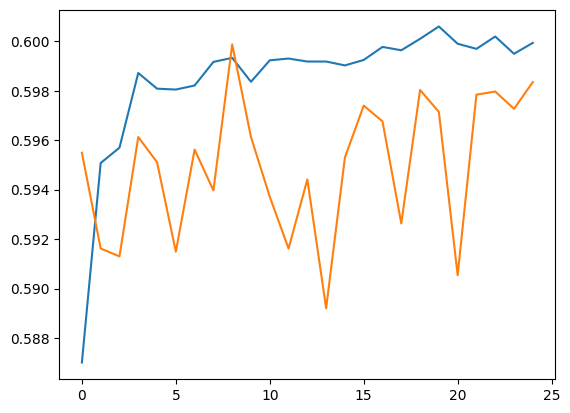

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [11]:
train_eval_result = model.evaluate(dict(train_df), train_df['Sentiment'])
validation_eval_result = model.evaluate(dict(validation_df), validation_df['Sentiment'])

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

   1/4385 [..............................] - ETA: 2:32 - loss: 0.7139 - accuracy: 0.6562

  19/4385 [..............................] - ETA: 12s - loss: 0.7205 - accuracy: 0.7286 

  37/4385 [..............................] - ETA: 12s - loss: 0.8051 - accuracy: 0.6909

  55/4385 [..............................] - ETA: 12s - loss: 0.8131 - accuracy: 0.6943

  72/4385 [..............................] - ETA: 12s - loss: 0.8186 - accuracy: 0.6884

  90/4385 [..............................] - ETA: 12s - loss: 0.8098 - accuracy: 0.6878

 107/4385 [..............................] - ETA: 12s - loss: 0.8201 - accuracy: 0.6825

 124/4385 [..............................] - ETA: 12s - loss: 0.8355 - accuracy: 0.6812

 141/4385 [..............................] - ETA: 12s - loss: 0.8541 - accuracy: 0.6709

 159/4385 [>.............................] - ETA: 12s - loss: 0.8642 - accuracy: 0.6616

 177/4385 [>.............................] - ETA: 12s - loss: 0.8684 - accuracy: 0.6600

 195/4385 [>.............................] - ETA: 12s - loss: 0.8710 - accuracy: 0.6566

 213/4385 [>.............................] - ETA: 12s - loss: 0.8747 - accuracy: 0.6532

 231/4385 [>.............................] - ETA: 12s - loss: 0.8854 - accuracy: 0.6488

 248/4385 [>.............................] - ETA: 12s - loss: 0.8834 - accuracy: 0.6491

 266/4385 [>.............................] - ETA: 11s - loss: 0.8840 - accuracy: 0.6487

 284/4385 [>.............................] - ETA: 11s - loss: 0.8904 - accuracy: 0.6462

 302/4385 [=>............................] - ETA: 11s - loss: 0.8868 - accuracy: 0.6474

 319/4385 [=>............................] - ETA: 11s - loss: 0.8914 - accuracy: 0.6455

 336/4385 [=>............................] - ETA: 11s - loss: 0.8979 - accuracy: 0.6418

 354/4385 [=>............................] - ETA: 11s - loss: 0.9009 - accuracy: 0.6412

 372/4385 [=>............................] - ETA: 11s - loss: 0.9025 - accuracy: 0.6399

 390/4385 [=>............................] - ETA: 11s - loss: 0.9015 - accuracy: 0.6407

 408/4385 [=>............................] - ETA: 11s - loss: 0.8976 - accuracy: 0.6428

 426/4385 [=>............................] - ETA: 11s - loss: 0.9013 - accuracy: 0.6409

 444/4385 [==>...........................] - ETA: 11s - loss: 0.9031 - accuracy: 0.6404

 462/4385 [==>...........................] - ETA: 11s - loss: 0.9021 - accuracy: 0.6404

 480/4385 [==>...........................] - ETA: 11s - loss: 0.9009 - accuracy: 0.6409

 498/4385 [==>...........................] - ETA: 11s - loss: 0.9032 - accuracy: 0.6398

 516/4385 [==>...........................] - ETA: 11s - loss: 0.9041 - accuracy: 0.6400

 535/4385 [==>...........................] - ETA: 11s - loss: 0.9048 - accuracy: 0.6400

 553/4385 [==>...........................] - ETA: 11s - loss: 0.9070 - accuracy: 0.6398

 571/4385 [==>...........................] - ETA: 10s - loss: 0.9105 - accuracy: 0.6387

 589/4385 [===>..........................] - ETA: 10s - loss: 0.9108 - accuracy: 0.6382

 607/4385 [===>..........................] - ETA: 10s - loss: 0.9083 - accuracy: 0.6395

 625/4385 [===>..........................] - ETA: 10s - loss: 0.9093 - accuracy: 0.6387

 643/4385 [===>..........................] - ETA: 10s - loss: 0.9093 - accuracy: 0.6383

 661/4385 [===>..........................] - ETA: 10s - loss: 0.9129 - accuracy: 0.6380

 679/4385 [===>..........................] - ETA: 10s - loss: 0.9149 - accuracy: 0.6376

 697/4385 [===>..........................] - ETA: 10s - loss: 0.9152 - accuracy: 0.6369

 715/4385 [===>..........................] - ETA: 10s - loss: 0.9164 - accuracy: 0.6360

 733/4385 [====>.........................] - ETA: 10s - loss: 0.9168 - accuracy: 0.6359

 752/4385 [====>.........................] - ETA: 10s - loss: 0.9189 - accuracy: 0.6348

 770/4385 [====>.........................] - ETA: 10s - loss: 0.9195 - accuracy: 0.6342

 788/4385 [====>.........................] - ETA: 10s - loss: 0.9181 - accuracy: 0.6346

 806/4385 [====>.........................] - ETA: 10s - loss: 0.9200 - accuracy: 0.6340

 823/4385 [====>.........................] - ETA: 10s - loss: 0.9203 - accuracy: 0.6338

 841/4385 [====>.........................] - ETA: 10s - loss: 0.9213 - accuracy: 0.6333

 859/4385 [====>.........................] - ETA: 10s - loss: 0.9247 - accuracy: 0.6314

 877/4385 [=====>........................] - ETA: 10s - loss: 0.9258 - accuracy: 0.6310

 895/4385 [=====>........................] - ETA: 10s - loss: 0.9289 - accuracy: 0.6296

 913/4385 [=====>........................] - ETA: 9s - loss: 0.9308 - accuracy: 0.6287 

 931/4385 [=====>........................] - ETA: 9s - loss: 0.9329 - accuracy: 0.6279

 949/4385 [=====>........................] - ETA: 9s - loss: 0.9349 - accuracy: 0.6272

 967/4385 [=====>........................] - ETA: 9s - loss: 0.9351 - accuracy: 0.6267

 985/4385 [=====>........................] - ETA: 9s - loss: 0.9360 - accuracy: 0.6260

1003/4385 [=====>........................] - ETA: 9s - loss: 0.9365 - accuracy: 0.6253

1021/4385 [=====>........................] - ETA: 9s - loss: 0.9383 - accuracy: 0.6246

1039/4385 [======>.......................] - ETA: 9s - loss: 0.9402 - accuracy: 0.6237

1057/4385 [======>.......................] - ETA: 9s - loss: 0.9402 - accuracy: 0.6239

1075/4385 [======>.......................] - ETA: 9s - loss: 0.9399 - accuracy: 0.6239

1093/4385 [======>.......................] - ETA: 9s - loss: 0.9397 - accuracy: 0.6240

1111/4385 [======>.......................] - ETA: 9s - loss: 0.9414 - accuracy: 0.6231

1129/4385 [======>.......................] - ETA: 9s - loss: 0.9421 - accuracy: 0.6228

1146/4385 [======>.......................] - ETA: 9s - loss: 0.9427 - accuracy: 0.6224

1163/4385 [======>.......................] - ETA: 9s - loss: 0.9424 - accuracy: 0.6227

1180/4385 [=======>......................] - ETA: 9s - loss: 0.9434 - accuracy: 0.6222

1197/4385 [=======>......................] - ETA: 9s - loss: 0.9441 - accuracy: 0.6225

1215/4385 [=======>......................] - ETA: 9s - loss: 0.9443 - accuracy: 0.6225

1233/4385 [=======>......................] - ETA: 9s - loss: 0.9445 - accuracy: 0.6223

1251/4385 [=======>......................] - ETA: 9s - loss: 0.9442 - accuracy: 0.6223

1269/4385 [=======>......................] - ETA: 8s - loss: 0.9444 - accuracy: 0.6218

1287/4385 [=======>......................] - ETA: 8s - loss: 0.9440 - accuracy: 0.6221

1305/4385 [=======>......................] - ETA: 8s - loss: 0.9471 - accuracy: 0.6210

1323/4385 [========>.....................] - ETA: 8s - loss: 0.9479 - accuracy: 0.6204

1341/4385 [========>.....................] - ETA: 8s - loss: 0.9472 - accuracy: 0.6205

1359/4385 [========>.....................] - ETA: 8s - loss: 0.9477 - accuracy: 0.6202

1377/4385 [========>.....................] - ETA: 8s - loss: 0.9482 - accuracy: 0.6201

1394/4385 [========>.....................] - ETA: 8s - loss: 0.9476 - accuracy: 0.6201

1412/4385 [========>.....................] - ETA: 8s - loss: 0.9476 - accuracy: 0.6201

1430/4385 [========>.....................] - ETA: 8s - loss: 0.9482 - accuracy: 0.6196

1448/4385 [========>.....................] - ETA: 8s - loss: 0.9487 - accuracy: 0.6193

1466/4385 [=========>....................] - ETA: 8s - loss: 0.9490 - accuracy: 0.6191

1484/4385 [=========>....................] - ETA: 8s - loss: 0.9500 - accuracy: 0.6187

1501/4385 [=========>....................] - ETA: 8s - loss: 0.9498 - accuracy: 0.6189

1519/4385 [=========>....................] - ETA: 8s - loss: 0.9504 - accuracy: 0.6181

1537/4385 [=========>....................] - ETA: 8s - loss: 0.9510 - accuracy: 0.6177

1555/4385 [=========>....................] - ETA: 8s - loss: 0.9514 - accuracy: 0.6174

1573/4385 [=========>....................] - ETA: 8s - loss: 0.9513 - accuracy: 0.6175

1591/4385 [=========>....................] - ETA: 8s - loss: 0.9514 - accuracy: 0.6174

1609/4385 [==========>...................] - ETA: 7s - loss: 0.9517 - accuracy: 0.6173

1627/4385 [==========>...................] - ETA: 7s - loss: 0.9532 - accuracy: 0.6164

1645/4385 [==========>...................] - ETA: 7s - loss: 0.9531 - accuracy: 0.6168

1663/4385 [==========>...................] - ETA: 7s - loss: 0.9539 - accuracy: 0.6164

1681/4385 [==========>...................] - ETA: 7s - loss: 0.9540 - accuracy: 0.6163

1699/4385 [==========>...................] - ETA: 7s - loss: 0.9551 - accuracy: 0.6159

1717/4385 [==========>...................] - ETA: 7s - loss: 0.9555 - accuracy: 0.6156

1735/4385 [==========>...................] - ETA: 7s - loss: 0.9564 - accuracy: 0.6152

1753/4385 [==========>...................] - ETA: 7s - loss: 0.9559 - accuracy: 0.6155

1771/4385 [===========>..................] - ETA: 7s - loss: 0.9569 - accuracy: 0.6150

1789/4385 [===========>..................] - ETA: 7s - loss: 0.9577 - accuracy: 0.6146

1807/4385 [===========>..................] - ETA: 7s - loss: 0.9574 - accuracy: 0.6148

1825/4385 [===========>..................] - ETA: 7s - loss: 0.9576 - accuracy: 0.6149

1843/4385 [===========>..................] - ETA: 7s - loss: 0.9576 - accuracy: 0.6145

1861/4385 [===========>..................] - ETA: 7s - loss: 0.9579 - accuracy: 0.6142

1879/4385 [===========>..................] - ETA: 7s - loss: 0.9577 - accuracy: 0.6144

1896/4385 [===========>..................] - ETA: 7s - loss: 0.9579 - accuracy: 0.6144

1914/4385 [============>.................] - ETA: 7s - loss: 0.9579 - accuracy: 0.6143

1932/4385 [============>.................] - ETA: 7s - loss: 0.9573 - accuracy: 0.6143

1950/4385 [============>.................] - ETA: 6s - loss: 0.9575 - accuracy: 0.6144

1968/4385 [============>.................] - ETA: 6s - loss: 0.9574 - accuracy: 0.6145

1986/4385 [============>.................] - ETA: 6s - loss: 0.9586 - accuracy: 0.6141

2004/4385 [============>.................] - ETA: 6s - loss: 0.9584 - accuracy: 0.6140

2022/4385 [============>.................] - ETA: 6s - loss: 0.9587 - accuracy: 0.6137

2040/4385 [============>.................] - ETA: 6s - loss: 0.9594 - accuracy: 0.6134

2058/4385 [=============>................] - ETA: 6s - loss: 0.9600 - accuracy: 0.6133

2076/4385 [=============>................] - ETA: 6s - loss: 0.9614 - accuracy: 0.6126

2094/4385 [=============>................] - ETA: 6s - loss: 0.9627 - accuracy: 0.6119

2112/4385 [=============>................] - ETA: 6s - loss: 0.9634 - accuracy: 0.6115

2130/4385 [=============>................] - ETA: 6s - loss: 0.9632 - accuracy: 0.6113

2148/4385 [=============>................] - ETA: 6s - loss: 0.9631 - accuracy: 0.6112

2166/4385 [=============>................] - ETA: 6s - loss: 0.9635 - accuracy: 0.6108

2184/4385 [=============>................] - ETA: 6s - loss: 0.9636 - accuracy: 0.6107

2202/4385 [==============>...............] - ETA: 6s - loss: 0.9650 - accuracy: 0.6101

2220/4385 [==============>...............] - ETA: 6s - loss: 0.9650 - accuracy: 0.6102

2237/4385 [==============>...............] - ETA: 6s - loss: 0.9652 - accuracy: 0.6101

2255/4385 [==============>...............] - ETA: 6s - loss: 0.9650 - accuracy: 0.6100

2273/4385 [==============>...............] - ETA: 6s - loss: 0.9653 - accuracy: 0.6102

2291/4385 [==============>...............] - ETA: 6s - loss: 0.9654 - accuracy: 0.6102

2309/4385 [==============>...............] - ETA: 5s - loss: 0.9657 - accuracy: 0.6102

2327/4385 [==============>...............] - ETA: 5s - loss: 0.9652 - accuracy: 0.6106

2345/4385 [===============>..............] - ETA: 5s - loss: 0.9653 - accuracy: 0.6105

2363/4385 [===============>..............] - ETA: 5s - loss: 0.9663 - accuracy: 0.6098

2381/4385 [===============>..............] - ETA: 5s - loss: 0.9667 - accuracy: 0.6099

2399/4385 [===============>..............] - ETA: 5s - loss: 0.9659 - accuracy: 0.6102

2417/4385 [===============>..............] - ETA: 5s - loss: 0.9666 - accuracy: 0.6099

2435/4385 [===============>..............] - ETA: 5s - loss: 0.9662 - accuracy: 0.6101

2453/4385 [===============>..............] - ETA: 5s - loss: 0.9661 - accuracy: 0.6102

2471/4385 [===============>..............] - ETA: 5s - loss: 0.9659 - accuracy: 0.6103

2489/4385 [================>.............] - ETA: 5s - loss: 0.9661 - accuracy: 0.6101

2507/4385 [================>.............] - ETA: 5s - loss: 0.9660 - accuracy: 0.6101

2525/4385 [================>.............] - ETA: 5s - loss: 0.9661 - accuracy: 0.6100

2543/4385 [================>.............] - ETA: 5s - loss: 0.9661 - accuracy: 0.6101

2560/4385 [================>.............] - ETA: 5s - loss: 0.9662 - accuracy: 0.6099

2577/4385 [================>.............] - ETA: 5s - loss: 0.9663 - accuracy: 0.6099

2594/4385 [================>.............] - ETA: 5s - loss: 0.9662 - accuracy: 0.6097

2612/4385 [================>.............] - ETA: 5s - loss: 0.9662 - accuracy: 0.6097

2630/4385 [================>.............] - ETA: 5s - loss: 0.9666 - accuracy: 0.6098

2648/4385 [=================>............] - ETA: 4s - loss: 0.9674 - accuracy: 0.6094

2666/4385 [=================>............] - ETA: 4s - loss: 0.9681 - accuracy: 0.6091

2684/4385 [=================>............] - ETA: 4s - loss: 0.9680 - accuracy: 0.6090

2702/4385 [=================>............] - ETA: 4s - loss: 0.9683 - accuracy: 0.6088

2720/4385 [=================>............] - ETA: 4s - loss: 0.9681 - accuracy: 0.6089

2738/4385 [=================>............] - ETA: 4s - loss: 0.9680 - accuracy: 0.6090

2756/4385 [=================>............] - ETA: 4s - loss: 0.9681 - accuracy: 0.6088

2774/4385 [=================>............] - ETA: 4s - loss: 0.9683 - accuracy: 0.6088

2792/4385 [==================>...........] - ETA: 4s - loss: 0.9685 - accuracy: 0.6086

2810/4385 [==================>...........] - ETA: 4s - loss: 0.9687 - accuracy: 0.6084

2828/4385 [==================>...........] - ETA: 4s - loss: 0.9694 - accuracy: 0.6082

2846/4385 [==================>...........] - ETA: 4s - loss: 0.9693 - accuracy: 0.6082

2864/4385 [==================>...........] - ETA: 4s - loss: 0.9696 - accuracy: 0.6081

2882/4385 [==================>...........] - ETA: 4s - loss: 0.9696 - accuracy: 0.6081

2899/4385 [==================>...........] - ETA: 4s - loss: 0.9697 - accuracy: 0.6080

2917/4385 [==================>...........] - ETA: 4s - loss: 0.9703 - accuracy: 0.6078

2934/4385 [===================>..........] - ETA: 4s - loss: 0.9705 - accuracy: 0.6077

2952/4385 [===================>..........] - ETA: 4s - loss: 0.9700 - accuracy: 0.6079

2970/4385 [===================>..........] - ETA: 4s - loss: 0.9691 - accuracy: 0.6082

2988/4385 [===================>..........] - ETA: 4s - loss: 0.9696 - accuracy: 0.6082

3005/4385 [===================>..........] - ETA: 3s - loss: 0.9697 - accuracy: 0.6082

3021/4385 [===================>..........] - ETA: 3s - loss: 0.9697 - accuracy: 0.6080

3038/4385 [===================>..........] - ETA: 3s - loss: 0.9700 - accuracy: 0.6080

3055/4385 [===================>..........] - ETA: 3s - loss: 0.9707 - accuracy: 0.6078

3073/4385 [====================>.........] - ETA: 3s - loss: 0.9708 - accuracy: 0.6076

3091/4385 [====================>.........] - ETA: 3s - loss: 0.9711 - accuracy: 0.6075

3109/4385 [====================>.........] - ETA: 3s - loss: 0.9715 - accuracy: 0.6072

3127/4385 [====================>.........] - ETA: 3s - loss: 0.9717 - accuracy: 0.6071

3145/4385 [====================>.........] - ETA: 3s - loss: 0.9718 - accuracy: 0.6070

3163/4385 [====================>.........] - ETA: 3s - loss: 0.9722 - accuracy: 0.6067

3181/4385 [====================>.........] - ETA: 3s - loss: 0.9723 - accuracy: 0.6066

3199/4385 [====================>.........] - ETA: 3s - loss: 0.9728 - accuracy: 0.6062

3217/4385 [=====================>........] - ETA: 3s - loss: 0.9726 - accuracy: 0.6062

3235/4385 [=====================>........] - ETA: 3s - loss: 0.9730 - accuracy: 0.6058

3252/4385 [=====================>........] - ETA: 3s - loss: 0.9736 - accuracy: 0.6056

3270/4385 [=====================>........] - ETA: 3s - loss: 0.9738 - accuracy: 0.6055

3288/4385 [=====================>........] - ETA: 3s - loss: 0.9742 - accuracy: 0.6054

3306/4385 [=====================>........] - ETA: 3s - loss: 0.9742 - accuracy: 0.6054

3324/4385 [=====================>........] - ETA: 3s - loss: 0.9745 - accuracy: 0.6053

3342/4385 [=====================>........] - ETA: 2s - loss: 0.9750 - accuracy: 0.6051

3360/4385 [=====================>........] - ETA: 2s - loss: 0.9751 - accuracy: 0.6050

3378/4385 [======================>.......] - ETA: 2s - loss: 0.9755 - accuracy: 0.6048

3396/4385 [======================>.......] - ETA: 2s - loss: 0.9757 - accuracy: 0.6045

3414/4385 [======================>.......] - ETA: 2s - loss: 0.9759 - accuracy: 0.6043

3432/4385 [======================>.......] - ETA: 2s - loss: 0.9759 - accuracy: 0.6044

3450/4385 [======================>.......] - ETA: 2s - loss: 0.9760 - accuracy: 0.6043

3468/4385 [======================>.......] - ETA: 2s - loss: 0.9761 - accuracy: 0.6043

3486/4385 [======================>.......] - ETA: 2s - loss: 0.9764 - accuracy: 0.6040

3504/4385 [======================>.......] - ETA: 2s - loss: 0.9764 - accuracy: 0.6041

3522/4385 [=======================>......] - ETA: 2s - loss: 0.9763 - accuracy: 0.6038

3540/4385 [=======================>......] - ETA: 2s - loss: 0.9772 - accuracy: 0.6035

3558/4385 [=======================>......] - ETA: 2s - loss: 0.9777 - accuracy: 0.6034

3576/4385 [=======================>......] - ETA: 2s - loss: 0.9785 - accuracy: 0.6031

3593/4385 [=======================>......] - ETA: 2s - loss: 0.9787 - accuracy: 0.6030

3610/4385 [=======================>......] - ETA: 2s - loss: 0.9788 - accuracy: 0.6030

3628/4385 [=======================>......] - ETA: 2s - loss: 0.9791 - accuracy: 0.6028

3646/4385 [=======================>......] - ETA: 2s - loss: 0.9792 - accuracy: 0.6028

3664/4385 [========================>.....] - ETA: 2s - loss: 0.9793 - accuracy: 0.6029

3682/4385 [========================>.....] - ETA: 2s - loss: 0.9793 - accuracy: 0.6028

3700/4385 [========================>.....] - ETA: 1s - loss: 0.9794 - accuracy: 0.6028

3718/4385 [========================>.....] - ETA: 1s - loss: 0.9794 - accuracy: 0.6028

3736/4385 [========================>.....] - ETA: 1s - loss: 0.9800 - accuracy: 0.6026

3754/4385 [========================>.....] - ETA: 1s - loss: 0.9801 - accuracy: 0.6025

3772/4385 [========================>.....] - ETA: 1s - loss: 0.9800 - accuracy: 0.6026

3790/4385 [========================>.....] - ETA: 1s - loss: 0.9799 - accuracy: 0.6025

3808/4385 [=========================>....] - ETA: 1s - loss: 0.9798 - accuracy: 0.6025

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9800 - accuracy: 0.6024

3844/4385 [=========================>....] - ETA: 1s - loss: 0.9800 - accuracy: 0.6024

3862/4385 [=========================>....] - ETA: 1s - loss: 0.9804 - accuracy: 0.6022

3880/4385 [=========================>....] - ETA: 1s - loss: 0.9805 - accuracy: 0.6022

3898/4385 [=========================>....] - ETA: 1s - loss: 0.9809 - accuracy: 0.6022

3916/4385 [=========================>....] - ETA: 1s - loss: 0.9809 - accuracy: 0.6021

3934/4385 [=========================>....] - ETA: 1s - loss: 0.9809 - accuracy: 0.6022

3952/4385 [==========================>...] - ETA: 1s - loss: 0.9812 - accuracy: 0.6021

3970/4385 [==========================>...] - ETA: 1s - loss: 0.9817 - accuracy: 0.6019

3988/4385 [==========================>...] - ETA: 1s - loss: 0.9821 - accuracy: 0.6015

4006/4385 [==========================>...] - ETA: 1s - loss: 0.9822 - accuracy: 0.6013

4024/4385 [==========================>...] - ETA: 1s - loss: 0.9828 - accuracy: 0.6012

4042/4385 [==========================>...] - ETA: 0s - loss: 0.9825 - accuracy: 0.6013

4060/4385 [==========================>...] - ETA: 0s - loss: 0.9824 - accuracy: 0.6013

4078/4385 [==========================>...] - ETA: 0s - loss: 0.9825 - accuracy: 0.6014

4097/4385 [===========================>..] - ETA: 0s - loss: 0.9822 - accuracy: 0.6015

4115/4385 [===========================>..] - ETA: 0s - loss: 0.9821 - accuracy: 0.6015

4133/4385 [===========================>..] - ETA: 0s - loss: 0.9826 - accuracy: 0.6014

4151/4385 [===========================>..] - ETA: 0s - loss: 0.9831 - accuracy: 0.6013

4169/4385 [===========================>..] - ETA: 0s - loss: 0.9834 - accuracy: 0.6010

4187/4385 [===========================>..] - ETA: 0s - loss: 0.9837 - accuracy: 0.6008

4205/4385 [===========================>..] - ETA: 0s - loss: 0.9838 - accuracy: 0.6007

4223/4385 [===========================>..] - ETA: 0s - loss: 0.9841 - accuracy: 0.6006

4241/4385 [============================>.] - ETA: 0s - loss: 0.9843 - accuracy: 0.6005

4259/4385 [============================>.] - ETA: 0s - loss: 0.9845 - accuracy: 0.6004

4277/4385 [============================>.] - ETA: 0s - loss: 0.9846 - accuracy: 0.6003

4295/4385 [============================>.] - ETA: 0s - loss: 0.9846 - accuracy: 0.6002

4313/4385 [============================>.] - ETA: 0s - loss: 0.9843 - accuracy: 0.6002

4331/4385 [============================>.] - ETA: 0s - loss: 0.9844 - accuracy: 0.6003

4350/4385 [============================>.] - ETA: 0s - loss: 0.9850 - accuracy: 0.6001

4368/4385 [============================>.] - ETA: 0s - loss: 0.9850 - accuracy: 0.6001

4385/4385 [==============================] - 13s 3ms/step - loss: 0.9850 - accuracy: 0.6001


  1/493 [..............................] - ETA: 12s - loss: 0.9264 - accuracy: 0.5938

 26/493 [>.............................] - ETA: 0s - loss: 0.9596 - accuracy: 0.6310 

 51/493 [==>...........................] - ETA: 0s - loss: 0.9378 - accuracy: 0.6281

 76/493 [===>..........................] - ETA: 0s - loss: 0.9237 - accuracy: 0.6275

101/493 [=====>........................] - ETA: 0s - loss: 0.9193 - accuracy: 0.6315

126/493 [======>.......................] - ETA: 0s - loss: 0.9328 - accuracy: 0.6208

151/493 [========>.....................] - ETA: 0s - loss: 0.9347 - accuracy: 0.6192

176/493 [=========>....................] - ETA: 0s - loss: 0.9464 - accuracy: 0.6161

202/493 [===========>..................] - ETA: 0s - loss: 0.9591 - accuracy: 0.6094

227/493 [============>.................] - ETA: 0s - loss: 0.9616 - accuracy: 0.6078

252/493 [==============>...............] - ETA: 0s - loss: 0.9635 - accuracy: 0.6043

277/493 [===============>..............] - ETA: 0s - loss: 0.9714 - accuracy: 0.5992

303/493 [=================>............] - ETA: 0s - loss: 0.9714 - accuracy: 0.5990

328/493 [==================>...........] - ETA: 0s - loss: 0.9697 - accuracy: 0.6007

354/493 [====================>.........] - ETA: 0s - loss: 0.9716 - accuracy: 0.5986

379/493 [======================>.......] - ETA: 0s - loss: 0.9737 - accuracy: 0.5979

405/493 [=======================>......] - ETA: 0s - loss: 0.9743 - accuracy: 0.5995

430/493 [=========================>....] - ETA: 0s - loss: 0.9739 - accuracy: 0.6003

456/493 [==========================>...] - ETA: 0s - loss: 0.9781 - accuracy: 0.5987

482/493 [============================>.] - ETA: 0s - loss: 0.9776 - accuracy: 0.5978

493/493 [==============================] - 1s 2ms/step - loss: 0.9784 - accuracy: 0.5983


Training set accuracy: 0.6000570058822632
Validation set accuracy: 0.5983486771583557


## Confusion matrix

Another very interesting statistic, especially for multiclass problems, is the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix allows visualization of the proportion of correctly and incorrectly labelled examples. We can easily see how much our classifier is biased and whether the distribution of labels makes sense. Ideally the largest fraction of predictions should be distributed along the diagonal.

In [12]:
predictions = model.predict(dict(validation_df))
predictions = tf.argmax(predictions, axis=-1)
predictions

  1/493 [..............................] - ETA: 42s

 37/493 [=>............................] - ETA: 0s 

 74/493 [===>..........................] - ETA: 0s

111/493 [=====>........................] - ETA: 0s

147/493 [=======>......................] - ETA: 0s

184/493 [==========>...................] - ETA: 0s

221/493 [============>.................] - ETA: 0s

257/493 [==============>...............] - ETA: 0s

293/493 [================>.............] - ETA: 0s

329/493 [===================>..........] - ETA: 0s

365/493 [=====================>........] - ETA: 0s

401/493 [=======================>......] - ETA: 0s

436/493 [=========================>....] - ETA: 0s

472/493 [===========================>..] - ETA: 0s

493/493 [==============================] - 1s 1ms/step


<tf.Tensor: shape=(15745,), dtype=int64, numpy=array([1, 1, 2, ..., 2, 2, 2])>

In [13]:
cm = tf.math.confusion_matrix(validation_df['Sentiment'], predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(50.72222222222221, 0.5, 'True')

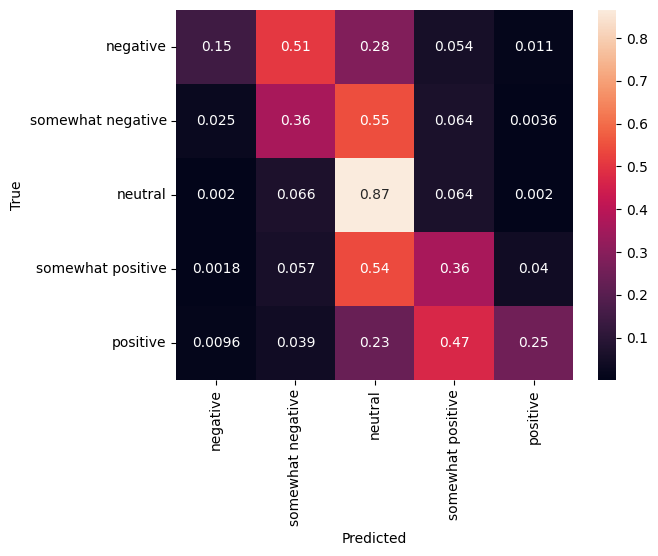

In [14]:
sns.heatmap(
    cm, annot=True,
    xticklabels=SENTIMENT_LABELS,
    yticklabels=SENTIMENT_LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

We can easily submit the predictions back to Kaggle by pasting the following code to a code cell and executing it:

``` python
test_predictions = model.predict(dict(test_df))
test_predictions = np.argmax(test_predictions, axis=-1)

result_df = test_df.copy()

result_df["Predictions"] = test_predictions

result_df.to_csv(
    "predictions.csv",
    columns=["Predictions"],
    header=["Sentiment"])
kaggle.api.competition_submit("predictions.csv", "Submitted from Colab",
                              "sentiment-analysis-on-movie-reviews")
```


After submitting, [check the leaderboard](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/leaderboard) to see how you did.